导入库

In [1]:
import csv
import re
import os
import time
import pickle
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import tensorflow as tf

from keras.models import Model
from keras.layers import LSTM, GRU, Activation, Dense, Dropout, Input, Embedding
from keras.layers import Convolution1D, MaxPool1D, Flatten
from tensorflow.keras.optimizers import RMSprop,Adam
from keras.layers import Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.models import Sequential
from keras.layers.merge import concatenate
from keras_visualizer import visualizer
from keras.utils.vis_utils import plot_model
import keras
from itertools import cycle

import keras.backend as K

import tensorflow as tf
try:
    with tf.device('/device:GPU:0'):
        print('GPU works')
except:
    print('GPU not working')
tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

from sklearn.preprocessing import OneHotEncoder
from keras.utils import np_utils
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from sklearn.model_selection import StratifiedKFold
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier




GPU works
Num GPUs Available:  1


# 2.车载网络数据_2
Data\9) Car-Hacking Dataset

## 多分类：处理数据

In [2]:
# 读取Car_Hacking_Dataset 
Car_Hacking_Dataset = pd.read_csv('Data\9) Car-Hacking Dataset\Car_Hacking_Dataset.csv')
Car_Hacking_Dataset

DATA Flag SubClass
0         03 16 05 21 68 09 21 21 00 6f    R   Normal
1         01 8f fe 5b 00 00 00 3c 00 00    R   Normal
2         02 60 19 21 22 30 08 8e 6d 3a    R   Normal
3         02 a0 64 00 9a 1d 97 02 bd 00    R   Normal
4         03 29 40 bb 7f 14 11 20 00 14    R   Normal
...                                 ...  ...      ...
16569470  01 8f fe 59 00 00 00 41 00 00    R   Normal
16569471  02 60 18 21 21 30 08 8f 6d 19    R   Normal
16569472  02 a0 24 00 9a 1d 97 02 bd 00    R   Normal
16569473  03 29 dc b7 7f 14 11 20 00 14    R   Normal
16569474  05 45 d8 00 00 8b 00 00 00 00    R   Normal

[16569475 rows x 3 columns]

In [3]:
print(Car_Hacking_Dataset['Flag'].value_counts())
print(Car_Hacking_Dataset['SubClass'].value_counts())

R    14237958
T     2331517
Name: Flag, dtype: int64
Normal    14237958
RPM         654897
gear        597252
DoS         587521
Fuzzy       491847
Name: SubClass, dtype: int64


In [4]:
# 将Class中的Nomal和Attack转换为0和1，不使用LabelEncoder
Car_Hacking_Dataset['Flag'] = Car_Hacking_Dataset['Flag'].replace({'R': 0, 'T': 1})

# 对SubClass中的Normal、RPM、gear、Dos、Fuzzy 转化为0、1、2、3、4
Car_Hacking_Dataset['SubClass'] = Car_Hacking_Dataset['SubClass'].map({'Normal': 0, 'RPM': 1, 'gear': 2, 'Dos': 3, 'Fuzzy': 4})
print(Car_Hacking_Dataset['Flag'].value_counts())
print(Car_Hacking_Dataset['SubClass'].value_counts())

0    14237958
1     2331517
Name: Flag, dtype: int64
0.0    14237958
1.0      654897
2.0      597252
4.0      491847
Name: SubClass, dtype: int64


In [5]:
print(Car_Hacking_Dataset['SubClass'].value_counts())

0.0    14237958
1.0      654897
2.0      597252
4.0      491847
Name: SubClass, dtype: int64


In [6]:
# 将Class和SubClass转换为OneHotEncoder
ohe = OneHotEncoder()
Class = ohe.fit_transform(Car_Hacking_Dataset['Flag'].values.reshape(-1, 1)).toarray()
SubClass = ohe.fit_transform(Car_Hacking_Dataset['SubClass'].values.reshape(-1, 1)).toarray()
print(Class)
print(SubClass)



[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]


In [7]:
# 取出数据集中除了标签以外的数据
Car_Hacking_Dataset = Car_Hacking_Dataset.drop(['Flag', 'SubClass'], axis=1)

# 将数据集划分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(Car_Hacking_Dataset, SubClass, test_size=0.2, random_state=42)

In [8]:
content = Car_Hacking_Dataset['DATA']
# print(content)

# 使用Tokenizer对词组进行编码
# 特征编号，不足的前面补0
# fit_on_texts函数可以将输入的文本每个词编号 编号根据词频(词频越大编号越小)
max_words = 256 ##使用的最大词语数为1000
maxLen = 10 #句子的长度最多为8
start_time1 = time.time()
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(content) # 对整个数据集的词进行词频统计
end_time1 = time.time()
process_time1 = (end_time1 - start_time1) / len(content)
vocab = tokenizer.word_index  #停用词已过滤,获取每个词的编号
# print(vocab)

# 使用word_index属性可以看到每次词对应的编码
# 使用word_counts属性可以看到每个词对应的频数
# print(tokenizer.word_index)
# print(tokenizer.word_counts)

"""
# 使用Tokenizer对词组进行编码
# 当我们创建了一个Tokenizer对象后，使用该对象的fit_on_texts()函数，以空格去识别每个词
# 可以将输入的文本中的每个词编号，编号是根据词频的，词频越大，编号越小
"""

# 将train_value中的字符串按照空格进行分割
train_content = X_train['DATA']
test_content = X_test['DATA']
# print(train_content)
# print(test_content)


# 特征编号，将一句话表示为词编码的序列
# 计算由数据流转化为由词编码组成序列的时间
start_time2 = time.time()
trainID = tokenizer.texts_to_sequences(train_content)
# print(trainID)
end_time2 = time.time()
process_time2 = (end_time2 - start_time2) / len(train_content)
testID = tokenizer.texts_to_sequences(test_content)
# print(testID)
# 该方法会让CNN训练的长度统一,(不足的前面补0)，使用sequence.pad_sequences()将每个序列调整为相同的长度
# 计算转化为的序列进行填充和截断的时间
start_time3 = time.time()
trainSeq = sequence.pad_sequences(trainID, maxlen=maxLen)
end_time3 = time.time()
process_time3 = (end_time3 - start_time3) / len(trainSeq)
# print(trainSeq)
testSeq = sequence.pad_sequences(testID, maxlen=maxLen)
# print(testSeq)

print("Average Time for Word Frequency Counting: {:.6f} seconds".format(process_time1))
print("Average Time for Text to Sequence Conversion: {:.6f} seconds".format(process_time2))
print("Average Time for Padding/Truncating Sequences: {:.6f} seconds".format(process_time3))


KeyboardInterrupt: 

比较不带有attention的CNN BiLSTM模型

In [9]:
# 建立Attention+CNN模型并训练
#构建TextCNN模型
num_labels = 5
inputs = Input(name='inputs',shape=[maxLen], dtype='float64')

layer = Embedding(max_words+1, 128, input_length=maxLen, trainable=True)(inputs)

cnn1 = Convolution1D(64, 3, padding='same', activation='relu')(layer)
cnn1 = MaxPool1D(pool_size=4)(cnn1)
cnn2 = Convolution1D(64, 4, padding='same', activation='relu')(layer)
cnn2 = MaxPool1D(pool_size=4)(cnn2)
cnn3 = Convolution1D(64, 5, padding='same', activation='relu')(layer)
cnn3 = MaxPool1D(pool_size=4)(cnn3)

cnn = concatenate([cnn1, cnn2, cnn3], axis=-1)

bilstm = Bidirectional(LSTM(128, return_sequences=False))(cnn)
layer = Dense(128, activation='relu')(bilstm)
layer = Dropout(0.3)(layer)

output = Dense(num_labels, activation='softmax')(layer)
model = Model(inputs=inputs, outputs=output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 10)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 10, 128)      32896       inputs[0][0]                     
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 10, 64)       24640       embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 10, 64)       32832       embedding[0][0]                  
______________________________________________________________________________________________

In [10]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from sklearn.model_selection import StratifiedKFold
import time


accuracy_score_list,recall_score_list,precision_score_list,f1_score_list = [],[],[],[]
# 编译模型
adam = keras.optimizers.adam_v2.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=["accuracy"])

# 定义5折交叉验证
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 记录开始时间
start_time = time.time()

# 开始交叉验证
for train_index, val_index in kfold.split(trainSeq, np.argmax(y_train,axis=1)):
    X_train_fold, X_val_fold = trainSeq[train_index],trainSeq[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    print(X_train_fold.shape, X_val_fold.shape, y_train_fold.shape, y_val_fold.shape)


    # 训练模型
    history = model.fit(X_train_fold, y_train_fold, epochs=5, batch_size=1024)
    y_pred = model.predict(X_val_fold)
    print(y_pred.shape)
    print(history.history)
    # 评估模型
    AccuracyScore = metrics.accuracy_score(np.argmax(y_val_fold,axis=1),np.argmax(y_pred,axis=1))
    RecallScore = metrics.recall_score(np.argmax(y_val_fold,axis=1),np.argmax(y_pred,axis=1),average='macro')
    PrecisionScore = metrics.precision_score(np.argmax(y_val_fold,axis=1),np.argmax(y_pred,axis=1),average='macro')
    F1Score = metrics.f1_score(np.argmax(y_val_fold,axis=1),np.argmax(y_pred,axis=1),average='macro')
    # 将评估指标存放对应的列表中
    accuracy_score_list.append(AccuracyScore)
    recall_score_list.append(RecallScore)
    precision_score_list.append(PrecisionScore)
    f1_score_list.append(F1Score)
        # 打印每一次训练的正确率、召回率、F1值
    print('accuracy_score:',AccuracyScore,'recall_score:',RecallScore,'precision_score',PrecisionScore,'f1_score:',F1Score)
# 打印各指标的平均值和95%的置信区间
print("Accuracy: %0.4f (+/- %0.4f)" % (np.average(accuracy_score_list), np.std(accuracy_score_list) * 2))
print("Recall: %0.4f (+/- %0.4f)" % (np.average(recall_score_list), np.std(recall_score_list) * 2))
print("Precision: %0.4f (+/- %0.4f)" % (np.average(precision_score_list), np.std(precision_score_list) * 2))
print("F1_score: %0.4f (+/- %0.4f)" % (np.average(f1_score_list), np.std(f1_score_list) * 2))

# 计算总训练时间
end_time = time.time()
elapsed_time = end_time - start_time
average_training_time = elapsed_time / ((len(X_train) * kfold.n_splits))
print("Average Training Time per Data Point: {:.6f} seconds".format(average_training_time))

# 保存模型
model.save('model_intra\cnn_bilstm_woatten.h5')




C:\Users\10105\.conda\envs\tf2\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


(10604464, 10) (2651116, 10) (10604464, 5) (2651116, 5)
Epoch 1/5
10356/10356 [==============================] - 87s 8ms/step - loss: 0.0029 - accuracy: 0.9993
Epoch 2/5
10356/10356 [==============================] - 77s 7ms/step - loss: 2.2306e-05 - accuracy: 1.0000
Epoch 3/5
10356/10356 [==============================] - 78s 8ms/step - loss: 1.3506e-04 - accuracy: 1.0000
Epoch 4/5
10356/10356 [==============================] - 77s 7ms/step - loss: 5.8051e-06 - accuracy: 1.0000
Epoch 5/5
10356/10356 [==============================] - 78s 8ms/step - loss: 1.1660e-05 - accuracy: 1.0000
(2651116, 5)
{'loss': [0.0029482957907021046, 2.230646350653842e-05, 0.00013505906099453568, 5.80506321057328e-06, 1.1660398740787059e-05], 'accuracy': [0.9992510676383972, 0.999995768070221, 0.9999907612800598, 0.9999990463256836, 0.9999983906745911]}
accuracy_score: 0.9999996228003603 recall_score: 0.9999974578640973 precision_score 0.9999999122112022 f1_score: 0.999998685029562
(10604464, 10) (2651116,

In [11]:
print("模型预测")
mainModel = load_model('model_intra\cnn_bilstm_woatten.h5', compile=False)
# 预测


模型预测


Average Prediction Time per Data Point: 0.000054 seconds
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000   2846990
           1     1.0000    1.0000    1.0000    131324
           2     1.0000    1.0000    1.0000    119707
           3     1.0000    1.0000    1.0000     98475
           4     1.0000    1.0000    1.0000    117399

    accuracy                         1.0000   3313895
   macro avg     1.0000    1.0000    1.0000   3313895
weighted avg     1.0000    1.0000    1.0000   3313895

Accuracy:1.0000
MCC:1.0000
Kappa:1.0000
False Positive Rate (Benign samples misclassified as attacks): 0.0000


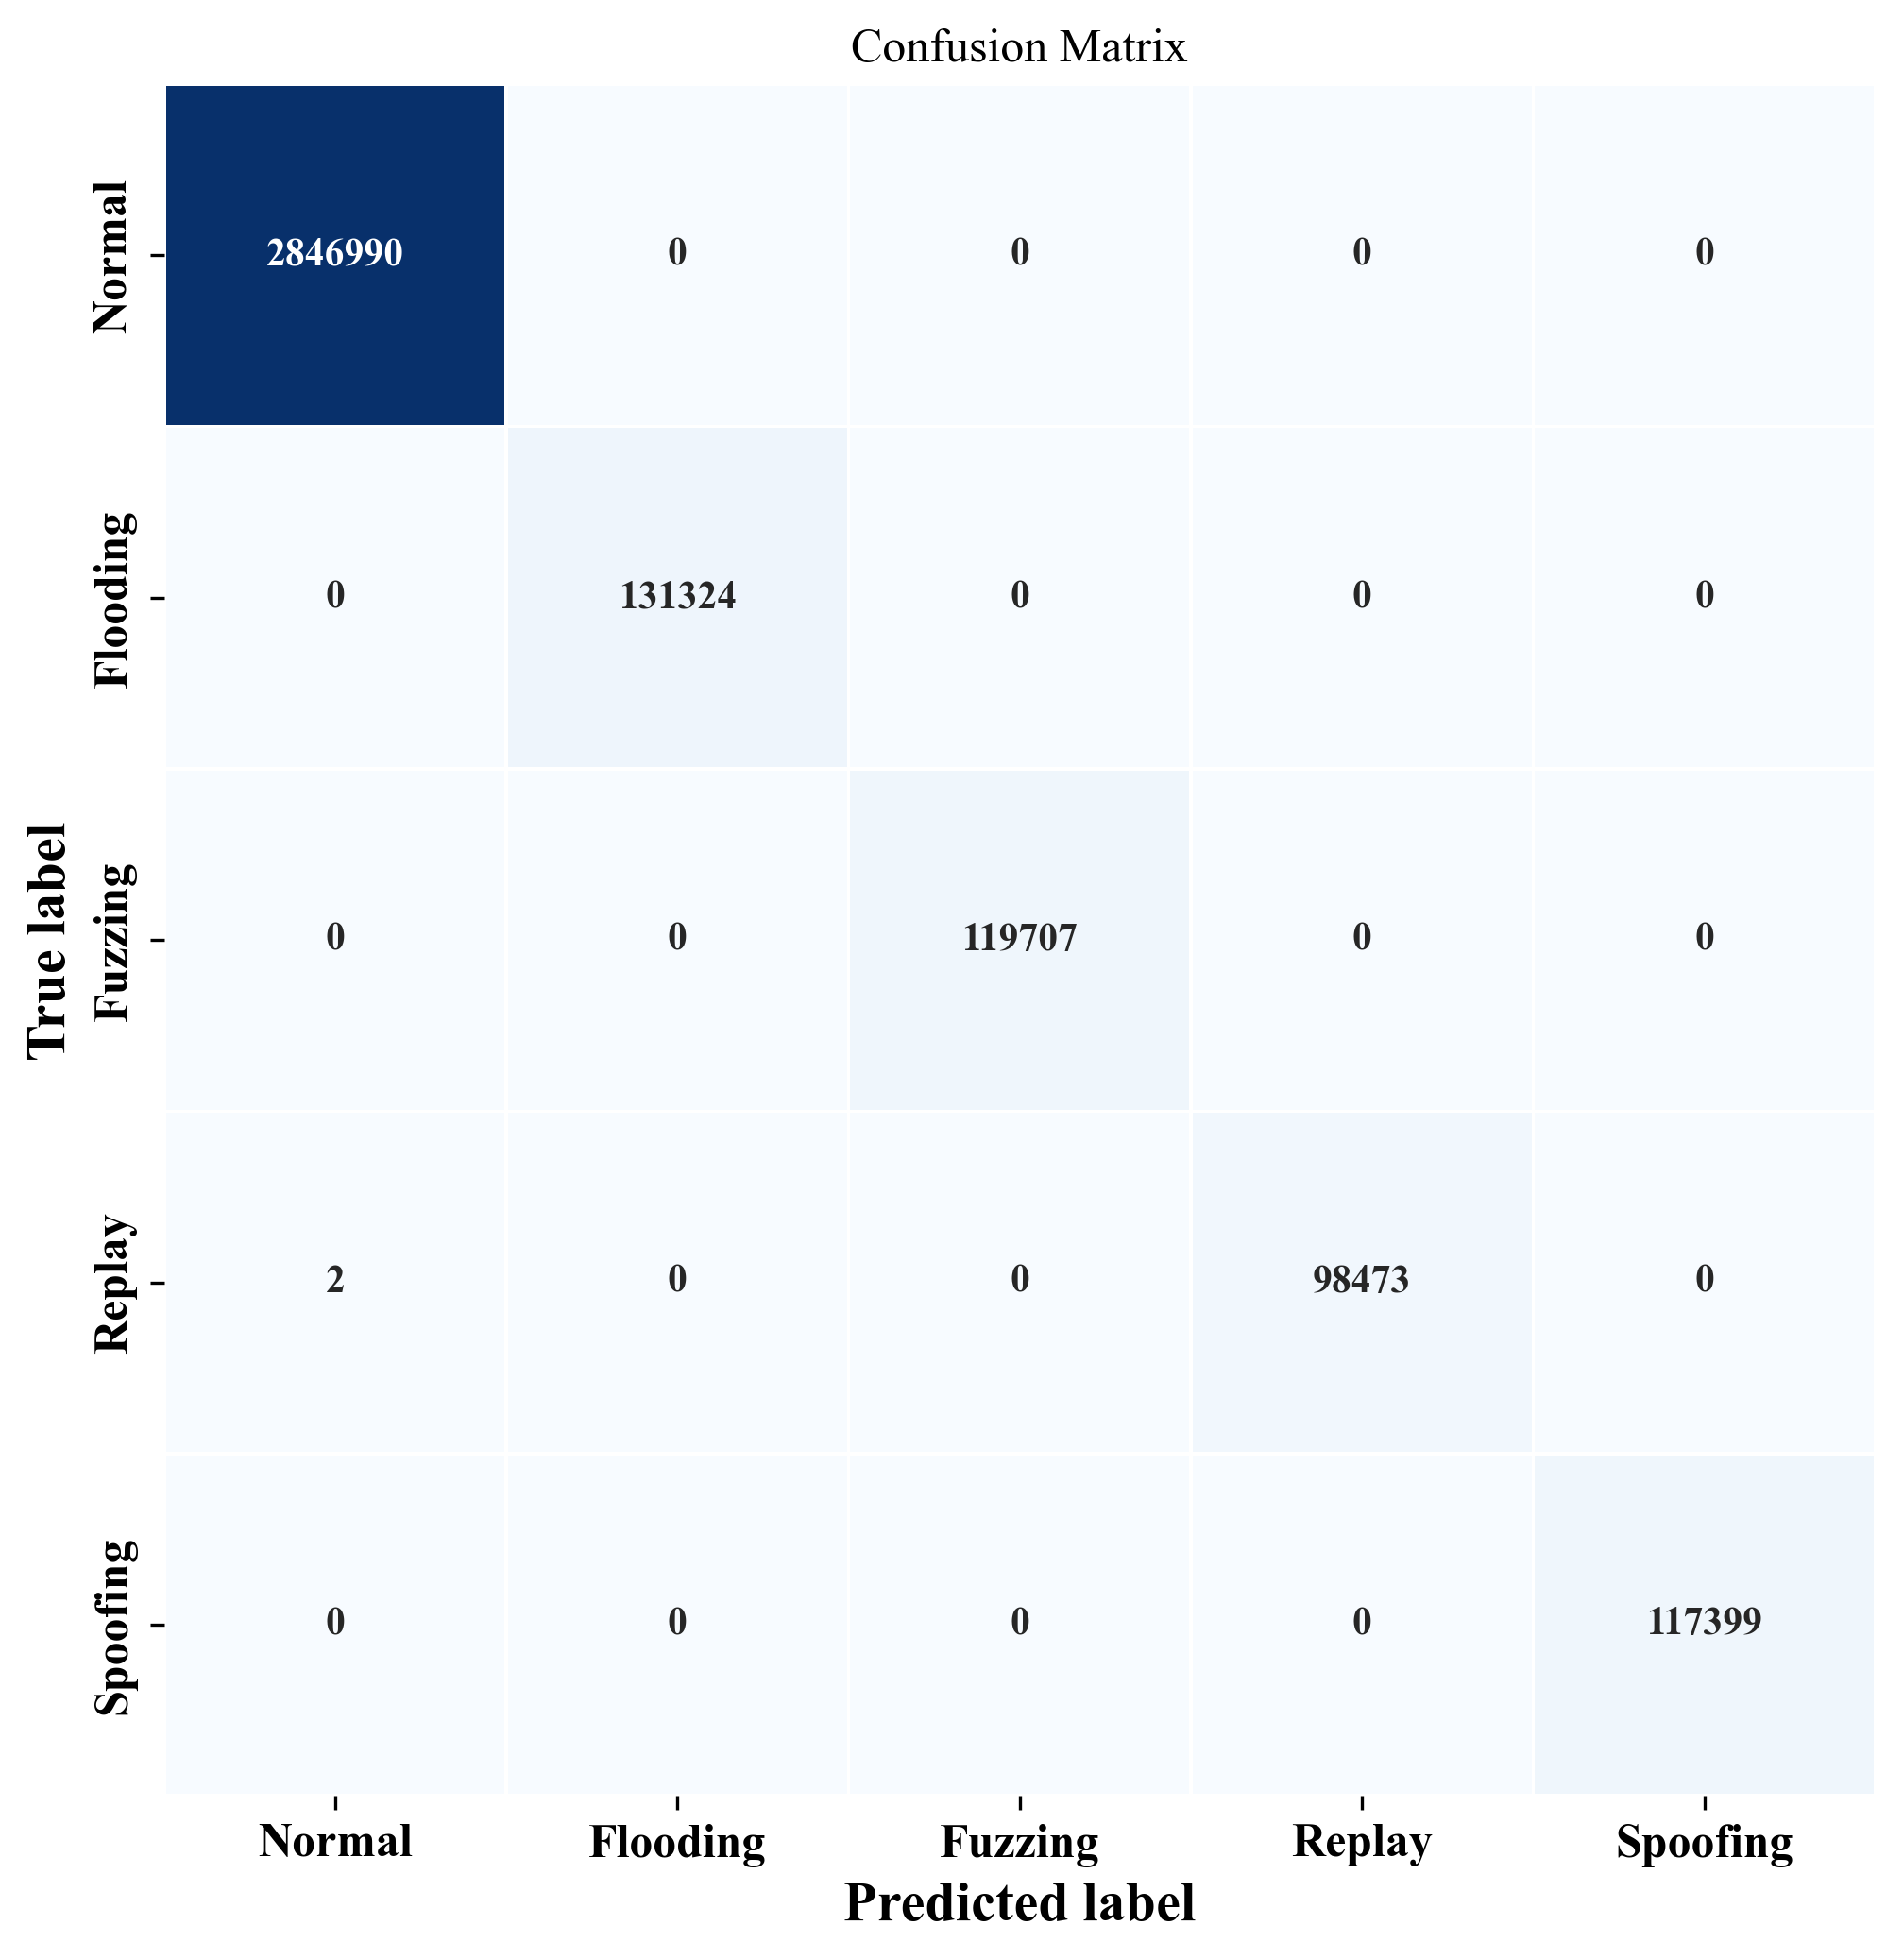

In [12]:
# 计算预测时间
start_time = time.time()  # 记录开始时间
test_pre = mainModel.predict(testSeq)
end_time = time.time()  # 记录结束时间
average_prediction_time = (end_time - start_time) / len(testSeq)
print("Average Prediction Time per Data Point: {:.6f} seconds".format(average_prediction_time))

# 计算混淆矩阵
confm = metrics.confusion_matrix(np.argmax(y_test, axis=1), np.argmax(test_pre, axis=1))
# 计算classification_report
print(metrics.classification_report(np.argmax(y_test, axis=1),
                                    np.argmax(test_pre, axis=1),
                                    digits=4))
# 计算准确度
accuracy = metrics.accuracy_score(np.argmax(y_test, axis=1),
                                          np.argmax(test_pre, axis=1))
print("Accuracy:{:.4f}".format(accuracy))
# 计算MCC
mcc = metrics.matthews_corrcoef(np.argmax(y_test, axis=1),
                                          np.argmax(test_pre, axis=1))
print("MCC:{:.4f}".format(mcc))
# 计算kappa
kappa = metrics.cohen_kappa_score(np.argmax(y_test, axis=1),
                                          np.argmax(test_pre, axis=1))
print("Kappa:{:.4f}".format(kappa))
# 计算误报率（False Positive Rate）
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(test_pre, axis=1)
false_positives = np.sum((y_true == 0) & (y_pred != 0))  # 0 represents the "Benign" class
total_benign_samples = np.sum(y_true == 0)
false_positive_rate = false_positives / total_benign_samples
print("False Positive Rate (Benign samples misclassified as attacks): {:.4f}".format(false_positive_rate))

# 画图
#设置所有图片的字体大小为10，字体为Times New Roman，字体为粗体，label的字体大小为10，字体为Times New Roman，字体为粗体
plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'

plt.figure(figsize=(8, 8), dpi=300)
sns.heatmap(confm, square=True, annot=True,
            fmt='d', cbar=False, linewidths=.6,
            cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted label', size=14)
plt.ylabel('True label', size=14)
Labname = ['Normal', 'Flooding', 'Fuzzing', 'Replay', 'Spoofing']   #行列名
plt.xticks(np.arange(5)+0.5, Labname, size = 12)
plt.yticks(np.arange(5)+0.5, Labname, size = 12)
plt.show()


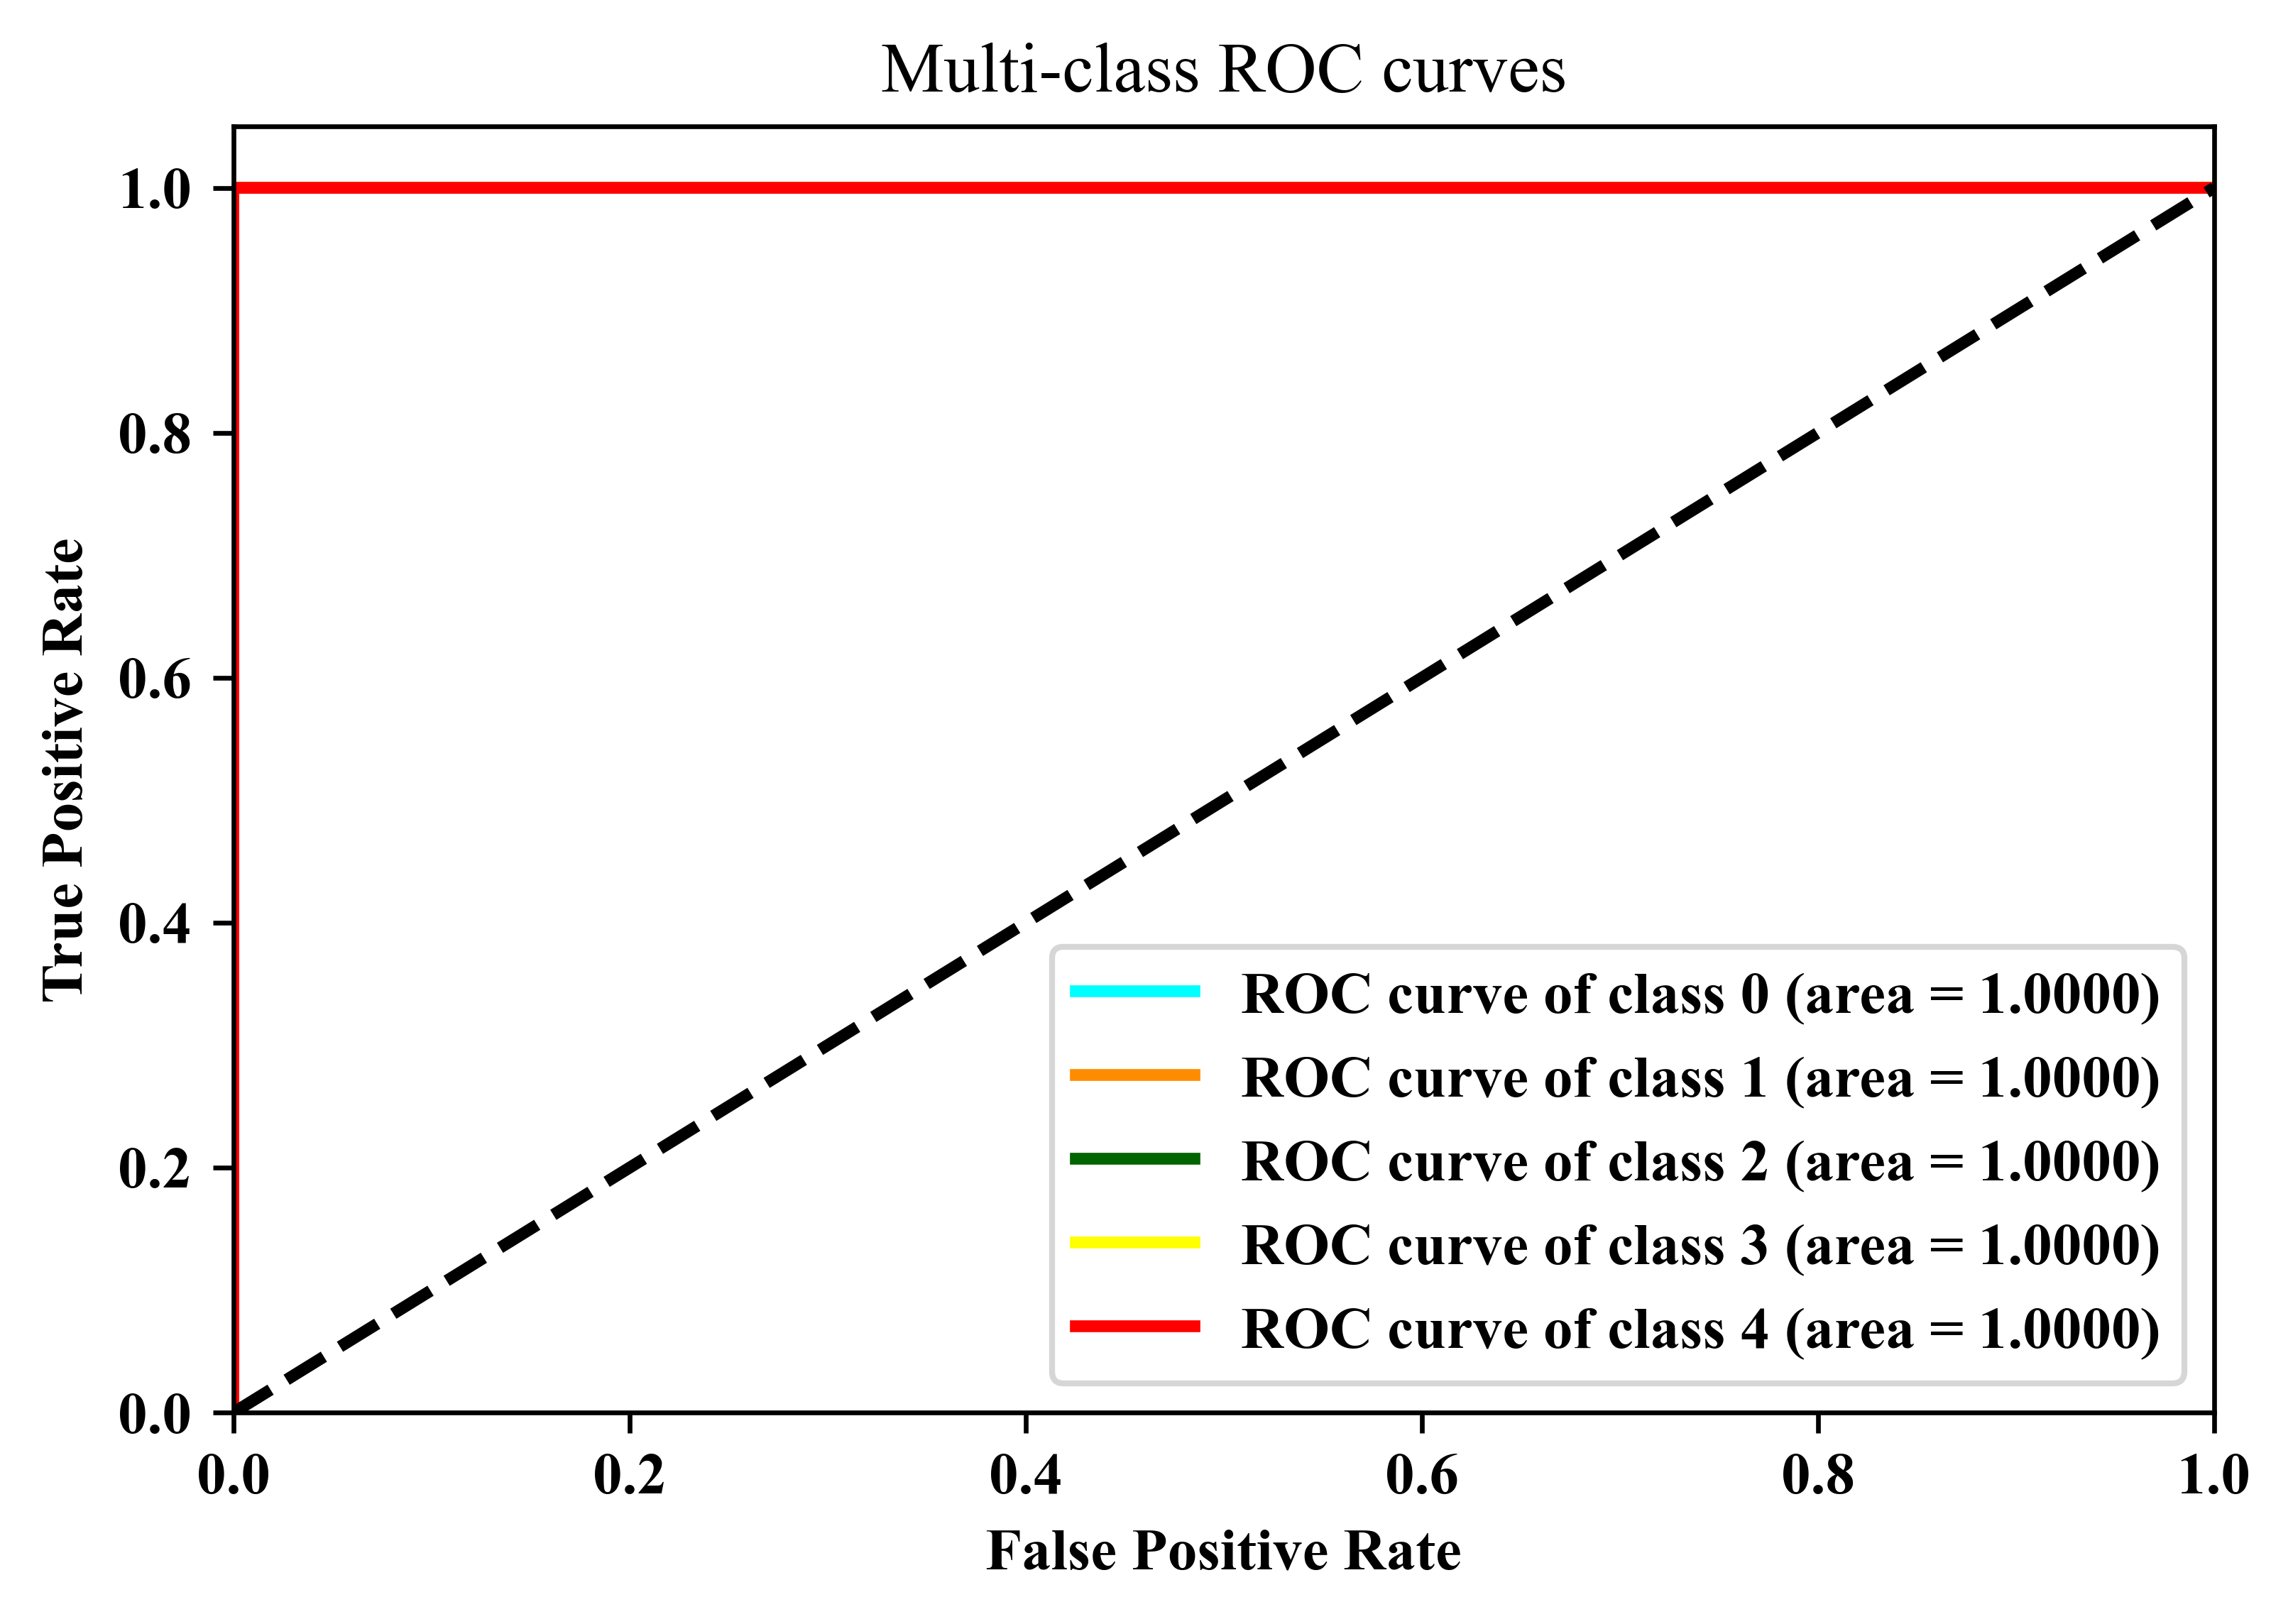

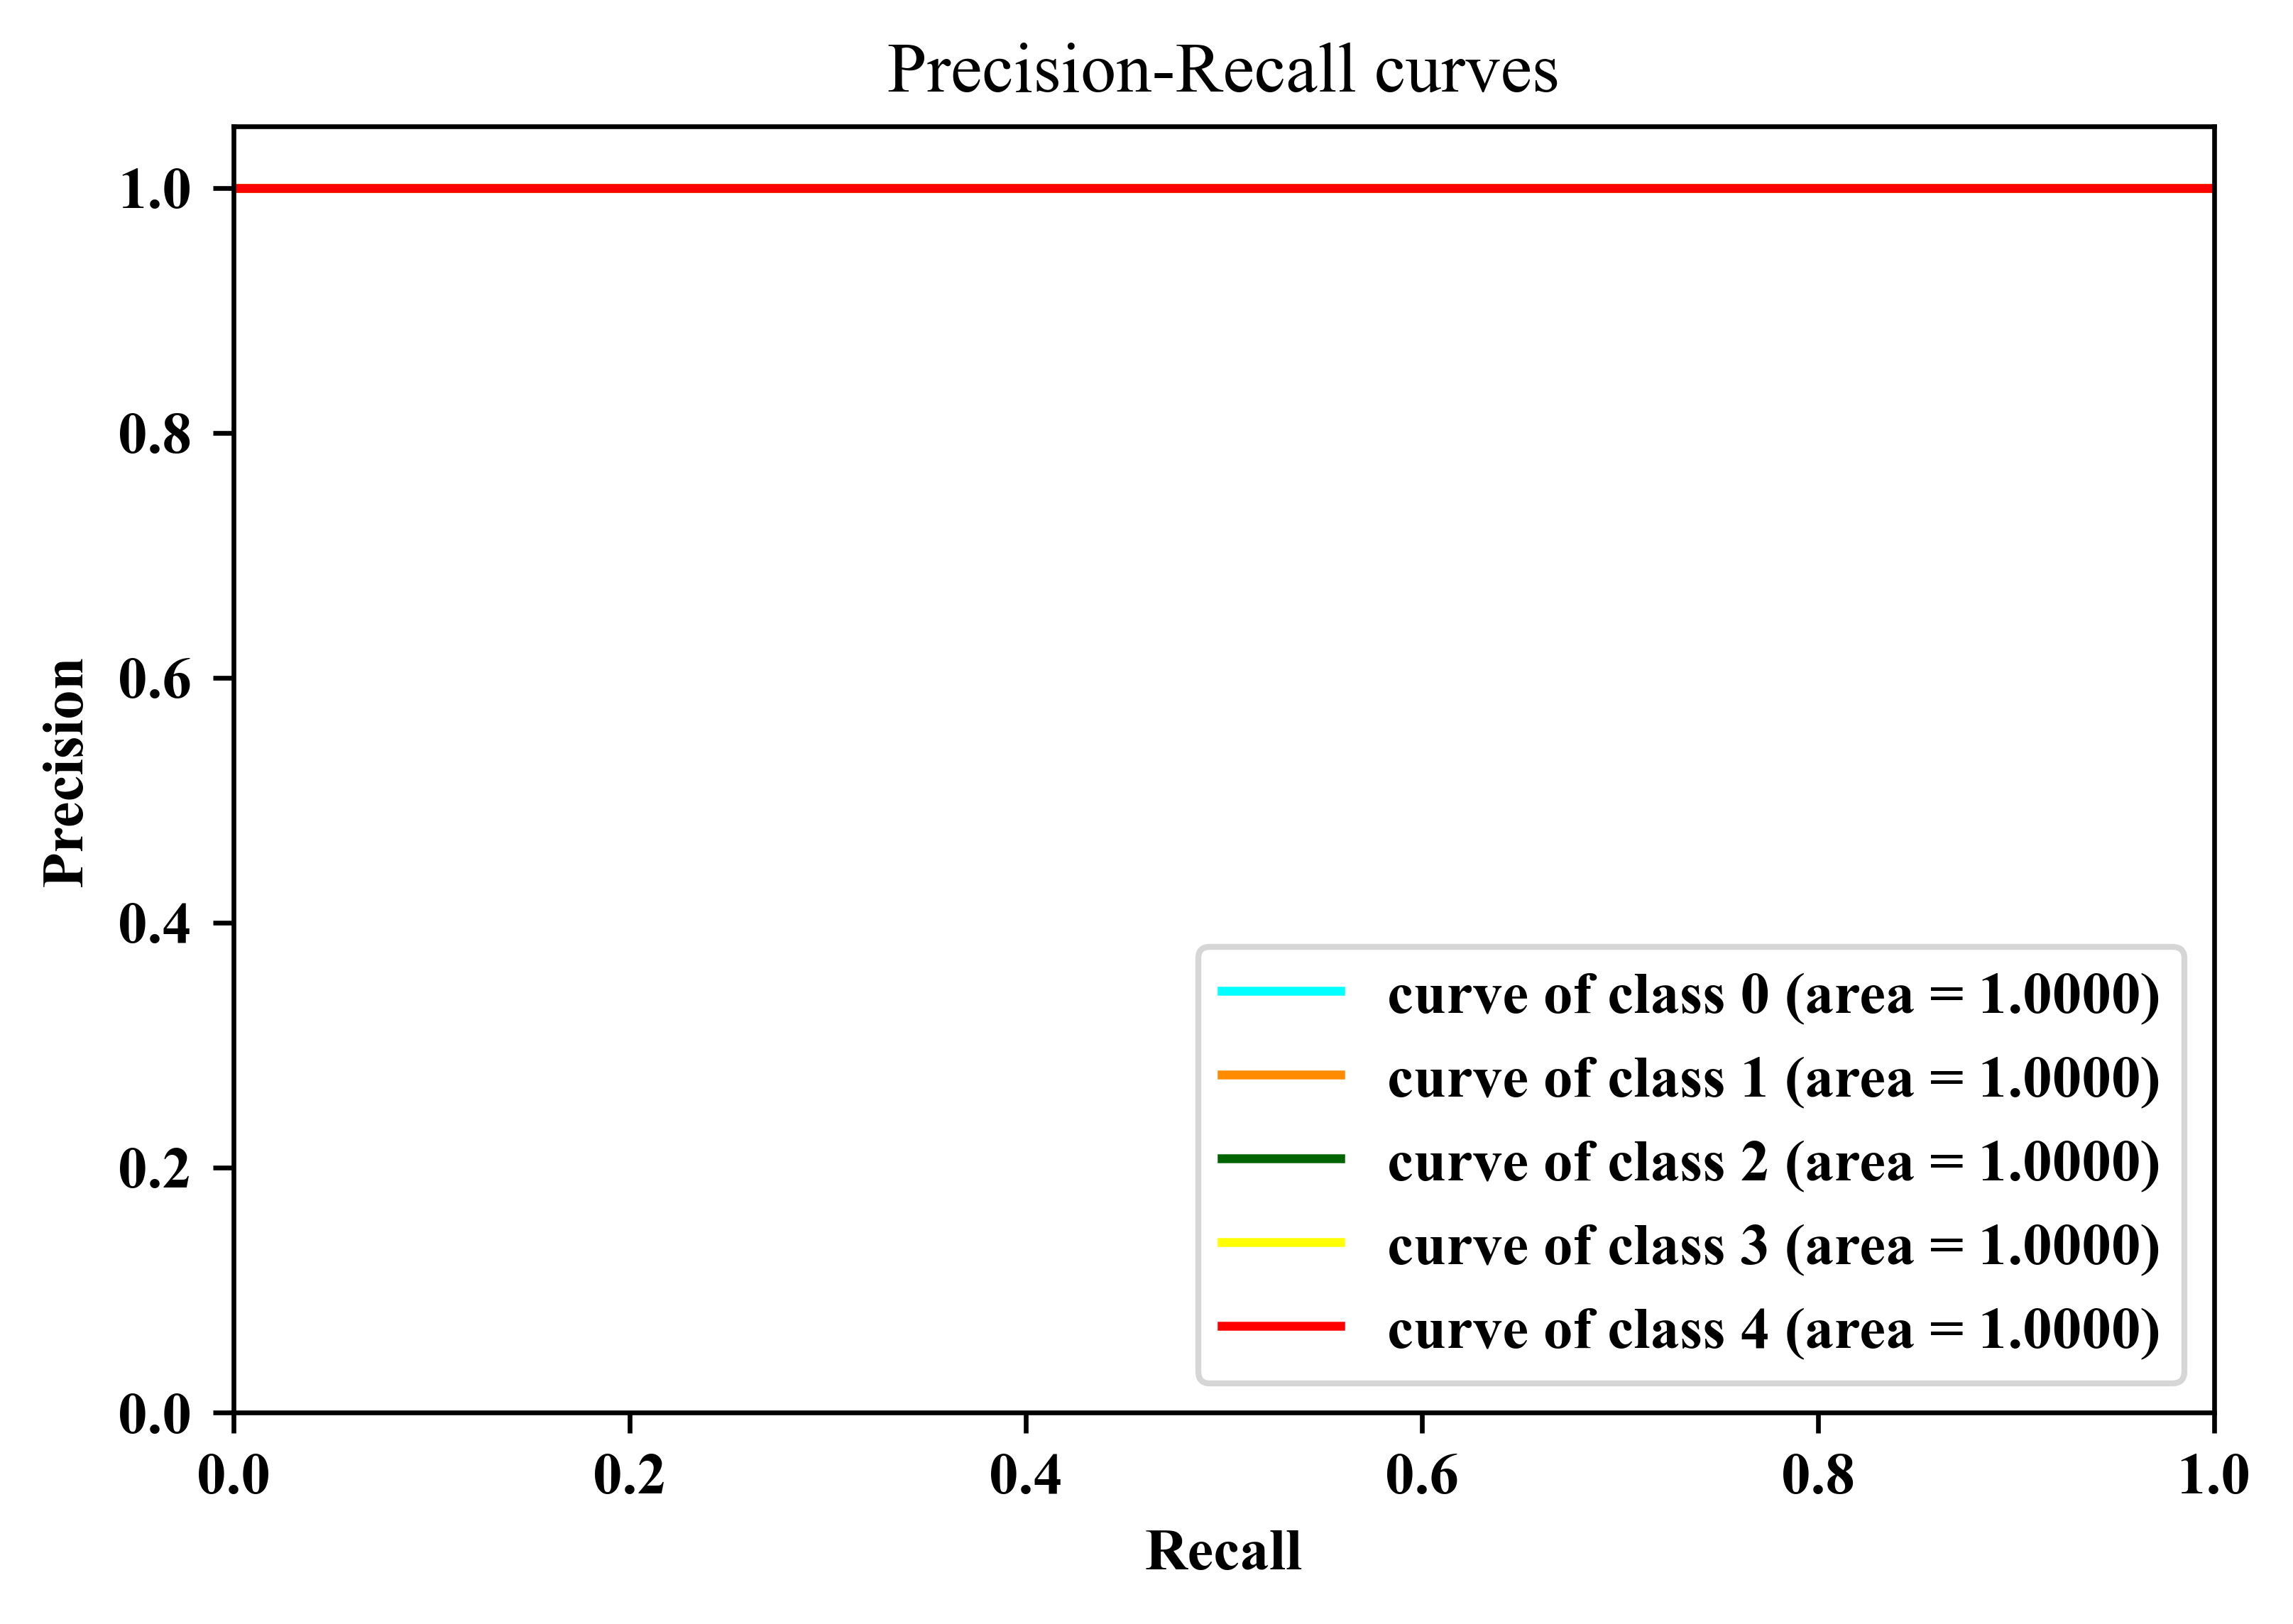

In [13]:
from itertools import cycle
# Compute ROC curve and ROC area for each class
n_classes = 5
# Compute ROC curve and ROC area for each class
# 保存每一类的fpr和tpr值到csv文件，便于后续画图
fpr = dict()
tpr = dict()
roc_auc = dict()
thresholds = dict()
for i in range(n_classes):
    fpr[i], tpr[i], thresholds[i] = metrics.roc_curve(y_test[:, i], test_pre[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    df = pd.DataFrame({'fpr':fpr[i],'tpr':tpr[i]})
    df.to_csv('./Results/intra_adam_woatt_fpr_tpr_{}.csv'.format(i))
# 画图AUC-ROC
plt.figure(dpi=600)
lw = 2
colors = cycle(["aqua", "darkorange", "darkgreen", "yellow", "red", "purple", "blue", "gray"])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
    label="ROC curve of class {0} (area = {1:0.4f})".format(i, roc_auc[i]),)
plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('Multi-class ROC curves')
plt.legend(loc="lower right")
plt.show()



# Compute auc-pr and AP(average precision) for each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = metrics.precision_recall_curve(y_test[:, i], test_pre[:, i])
    average_precision[i] = metrics.average_precision_score(y_test[:, i], test_pre[:, i])
    df = pd.DataFrame({'precision':precision[i],'recall':recall[i]})
    df.to_csv('./Results/intra_adam_woatt_precision_recall_{}.csv'.format(i))
# 绘制所有类别的pr曲线
plt.figure(dpi=600)
lw = 2
colors = cycle(["aqua", "darkorange", "darkgreen", "yellow", "red", "purple", "blue", "gray"])
for i, color in zip(range(n_classes), colors):
    plt.step(recall[i], precision[i], color=color, where="post", label="curve of class {0} (area = {1:0.4f})".format(i, average_precision[i]))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title("Precision-Recall curves")
plt.legend(loc="lower right")
plt.show()   


只包含CNN

In [14]:
num_labels = 5
inputs = Input(name='inputs', shape=[maxLen], dtype='float64')
layer = Embedding(max_words + 1, 128, input_length=maxLen, trainable=True)(inputs)

cnn1 = Convolution1D(64, 3, padding='same', activation='relu')(layer)
cnn1 = MaxPool1D(pool_size=4)(cnn1)
cnn2 = Convolution1D(64, 4, padding='same', activation='relu')(layer)
cnn2 = MaxPool1D(pool_size=4)(cnn2)
cnn3 = Convolution1D(64, 5, padding='same', activation='relu')(layer)
cnn3 = MaxPool1D(pool_size=4)(cnn3)

cnn = concatenate([cnn1, cnn2, cnn3], axis=-1)

flatten = Flatten()(cnn)  # 添加Flatten层，将3D张量展平为1D张量
dense1 = Dense(128, activation='relu')(flatten)
dropout = Dropout(0.3)(dense1)

output = Dense(num_labels, activation='softmax')(dropout)
model = Model(inputs=inputs, outputs=output)
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 10)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 10, 128)      32896       inputs[0][0]                     
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 10, 64)       24640       embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 10, 64)       32832       embedding_1[0][0]                
____________________________________________________________________________________________

In [15]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from sklearn.model_selection import StratifiedKFold
import time


accuracy_score_list,recall_score_list,precision_score_list,f1_score_list = [],[],[],[]
# 编译模型
adam = keras.optimizers.adam_v2.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=["accuracy"])

# 定义5折交叉验证
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 记录开始时间
start_time = time.time()

# 开始交叉验证
for train_index, val_index in kfold.split(trainSeq, np.argmax(y_train,axis=1)):
    X_train_fold, X_val_fold = trainSeq[train_index],trainSeq[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    print(X_train_fold.shape, X_val_fold.shape, y_train_fold.shape, y_val_fold.shape)


    # 训练模型
    history = model.fit(X_train_fold, y_train_fold, epochs=5, batch_size=1024)
    y_pred = model.predict(X_val_fold)
    print(y_pred.shape)
    print(history.history)
    # 评估模型
    AccuracyScore = metrics.accuracy_score(np.argmax(y_val_fold,axis=1),np.argmax(y_pred,axis=1))
    RecallScore = metrics.recall_score(np.argmax(y_val_fold,axis=1),np.argmax(y_pred,axis=1),average='macro')
    PrecisionScore = metrics.precision_score(np.argmax(y_val_fold,axis=1),np.argmax(y_pred,axis=1),average='macro')
    F1Score = metrics.f1_score(np.argmax(y_val_fold,axis=1),np.argmax(y_pred,axis=1),average='macro')
    # 将评估指标存放对应的列表中
    accuracy_score_list.append(AccuracyScore)
    recall_score_list.append(RecallScore)
    precision_score_list.append(PrecisionScore)
    f1_score_list.append(F1Score)
        # 打印每一次训练的正确率、召回率、F1值
    print('accuracy_score:',AccuracyScore,'recall_score:',RecallScore,'precision_score',PrecisionScore,'f1_score:',F1Score)
# 打印各指标的平均值和95%的置信区间
print("Accuracy: %0.4f (+/- %0.4f)" % (np.average(accuracy_score_list), np.std(accuracy_score_list) * 2))
print("Recall: %0.4f (+/- %0.4f)" % (np.average(recall_score_list), np.std(recall_score_list) * 2))
print("Precision: %0.4f (+/- %0.4f)" % (np.average(precision_score_list), np.std(precision_score_list) * 2))
print("F1_score: %0.4f (+/- %0.4f)" % (np.average(f1_score_list), np.std(f1_score_list) * 2))

# 计算总训练时间
end_time = time.time()
elapsed_time = end_time - start_time
average_training_time = elapsed_time / ((len(X_train) * kfold.n_splits))
print("Average Training Time per Data Point: {:.6f} seconds".format(average_training_time))

# 保存模型
model.save('model_intra\cnn.h5')



C:\Users\10105\.conda\envs\tf2\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


(10604464, 10) (2651116, 10) (10604464, 5) (2651116, 5)
Epoch 1/5
10356/10356 [==============================] - 55s 5ms/step - loss: 0.0026 - accuracy: 0.9993
Epoch 2/5
10356/10356 [==============================] - 54s 5ms/step - loss: 2.6058e-05 - accuracy: 1.0000
Epoch 3/5
10356/10356 [==============================] - 54s 5ms/step - loss: 1.3449e-05 - accuracy: 1.0000
Epoch 4/5
10356/10356 [==============================] - 54s 5ms/step - loss: 2.7285e-05 - accuracy: 1.0000
Epoch 5/5
10356/10356 [==============================] - 53s 5ms/step - loss: 1.4676e-05 - accuracy: 1.0000
(2651116, 5)
{'loss': [0.0025984684471040964, 2.6057907234644517e-05, 1.3449347534333356e-05, 2.728543768171221e-05, 1.4675661986984778e-05], 'accuracy': [0.9993140697479248, 0.9999948143959045, 0.9999979138374329, 0.9999979138374329, 0.9999982118606567]}
accuracy_score: 0.9999996228003603 recall_score: 0.9999974578640973 precision_score 0.9999999122112022 f1_score: 0.999998685029562
(10604464, 10) (26511

In [16]:
print("模型预测")
mainModel = load_model('model_intra\cnn.h5', compile=False)
# 预测


模型预测


Average Prediction Time per Data Point: 0.000037 seconds
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000   2846990
           1     1.0000    1.0000    1.0000    131324
           2     1.0000    1.0000    1.0000    119707
           3     1.0000    1.0000    1.0000     98475
           4     1.0000    1.0000    1.0000    117399

    accuracy                         1.0000   3313895
   macro avg     1.0000    1.0000    1.0000   3313895
weighted avg     1.0000    1.0000    1.0000   3313895

Accuracy:1.0000
MCC:1.0000
Kappa:1.0000
False Positive Rate (Benign samples misclassified as attacks): 0.0000


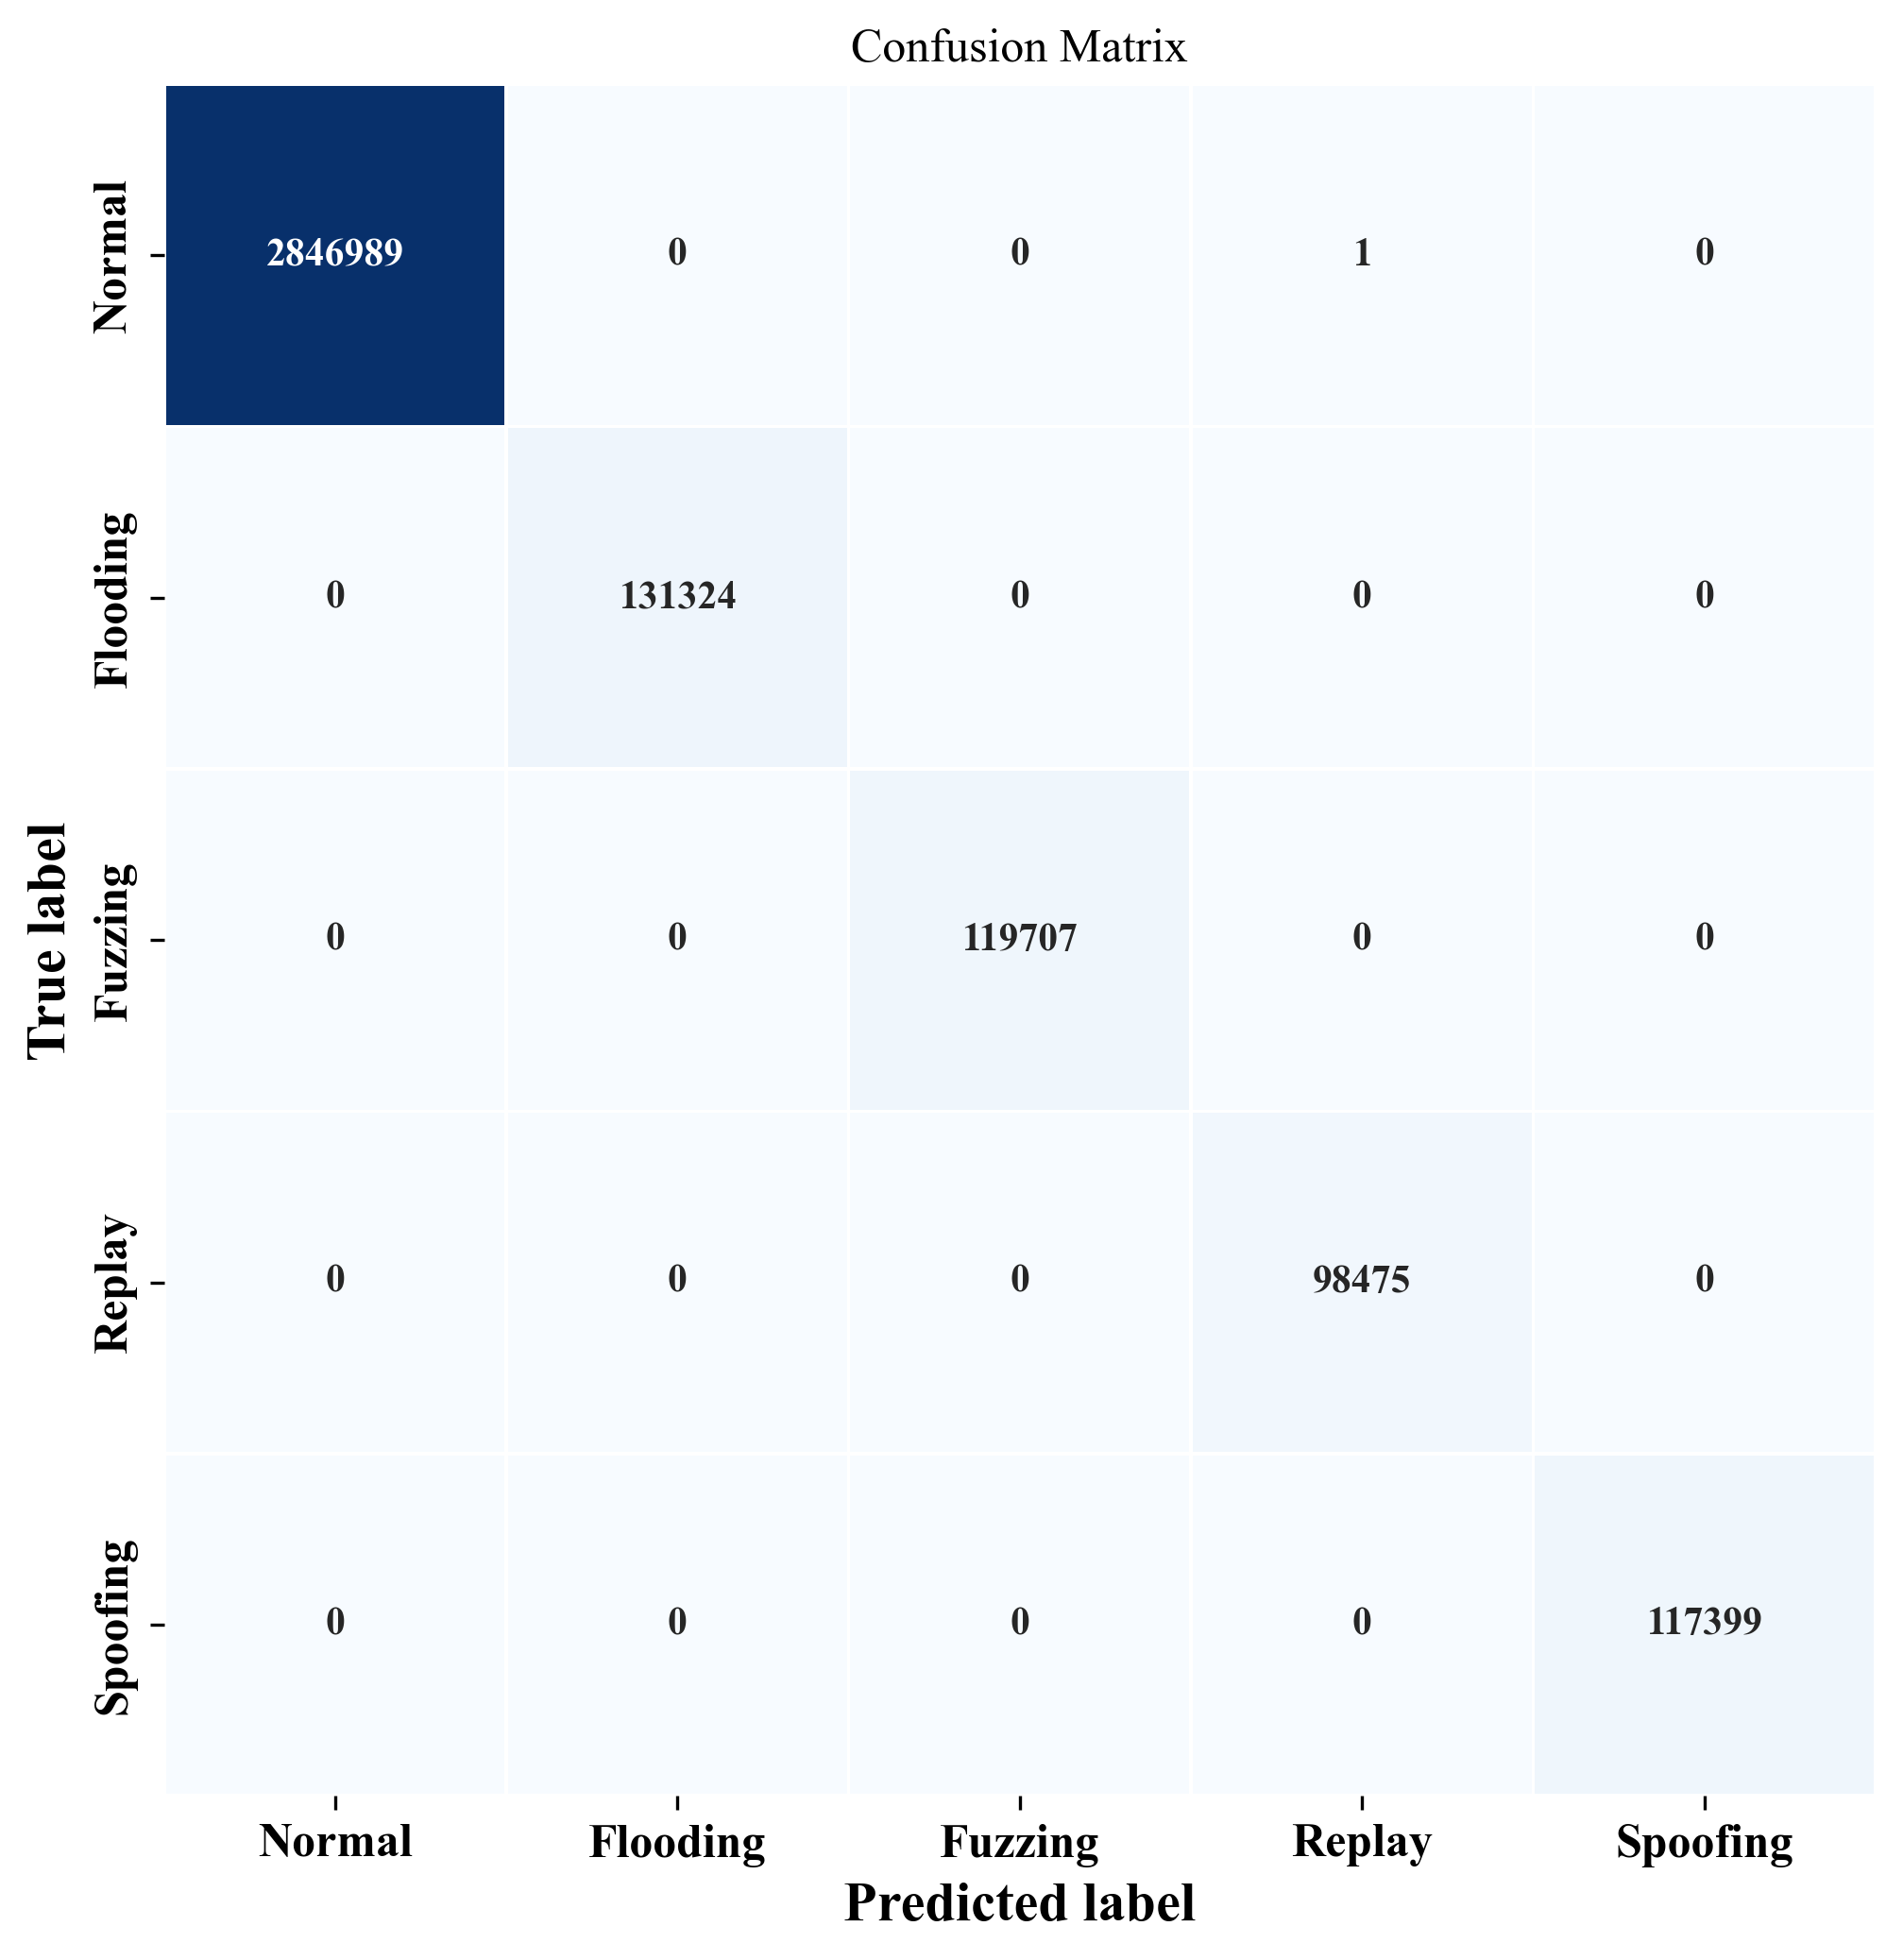

In [17]:
# 计算预测时间
start_time = time.time()  # 记录开始时间
test_pre = mainModel.predict(testSeq)
end_time = time.time()  # 记录结束时间
average_prediction_time = (end_time - start_time) / len(testSeq)
print("Average Prediction Time per Data Point: {:.6f} seconds".format(average_prediction_time))

# 计算混淆矩阵
confm = metrics.confusion_matrix(np.argmax(y_test, axis=1), np.argmax(test_pre, axis=1))
# 计算classification_report
print(metrics.classification_report(np.argmax(y_test, axis=1),
                                    np.argmax(test_pre, axis=1),
                                    digits=4))
# 计算准确度
accuracy = metrics.accuracy_score(np.argmax(y_test, axis=1),
                                          np.argmax(test_pre, axis=1))
print("Accuracy:{:.4f}".format(accuracy))
# 计算MCC
mcc = metrics.matthews_corrcoef(np.argmax(y_test, axis=1),
                                          np.argmax(test_pre, axis=1))
print("MCC:{:.4f}".format(mcc))
# 计算kappa
kappa = metrics.cohen_kappa_score(np.argmax(y_test, axis=1),
                                          np.argmax(test_pre, axis=1))
print("Kappa:{:.4f}".format(kappa))
# 计算误报率（False Positive Rate）
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(test_pre, axis=1)
false_positives = np.sum((y_true == 0) & (y_pred != 0))  # 0 represents the "Benign" class
total_benign_samples = np.sum(y_true == 0)
false_positive_rate = false_positives / total_benign_samples
print("False Positive Rate (Benign samples misclassified as attacks): {:.4f}".format(false_positive_rate))

# 画图
#设置所有图片的字体大小为10，字体为Times New Roman，字体为粗体，label的字体大小为10，字体为Times New Roman，字体为粗体
plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'

plt.figure(figsize=(8, 8), dpi=300)
sns.heatmap(confm, square=True, annot=True,
            fmt='d', cbar=False, linewidths=.6,
            cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted label', size=14)
plt.ylabel('True label', size=14)
Labname = ['Normal', 'Flooding', 'Fuzzing', 'Replay', 'Spoofing']   #行列名
plt.xticks(np.arange(5)+0.5, Labname, size = 12)
plt.yticks(np.arange(5)+0.5, Labname, size = 12)
plt.show()


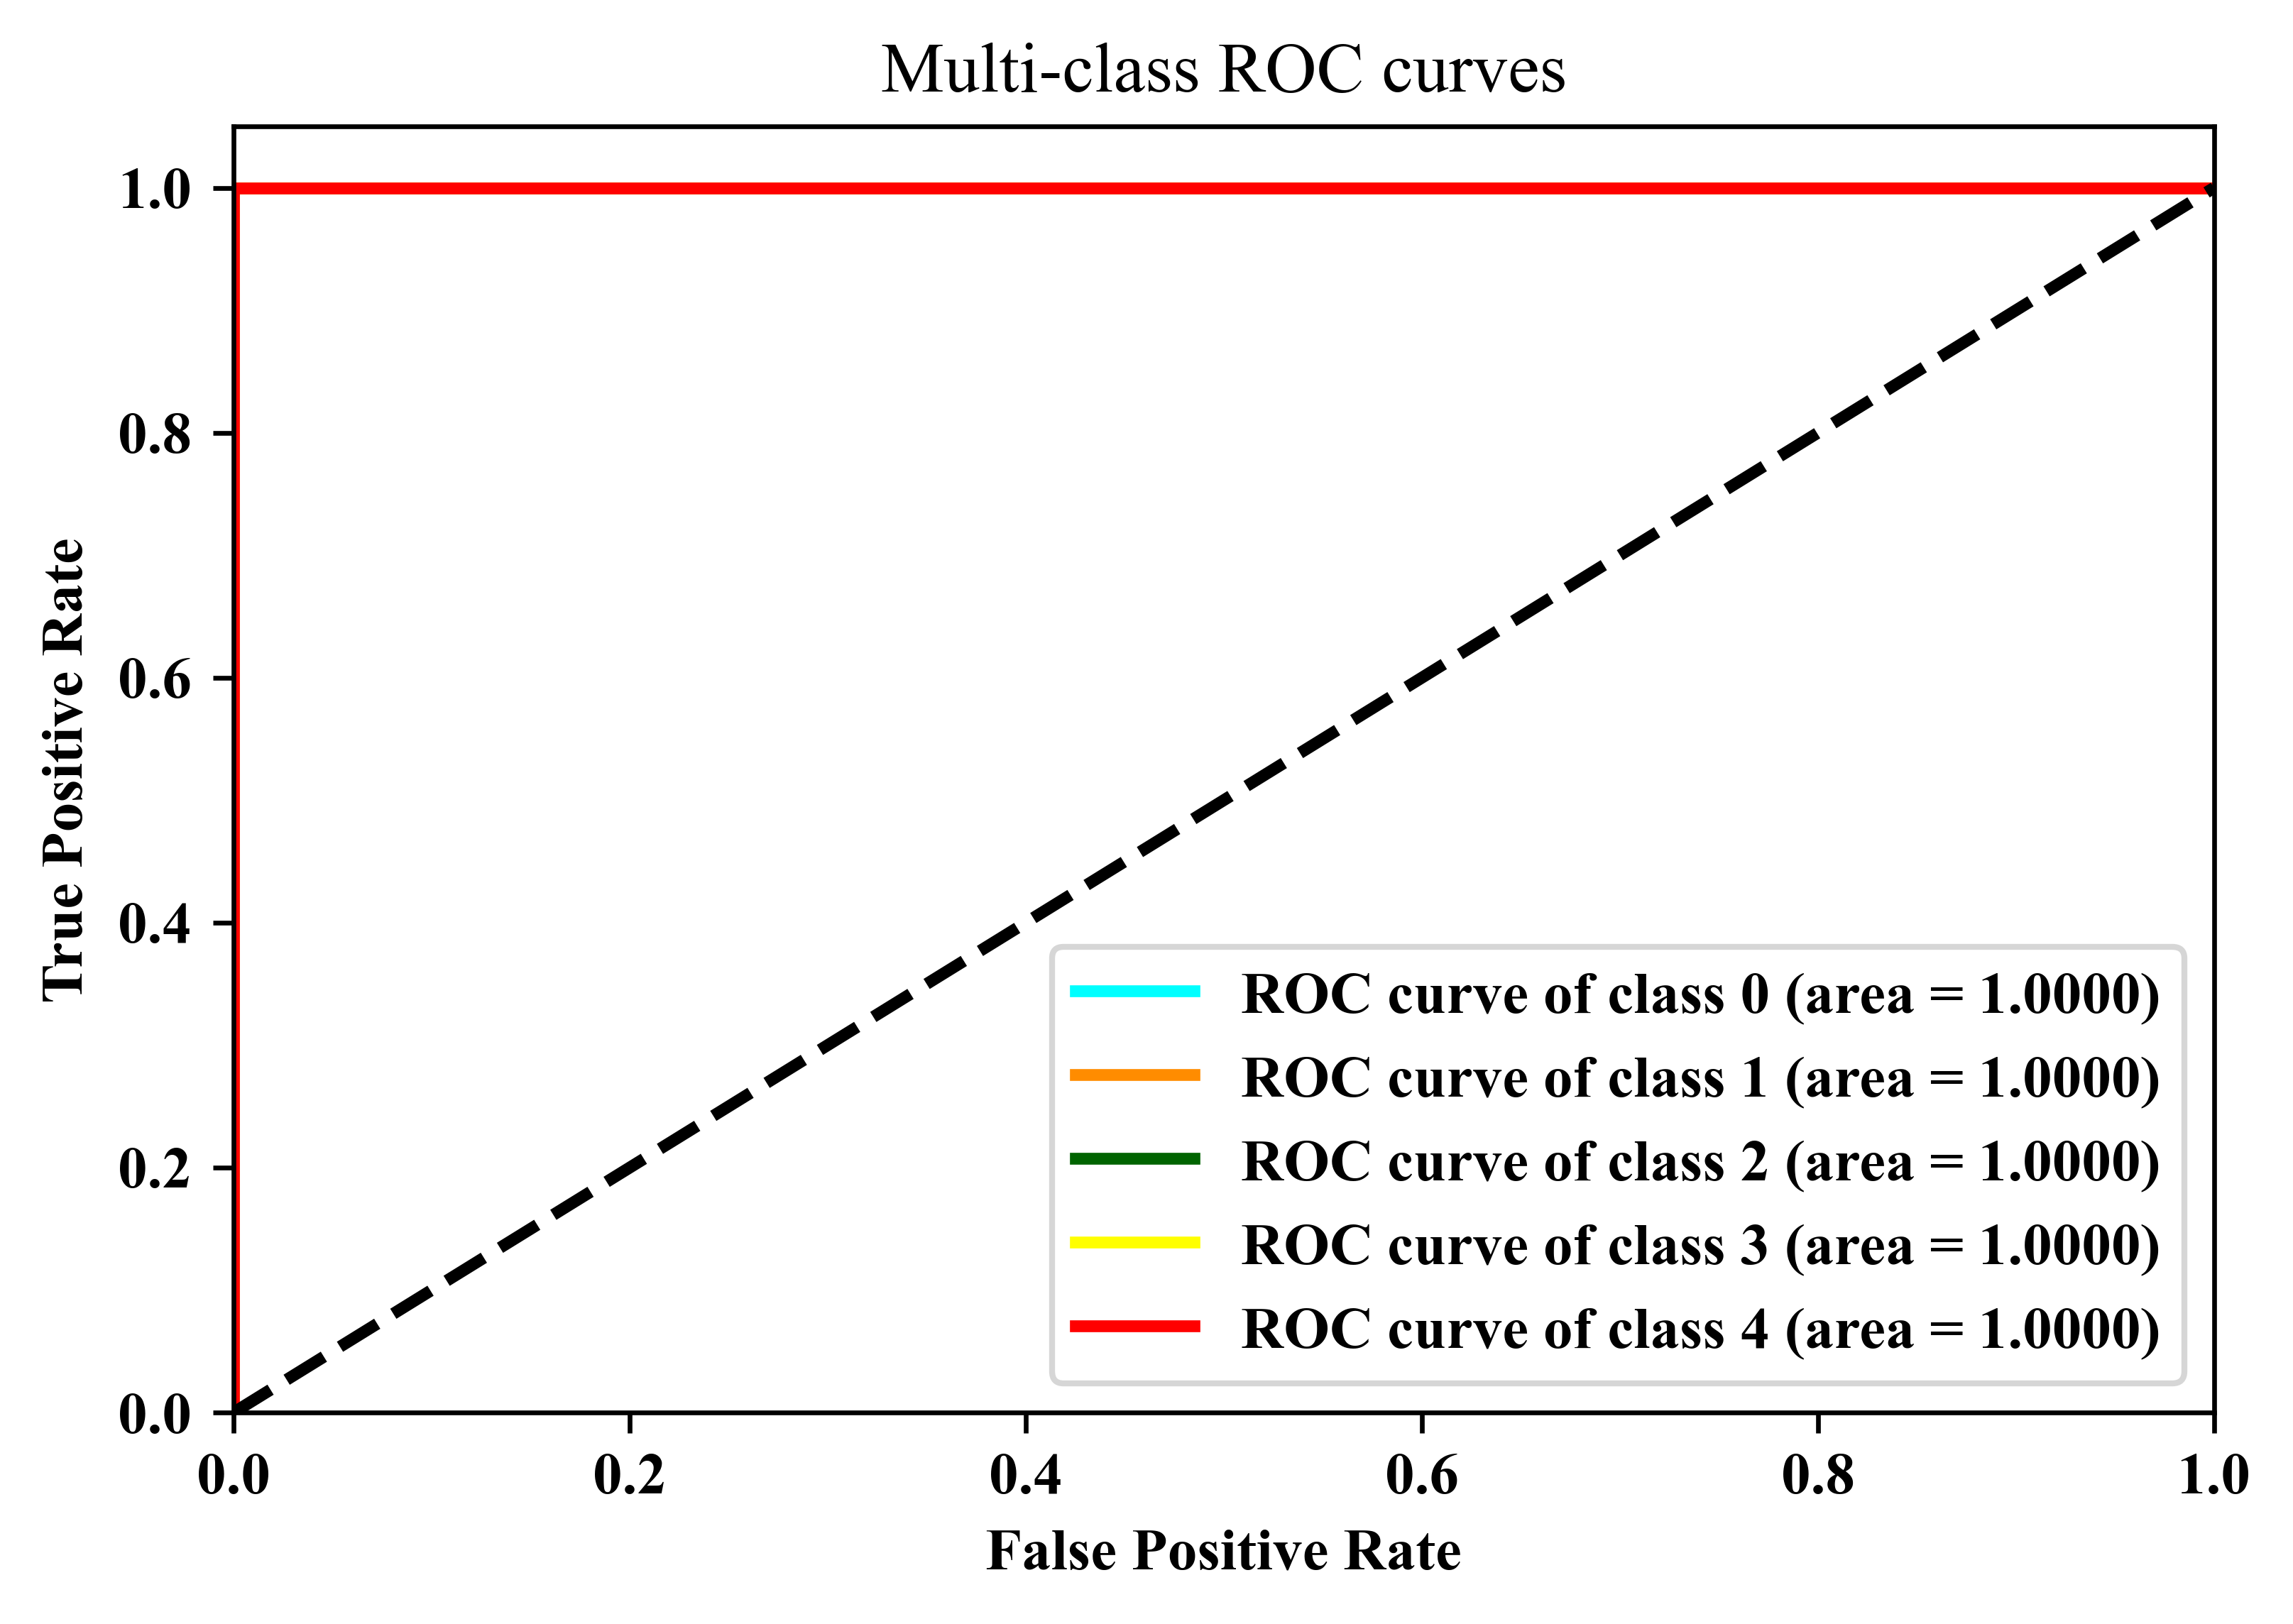

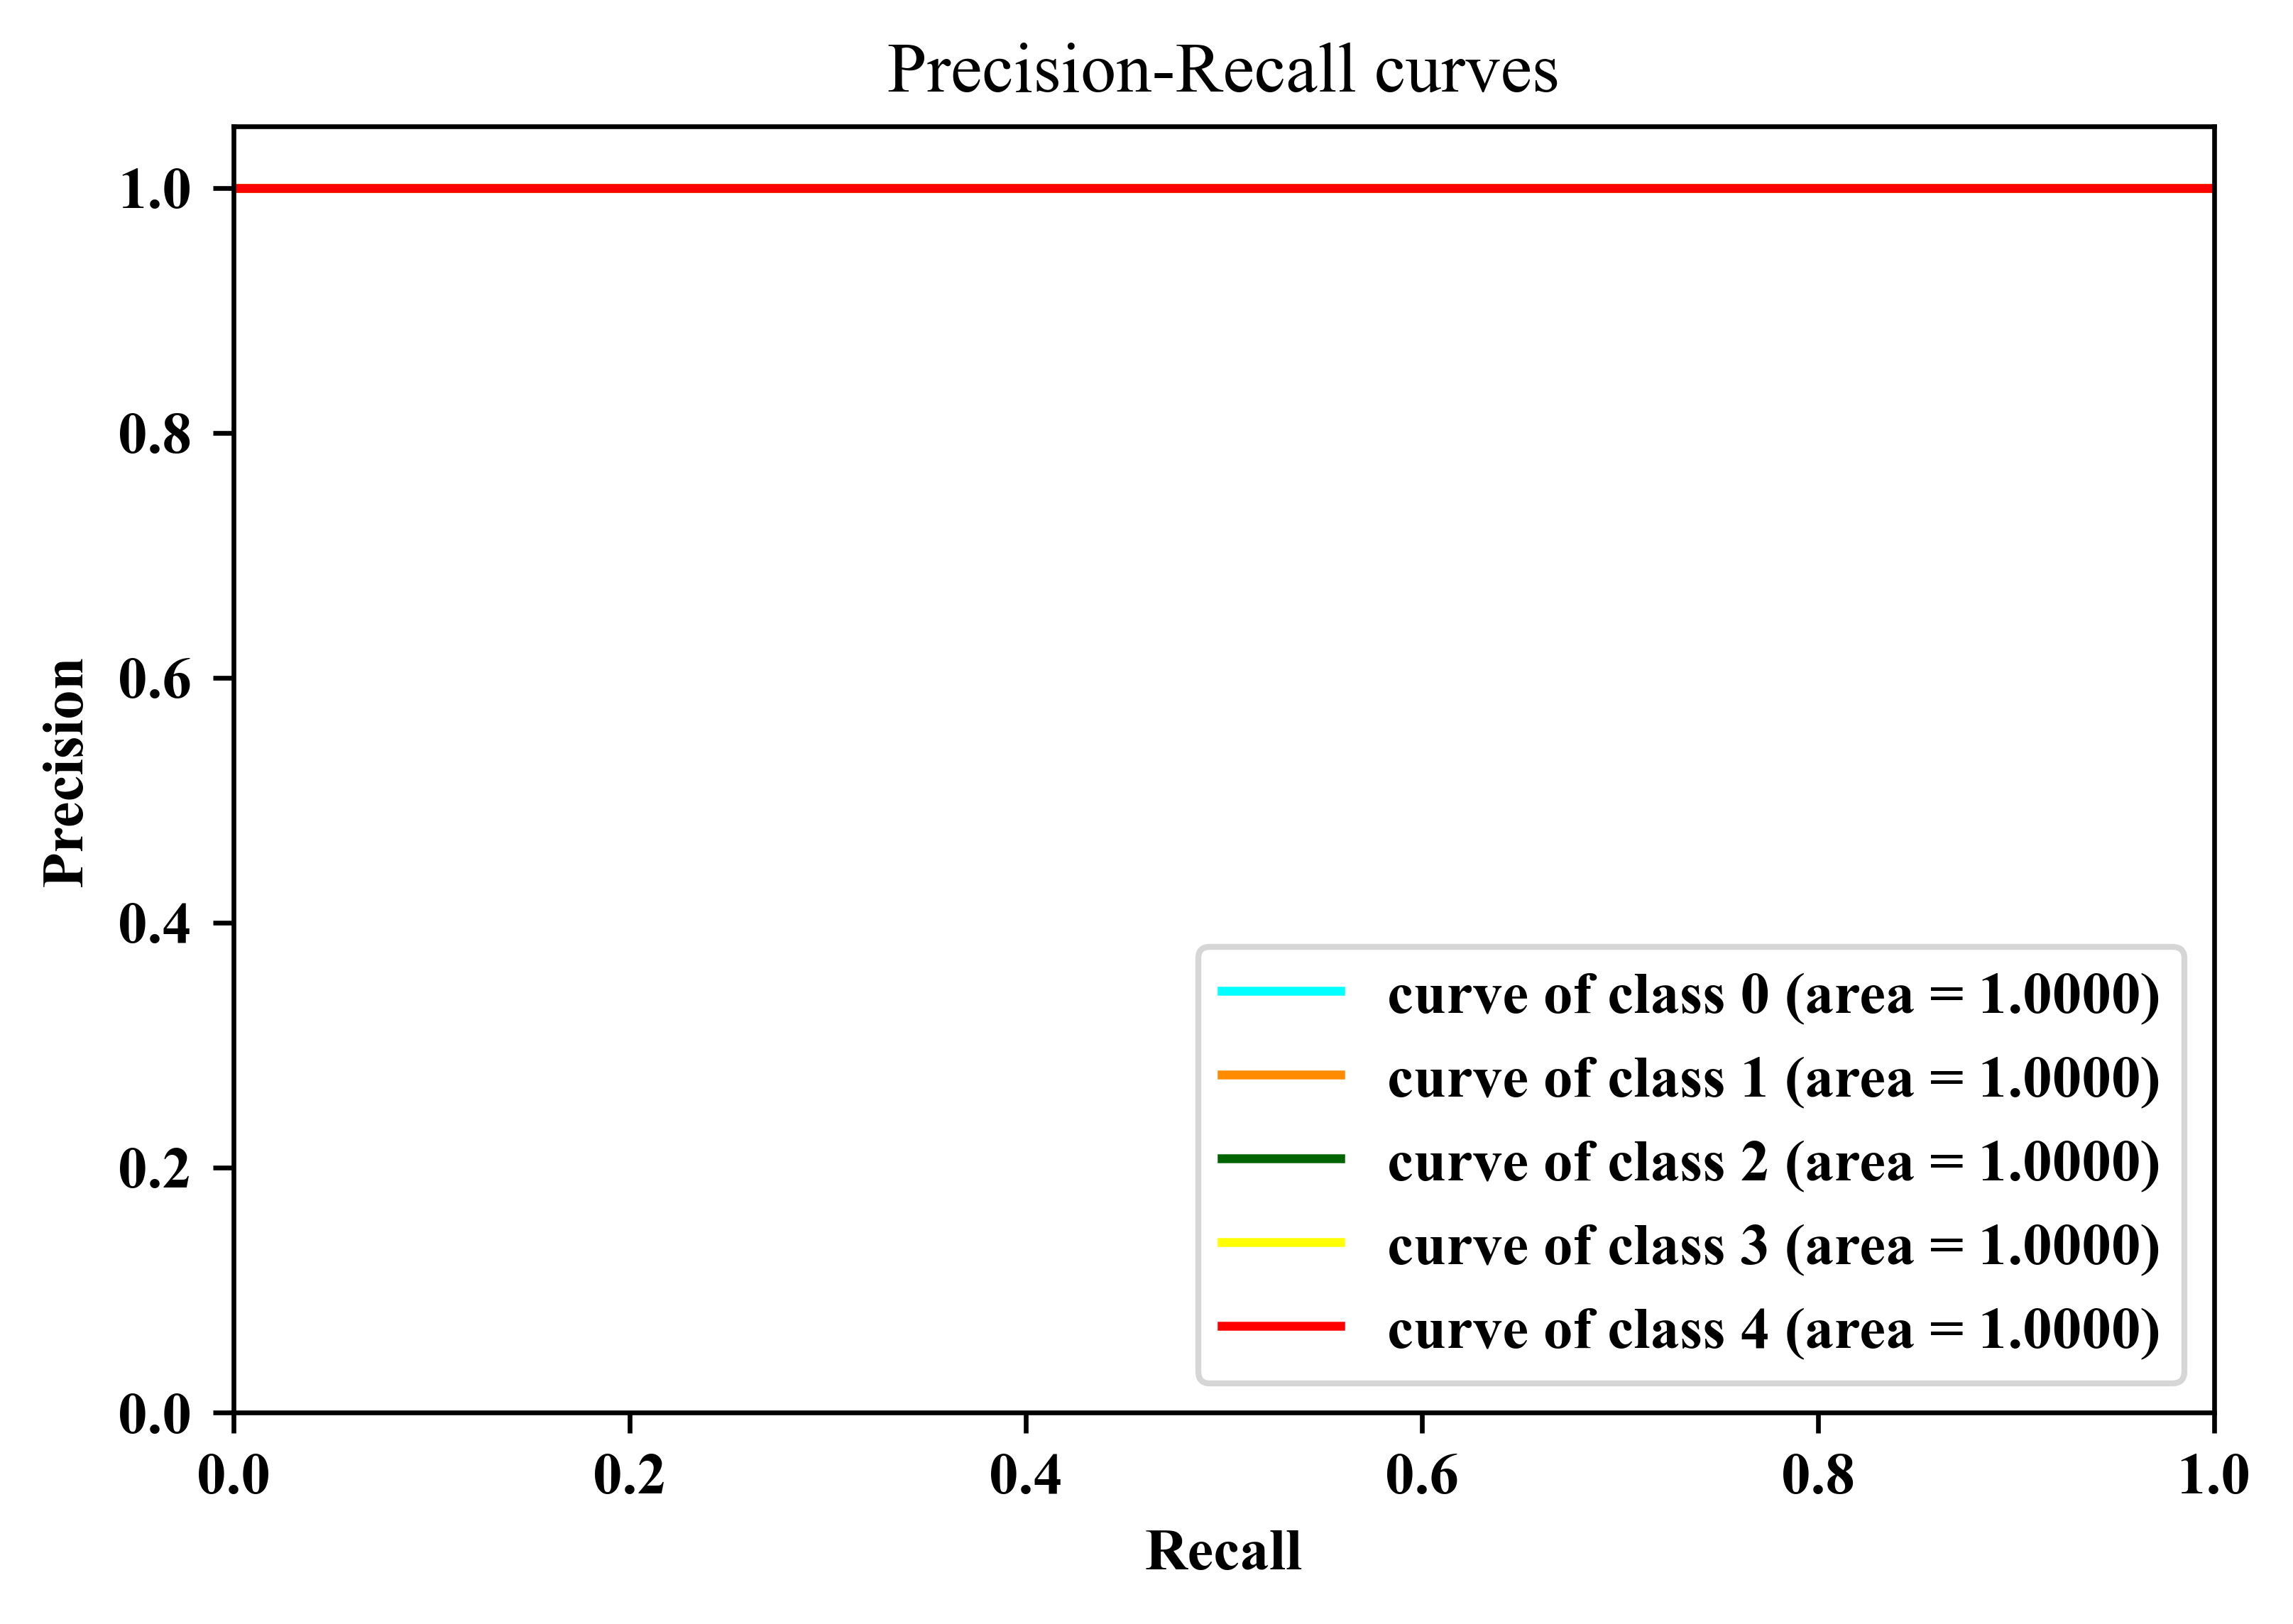

In [18]:
from itertools import cycle
# Compute ROC curve and ROC area for each class
n_classes = 5
# Compute ROC curve and ROC area for each class
# 保存每一类的fpr和tpr值到csv文件，便于后续画图
fpr = dict()
tpr = dict()
roc_auc = dict()
thresholds = dict()
for i in range(n_classes):
    fpr[i], tpr[i], thresholds[i] = metrics.roc_curve(y_test[:, i], test_pre[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    df = pd.DataFrame({'fpr':fpr[i],'tpr':tpr[i]})
    df.to_csv('./Results/intra_adam_cnn_fpr_tpr_{}.csv'.format(i))
# 画图AUC-ROC
plt.figure(dpi=600)
lw = 2
colors = cycle(["aqua", "darkorange", "darkgreen", "yellow", "red", "purple", "blue", "gray"])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
    label="ROC curve of class {0} (area = {1:0.4f})".format(i, roc_auc[i]),)
plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('Multi-class ROC curves')
plt.legend(loc="lower right")
plt.show()



# Compute auc-pr and AP(average precision) for each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = metrics.precision_recall_curve(y_test[:, i], test_pre[:, i])
    average_precision[i] = metrics.average_precision_score(y_test[:, i], test_pre[:, i])
    df = pd.DataFrame({'precision':precision[i],'recall':recall[i]})
    df.to_csv('./Results/intra_adam_cnn_precision_recall_{}.csv'.format(i))
# 绘制所有类别的pr曲线
plt.figure(dpi=600)
lw = 2
colors = cycle(["aqua", "darkorange", "darkgreen", "yellow", "red", "purple", "blue", "gray"])
for i, color in zip(range(n_classes), colors):
    plt.step(recall[i], precision[i], color=color, where="post", label="curve of class {0} (area = {1:0.4f})".format(i, average_precision[i]))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title("Precision-Recall curves")
plt.legend(loc="lower right")
plt.show()   


只包含BiLSTM

In [19]:
inputs = Input(name='inputs', shape=[maxLen], dtype='float64')
layer = Embedding(max_words + 1, 128, input_length=maxLen, trainable=True)(inputs)

bilstm = Bidirectional(LSTM(128, return_sequences=False))(layer)
dense1 = Dense(128, activation='relu')(bilstm)
dropout = Dropout(0.3)(dense1)

output = Dense(num_labels, activation='softmax')(dropout)
model = Model(inputs=inputs, outputs=output)
model.summary()


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 10)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 10, 128)           32896     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               263168    
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 645       
Total params: 329,605
Trainable params: 329,605
Non-trainable params: 0
_____________________________________________________

In [20]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from sklearn.model_selection import StratifiedKFold
import time


accuracy_score_list,recall_score_list,precision_score_list,f1_score_list = [],[],[],[]
# 编译模型
adam = keras.optimizers.adam_v2.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=["accuracy"])

# 定义5折交叉验证
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 记录开始时间
start_time = time.time()

# 开始交叉验证
for train_index, val_index in kfold.split(trainSeq, np.argmax(y_train,axis=1)):
    X_train_fold, X_val_fold = trainSeq[train_index],trainSeq[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    print(X_train_fold.shape, X_val_fold.shape, y_train_fold.shape, y_val_fold.shape)


    # 训练模型
    history = model.fit(X_train_fold, y_train_fold, epochs=5, batch_size=1024)
    y_pred = model.predict(X_val_fold)
    print(y_pred.shape)
    print(history.history)
    # 评估模型
    AccuracyScore = metrics.accuracy_score(np.argmax(y_val_fold,axis=1),np.argmax(y_pred,axis=1))
    RecallScore = metrics.recall_score(np.argmax(y_val_fold,axis=1),np.argmax(y_pred,axis=1),average='macro')
    PrecisionScore = metrics.precision_score(np.argmax(y_val_fold,axis=1),np.argmax(y_pred,axis=1),average='macro')
    F1Score = metrics.f1_score(np.argmax(y_val_fold,axis=1),np.argmax(y_pred,axis=1),average='macro')
    # 将评估指标存放对应的列表中
    accuracy_score_list.append(AccuracyScore)
    recall_score_list.append(RecallScore)
    precision_score_list.append(PrecisionScore)
    f1_score_list.append(F1Score)
        # 打印每一次训练的正确率、召回率、F1值
    print('accuracy_score:',AccuracyScore,'recall_score:',RecallScore,'precision_score',PrecisionScore,'f1_score:',F1Score)
# 打印各指标的平均值和95%的置信区间
print("Accuracy: %0.4f (+/- %0.4f)" % (np.average(accuracy_score_list), np.std(accuracy_score_list) * 2))
print("Recall: %0.4f (+/- %0.4f)" % (np.average(recall_score_list), np.std(recall_score_list) * 2))
print("Precision: %0.4f (+/- %0.4f)" % (np.average(precision_score_list), np.std(precision_score_list) * 2))
print("F1_score: %0.4f (+/- %0.4f)" % (np.average(f1_score_list), np.std(f1_score_list) * 2))

# 计算总训练时间
end_time = time.time()
elapsed_time = end_time - start_time
average_training_time = elapsed_time / ((len(X_train) * kfold.n_splits))
print("Average Training Time per Data Point: {:.6f} seconds".format(average_training_time))




C:\Users\10105\.conda\envs\tf2\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


(10604464, 10) (2651116, 10) (10604464, 5) (2651116, 5)
Epoch 1/5
10356/10356 [==============================] - 62s 6ms/step - loss: 0.0042 - accuracy: 0.9990
Epoch 2/5
10356/10356 [==============================] - 60s 6ms/step - loss: 7.5066e-05 - accuracy: 1.0000
Epoch 3/5
10356/10356 [==============================] - 60s 6ms/step - loss: 2.0642e-05 - accuracy: 1.0000
Epoch 4/5
10356/10356 [==============================] - 61s 6ms/step - loss: 1.2400e-05 - accuracy: 1.0000
Epoch 5/5
10356/10356 [==============================] - 61s 6ms/step - loss: 8.9331e-06 - accuracy: 1.0000
(2651116, 5)
{'loss': [0.004231295082718134, 7.506629481213167e-05, 2.064208638330456e-05, 1.2399503248161636e-05, 8.93307696969714e-06], 'accuracy': [0.9990346431732178, 0.9999918937683105, 0.9999954700469971, 0.9999982118606567, 0.9999986886978149]}
accuracy_score: 0.9999988684010809 recall_score: 0.9999923735922923 precision_score 0.999999736633838 f1_score: 0.9999960550402743
(10604464, 10) (2651116, 

OSError: Unable to create file (unable to open file: name = 'model_intrailstm.h5', errno = 22, error message = 'Invalid argument', flags = 13, o_flags = 302)

In [23]:

# 保存模型
model.save('model_intra\\bilstm.h5')

In [24]:
print("模型预测")
mainModel = load_model('model_intra\\bilstm.h5', compile=False)
# 预测


模型预测


Average Prediction Time per Data Point: 0.000061 seconds
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000   2846990
           1     1.0000    1.0000    1.0000    131324
           2     1.0000    1.0000    1.0000    119707
           3     1.0000    1.0000    1.0000     98475
           4     1.0000    1.0000    1.0000    117399

    accuracy                         1.0000   3313895
   macro avg     1.0000    1.0000    1.0000   3313895
weighted avg     1.0000    1.0000    1.0000   3313895

Accuracy:1.0000
MCC:1.0000
Kappa:1.0000
False Positive Rate (Benign samples misclassified as attacks): 0.0000


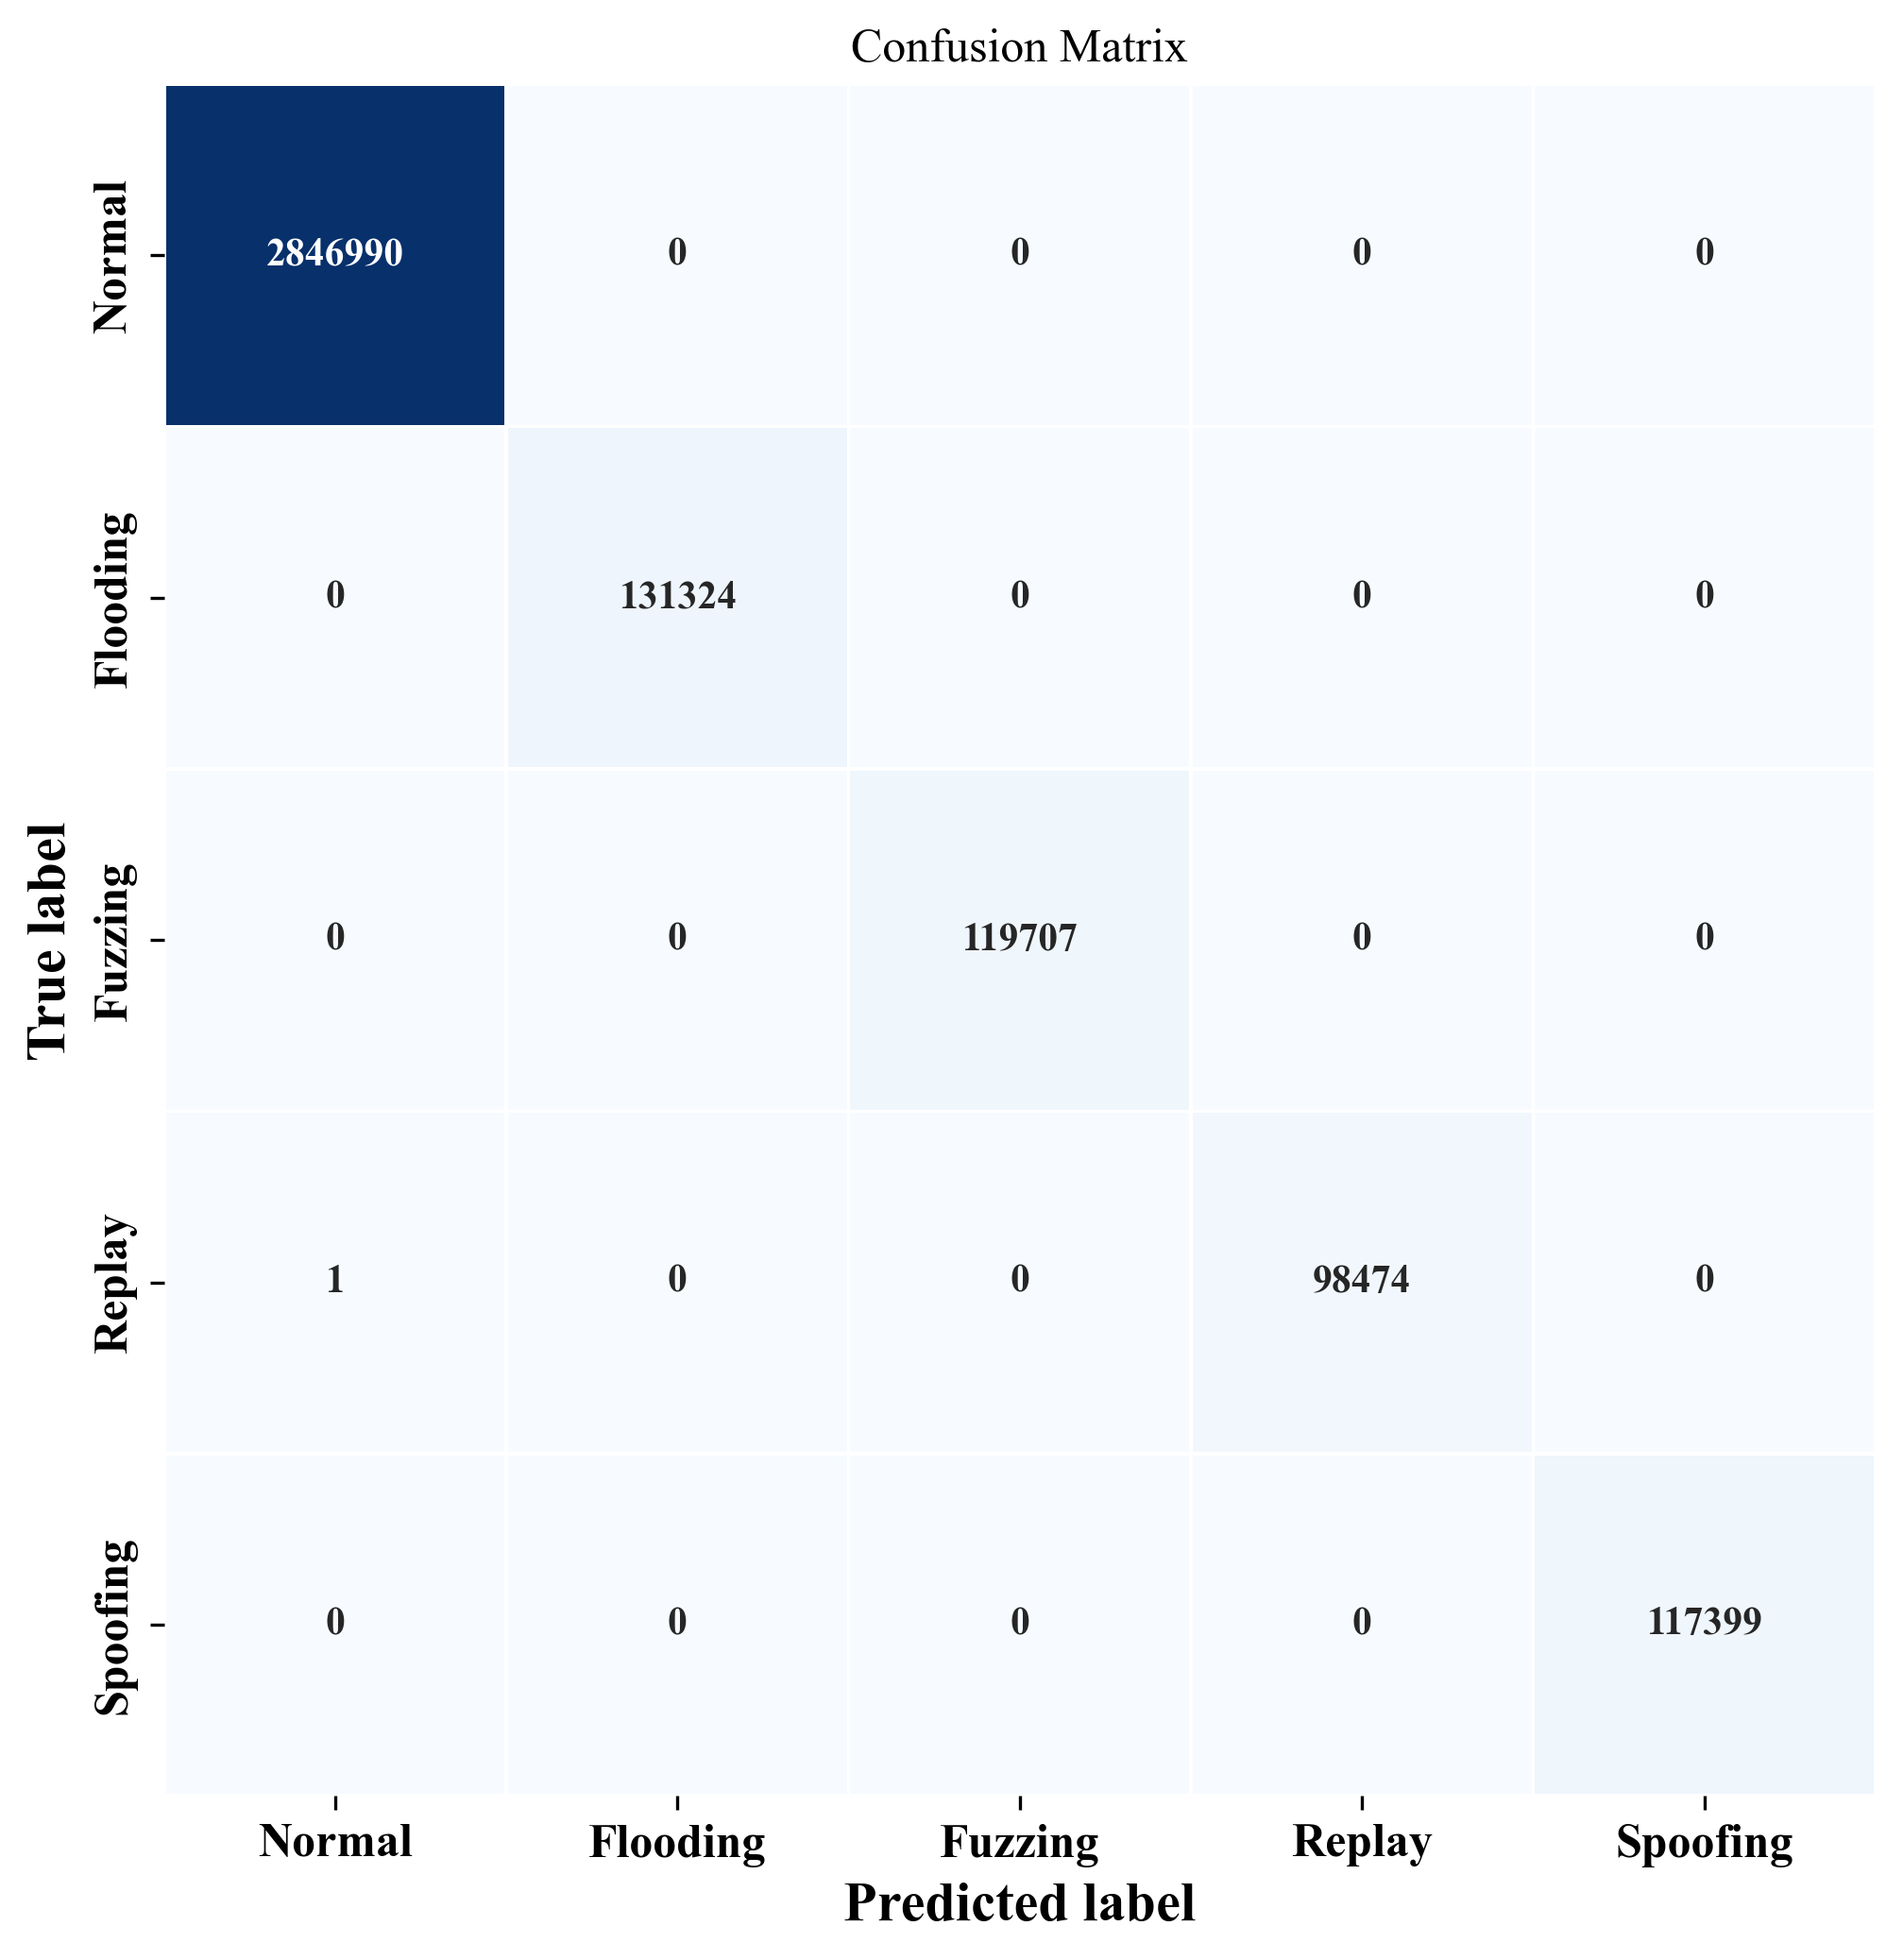

In [25]:
# 计算预测时间
start_time = time.time()  # 记录开始时间
test_pre = mainModel.predict(testSeq)
end_time = time.time()  # 记录结束时间
average_prediction_time = (end_time - start_time) / len(testSeq)
print("Average Prediction Time per Data Point: {:.6f} seconds".format(average_prediction_time))

# 计算混淆矩阵
confm = metrics.confusion_matrix(np.argmax(y_test, axis=1), np.argmax(test_pre, axis=1))
# 计算classification_report
print(metrics.classification_report(np.argmax(y_test, axis=1),
                                    np.argmax(test_pre, axis=1),
                                    digits=4))
# 计算准确度
accuracy = metrics.accuracy_score(np.argmax(y_test, axis=1),
                                          np.argmax(test_pre, axis=1))
print("Accuracy:{:.4f}".format(accuracy))
# 计算MCC
mcc = metrics.matthews_corrcoef(np.argmax(y_test, axis=1),
                                          np.argmax(test_pre, axis=1))
print("MCC:{:.4f}".format(mcc))
# 计算kappa
kappa = metrics.cohen_kappa_score(np.argmax(y_test, axis=1),
                                          np.argmax(test_pre, axis=1))
print("Kappa:{:.4f}".format(kappa))
# 计算误报率（False Positive Rate）
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(test_pre, axis=1)
false_positives = np.sum((y_true == 0) & (y_pred != 0))  # 0 represents the "Benign" class
total_benign_samples = np.sum(y_true == 0)
false_positive_rate = false_positives / total_benign_samples
print("False Positive Rate (Benign samples misclassified as attacks): {:.4f}".format(false_positive_rate))

# 画图
#设置所有图片的字体大小为10，字体为Times New Roman，字体为粗体，label的字体大小为10，字体为Times New Roman，字体为粗体
plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'

plt.figure(figsize=(8, 8), dpi=300)
sns.heatmap(confm, square=True, annot=True,
            fmt='d', cbar=False, linewidths=.6,
            cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted label', size=14)
plt.ylabel('True label', size=14)
Labname = ['Normal', 'Flooding', 'Fuzzing', 'Replay', 'Spoofing']   #行列名
plt.xticks(np.arange(5)+0.5, Labname, size = 12)
plt.yticks(np.arange(5)+0.5, Labname, size = 12)
plt.show()


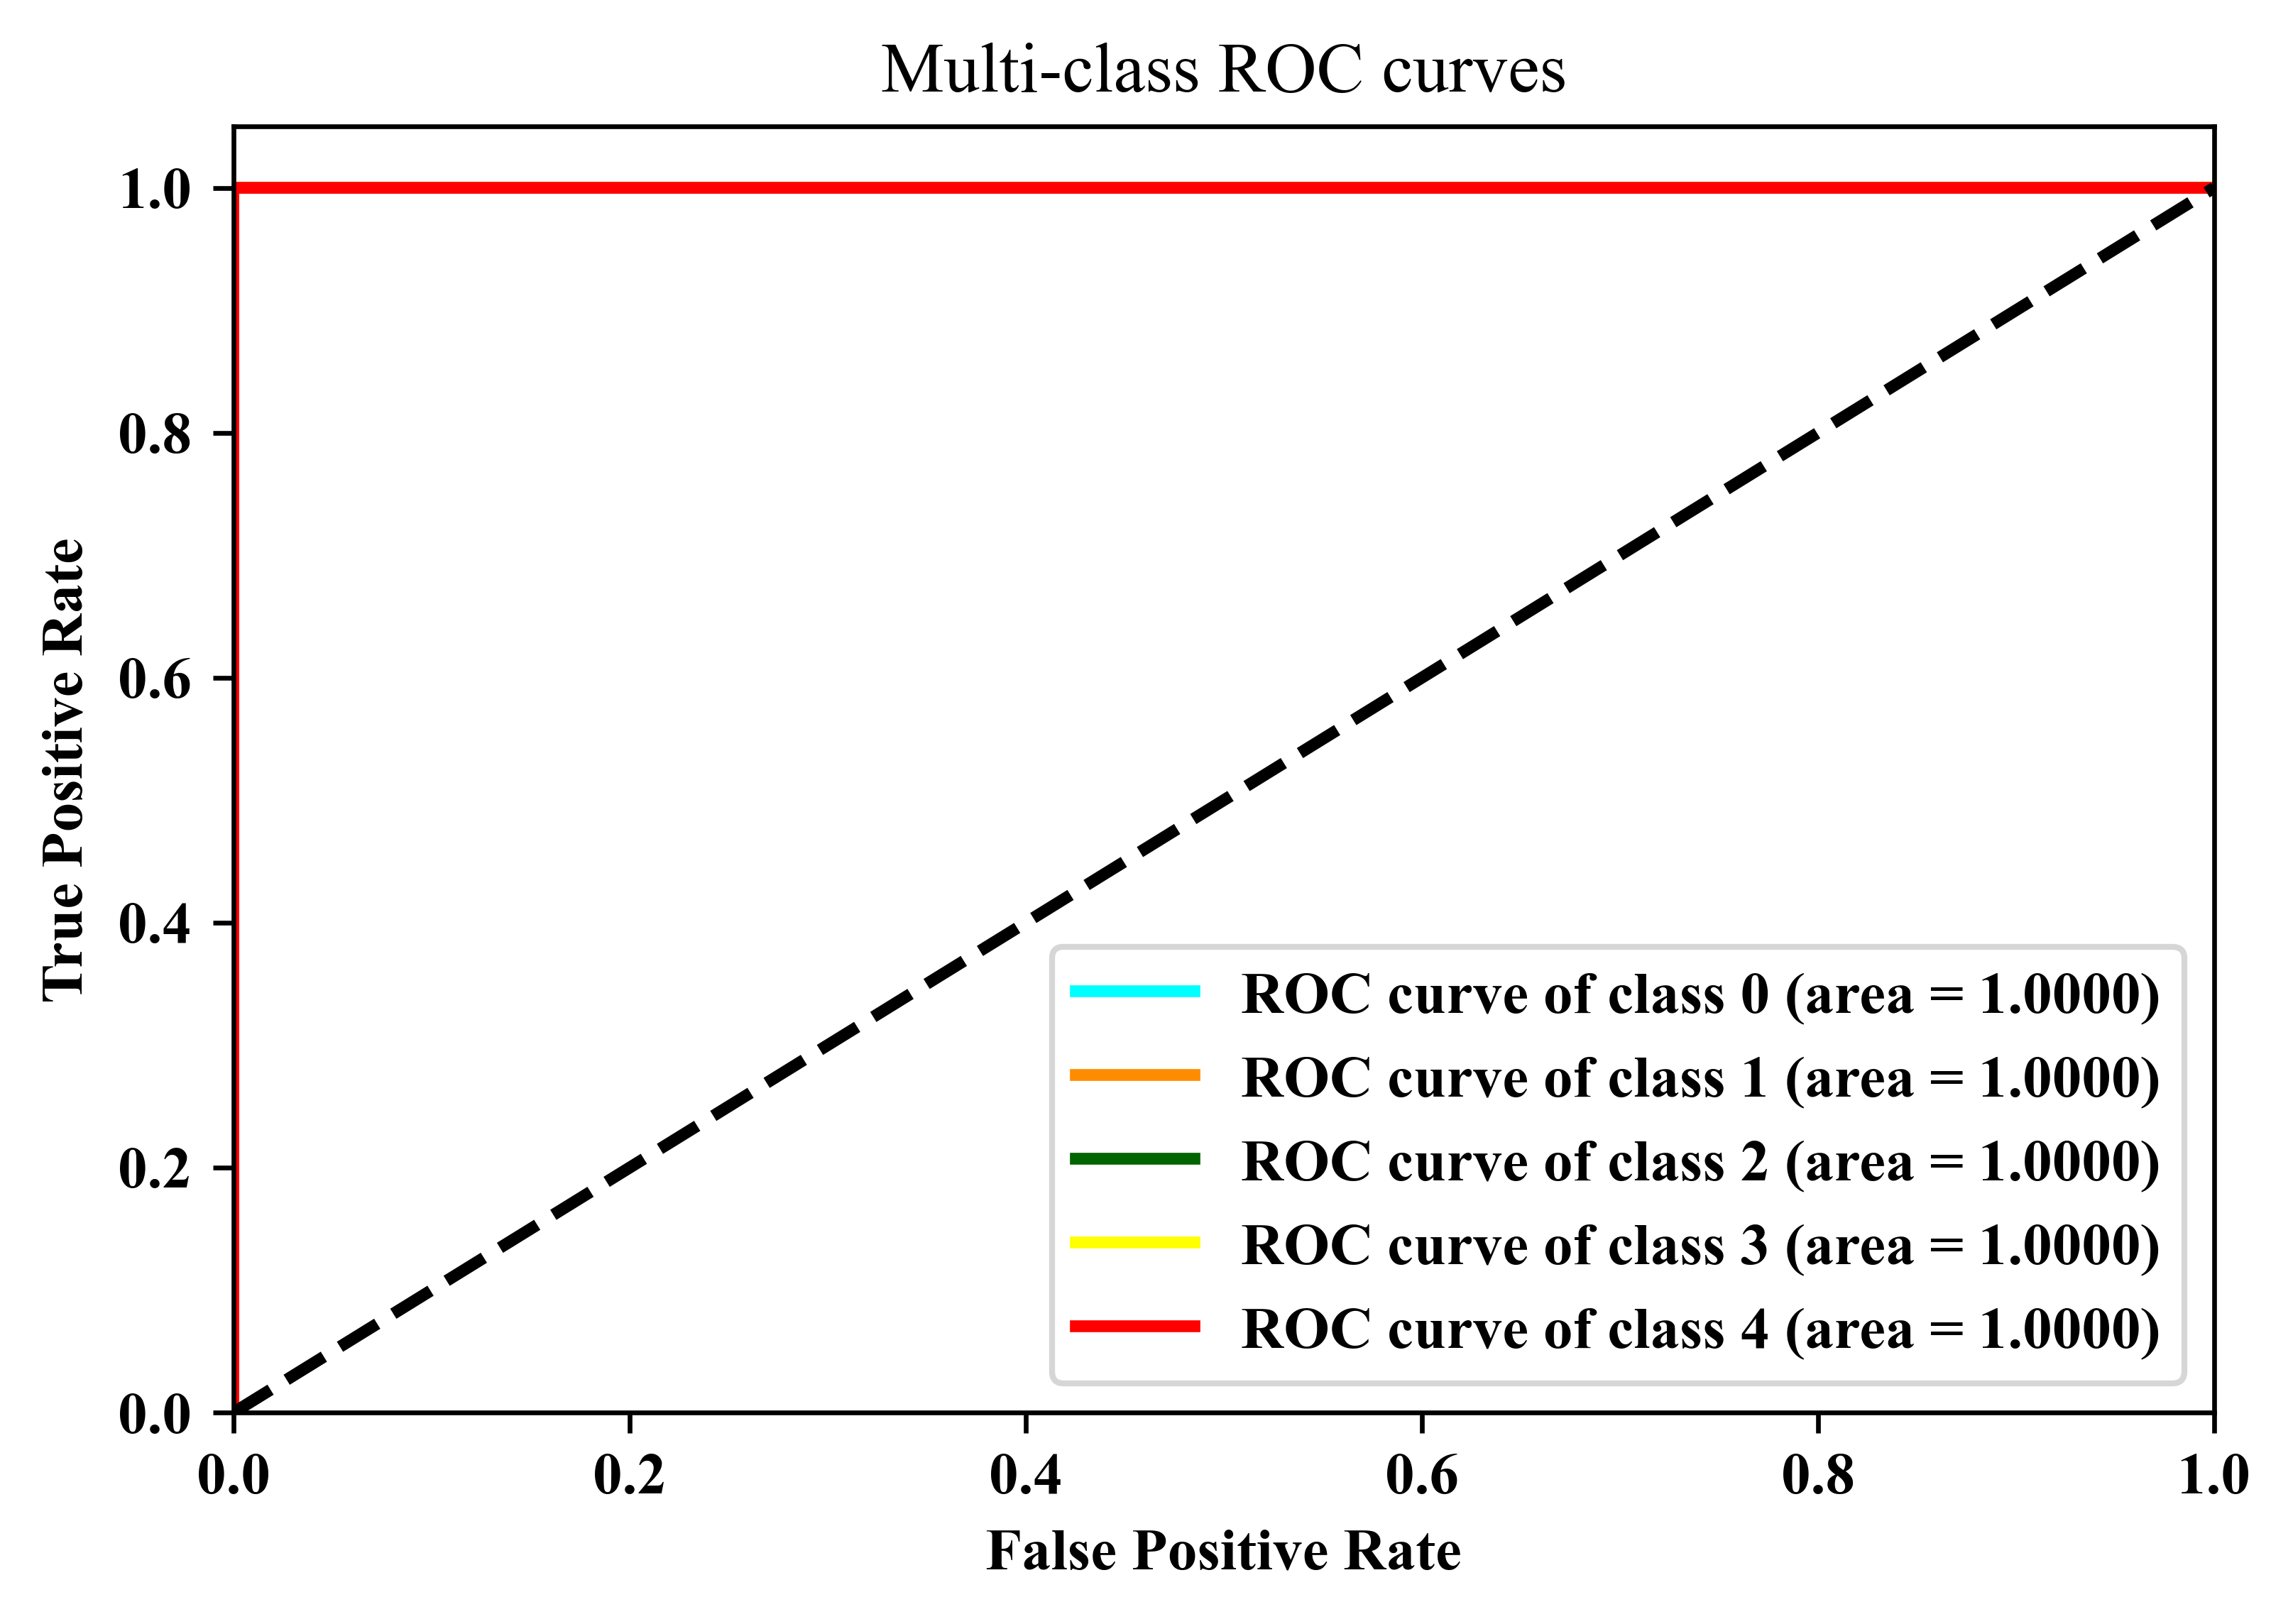

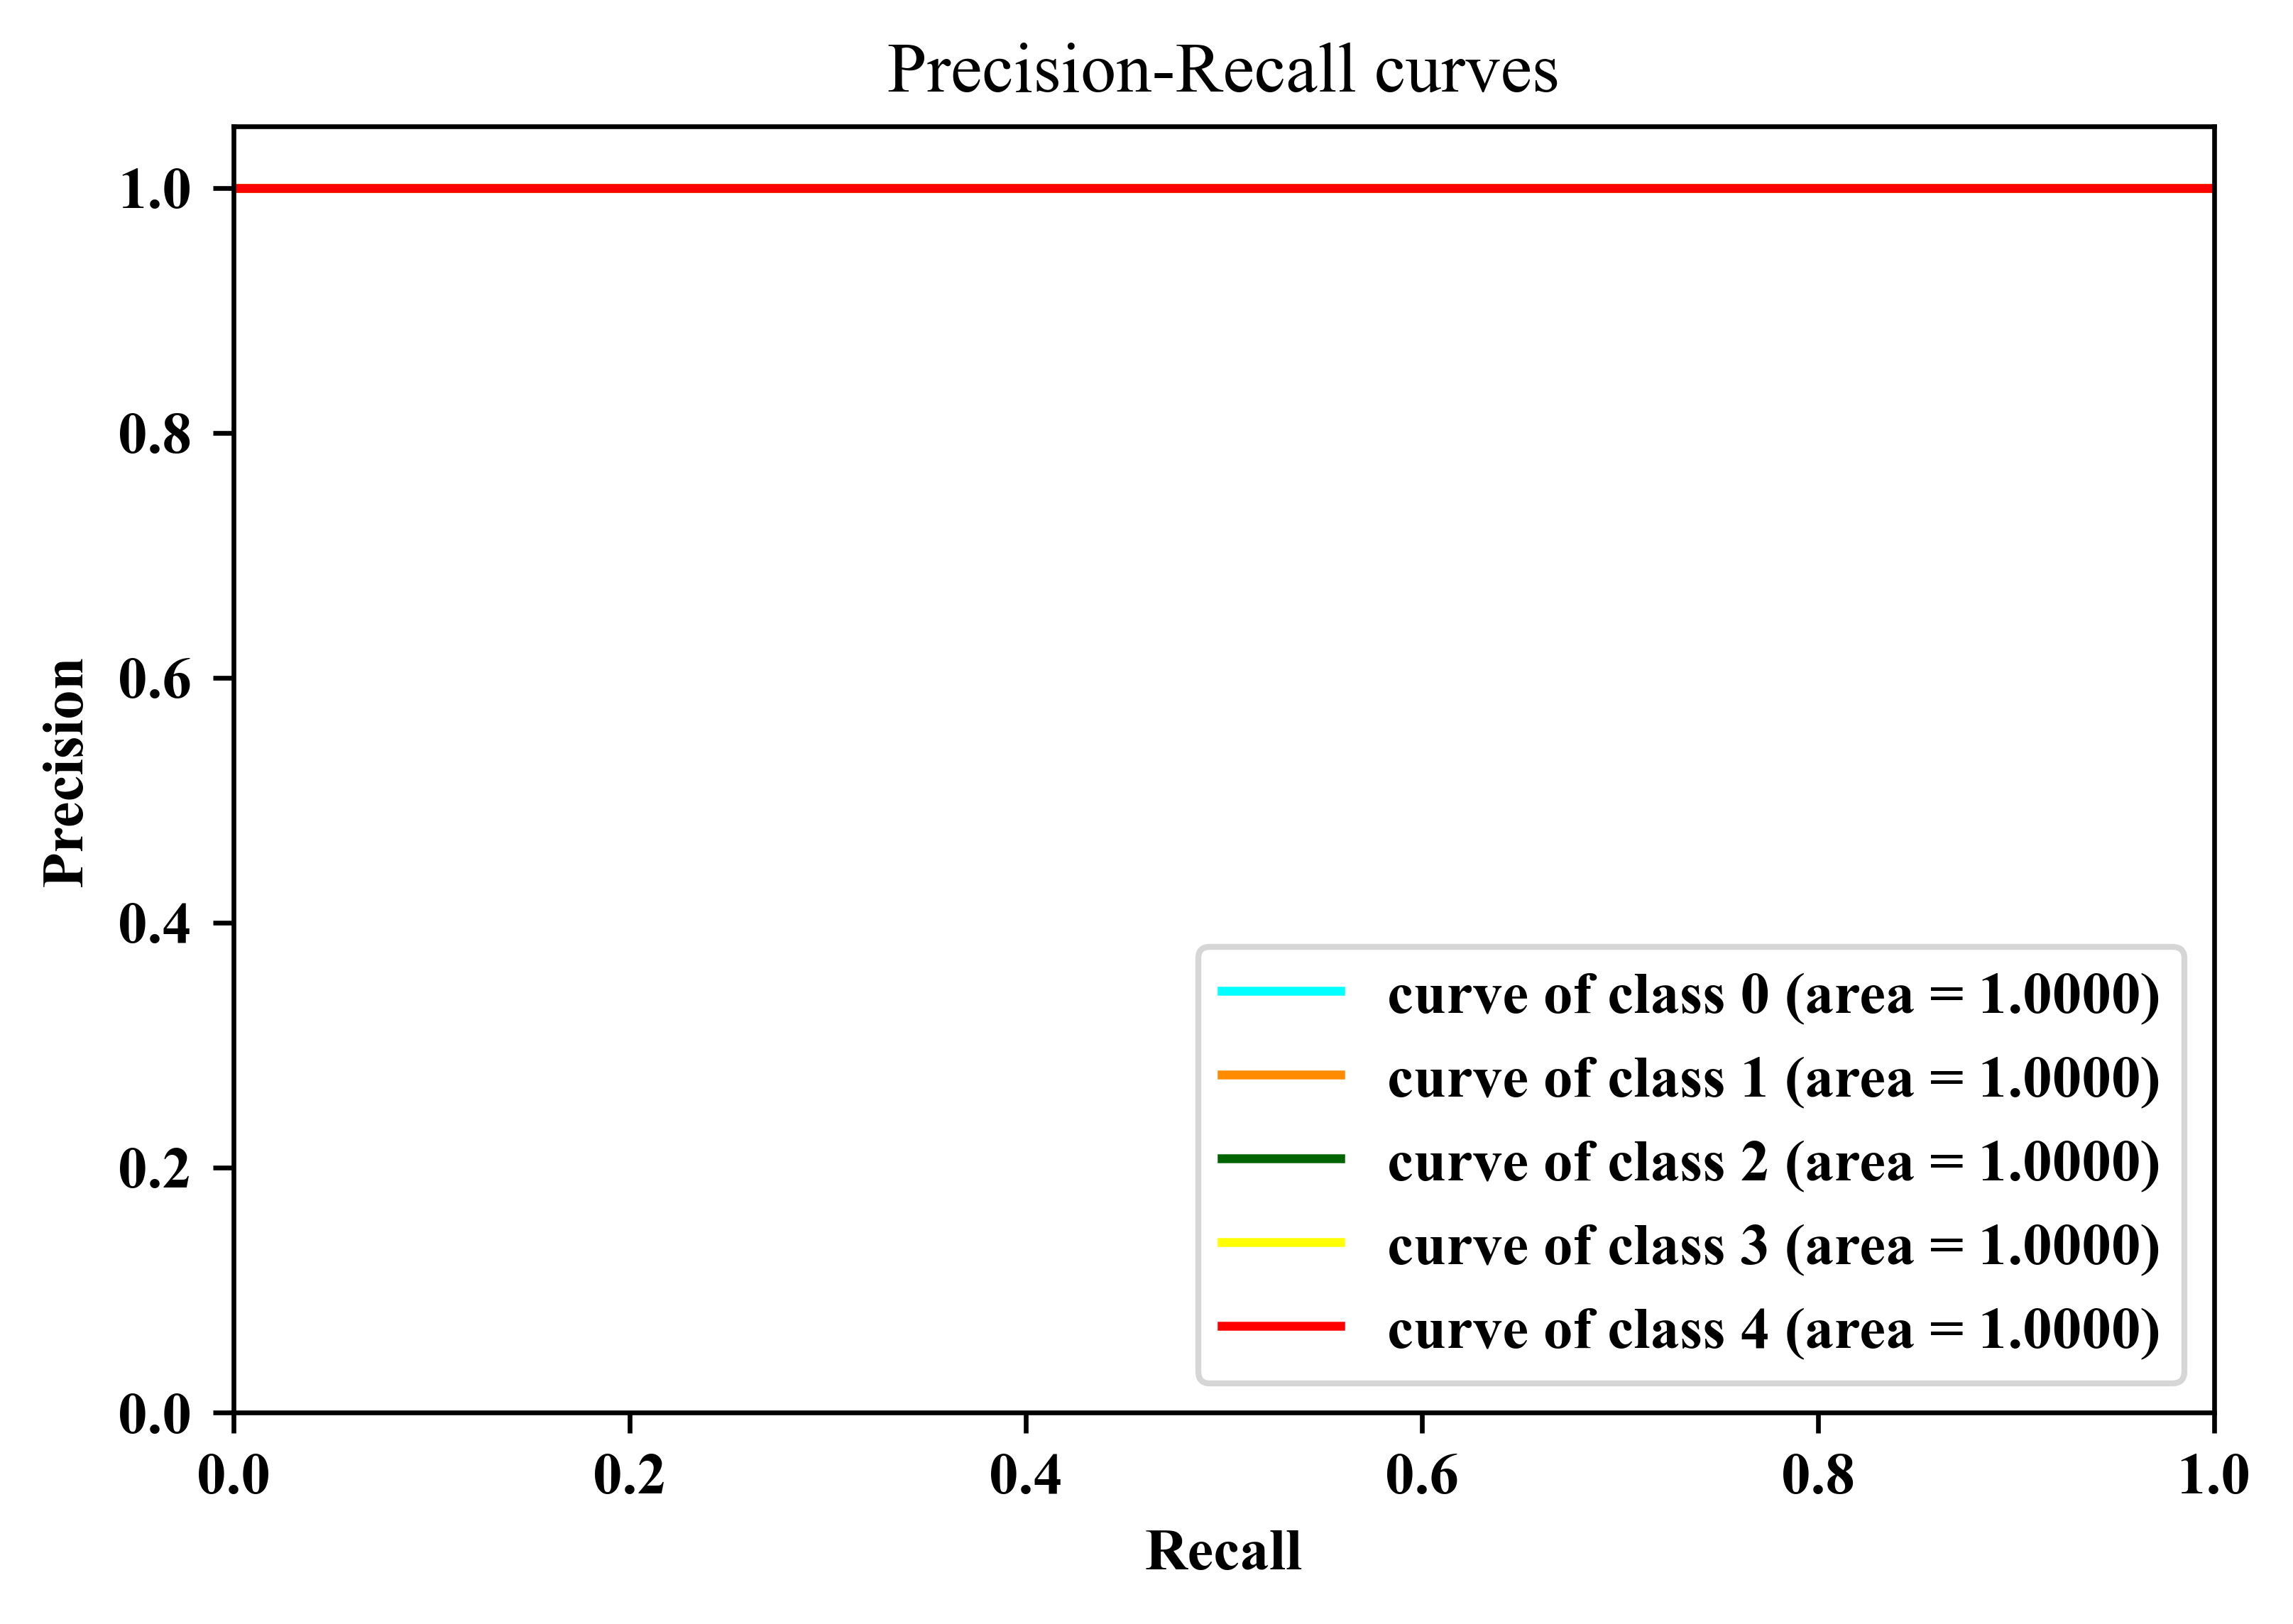

In [26]:
from itertools import cycle
# Compute ROC curve and ROC area for each class
n_classes = 5
# Compute ROC curve and ROC area for each class
# 保存每一类的fpr和tpr值到csv文件，便于后续画图
fpr = dict()
tpr = dict()
roc_auc = dict()
thresholds = dict()
for i in range(n_classes):
    fpr[i], tpr[i], thresholds[i] = metrics.roc_curve(y_test[:, i], test_pre[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    df = pd.DataFrame({'fpr':fpr[i],'tpr':tpr[i]})
    df.to_csv('./Results/intra_adam_bilstm_fpr_tpr_{}.csv'.format(i))
# 画图AUC-ROC
plt.figure(dpi=600)
lw = 2
colors = cycle(["aqua", "darkorange", "darkgreen", "yellow", "red", "purple", "blue", "gray"])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
    label="ROC curve of class {0} (area = {1:0.4f})".format(i, roc_auc[i]),)
plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('Multi-class ROC curves')
plt.legend(loc="lower right")
plt.show()



# Compute auc-pr and AP(average precision) for each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = metrics.precision_recall_curve(y_test[:, i], test_pre[:, i])
    average_precision[i] = metrics.average_precision_score(y_test[:, i], test_pre[:, i])
    df = pd.DataFrame({'precision':precision[i],'recall':recall[i]})
    df.to_csv('./Results/intra_adam_bilstm_precision_recall_{}.csv'.format(i))
# 绘制所有类别的pr曲线
plt.figure(dpi=600)
lw = 2
colors = cycle(["aqua", "darkorange", "darkgreen", "yellow", "red", "purple", "blue", "gray"])
for i, color in zip(range(n_classes), colors):
    plt.step(recall[i], precision[i], color=color, where="post", label="curve of class {0} (area = {1:0.4f})".format(i, average_precision[i]))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title("Precision-Recall curves")
plt.legend(loc="lower right")
plt.show()   


DNN

In [27]:

inputs = Input(name='inputs',shape=[maxLen], dtype='float64')
# layer = Embedding(max_words+1, 128, input_length=maxLen, trainable=True)(inputs)
# 添加输入层和隐藏层
layer = Dense(16, activation='relu')(inputs)
output = Dense(num_labels, activation='softmax')(layer)
model = Model(inputs=inputs, outputs=output)
model.summary()


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 10)]              0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                176       
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 85        
Total params: 261
Trainable params: 261
Non-trainable params: 0
_________________________________________________________________


In [28]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from sklearn.model_selection import StratifiedKFold
import time


accuracy_score_list,recall_score_list,precision_score_list,f1_score_list = [],[],[],[]
# 编译模型
adam = keras.optimizers.adam_v2.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=["accuracy"])

# 定义5折交叉验证
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 记录开始时间
start_time = time.time()

# 开始交叉验证
for train_index, val_index in kfold.split(trainSeq, np.argmax(y_train,axis=1)):
    X_train_fold, X_val_fold = trainSeq[train_index],trainSeq[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    print(X_train_fold.shape, X_val_fold.shape, y_train_fold.shape, y_val_fold.shape)


    # 训练模型
    history = model.fit(X_train_fold, y_train_fold, epochs=5, batch_size=1024)
    y_pred = model.predict(X_val_fold)
    print(y_pred.shape)
    print(history.history)
    # 评估模型
    AccuracyScore = metrics.accuracy_score(np.argmax(y_val_fold,axis=1),np.argmax(y_pred,axis=1))
    RecallScore = metrics.recall_score(np.argmax(y_val_fold,axis=1),np.argmax(y_pred,axis=1),average='macro')
    PrecisionScore = metrics.precision_score(np.argmax(y_val_fold,axis=1),np.argmax(y_pred,axis=1),average='macro')
    F1Score = metrics.f1_score(np.argmax(y_val_fold,axis=1),np.argmax(y_pred,axis=1),average='macro')
    # 将评估指标存放对应的列表中
    accuracy_score_list.append(AccuracyScore)
    recall_score_list.append(RecallScore)
    precision_score_list.append(PrecisionScore)
    f1_score_list.append(F1Score)
        # 打印每一次训练的正确率、召回率、F1值
    print('accuracy_score:',AccuracyScore,'recall_score:',RecallScore,'precision_score',PrecisionScore,'f1_score:',F1Score)
# 打印各指标的平均值和95%的置信区间
print("Accuracy: %0.4f (+/- %0.4f)" % (np.average(accuracy_score_list), np.std(accuracy_score_list) * 2))
print("Recall: %0.4f (+/- %0.4f)" % (np.average(recall_score_list), np.std(recall_score_list) * 2))
print("Precision: %0.4f (+/- %0.4f)" % (np.average(precision_score_list), np.std(precision_score_list) * 2))
print("F1_score: %0.4f (+/- %0.4f)" % (np.average(f1_score_list), np.std(f1_score_list) * 2))

# 计算总训练时间
end_time = time.time()
elapsed_time = end_time - start_time
average_training_time = elapsed_time / ((len(X_train) * kfold.n_splits))
print("Average Training Time per Data Point: {:.6f} seconds".format(average_training_time))

# 保存模型
model.save('model_intra\\dnn.h5')



C:\Users\10105\.conda\envs\tf2\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


(10604464, 10) (2651116, 10) (10604464, 5) (2651116, 5)
Epoch 1/5
10356/10356 [==============================] - 17s 2ms/step - loss: 0.1067 - accuracy: 0.9903
Epoch 2/5
10356/10356 [==============================] - 16s 2ms/step - loss: 9.3219e-04 - accuracy: 0.9998
Epoch 3/5
10356/10356 [==============================] - 16s 2ms/step - loss: 5.5565e-04 - accuracy: 0.9999
Epoch 4/5
10356/10356 [==============================] - 16s 2ms/step - loss: 4.5040e-04 - accuracy: 0.9999
Epoch 5/5
10356/10356 [==============================] - 16s 2ms/step - loss: 4.0566e-04 - accuracy: 0.9999
(2651116, 5)
{'loss': [0.10670166462659836, 0.0009321923716925085, 0.0005556454416364431, 0.00045039542601443827, 0.00040565646486356854], 'accuracy': [0.9903062582015991, 0.9998393058776855, 0.9998971223831177, 0.9999184012413025, 0.9999311566352844]}
accuracy_score: 0.9999351216619717 recall_score: 0.9995872960954187 precision_score 0.9999603085885782 f1_score: 0.9997736153270731
(10604464, 10) (2651116

In [29]:
print("模型预测")
mainModel = load_model('model_intra\\dnn.h5', compile=False)
# 预测


模型预测


Average Prediction Time per Data Point: 0.000012 seconds
              precision    recall  f1-score   support

           0     0.9998    1.0000    0.9999   2846990
           1     1.0000    1.0000    1.0000    131324
           2     1.0000    1.0000    1.0000    119707
           3     1.0000    0.9953    0.9976     98475
           4     1.0000    1.0000    1.0000    117399

    accuracy                         0.9999   3313895
   macro avg     1.0000    0.9991    0.9995   3313895
weighted avg     0.9999    0.9999    0.9999   3313895

Accuracy:0.9999
MCC:0.9995
Kappa:0.9995
False Positive Rate (Benign samples misclassified as attacks): 0.0000


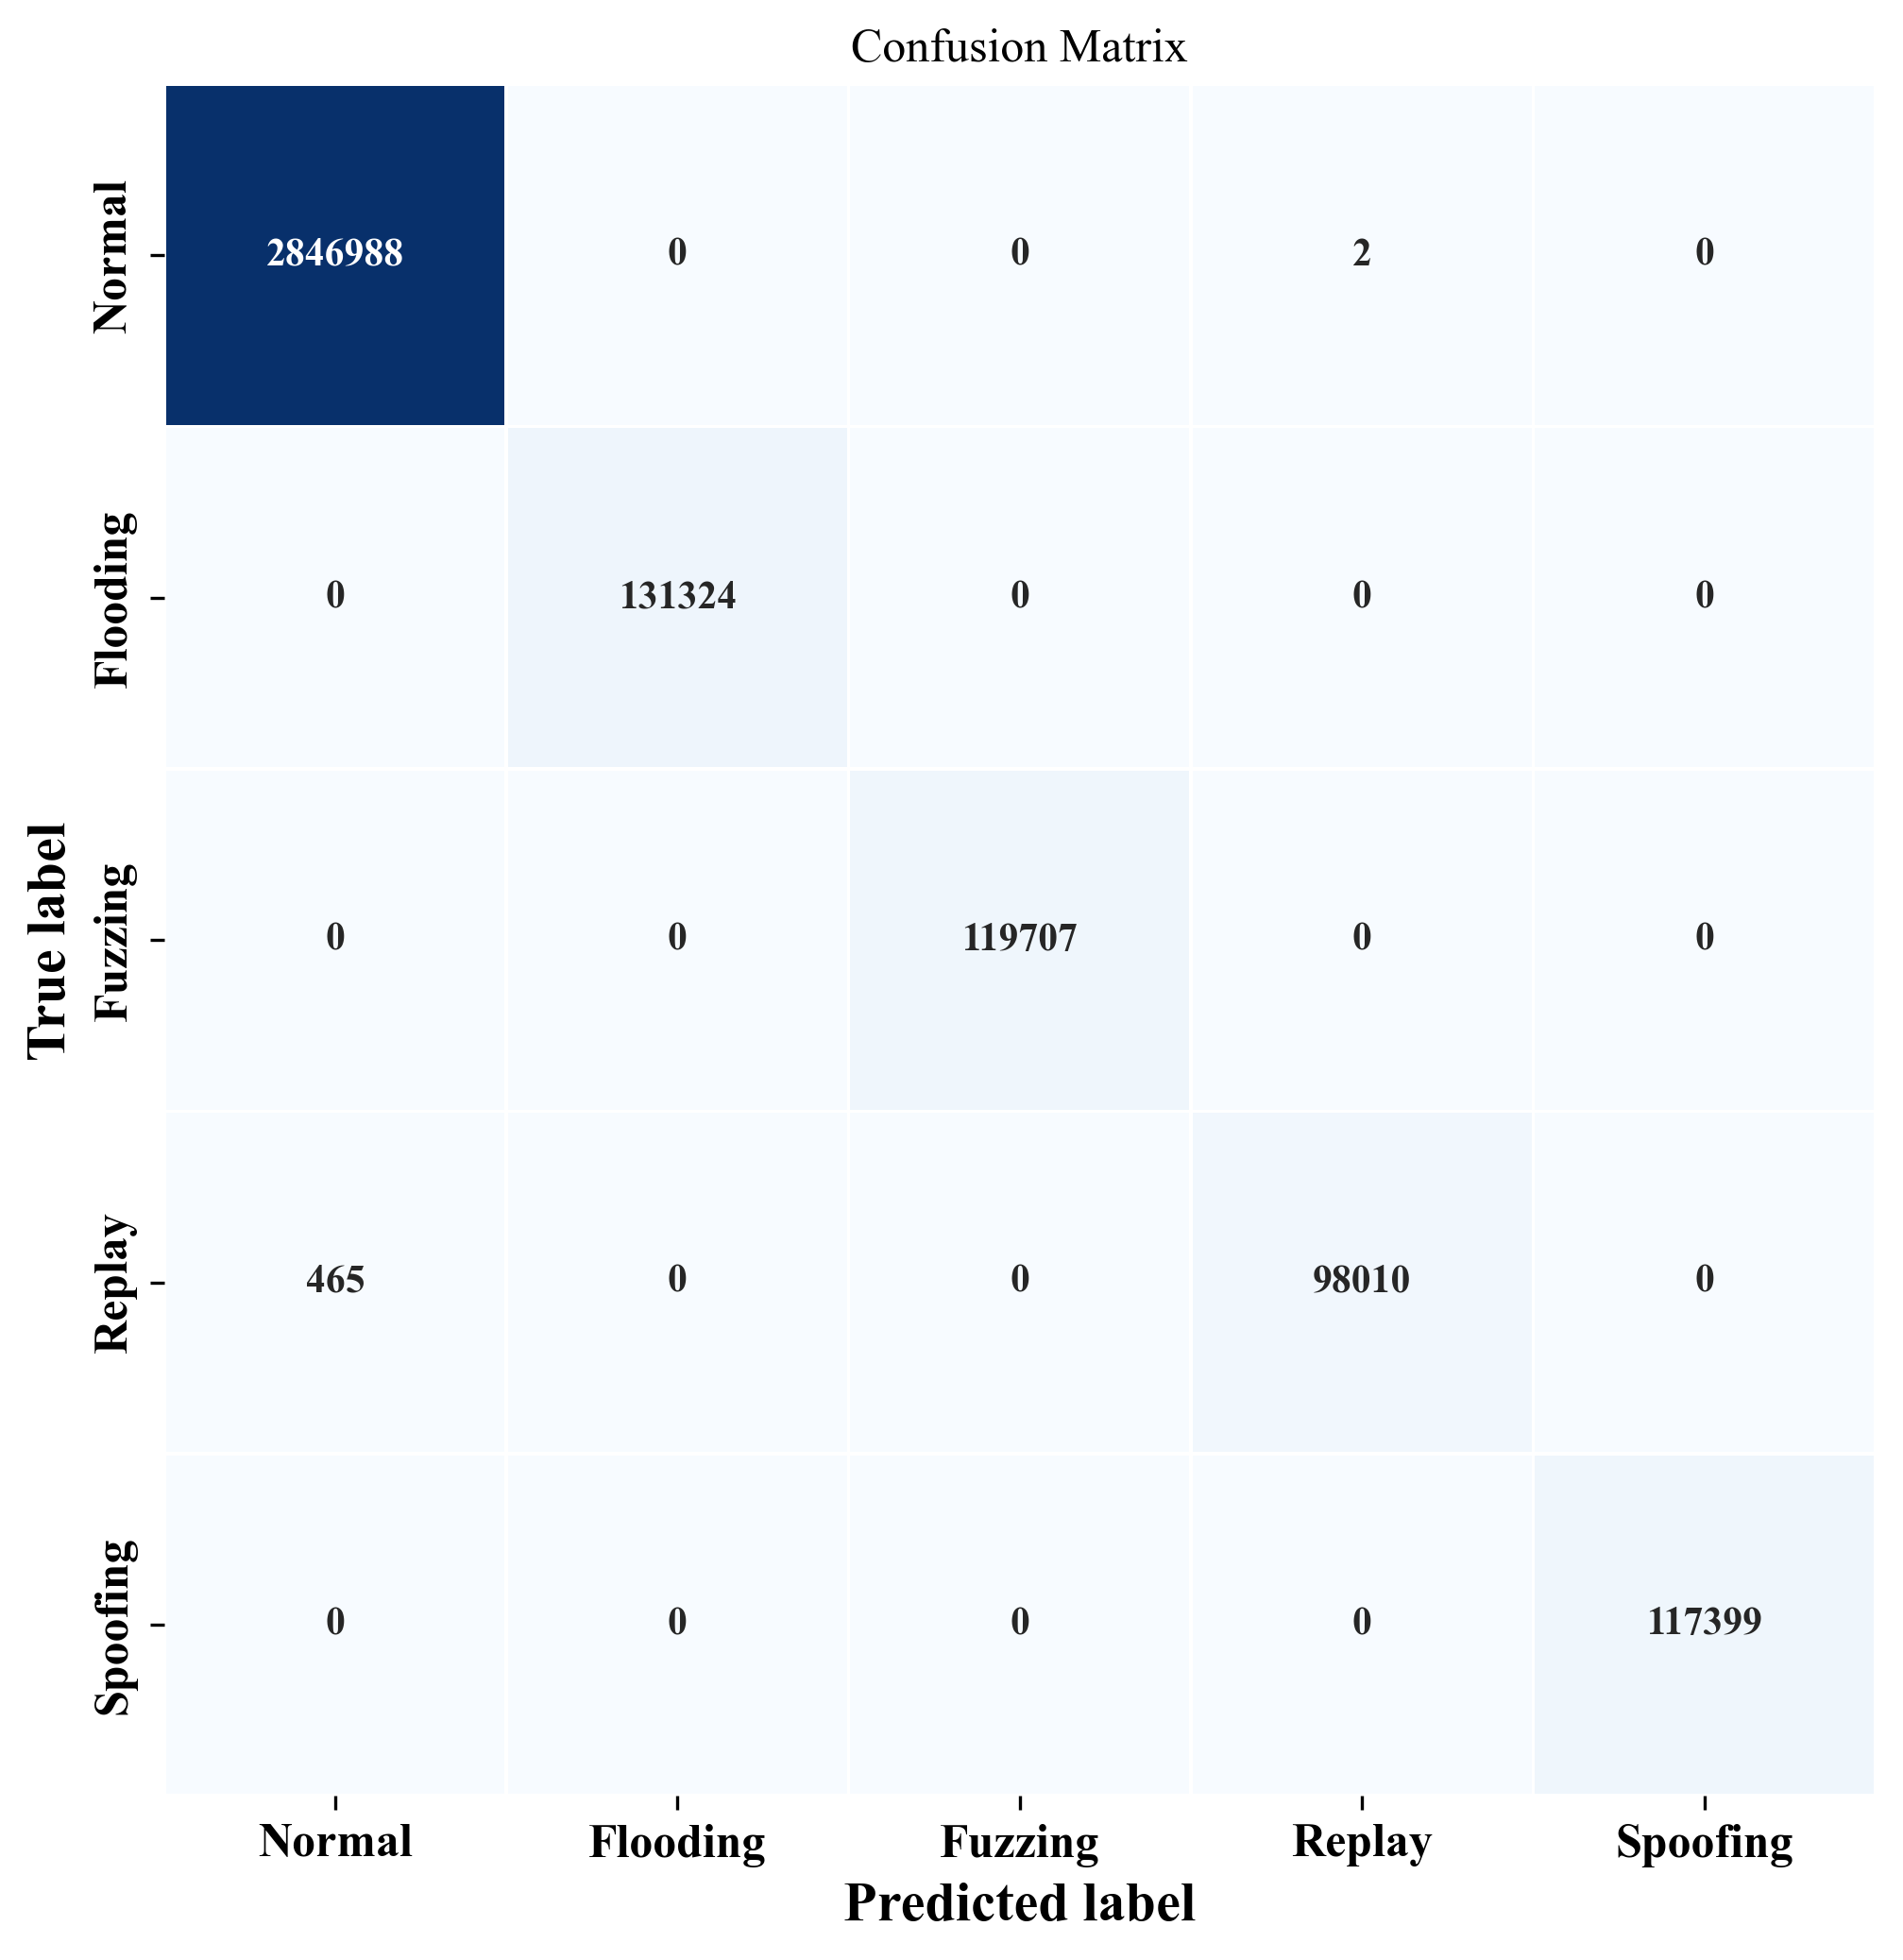

In [30]:
# 计算预测时间
start_time = time.time()  # 记录开始时间
test_pre = mainModel.predict(testSeq)
end_time = time.time()  # 记录结束时间
average_prediction_time = (end_time - start_time) / len(testSeq)
print("Average Prediction Time per Data Point: {:.6f} seconds".format(average_prediction_time))

# 计算混淆矩阵
confm = metrics.confusion_matrix(np.argmax(y_test, axis=1), np.argmax(test_pre, axis=1))
# 计算classification_report
print(metrics.classification_report(np.argmax(y_test, axis=1),
                                    np.argmax(test_pre, axis=1),
                                    digits=4))
# 计算准确度
accuracy = metrics.accuracy_score(np.argmax(y_test, axis=1),
                                          np.argmax(test_pre, axis=1))
print("Accuracy:{:.4f}".format(accuracy))
# 计算MCC
mcc = metrics.matthews_corrcoef(np.argmax(y_test, axis=1),
                                          np.argmax(test_pre, axis=1))
print("MCC:{:.4f}".format(mcc))
# 计算kappa
kappa = metrics.cohen_kappa_score(np.argmax(y_test, axis=1),
                                          np.argmax(test_pre, axis=1))
print("Kappa:{:.4f}".format(kappa))
# 计算误报率（False Positive Rate）
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(test_pre, axis=1)
false_positives = np.sum((y_true == 0) & (y_pred != 0))  # 0 represents the "Benign" class
total_benign_samples = np.sum(y_true == 0)
false_positive_rate = false_positives / total_benign_samples
print("False Positive Rate (Benign samples misclassified as attacks): {:.4f}".format(false_positive_rate))

# 画图
#设置所有图片的字体大小为10，字体为Times New Roman，字体为粗体，label的字体大小为10，字体为Times New Roman，字体为粗体
plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'

plt.figure(figsize=(8, 8), dpi=300)
sns.heatmap(confm, square=True, annot=True,
            fmt='d', cbar=False, linewidths=.6,
            cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted label', size=14)
plt.ylabel('True label', size=14)
Labname = ['Normal', 'Flooding', 'Fuzzing', 'Replay', 'Spoofing']   #行列名
plt.xticks(np.arange(5)+0.5, Labname, size = 12)
plt.yticks(np.arange(5)+0.5, Labname, size = 12)
plt.show()


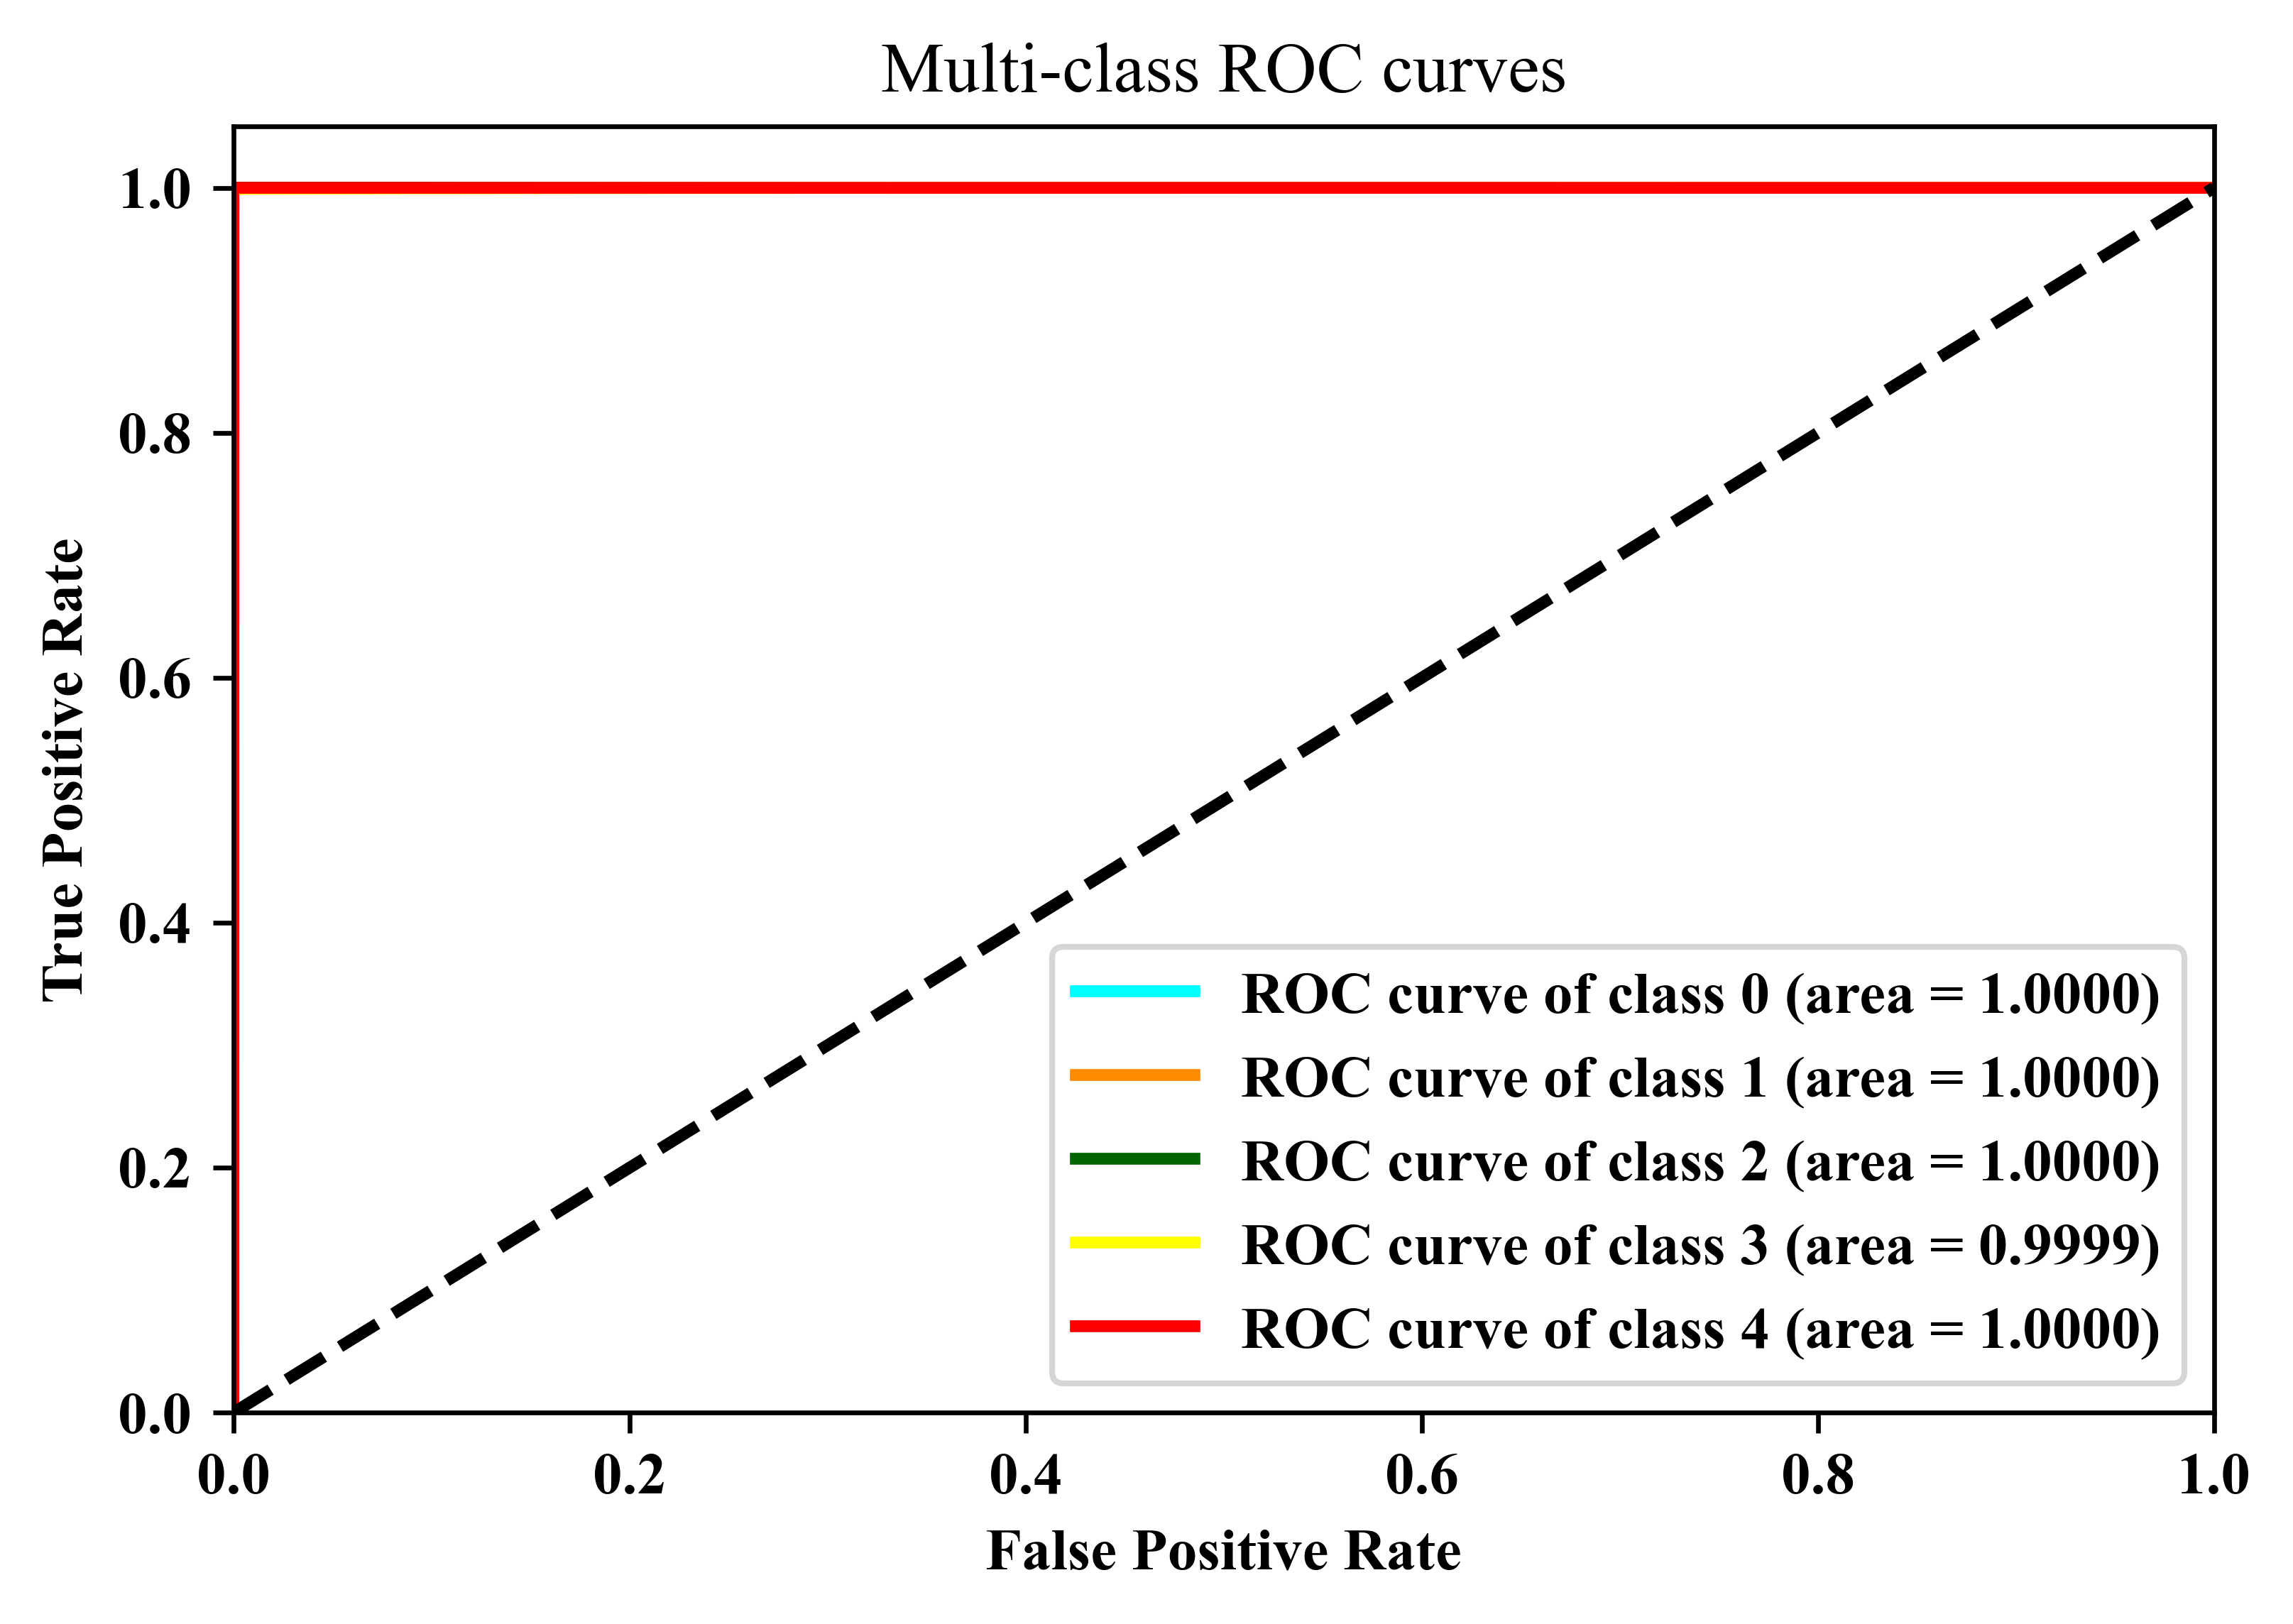

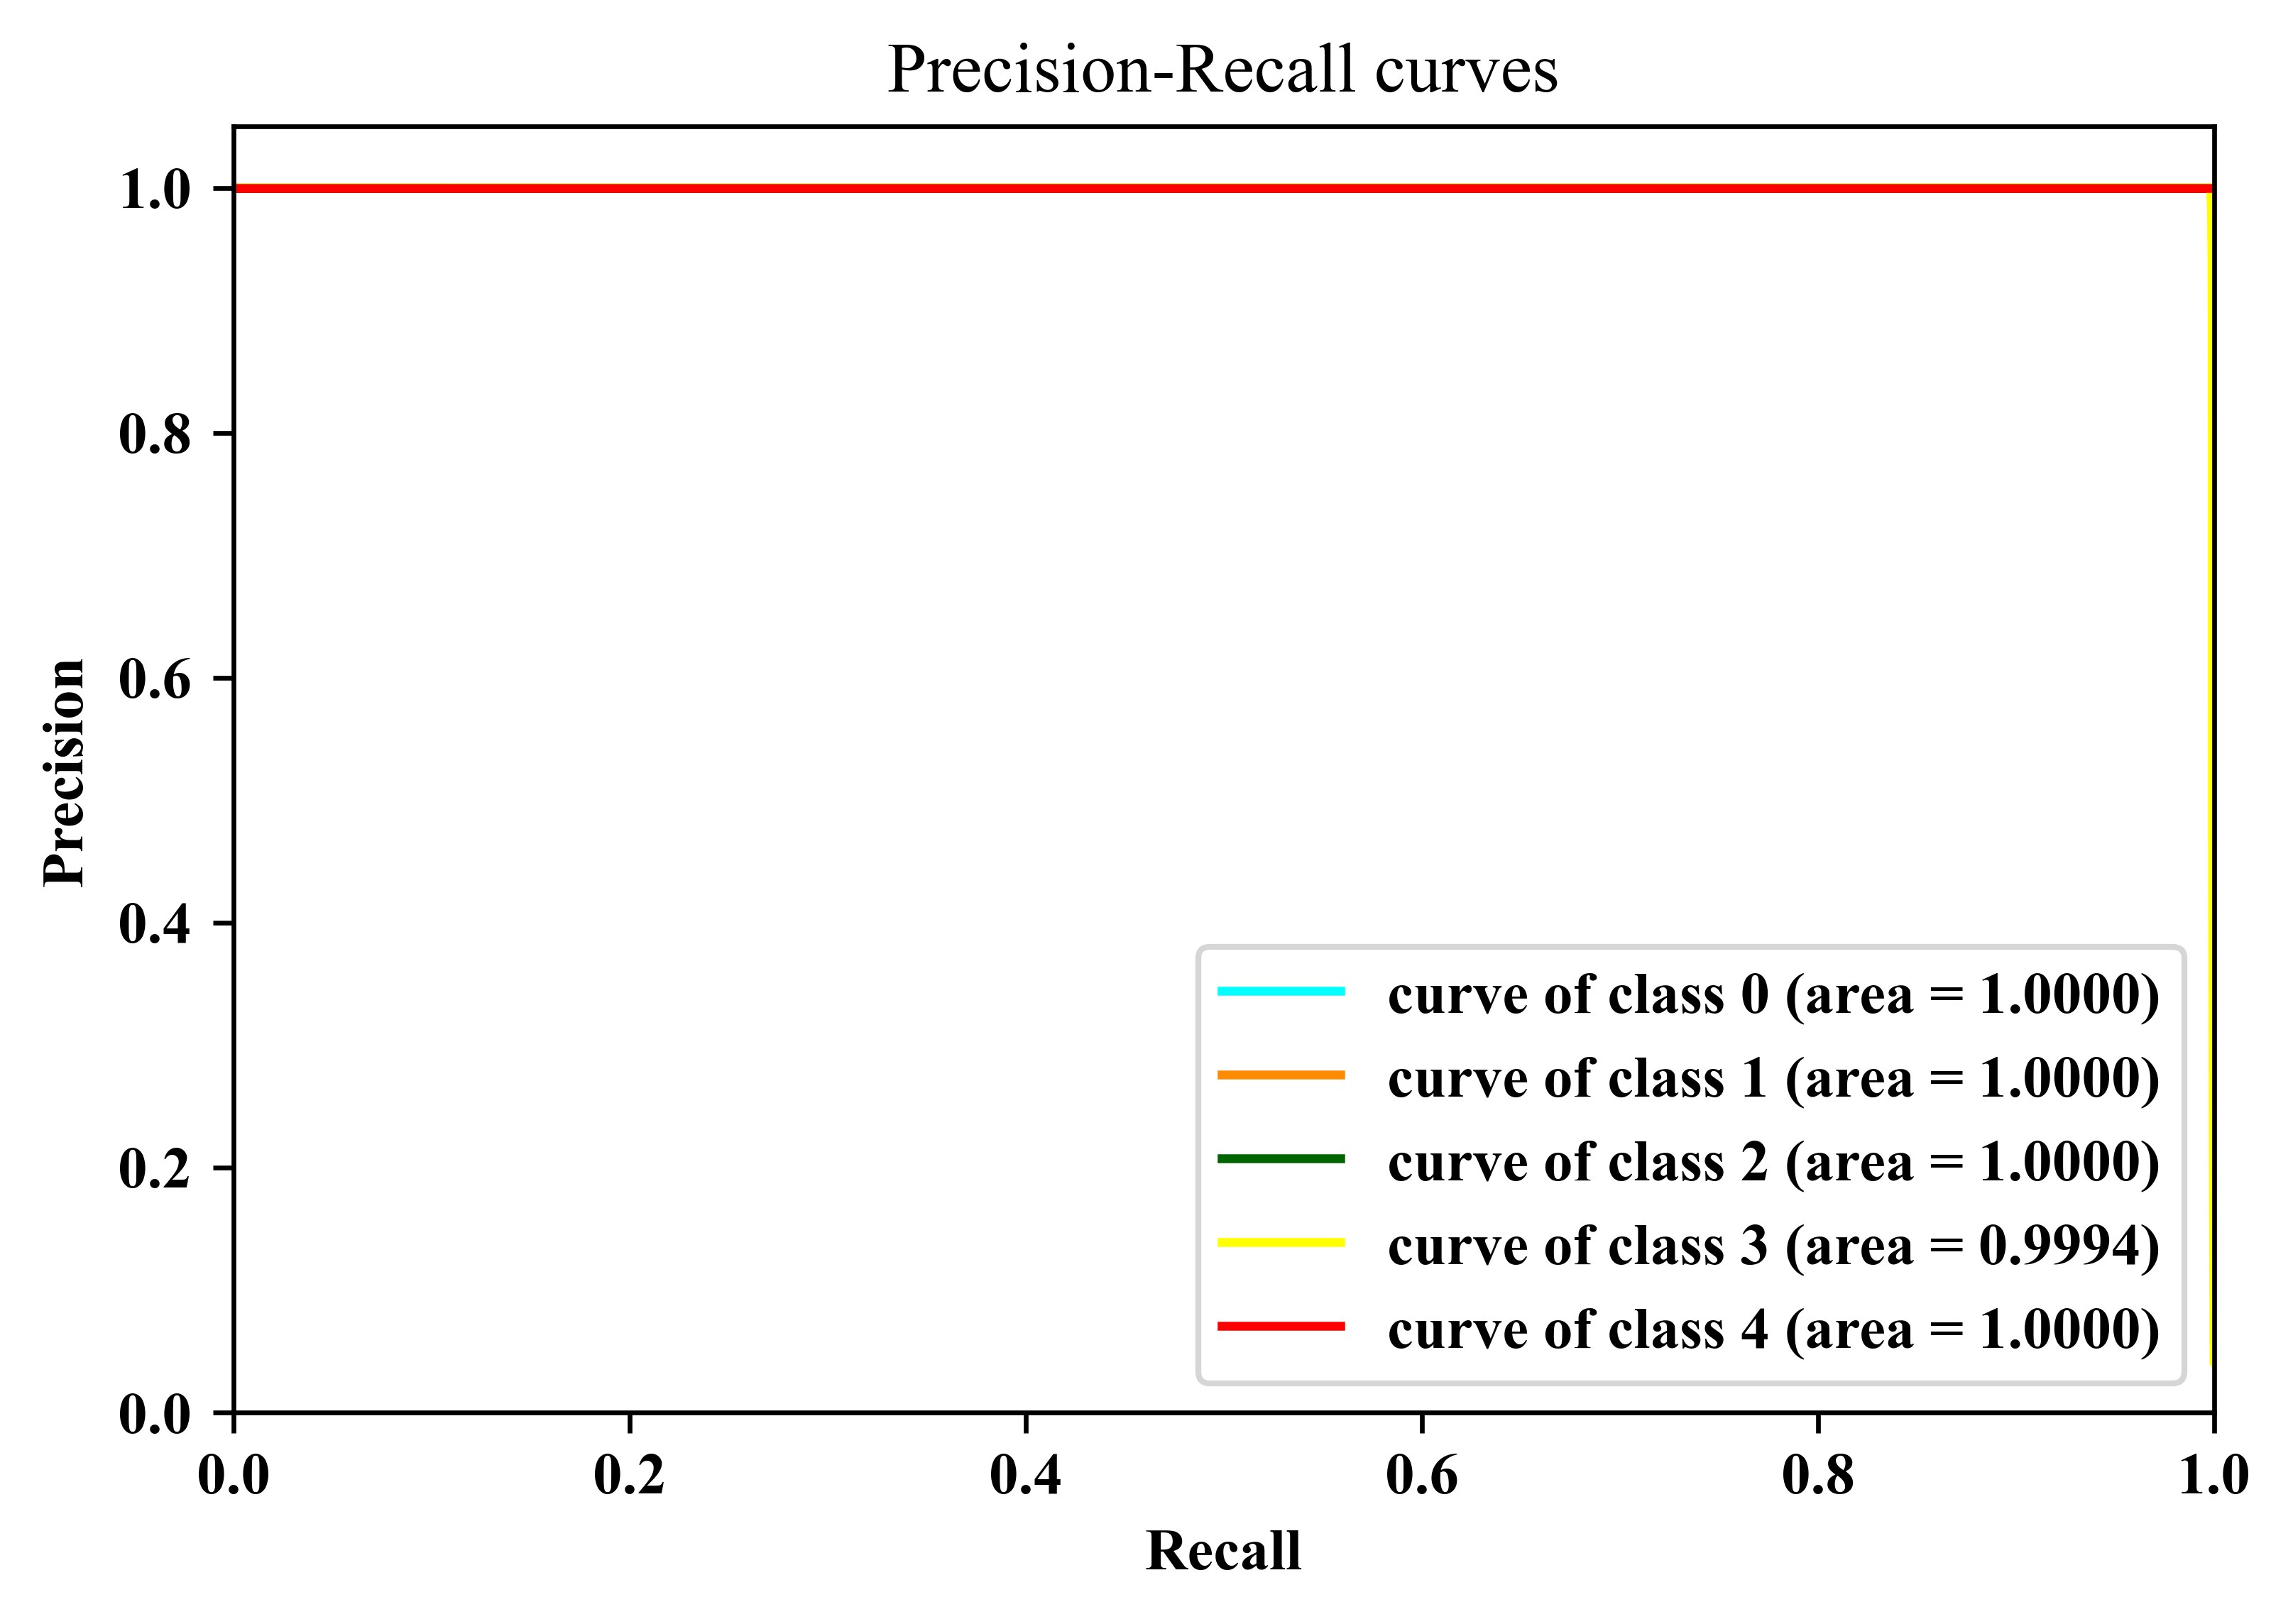

In [31]:
from itertools import cycle
# Compute ROC curve and ROC area for each class
n_classes = 5
# Compute ROC curve and ROC area for each class
# 保存每一类的fpr和tpr值到csv文件，便于后续画图
fpr = dict()
tpr = dict()
roc_auc = dict()
thresholds = dict()
for i in range(n_classes):
    fpr[i], tpr[i], thresholds[i] = metrics.roc_curve(y_test[:, i], test_pre[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    df = pd.DataFrame({'fpr':fpr[i],'tpr':tpr[i]})
    df.to_csv('./Results/intra_adam_dnn_fpr_tpr_{}.csv'.format(i))
# 画图AUC-ROC
plt.figure(dpi=600)
lw = 2
colors = cycle(["aqua", "darkorange", "darkgreen", "yellow", "red", "purple", "blue", "gray"])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
    label="ROC curve of class {0} (area = {1:0.4f})".format(i, roc_auc[i]),)
plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('Multi-class ROC curves')
plt.legend(loc="lower right")
plt.show()



# Compute auc-pr and AP(average precision) for each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = metrics.precision_recall_curve(y_test[:, i], test_pre[:, i])
    average_precision[i] = metrics.average_precision_score(y_test[:, i], test_pre[:, i])
    df = pd.DataFrame({'precision':precision[i],'recall':recall[i]})
    df.to_csv('./Results/intra_adam_dnn_precision_recall_{}.csv'.format(i))
# 绘制所有类别的pr曲线
plt.figure(dpi=600)
lw = 2
colors = cycle(["aqua", "darkorange", "darkgreen", "yellow", "red", "purple", "blue", "gray"])
for i, color in zip(range(n_classes), colors):
    plt.step(recall[i], precision[i], color=color, where="post", label="curve of class {0} (area = {1:0.4f})".format(i, average_precision[i]))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title("Precision-Recall curves")
plt.legend(loc="lower right")
plt.show()   


变化y值

In [32]:
y_train_new = np.argmax(y_train,axis=1)
y_test_new = np.argmax(y_test,axis=1)
print(y_train_new.shape)
print(y_test_new)

(13255580,)
[0 0 0 ... 0 0 0]


KNN

In [33]:
accuracy_score_list,recall_score_list,precision_score_list,f1_score_list = [],[],[],[]
# 定义5折交叉验证
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 初始化分类器
knn_clf = KNeighborsClassifier(n_neighbors=3)

# 记录开始时间
start_time = time.time()

# 开始交叉验证
for train_index, val_index in kfold.split(trainSeq, y_train_new):
    X_train_fold, X_val_fold = trainSeq[train_index], trainSeq[val_index]
    y_train_fold, y_val_fold = y_train_new[train_index], y_train_new[val_index]
    print(X_train_fold.shape, X_val_fold.shape, y_train_fold.shape, y_val_fold.shape)
    # 训练模型
    knn_clf.fit(X_train_fold, y_train_fold)

    y_pred = knn_clf.predict(X_val_fold)
    # 评估模型
    AccuracyScore = metrics.accuracy_score(y_val_fold,y_pred)
    RecallScore = metrics.recall_score(y_val_fold,y_pred,average='macro')
    PrecisionScore = metrics.precision_score(y_val_fold,y_pred,average='macro')
    F1Score = metrics.f1_score(y_val_fold,y_pred,average='macro')
    # 将评估指标存放对应的列表中
    accuracy_score_list.append(AccuracyScore)
    recall_score_list.append(RecallScore)
    precision_score_list.append(PrecisionScore)
    f1_score_list.append(F1Score)
    # 打印每一次训练的正确率、召回率、F1值
    print('accuracy_score:',AccuracyScore,'recall_score:',RecallScore,'f1_score:',F1Score)
# 打印各指标的平均值和95%的置信区间
print("Accuracy: %0.4f (+/- %0.4f)" % (np.average(accuracy_score_list), np.std(accuracy_score_list) * 2))
print("Recall: %0.4f (+/- %0.4f)" % (np.average(recall_score_list), np.std(recall_score_list) * 2))
print("Precision: %0.4f (+/- %0.4f)" % (np.average(precision_score_list), np.std(precision_score_list) * 2))
print("F1_score: %0.4f (+/- %0.4f)" % (np.average(f1_score_list), np.std(f1_score_list) * 2))

# 计算总训练时间
end_time = time.time()
elapsed_time = end_time - start_time
average_training_time = elapsed_time / ((len(X_train) * kfold.n_splits))
print("Average Training Time per Data Point: {:.6f} seconds".format(average_training_time))




(10604464, 10) (2651116, 10) (10604464,) (2651116,)


KeyboardInterrupt: 

In [ ]:
# 计算预测时间
start_time = time.time()  # 记录开始时间
test_pre = rf_clf.predict(testSeq)
print(test_pre.shape)
end_time = time.time()  # 记录结束时间
average_testing_time = (end_time - start_time) / len(X_test)
print("Average Testing Time per Data Point: {:.6f} seconds".format(average_testing_time))

# 计算混淆矩阵
confm = metrics.confusion_matrix(y_test_new, test_pre)
# 计算classification_report
print(metrics.classification_report(y_test_new, test_pre,
                                    digits=4))
# 计算准确度
accuracy = metrics.accuracy_score(y_test_new, test_pre)
print("Accuracy:{:.4f}".format(accuracy))
# 计算MCC
mcc = metrics.matthews_corrcoef(y_test_new, test_pre)
print("MCC:{:.4f}".format(mcc))
# 计算kappa
kappa = metrics.cohen_kappa_score(y_test_new, test_pre)
print("Kappa:{:.4f}".format(kappa))
# 计算误报率（False Positive Rate）
y_true = y_test_new
y_pred = test_pre
false_positives = np.sum((y_true == 0) & (y_pred != 0))  # 0 represents the "Benign" class
total_benign_samples = np.sum(y_true == 0)
false_positive_rate = false_positives / total_benign_samples
print("False Positive Rate (Benign samples misclassified as attacks): {:.4f}".format(false_positive_rate))

# 画图
#设置所有图片的字体大小为10，字体为Times New Roman，字体为粗体，label的字体大小为10，字体为Times New Roman，字体为粗体
plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'

plt.figure(figsize=(8, 8), dpi=300)
sns.heatmap(confm, square=True, annot=True,
            fmt='d', cbar=False, linewidths=.6,
            cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted label', size=14)
plt.ylabel('True label', size=14)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
Labname = ['Normal', 'Flooding', 'Fuzzing', 'Replay', 'Spoofing']   #行列名
plt.xticks(np.arange(5)+0.5, Labname, size = 12)
plt.yticks(np.arange(5)+0.5, Labname, size = 12)
plt.show()
plt.show()

In [ ]:
# Compute ROC curve and ROC area for each class
n_classes = 5
# Compute ROC curve and ROC area for each class
# 保存每一类的fpr和tpr值到csv文件，便于后续画图
fpr = dict()
tpr = dict()
roc_auc = dict()
thresholds = dict()
test_pre = knn_clf.predict_proba(testSeq)
for i in range(n_classes):
    fpr[i], tpr[i], thresholds[i] = metrics.roc_curve(y_test[:, i], test_pre[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    df = pd.DataFrame({'fpr':fpr[i],'tpr':tpr[i]})
    df.to_csv('./Results/intra_adam_knn_fpr_tpr_{}.csv'.format(i))
# 画图AUC-ROC
plt.figure(dpi=600)
lw = 2
colors = cycle(["aqua", "darkorange", "darkgreen", "yellow", "red", "purple", "blue", "gray"])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
    label="ROC curve of class {0} (area = {1:0.4f})".format(i, roc_auc[i]),)
plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('Multi-class ROC curves')
plt.legend(loc="lower right")
plt.show()



# Compute auc-pr and AP(average precision) for each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = metrics.precision_recall_curve(y_test[:, i], test_pre[:, i])
    average_precision[i] = metrics.average_precision_score(y_test[:, i], test_pre[:, i])
    df = pd.DataFrame({'precision':precision[i],'recall':recall[i]})
    df.to_csv('./Results/intra_adam_knn_precision_recall_{}.csv'.format(i))
# 绘制所有类别的pr曲线
plt.figure(dpi=600)
lw = 2
colors = cycle(["aqua", "darkorange", "darkgreen", "yellow", "red", "purple", "blue", "gray"])
for i, color in zip(range(n_classes), colors):
    plt.step(recall[i], precision[i], color=color, where="post", label="curve of class {0} (area = {1:0.4f})".format(i, average_precision[i]))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title("Precision-Recall curves")
plt.legend(loc="lower right")
plt.show()   


SVM
选择线性核函数是一个不错的选择，因为它需要更少的训练时间，并在文本分类等大型数据集处理方面表现出色。

In [ ]:
accuracy_score_list,recall_score_list,precision_score_list,f1_score_list = [],[],[],[]
# 定义5折交叉验证
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 初始化分类器
svm_clf = SVC(kernel='linear', C=C)

# 记录开始时间
start_time = time.time()

# 开始交叉验证
for train_index, val_index in kfold.split(trainSeq, y_train_new):
    X_train_fold, X_val_fold = trainSeq[train_index], trainSeq[val_index]
    y_train_fold, y_val_fold = y_train_new[train_index], y_train_new[val_index]
    print(X_train_fold.shape, X_val_fold.shape, y_train_fold.shape, y_val_fold.shape)
    # 训练模型
    svm_clf.fit(X_train_fold, y_train_fold)

    y_pred = svm_clf.predict(X_val_fold)
    # 评估模型
    AccuracyScore = metrics.accuracy_score(y_val_fold,y_pred)
    RecallScore = metrics.recall_score(y_val_fold,y_pred,average='macro')
    PrecisionScore = metrics.precision_score(y_val_fold,y_pred,average='macro')
    F1Score = metrics.f1_score(y_val_fold,y_pred,average='macro')
    # 将评估指标存放对应的列表中
    accuracy_score_list.append(AccuracyScore)
    recall_score_list.append(RecallScore)
    precision_score_list.append(PrecisionScore)
    f1_score_list.append(F1Score)
    # 打印每一次训练的正确率、召回率、F1值
    print('accuracy_score:',AccuracyScore,'recall_score:',RecallScore,'f1_score:',F1Score)
# 打印各指标的平均值和95%的置信区间
print("Accuracy: %0.4f (+/- %0.4f)" % (np.average(accuracy_score_list), np.std(accuracy_score_list) * 2))
print("Recall: %0.4f (+/- %0.4f)" % (np.average(recall_score_list), np.std(recall_score_list) * 2))
print("Precision: %0.4f (+/- %0.4f)" % (np.average(precision_score_list), np.std(precision_score_list) * 2))
print("F1_score: %0.4f (+/- %0.4f)" % (np.average(f1_score_list), np.std(f1_score_list) * 2))

# 计算总训练时间
end_time = time.time()
elapsed_time = end_time - start_time
average_training_time = elapsed_time / ((len(X_train) * kfold.n_splits))
print("Average Training Time per Data Point: {:.6f} seconds".format(average_training_time))




In [ ]:
# 计算预测时间
start_time = time.time()  # 记录开始时间
test_pre = svm_clf.predict(testSeq)
print(test_pre.shape)
end_time = time.time()  # 记录结束时间
average_testing_time = (end_time - start_time) / len(X_test)
print("Average Testing Time per Data Point: {:.6f} seconds".format(average_testing_time))

# 计算混淆矩阵
confm = metrics.confusion_matrix(y_test_new, test_pre)
# 计算classification_report
print(metrics.classification_report(y_test_new, test_pre,
                                    digits=4))
# 计算准确度
accuracy = metrics.accuracy_score(y_test_new, test_pre)
print("Accuracy:{:.4f}".format(accuracy))
# 计算MCC
mcc = metrics.matthews_corrcoef(y_test_new, test_pre)
print("MCC:{:.4f}".format(mcc))
# 计算kappa
kappa = metrics.cohen_kappa_score(y_test_new, test_pre)
print("Kappa:{:.4f}".format(kappa))
# 计算误报率（False Positive Rate）
y_true = y_test_new
y_pred = test_pre
false_positives = np.sum((y_true == 0) & (y_pred != 0))  # 0 represents the "Benign" class
total_benign_samples = np.sum(y_true == 0)
false_positive_rate = false_positives / total_benign_samples
print("False Positive Rate (Benign samples misclassified as attacks): {:.4f}".format(false_positive_rate))

# 画图
#设置所有图片的字体大小为10，字体为Times New Roman，字体为粗体，label的字体大小为10，字体为Times New Roman，字体为粗体
plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'

plt.figure(figsize=(8, 8), dpi=300)
sns.heatmap(confm, square=True, annot=True,
            fmt='d', cbar=False, linewidths=.6,
            cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted label', size=14)
plt.ylabel('True label', size=14)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
Labname = ['Normal', 'Flooding', 'Fuzzing', 'Replay', 'Spoofing']   #行列名
plt.xticks(np.arange(5)+0.5, Labname, size = 12)
plt.yticks(np.arange(5)+0.5, Labname, size = 12)
plt.show()
plt.show()

In [ ]:
# Compute ROC curve and ROC area for each class
n_classes = 5
# Compute ROC curve and ROC area for each class
# 保存每一类的fpr和tpr值到csv文件，便于后续画图
fpr = dict()
tpr = dict()
roc_auc = dict()
thresholds = dict()
test_pre = svm_clf.predict_proba(testSeq)
for i in range(n_classes):
    fpr[i], tpr[i], thresholds[i] = metrics.roc_curve(y_test[:, i], test_pre[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    df = pd.DataFrame({'fpr':fpr[i],'tpr':tpr[i]})
    df.to_csv('./Results/intra_adam_svm_fpr_tpr_{}.csv'.format(i))
# 画图AUC-ROC
plt.figure(dpi=600)
lw = 2
colors = cycle(["aqua", "darkorange", "darkgreen", "yellow", "red", "purple", "blue", "gray"])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
    label="ROC curve of class {0} (area = {1:0.4f})".format(i, roc_auc[i]),)
plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('Multi-class ROC curves')
plt.legend(loc="lower right")
plt.show()



# Compute auc-pr and AP(average precision) for each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = metrics.precision_recall_curve(y_test[:, i], test_pre[:, i])
    average_precision[i] = metrics.average_precision_score(y_test[:, i], test_pre[:, i])
    df = pd.DataFrame({'precision':precision[i],'recall':recall[i]})
    df.to_csv('./Results/intra_adam_svm_precision_recall_{}.csv'.format(i))
# 绘制所有类别的pr曲线
plt.figure(dpi=600)
lw = 2
colors = cycle(["aqua", "darkorange", "darkgreen", "yellow", "red", "purple", "blue", "gray"])
for i, color in zip(range(n_classes), colors):
    plt.step(recall[i], precision[i], color=color, where="post", label="curve of class {0} (area = {1:0.4f})".format(i, average_precision[i]))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title("Precision-Recall curves")
plt.legend(loc="lower right")
plt.show()   


NB

In [ ]:
accuracy_score_list,recall_score_list,precision_score_list,f1_score_list = [],[],[],[]
# 定义5折交叉验证
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 初始化分类器
nb_clf = GaussianNB()

# 记录开始时间
start_time = time.time()

# 开始交叉验证
for train_index, val_index in kfold.split(trainSeq, y_train_new):
    X_train_fold, X_val_fold = trainSeq[train_index], trainSeq[val_index]
    y_train_fold, y_val_fold = y_train_new[train_index], y_train_new[val_index]
    print(X_train_fold.shape, X_val_fold.shape, y_train_fold.shape, y_val_fold.shape)
    # 训练模型
    nb_clf.fit(X_train_fold, y_train_fold)

    y_pred = nb_clf.predict(X_val_fold)
    # 评估模型
    AccuracyScore = metrics.accuracy_score(y_val_fold,y_pred)
    RecallScore = metrics.recall_score(y_val_fold,y_pred,average='macro')
    PrecisionScore = metrics.precision_score(y_val_fold,y_pred,average='macro')
    F1Score = metrics.f1_score(y_val_fold,y_pred,average='macro')
    # 将评估指标存放对应的列表中
    accuracy_score_list.append(AccuracyScore)
    recall_score_list.append(RecallScore)
    precision_score_list.append(PrecisionScore)
    f1_score_list.append(F1Score)
    # 打印每一次训练的正确率、召回率、F1值
    print('accuracy_score:',AccuracyScore,'recall_score:',RecallScore,'f1_score:',F1Score)
# 打印各指标的平均值和95%的置信区间
print("Accuracy: %0.4f (+/- %0.4f)" % (np.average(accuracy_score_list), np.std(accuracy_score_list) * 2))
print("Recall: %0.4f (+/- %0.4f)" % (np.average(recall_score_list), np.std(recall_score_list) * 2))
print("Precision: %0.4f (+/- %0.4f)" % (np.average(precision_score_list), np.std(precision_score_list) * 2))
print("F1_score: %0.4f (+/- %0.4f)" % (np.average(f1_score_list), np.std(f1_score_list) * 2))

# 计算总训练时间
end_time = time.time()
elapsed_time = end_time - start_time
average_training_time = elapsed_time / ((len(X_train) * kfold.n_splits))
print("Average Training Time per Data Point: {:.6f} seconds".format(average_training_time))




In [ ]:
# 计算预测时间
start_time = time.time()  # 记录开始时间
test_pre = nb_clf.predict(testSeq)
print(test_pre.shape)
end_time = time.time()  # 记录结束时间
average_testing_time = (end_time - start_time) / len(X_test)
print("Average Testing Time per Data Point: {:.6f} seconds".format(average_testing_time))

# 计算混淆矩阵
confm = metrics.confusion_matrix(y_test_new, test_pre)
# 计算classification_report
print(metrics.classification_report(y_test_new, test_pre,
                                    digits=4))
# 计算准确度
accuracy = metrics.accuracy_score(y_test_new, test_pre)
print("Accuracy:{:.4f}".format(accuracy))
# 计算MCC
mcc = metrics.matthews_corrcoef(y_test_new, test_pre)
print("MCC:{:.4f}".format(mcc))
# 计算kappa
kappa = metrics.cohen_kappa_score(y_test_new, test_pre)
print("Kappa:{:.4f}".format(kappa))
# 计算误报率（False Positive Rate）
y_true = y_test_new
y_pred = test_pre
false_positives = np.sum((y_true == 0) & (y_pred != 0))  # 0 represents the "Benign" class
total_benign_samples = np.sum(y_true == 0)
false_positive_rate = false_positives / total_benign_samples
print("False Positive Rate (Benign samples misclassified as attacks): {:.4f}".format(false_positive_rate))

# 画图
#设置所有图片的字体大小为10，字体为Times New Roman，字体为粗体，label的字体大小为10，字体为Times New Roman，字体为粗体
plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'

plt.figure(figsize=(8, 8), dpi=300)
sns.heatmap(confm, square=True, annot=True,
            fmt='d', cbar=False, linewidths=.6,
            cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted label', size=14)
plt.ylabel('True label', size=14)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
Labname = ['Normal', 'Flooding', 'Fuzzing', 'Replay', 'Spoofing']   #行列名
plt.xticks(np.arange(5)+0.5, Labname, size = 12)
plt.yticks(np.arange(5)+0.5, Labname, size = 12)
plt.show()
plt.show()

In [ ]:
# Compute ROC curve and ROC area for each class
n_classes = 5
# Compute ROC curve and ROC area for each class
# 保存每一类的fpr和tpr值到csv文件，便于后续画图
fpr = dict()
tpr = dict()
roc_auc = dict()
thresholds = dict()
test_pre = nb_clf.predict_proba(testSeq)
for i in range(n_classes):
    fpr[i], tpr[i], thresholds[i] = metrics.roc_curve(y_test[:, i], test_pre[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    df = pd.DataFrame({'fpr':fpr[i],'tpr':tpr[i]})
    df.to_csv('./Results/intra_adam_nb_fpr_tpr_{}.csv'.format(i))
# 画图AUC-ROC
plt.figure(dpi=600)
lw = 2
colors = cycle(["aqua", "darkorange", "darkgreen", "yellow", "red", "purple", "blue", "gray"])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
    label="ROC curve of class {0} (area = {1:0.4f})".format(i, roc_auc[i]),)
plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('Multi-class ROC curves')
plt.legend(loc="lower right")
plt.show()



# Compute auc-pr and AP(average precision) for each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = metrics.precision_recall_curve(y_test[:, i], test_pre[:, i])
    average_precision[i] = metrics.average_precision_score(y_test[:, i], test_pre[:, i])
    df = pd.DataFrame({'precision':precision[i],'recall':recall[i]})
    df.to_csv('./Results/intra_adam_nb_precision_recall_{}.csv'.format(i))
# 绘制所有类别的pr曲线
plt.figure(dpi=600)
lw = 2
colors = cycle(["aqua", "darkorange", "darkgreen", "yellow", "red", "purple", "blue", "gray"])
for i, color in zip(range(n_classes), colors):
    plt.step(recall[i], precision[i], color=color, where="post", label="curve of class {0} (area = {1:0.4f})".format(i, average_precision[i]))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title("Precision-Recall curves")
plt.legend(loc="lower right")
plt.show()   


DT

In [ ]:
accuracy_score_list,recall_score_list,precision_score_list,f1_score_list = [],[],[],[]
# 定义5折交叉验证
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 初始化分类器
dt_clf = DecisionTreeClassifier()

# 记录开始时间
start_time = time.time()

# 开始交叉验证
for train_index, val_index in kfold.split(trainSeq, y_train_new):
    X_train_fold, X_val_fold = trainSeq[train_index], trainSeq[val_index]
    y_train_fold, y_val_fold = y_train_new[train_index], y_train_new[val_index]
    print(X_train_fold.shape, X_val_fold.shape, y_train_fold.shape, y_val_fold.shape)
    # 训练模型
    dt_clf.fit(X_train_fold, y_train_fold)

    y_pred = dt_clf.predict(X_val_fold)
    # 评估模型
    AccuracyScore = metrics.accuracy_score(y_val_fold,y_pred)
    RecallScore = metrics.recall_score(y_val_fold,y_pred,average='macro')
    PrecisionScore = metrics.precision_score(y_val_fold,y_pred,average='macro')
    F1Score = metrics.f1_score(y_val_fold,y_pred,average='macro')
    # 将评估指标存放对应的列表中
    accuracy_score_list.append(AccuracyScore)
    recall_score_list.append(RecallScore)
    precision_score_list.append(PrecisionScore)
    f1_score_list.append(F1Score)
    # 打印每一次训练的正确率、召回率、F1值
    print('accuracy_score:',AccuracyScore,'recall_score:',RecallScore,'f1_score:',F1Score)
# 打印各指标的平均值和95%的置信区间
print("Accuracy: %0.4f (+/- %0.4f)" % (np.average(accuracy_score_list), np.std(accuracy_score_list) * 2))
print("Recall: %0.4f (+/- %0.4f)" % (np.average(recall_score_list), np.std(recall_score_list) * 2))
print("Precision: %0.4f (+/- %0.4f)" % (np.average(precision_score_list), np.std(precision_score_list) * 2))
print("F1_score: %0.4f (+/- %0.4f)" % (np.average(f1_score_list), np.std(f1_score_list) * 2))

# 计算总训练时间
end_time = time.time()
elapsed_time = end_time - start_time
average_training_time = elapsed_time / ((len(X_train) * kfold.n_splits))
print("Average Training Time per Data Point: {:.6f} seconds".format(average_training_time))




In [ ]:
# 计算预测时间
start_time = time.time()  # 记录开始时间
test_pre = dt_clf.predict(testSeq)
print(test_pre.shape)
end_time = time.time()  # 记录结束时间
average_testing_time = (end_time - start_time) / len(X_test)
print("Average Testing Time per Data Point: {:.6f} seconds".format(average_testing_time))

# 计算混淆矩阵
confm = metrics.confusion_matrix(y_test_new, test_pre)
# 计算classification_report
print(metrics.classification_report(y_test_new, test_pre,
                                    digits=4))
# 计算准确度
accuracy = metrics.accuracy_score(y_test_new, test_pre)
print("Accuracy:{:.4f}".format(accuracy))
# 计算MCC
mcc = metrics.matthews_corrcoef(y_test_new, test_pre)
print("MCC:{:.4f}".format(mcc))
# 计算kappa
kappa = metrics.cohen_kappa_score(y_test_new, test_pre)
print("Kappa:{:.4f}".format(kappa))
# 计算误报率（False Positive Rate）
y_true = y_test_new
y_pred = test_pre
false_positives = np.sum((y_true == 0) & (y_pred != 0))  # 0 represents the "Benign" class
total_benign_samples = np.sum(y_true == 0)
false_positive_rate = false_positives / total_benign_samples
print("False Positive Rate (Benign samples misclassified as attacks): {:.4f}".format(false_positive_rate))

# 画图
#设置所有图片的字体大小为10，字体为Times New Roman，字体为粗体，label的字体大小为10，字体为Times New Roman，字体为粗体
plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'

plt.figure(figsize=(8, 8), dpi=300)
sns.heatmap(confm, square=True, annot=True,
            fmt='d', cbar=False, linewidths=.6,
            cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted label', size=14)
plt.ylabel('True label', size=14)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
Labname = ['Normal', 'Flooding', 'Fuzzing', 'Replay', 'Spoofing']   #行列名
plt.xticks(np.arange(5)+0.5, Labname, size = 12)
plt.yticks(np.arange(5)+0.5, Labname, size = 12)
plt.show()
plt.show()

In [ ]:
# Compute ROC curve and ROC area for each class
n_classes = 5
# Compute ROC curve and ROC area for each class
# 保存每一类的fpr和tpr值到csv文件，便于后续画图
fpr = dict()
tpr = dict()
roc_auc = dict()
thresholds = dict()
test_pre = dt_clf.predict_proba(testSeq)
for i in range(n_classes):
    fpr[i], tpr[i], thresholds[i] = metrics.roc_curve(y_test[:, i], test_pre[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    df = pd.DataFrame({'fpr':fpr[i],'tpr':tpr[i]})
    df.to_csv('./Results/intra_adam_dt_fpr_tpr_{}.csv'.format(i))
# 画图AUC-ROC
plt.figure(dpi=600)
lw = 2
colors = cycle(["aqua", "darkorange", "darkgreen", "yellow", "red", "purple", "blue", "gray"])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
    label="ROC curve of class {0} (area = {1:0.4f})".format(i, roc_auc[i]),)
plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('Multi-class ROC curves')
plt.legend(loc="lower right")
plt.show()



# Compute auc-pr and AP(average precision) for each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = metrics.precision_recall_curve(y_test[:, i], test_pre[:, i])
    average_precision[i] = metrics.average_precision_score(y_test[:, i], test_pre[:, i])
    df = pd.DataFrame({'precision':precision[i],'recall':recall[i]})
    df.to_csv('./Results/intra_adam_dt_precision_recall_{}.csv'.format(i))
# 绘制所有类别的pr曲线
plt.figure(dpi=600)
lw = 2
colors = cycle(["aqua", "darkorange", "darkgreen", "yellow", "red", "purple", "blue", "gray"])
for i, color in zip(range(n_classes), colors):
    plt.step(recall[i], precision[i], color=color, where="post", label="curve of class {0} (area = {1:0.4f})".format(i, average_precision[i]))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title("Precision-Recall curves")
plt.legend(loc="lower right")
plt.show()   


## 二分类：处理数据（DoS）

In [2]:
import csv
import pandas as pd
import time

# 打开CSV文件
with open('Data\9) Car-Hacking Dataset\DoS_dataset.csv', 'r') as file:
    # 创建CSV读取器
    reader = csv.reader(file)
    # 创建空列表来存储处理后的数据
    processed_data = []

    # 记录开始时间
    start_time = time.time()

    # 读取CSV文件中的每一行数据
    for row in reader:
        # 处理每一行数据

        # 获取最后一列作为标签
        label = row[-1]
        # 将第二列数据的两个16进制数据，拆分为两个16进制字符串，即0316拆分为"03"和"16"
        hex_data1 = row[1][0:2]
        hex_data2 = row[1][2:]
        row[1] = row[1][0:2] + ' ' + row[1][2:]
        # 将第四到倒数第二列的值转化为字符串
        new_col = ' '.join(map(str, row[3:-1]))
        new_col = hex_data1 + ' ' + hex_data2 + ' ' + new_col
        
        # 示例：将处理后的数据添加到列表中
        processed_data.append((new_col, label))

    # 记录结束时间
    end_time = time.time()

    # Calculate the total processing time
    total_processing_time = end_time - start_time

    # 使用pandas.DataFrame()函数将列表转化为数据框
    Dos_dataset = pd.DataFrame(processed_data, columns=['DATA', 'Flag'])

    # Calculate the average processing time
    dataset_size = len(processed_data)
    average_processing_time = total_processing_time / dataset_size
    print("Total Processing Time: {:.6f} seconds".format(total_processing_time))
    print("Average Processing Time per Row: {:.6f} seconds".format(average_processing_time))

Dos_dataset


Total Processing Time: 7.531878 seconds
Average Processing Time per Row: 0.000002 seconds


DATA Flag
0        03 16 05 21 68 09 21 21 00 6f    R
1        01 8f fe 5b 00 00 00 3c 00 00    R
2        02 60 19 21 22 30 08 8e 6d 3a    R
3        02 a0 64 00 9a 1d 97 02 bd 00    R
4        03 29 40 bb 7f 14 11 20 00 14    R
...                                ...  ...
3665766  01 8f fe 59 00 00 00 41 00 00    R
3665767  02 60 18 21 21 30 08 8f 6d 19    R
3665768  02 a0 24 00 9a 1d 97 02 bd 00    R
3665769  03 29 dc b7 7f 14 11 20 00 14    R
3665770  05 45 d8 00 00 8b 00 00 00 00    R

[3665771 rows x 2 columns]

In [3]:
# #--------------------------------------第一步 数据预处理--------------------------------
# import csv
# # 打开CSV文件
# with open('Data\9) Car-Hacking Dataset\DoS_dataset.csv', 'r') as file:
#     # 创建CSV读取器
#     reader = csv.reader(file)
#     # 创建空列表来存储处理后的数据
#     processed_data = []
#     # 读取CSV文件中的每一行数据
#     for row in reader:
#         # 处理每一行数据

#         #：获取最后一列作为标签
#         label = row[-1]
#         # 将第二列数据的两个16进制数据，拆分为两个16进制字符串，即0316拆分为"03"和"16"
#         hex_data1 = row[1][0:2]
#         hex_data2 = row[1][2:]
#         row[1] = row[1][0:2] + ' ' + row[1][2:]
#         # 将第四到倒数第二列的值转化为字符串
#         new_col = ' '.join(map(str, row[3:-1]))
#         new_col = hex_data1 + ' ' + hex_data2 + ' ' + new_col
        
#         # 示例：将处理后的数据添加到列表中
#         processed_data.append((new_col, label))

# # 使用pandas.DataFrame()函数将列表转化为数据框
# Dos_dataset = pd.DataFrame(processed_data, columns=['DATA', 'Flag'])
# Dos_dataset

In [4]:
# 将Flag中的Nomal和Attack转换为0和1，不使用LabelEncoder
from sklearn.preprocessing import OneHotEncoder
Dos_dataset['Flag'] = Dos_dataset['Flag'].replace({'R': 0, 'T': 1})
print(Dos_dataset['Flag'].value_counts())

# # 将Class和SubClass转换为OneHotEncoder
# one_hot_encoded = pd.get_dummies(Dos_dataset['Flag'])
# print(one_hot_encoded)
from keras.utils import np_utils
one_hot_encoded = np_utils.to_categorical(Dos_dataset['Flag'])


0    3078250
1     587521
Name: Flag, dtype: int64


In [5]:
# 取出数据集中除了标签以外的数据
Dos_X = Dos_dataset.drop(['Flag'], axis=1)

# 将数据集划分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(Dos_X, one_hot_encoded, test_size=0.2, random_state=0)
print(y_train.shape)
print(y_test.shape)

(2932616, 2)
(733155, 2)


In [6]:
content = Dos_X['DATA']
# print(content)
# 使用Tokenizer对词组进行编码
# 特征编号，不足的前面补0
# fit_on_texts函数可以将输入的文本每个词编号 编号根据词频(词频越大编号越小)
max_words = 256 ##使用的最大词语数为1000
maxLen = 10 #句子的长度最多为8
# 计算对整个数据集的词进行词频统计的时间

start_time1 = time.time()
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(content)
end_time1 = time.time()
process_time1 = (end_time1 - start_time1) / len(content)  # Calculate average time per data point
vocab = tokenizer.word_index  #停用词已过滤,获取每个词的编号
# print(vocab)

# 使用word_index属性可以看到每次词对应的编码
# 使用word_counts属性可以看到每个词对应的频数
# print(tokenizer.word_index)
# print(tokenizer.word_counts)

"""
# 使用Tokenizer对词组进行编码
# 当我们创建了一个Tokenizer对象后，使用该对象的fit_on_texts()函数，以空格去识别每个词
# 可以将输入的文本中的每个词编号，编号是根据词频的，词频越大，编号越小
"""

# 将train_value中的字符串按照空格进行分割
train_content = X_train['DATA']
test_content = X_test['DATA']
# print(train_content)
# print(test_content)

# 特征编号，将一句话表示为词编码的序列
# 计算由数据流转化为由词编码组成序列的时间
start_time2 = time.time()
trainID = tokenizer.texts_to_sequences(train_content)
end_time2 = time.time()
process_time2 = (end_time2 - start_time2) / len(train_content)  # Calculate average time per data point
testID = tokenizer.texts_to_sequences(test_content)
# print(trainID)
# print(testID)
# 该方法会让CNN训练的长度统一,(不足的前面补0)，使用sequence.pad_sequences()将每个序列调整为相同的长度
# 计算转化为的序列进行填充和截断的时间
start_time3 = time.time()
trainSeq = sequence.pad_sequences(trainID, maxlen=maxLen)
end_time3 = time.time()
process_time3 = (end_time3 - start_time3) / len(train_content)  # Calculate average time per data point
testSeq = sequence.pad_sequences(testID, maxlen=maxLen)

# print(trainSeq)
# print(testSeq)

print("Average Time for Word Frequency Count: {:.6f} seconds".format(process_time1))
print("Average Time for Converting Data to Sequences: {:.6f} seconds".format(process_time2))
print("Average Time for Padding and Truncating Sequences: {:.6f} seconds".format(process_time3))


Average Time for Word Frequency Count: 0.000005 seconds
Average Time for Converting Data to Sequences: 0.000005 seconds
Average Time for Padding and Truncating Sequences: 0.000002 seconds


In [7]:
average_preprocess_time = average_processing_time + process_time1 + process_time2 + process_time3
print("Average Preprocessing Time per Data Point: {:.6f} seconds".format(average_preprocess_time))

Average Preprocessing Time per Data Point: 0.000015 seconds


In [8]:
# content = Dos_X['DATA']
# # print(content)

# # 使用Tokenizer对词组进行编码
# # 特征编号，不足的前面补0
# # fit_on_texts函数可以将输入的文本每个词编号 编号根据词频(词频越大编号越小)
# max_words = 256 ##使用的最大词语数为1000
# maxLen = 10 #句子的长度最多为8
# tokenizer = Tokenizer(num_words=max_words)
# tokenizer.fit_on_texts(content) # 对整个数据集的词进行词频统计
# vocab = tokenizer.word_index  #停用词已过滤,获取每个词的编号
# print(vocab)

# # 使用word_index属性可以看到每次词对应的编码
# # 使用word_counts属性可以看到每个词对应的频数
# # print(tokenizer.word_index)
# # print(tokenizer.word_counts)

# """
# # 使用Tokenizer对词组进行编码
# # 当我们创建了一个Tokenizer对象后，使用该对象的fit_on_texts()函数，以空格去识别每个词
# # 可以将输入的文本中的每个词编号，编号是根据词频的，词频越大，编号越小
# """

# # 将train_value中的字符串按照空格进行分割
# train_content = X_train['DATA']
# test_content = X_test['DATA']
# # print(train_content)
# # print(test_content)


# # 特征编号，将一句话表示为词编码的序列
# trainID = tokenizer.texts_to_sequences(train_content)
# # print(trainID)
# testID = tokenizer.texts_to_sequences(test_content)
# # print(testID)
# # 该方法会让CNN训练的长度统一,(不足的前面补0)，使用sequence.pad_sequences()将每个序列调整为相同的长度
# trainSeq = sequence.pad_sequences(trainID, maxlen=maxLen)
# print(trainSeq)
# testSeq = sequence.pad_sequences(testID, maxlen=maxLen)
# print(testSeq)



In [9]:
# 建立Attention机制
# Keras自定义的函数主要分为四个部分，分别是：
#   init：初始化一些需要的参数
#   bulid：具体来定义权重是怎么样的
#   call：核心部分，定义向量是如何进行运算的
#   compute_output_shape：定义该层输出的大小
# Hierarchical Model with Attention
from keras import initializers
from keras import constraints
from keras import activations
from keras import regularizers
from keras import backend as K
from keras.layers import Layer

K.clear_session()

class AttentionLayer(Layer):
    def __init__(self, attention_size=None, **kwargs):
        self.attention_size = attention_size
        super(AttentionLayer, self).__init__(**kwargs)
        
    def get_config(self):
        config = super().get_config()
        config['attention_size'] = self.attention_size
        return config
        
    def build(self, input_shape):
        assert len(input_shape) == 3
        
        self.time_steps = input_shape[1]
        hidden_size = input_shape[2]
        if self.attention_size is None:
            self.attention_size = hidden_size
            
        self.W = self.add_weight(name='att_weight', shape=(hidden_size, self.attention_size),
                                initializer='uniform', trainable=True)
        self.b = self.add_weight(name='att_bias', shape=(self.attention_size,),
                                initializer='uniform', trainable=True)
        self.V = self.add_weight(name='att_var', shape=(self.attention_size,),
                                initializer='uniform', trainable=True)
        super(AttentionLayer, self).build(input_shape)


    def call(self, inputs):
        #self.V = K.reshape(self.V, (-1, 1))
        V = K.reshape(self.V, (-1, 1))
        H = K.tanh(K.dot(inputs, self.W) + self.b)
        #score = K.softmax(K.dot(H, self.V), axis=1)
        score = K.softmax(K.dot(H, V), axis=1)
        outputs = K.sum(score * inputs, axis=1)
        return outputs
    
    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[2]

In [10]:
import tensorflow as tf
from tensorflow.python.framework.convert_to_constants import  convert_variables_to_constants_v2_as_graph

def get_flops(model):
    concrete = tf.function(lambda inputs: model(inputs))
    concrete_func = concrete.get_concrete_function(
        [tf.TensorSpec([1, *inputs.shape[1:]]) for inputs in model.inputs])
    frozen_func, graph_def = convert_variables_to_constants_v2_as_graph(concrete_func)
    with tf.Graph().as_default() as graph:
        tf.graph_util.import_graph_def(graph_def, name='')
        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        flops = tf.compat.v1.profiler.profile(graph=graph, run_meta=run_meta, cmd="op", options=opts)
        return flops.total_float_ops

# model = tf.keras.models.Sequential()
# model.add(tf.keras.Input(shape=(10, 1)))
# model.add(tf.keras.layers.Conv1D(2, 3, activation='relu'))
# model.summary()


In [11]:
# 建立Attention+CNN模型并训练

#构建TextCNN模型
num_labels = 2
inputs = Input(name='inputs',shape=[maxLen], dtype='float64')
#  Example:
#   >>> model = tf.keras.Sequential()
#   >>> model.add(tf.keras.layers.Embedding(1000, 64, input_length=10))
#   >>> # The model will take as input an integer matrix of size (batch,
#   >>> # input_length), and the largest integer (i.e. word index) in the input
#   >>> # should be no larger than 999 (vocabulary size). 意思就是输入的矩阵是一个batch*input_length的矩阵，每个元素是一个0-vocabulary size的整数
#   >>> # Now model.output_shape is (None, 10, 64), where `None` is the batch
#   >>> # dimension.
#   >>> input_array = np.random.randint(1000, size=(32, 10))
#   >>> model.compile('rmsprop', 'mse')
#   >>> output_array = model.predict(input_array)
#   >>> print(output_array.shape)
#   (32, 10, 64)
layer = Embedding(max_words+1, 128, input_length=maxLen, trainable=True)(inputs)
cnn1 = Convolution1D(64, 3, padding='same', strides = 1, activation='relu')(layer)
cnn1 = MaxPool1D(pool_size=4)(cnn1)
cnn2 = Convolution1D(64, 4, padding='same', strides = 1, activation='relu')(layer)
cnn2 = MaxPool1D(pool_size=4)(cnn2)
cnn3 = Convolution1D(64, 5, padding='same', strides = 1, activation='relu')(layer)
cnn3 = MaxPool1D(pool_size=4)(cnn3)

# 合并三个模型的输出向量
cnn = concatenate([cnn1,cnn2,cnn3], axis=-1)

# BiLSTM+Attention
# bilstm = Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.1, return_sequences=True))(cnn)
bilstm = Bidirectional(LSTM(128, return_sequences=True))(cnn)  #参数保持维度3
layer = Dense(256, activation='relu')(bilstm)
layer = Dropout(0.3)(layer)
attention = AttentionLayer(attention_size=50)(layer)

output = Dense(num_labels, activation='softmax')(attention)
model = Model(inputs=inputs, outputs=output)
model.summary()

print("The FLOPs is:{}".format(get_flops(model)) ,flush=True )

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 10)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 10, 128)      32896       inputs[0][0]                     
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 10, 64)       24640       embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 10, 64)       32832       embedding[0][0]                  
______________________________________________________________________________________________

In [12]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from sklearn.model_selection import StratifiedKFold
import time


accuracy_score_list,recall_score_list,precision_score_list,f1_score_list = [],[],[],[]
# 编译模型
adam = keras.optimizers.adam_v2.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=["accuracy"])

# 定义5折交叉验证
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 记录开始时间
start_time = time.time()

# 开始交叉验证
for train_index, val_index in kfold.split(trainSeq, np.argmax(y_train,axis=1)):
    X_train_fold, X_val_fold = trainSeq[train_index],trainSeq[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    print(X_train_fold.shape, X_val_fold.shape, y_train_fold.shape, y_val_fold.shape)


    # 训练模型
    history = model.fit(X_train_fold, y_train_fold, epochs=5, batch_size=1024, validation_data=(X_val_fold, y_val_fold),verbose=1)
    y_pred = model.predict(X_val_fold)
    print(y_pred.shape)
    print(history.history)
    # 评估模型
    AccuracyScore = metrics.accuracy_score(np.argmax(y_val_fold,axis=1),np.argmax(y_pred,axis=1))
    RecallScore = metrics.recall_score(np.argmax(y_val_fold,axis=1),np.argmax(y_pred,axis=1),average='macro')
    PrecisionScore = metrics.precision_score(np.argmax(y_val_fold,axis=1),np.argmax(y_pred,axis=1),average='macro')
    F1Score = metrics.f1_score(np.argmax(y_val_fold,axis=1),np.argmax(y_pred,axis=1),average='macro')
    # 将评估指标存放对应的列表中
    accuracy_score_list.append(AccuracyScore)
    recall_score_list.append(RecallScore)
    precision_score_list.append(PrecisionScore)
    f1_score_list.append(F1Score)
        # 打印每一次训练的正确率、召回率、F1值
    print('accuracy_score:',AccuracyScore,'recall_score:',RecallScore,'precision_score',PrecisionScore,'f1_score:',F1Score)

# 计算总训练时间
end_time = time.time()
elapsed_time = end_time - start_time
average_training_time = elapsed_time / ((len(X_train) * kfold.n_splits))
print("Average Training Time per Data Point: {:.6f} seconds".format(average_training_time))
# 打印各指标的平均值和95%的置信区间
print("Accuracy: %0.4f (+/- %0.4f)" % (np.average(accuracy_score_list), np.std(accuracy_score_list) * 2))
print("Recall: %0.4f (+/- %0.4f)" % (np.average(recall_score_list), np.std(recall_score_list) * 2))
print("Precision: %0.4f (+/- %0.4f)" % (np.average(precision_score_list), np.std(precision_score_list) * 2))
print("F1_score: %0.4f (+/- %0.4f)" % (np.average(f1_score_list), np.std(f1_score_list) * 2))


# 保存模型
model.save('model_intra\\cnn_bilstm_model2_DoS.h5')



c:\Users\10105\.conda\envs\tf2\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


(2346092, 10) (586524, 10) (2346092, 2) (586524, 2)
Epoch 1/5
2292/2292 [==============================] - 26s 10ms/step - loss: 0.0042 - accuracy: 0.9980 - val_loss: 8.5358e-09 - val_accuracy: 1.0000
Epoch 2/5
2292/2292 [==============================] - 22s 9ms/step - loss: 2.1078e-08 - accuracy: 1.0000 - val_loss: 8.0059e-10 - val_accuracy: 1.0000
Epoch 3/5
2292/2292 [==============================] - 22s 10ms/step - loss: 8.0322e-09 - accuracy: 1.0000 - val_loss: 1.8414e-10 - val_accuracy: 1.0000
Epoch 4/5
2292/2292 [==============================] - 21s 9ms/step - loss: 3.4129e-09 - accuracy: 1.0000 - val_loss: 4.3698e-11 - val_accuracy: 1.0000
Epoch 5/5
2292/2292 [==============================] - 22s 9ms/step - loss: 1.4003e-09 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
(586524, 2)
{'loss': [0.004231181927025318, 2.1077656953139012e-08, 8.032234433130725e-09, 3.412930382751256e-09, 1.4002730086559723e-09], 'accuracy': [0.9980022311210632, 1.0, 1.0, 1.0, 1.0

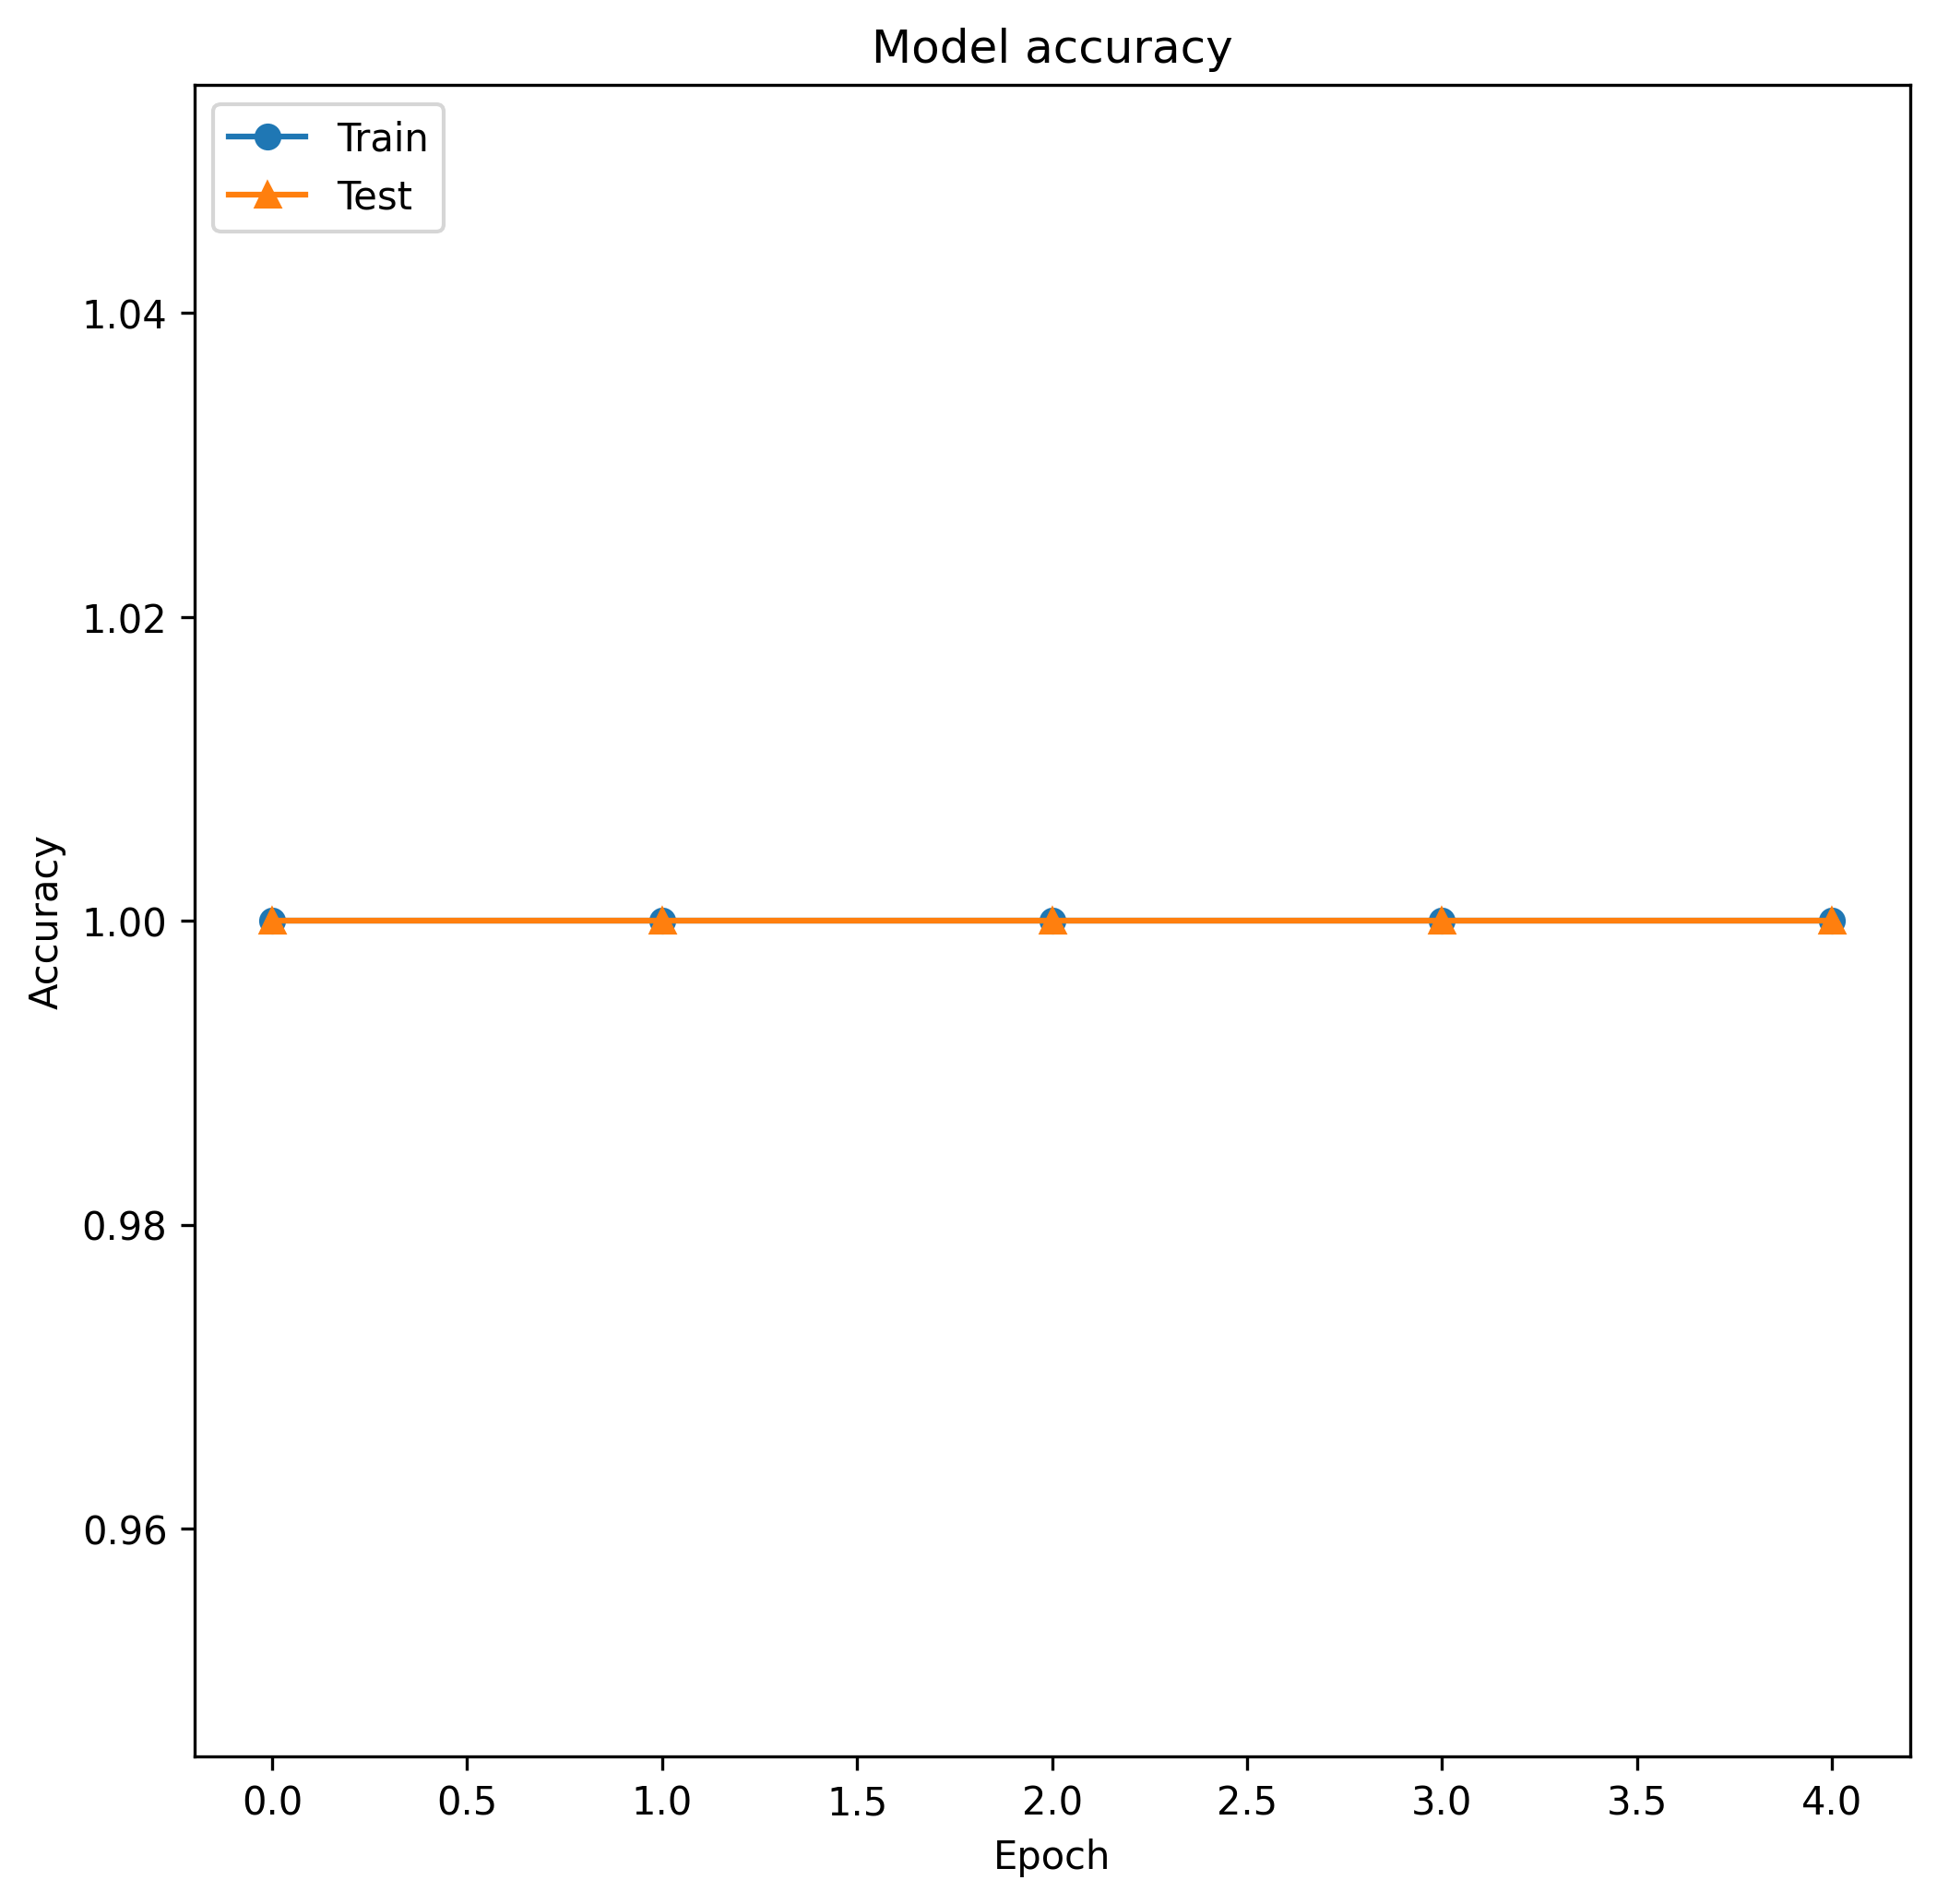

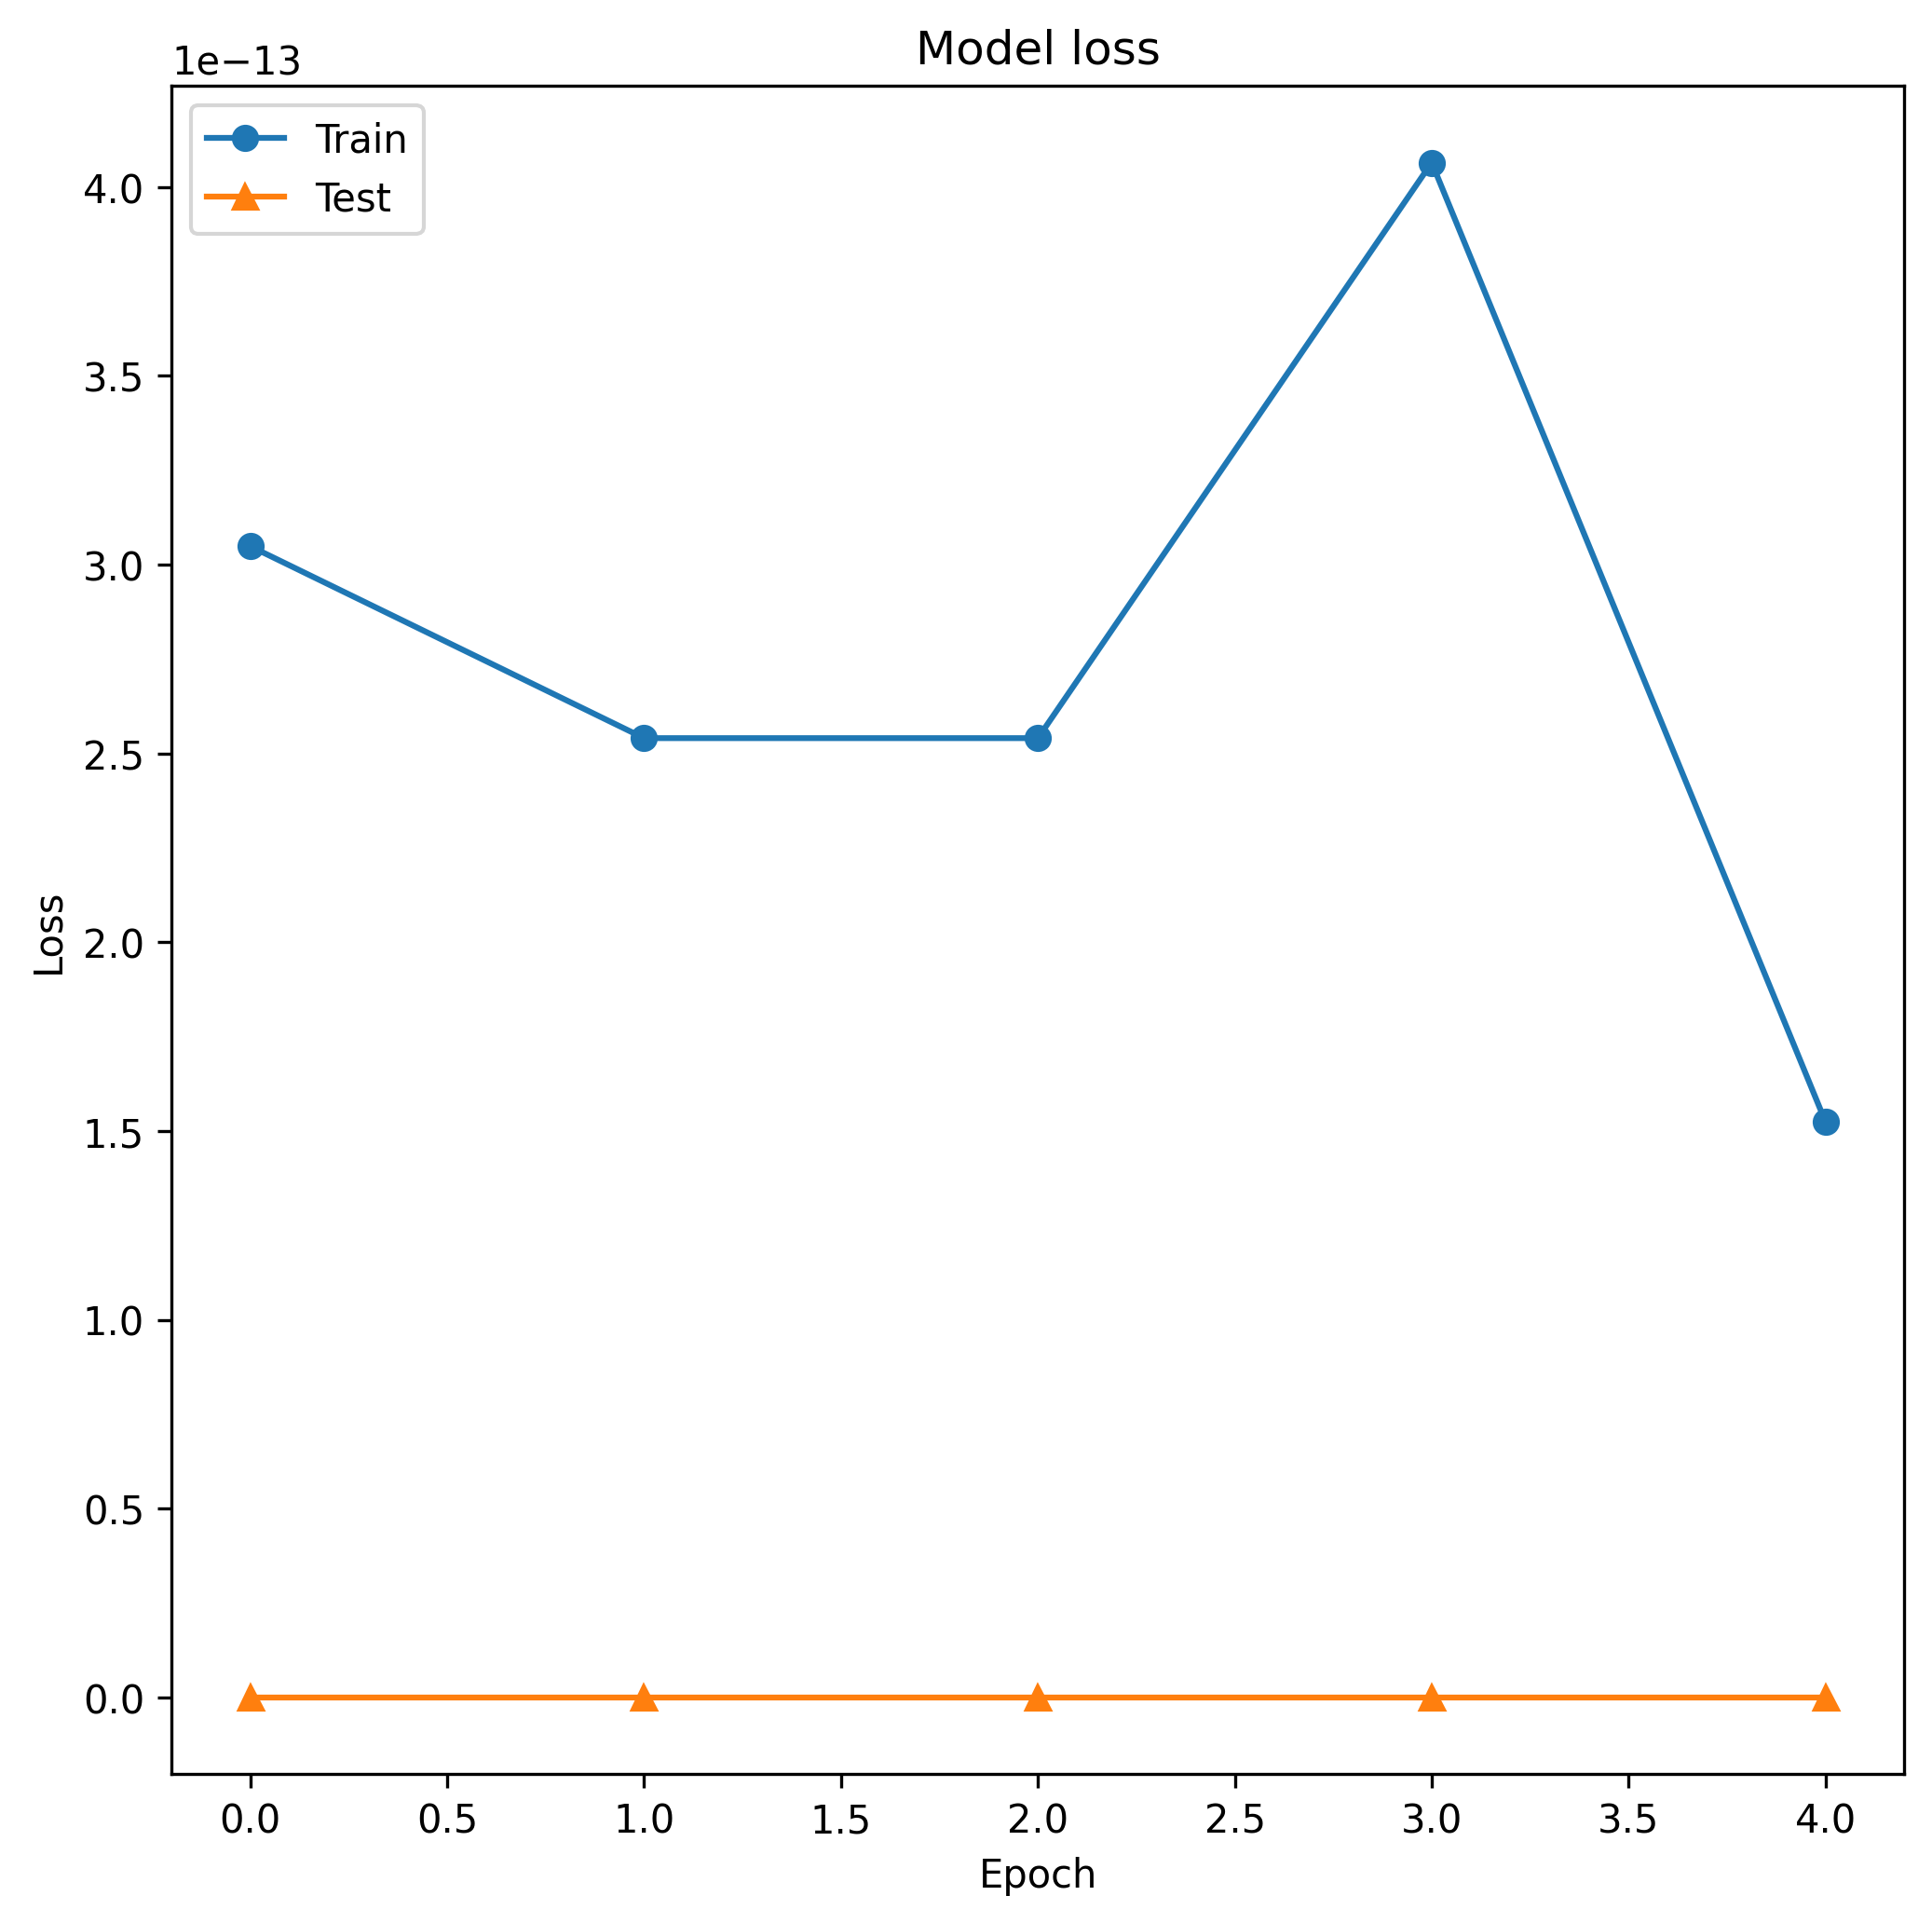

In [13]:
#----------------------------------第五步 可视化--------------------------------
# 绘制训练 & 验证的准确率值,用点表示
plt.figure(figsize=(8,8),dpi=300)
plt.plot(history.history['accuracy'], 'o-')
plt.plot(history.history['val_accuracy'], '^-')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
# plt.savefig('cnn_bilstm_accuracy.png')
plt.show()

plt.figure(figsize=(8,8),dpi=300)
# 绘制训练 & 验证的损失值,用三角表示
plt.plot(history.history['loss'], 'o-')
plt.plot(history.history['val_loss'], '^-')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
# plt.savefig('cnn_bilstm_loss.png')
plt.show()


In [14]:
print("模型预测")
mainModel = load_model('model_intra\\cnn_bilstm_model2_DoS.h5', custom_objects={'AttentionLayer': AttentionLayer(50)}, compile=False)
# 预测


模型预测


In [15]:
# import time
# from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# # 计算预测时间
# start_time = time.time()  # 记录开始时间
# test_pre = mainModel.predict(testSeq)
# end_time = time.time()  # 记录结束时间
# average_prediction_time = (end_time - start_time) / len(testSeq)
# print("Average Prediction Time per Data Point: {:.6f} seconds".format(average_prediction_time))

# confm = confusion_matrix(np.argmax(y_test.values, axis=1), np.argmax(test_pre, axis=1))

# # Calculate the false positive rate
# tn, fp, fn, tp = confm.ravel()
# false_positive_rate = fp / (fp + tn)
# print("False Positive Rate: {:.4f}".format(false_positive_rate))

# print(confm)

# print(classification_report(np.argmax(y_test.values, axis=1), np.argmax(test_pre, axis=1), digits=4))
# print("Accuracy:", accuracy_score(np.argmax(y_test.values, axis=1), np.argmax(test_pre, axis=1)))

# plt.figure(figsize=(8, 8), dpi=300)
# sns.heatmap(confm, square=True, annot=True,
#             fmt='d', cbar=False, linewidths=.6,
#             cmap="Blues")
# plt.xlabel('Predicted label', size=14)
# plt.ylabel('True label', size=14)
# Labname = ['Normal', 'DoS']  # 行列名
# plt.xticks(np.arange(2) + 0.5, Labname, size=12)
# plt.yticks(np.arange(2) + 0.5, Labname, size=12)

# plt.show()


Average Prediction Time per Data Point: 0.000082 seconds
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000    615868
           1     1.0000    1.0000    1.0000    117287

    accuracy                         1.0000    733155
   macro avg     1.0000    1.0000    1.0000    733155
weighted avg     1.0000    1.0000    1.0000    733155

Accuracy:1.0000
MCC:1.0000
Kappa:1.0000
False Positive Rate (Benign samples misclassified as attacks): 0.0000


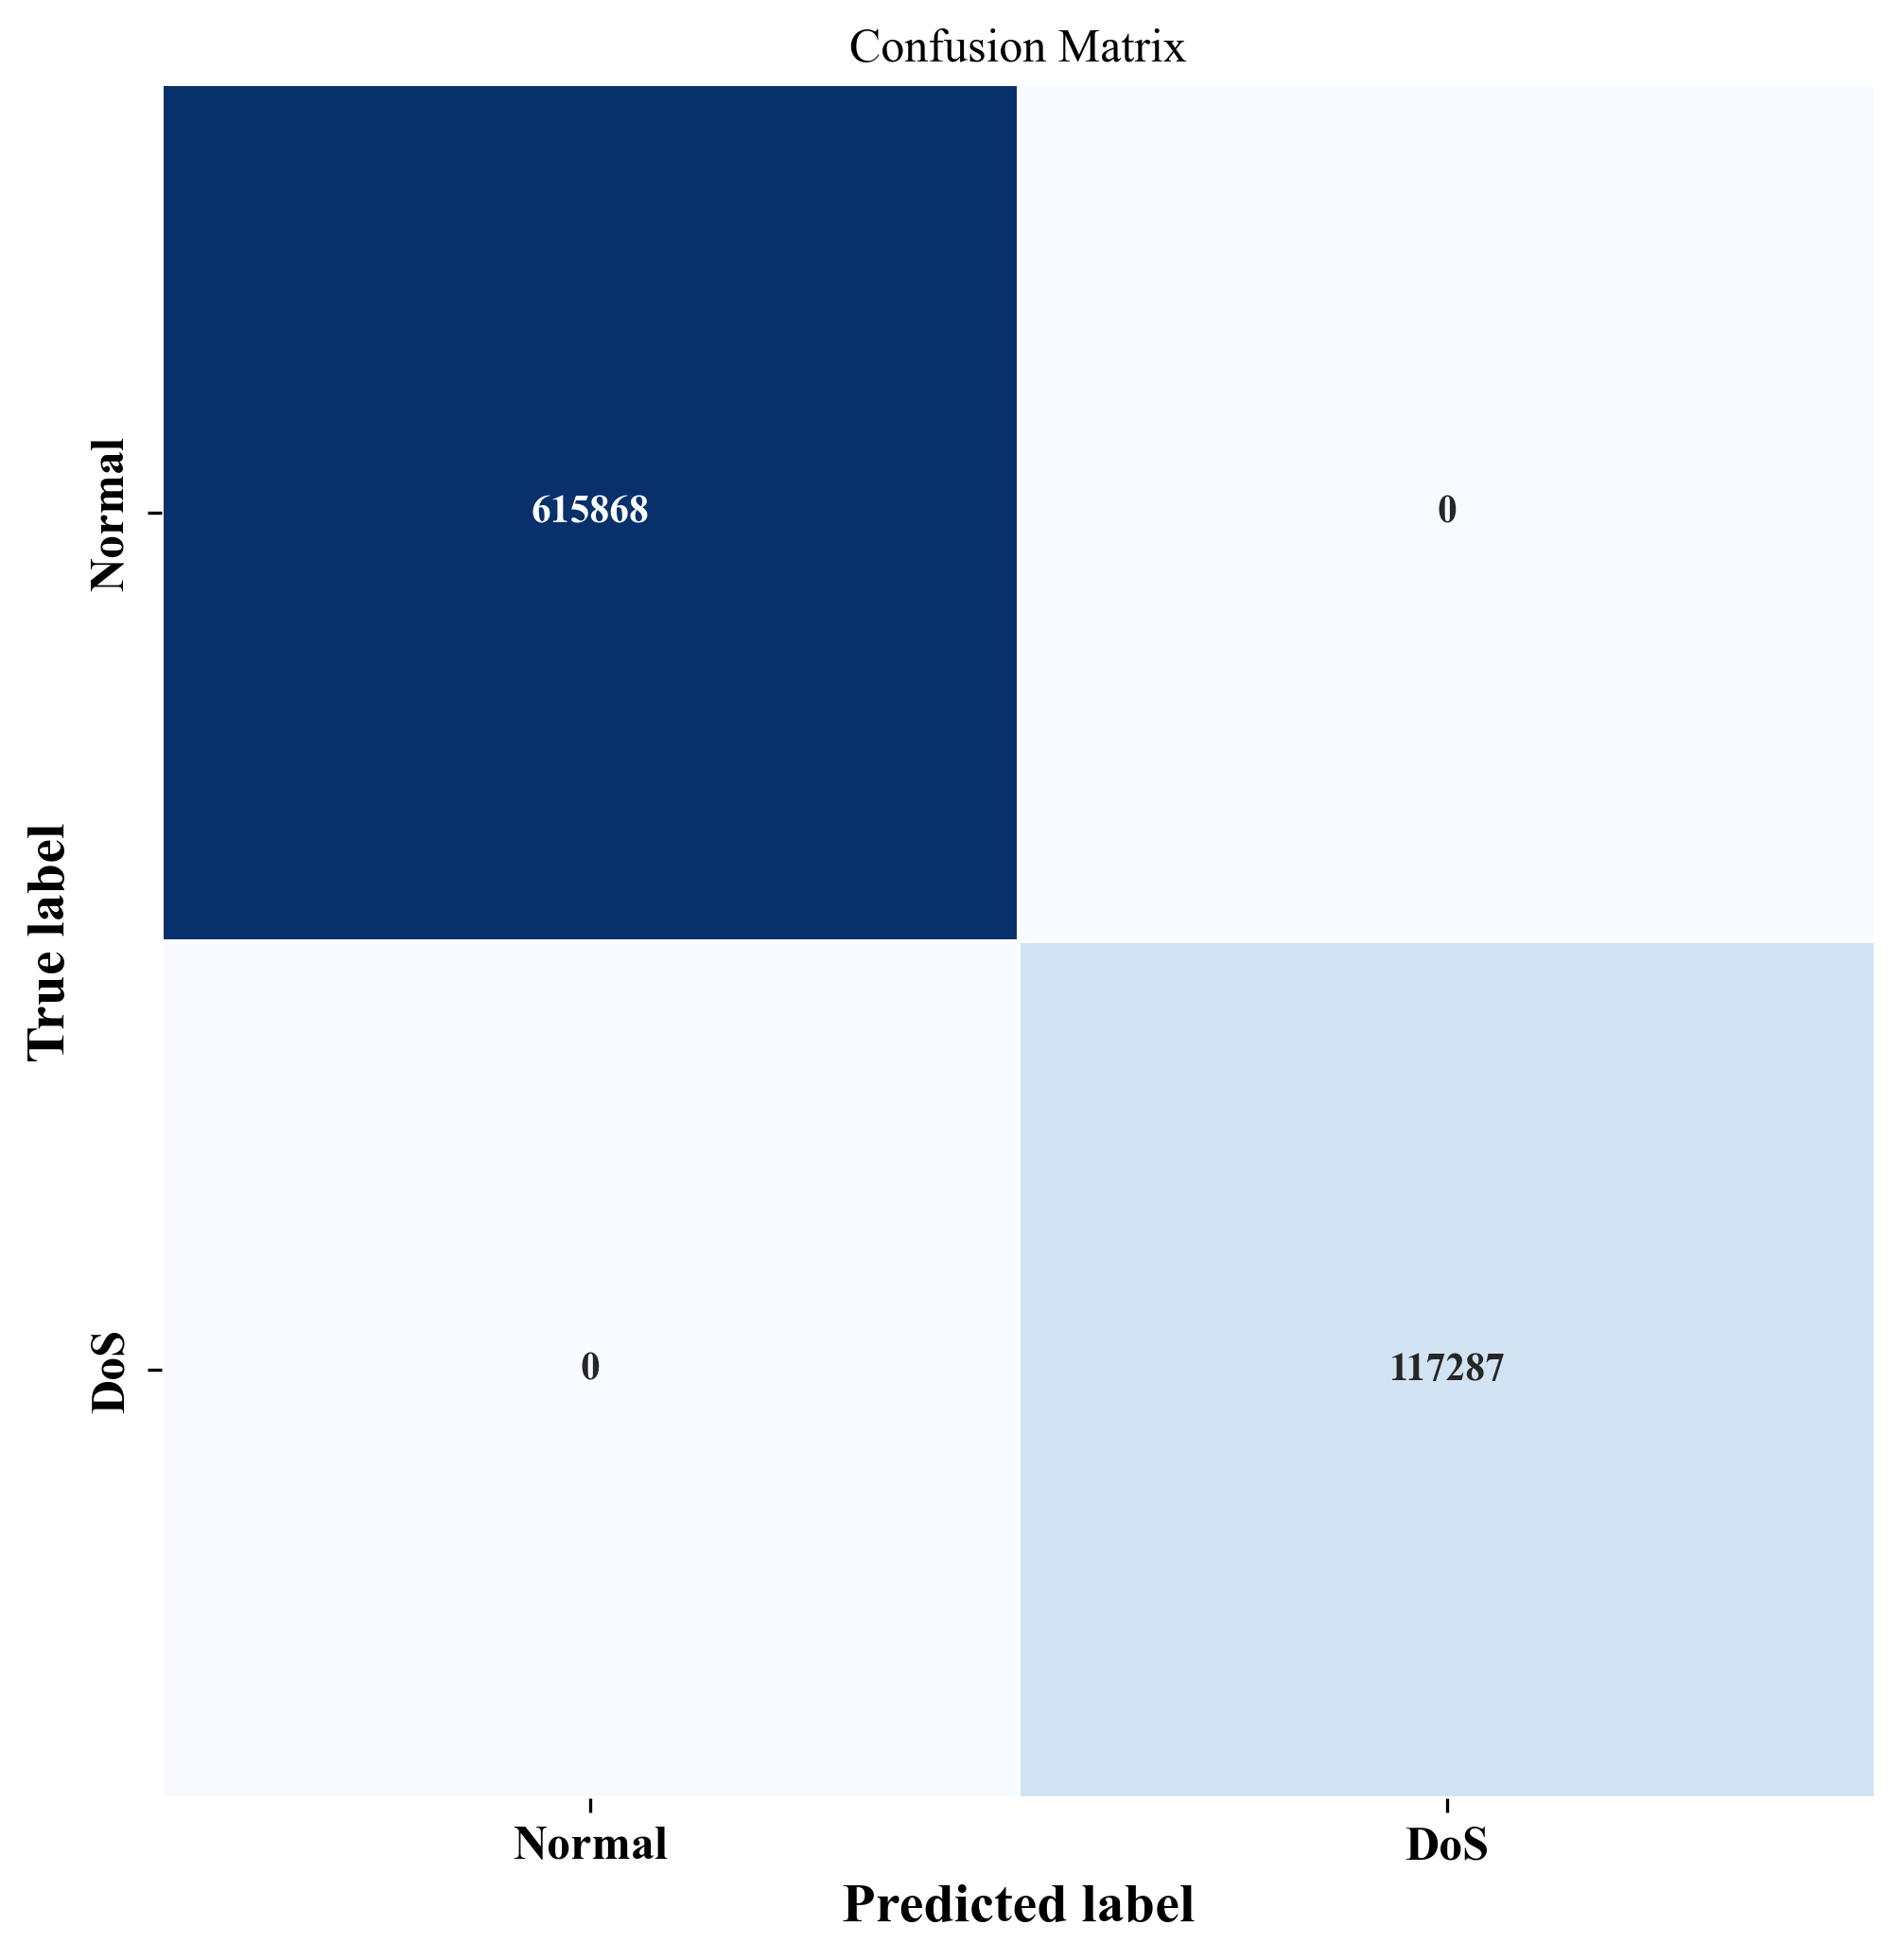

In [16]:
# 计算预测时间
start_time = time.time()  # 记录开始时间
test_pre = mainModel.predict(testSeq)
end_time = time.time()  # 记录结束时间
average_prediction_time = (end_time - start_time) / len(testSeq)
print("Average Prediction Time per Data Point: {:.6f} seconds".format(average_prediction_time))

# 计算混淆矩阵
confm = metrics.confusion_matrix(np.argmax(y_test, axis=1), np.argmax(test_pre, axis=1))
# 计算classification_report
print(metrics.classification_report(np.argmax(y_test, axis=1),
                                    np.argmax(test_pre, axis=1),
                                    digits=4))
# 计算准确度
accuracy = metrics.accuracy_score(np.argmax(y_test, axis=1),
                                          np.argmax(test_pre, axis=1))
print("Accuracy:{:.4f}".format(accuracy))
# 计算MCC
mcc = metrics.matthews_corrcoef(np.argmax(y_test, axis=1),
                                          np.argmax(test_pre, axis=1))
print("MCC:{:.4f}".format(mcc))
# 计算kappa
kappa = metrics.cohen_kappa_score(np.argmax(y_test, axis=1),
                                          np.argmax(test_pre, axis=1))
print("Kappa:{:.4f}".format(kappa))
# 计算误报率（False Positive Rate）
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(test_pre, axis=1)
false_positives = np.sum((y_true == 0) & (y_pred != 0))  # 0 represents the "Benign" class
total_benign_samples = np.sum(y_true == 0)
false_positive_rate = false_positives / total_benign_samples
print("False Positive Rate (Benign samples misclassified as attacks): {:.4f}".format(false_positive_rate))

# 画图
#设置所有图片的字体大小为10，字体为Times New Roman，字体为粗体，label的字体大小为10，字体为Times New Roman，字体为粗体
plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'

plt.figure(figsize=(8, 8), dpi=300)
sns.heatmap(confm, square=True, annot=True,
            fmt='d', cbar=False, linewidths=.6,
            cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted label', size=14)
plt.ylabel('True label', size=14)
Labname = ['Normal', 'DoS']  # 行列名
plt.xticks(np.arange(2) + 0.5, Labname, size=12)
plt.yticks(np.arange(2) + 0.5, Labname, size=12)
plt.show()


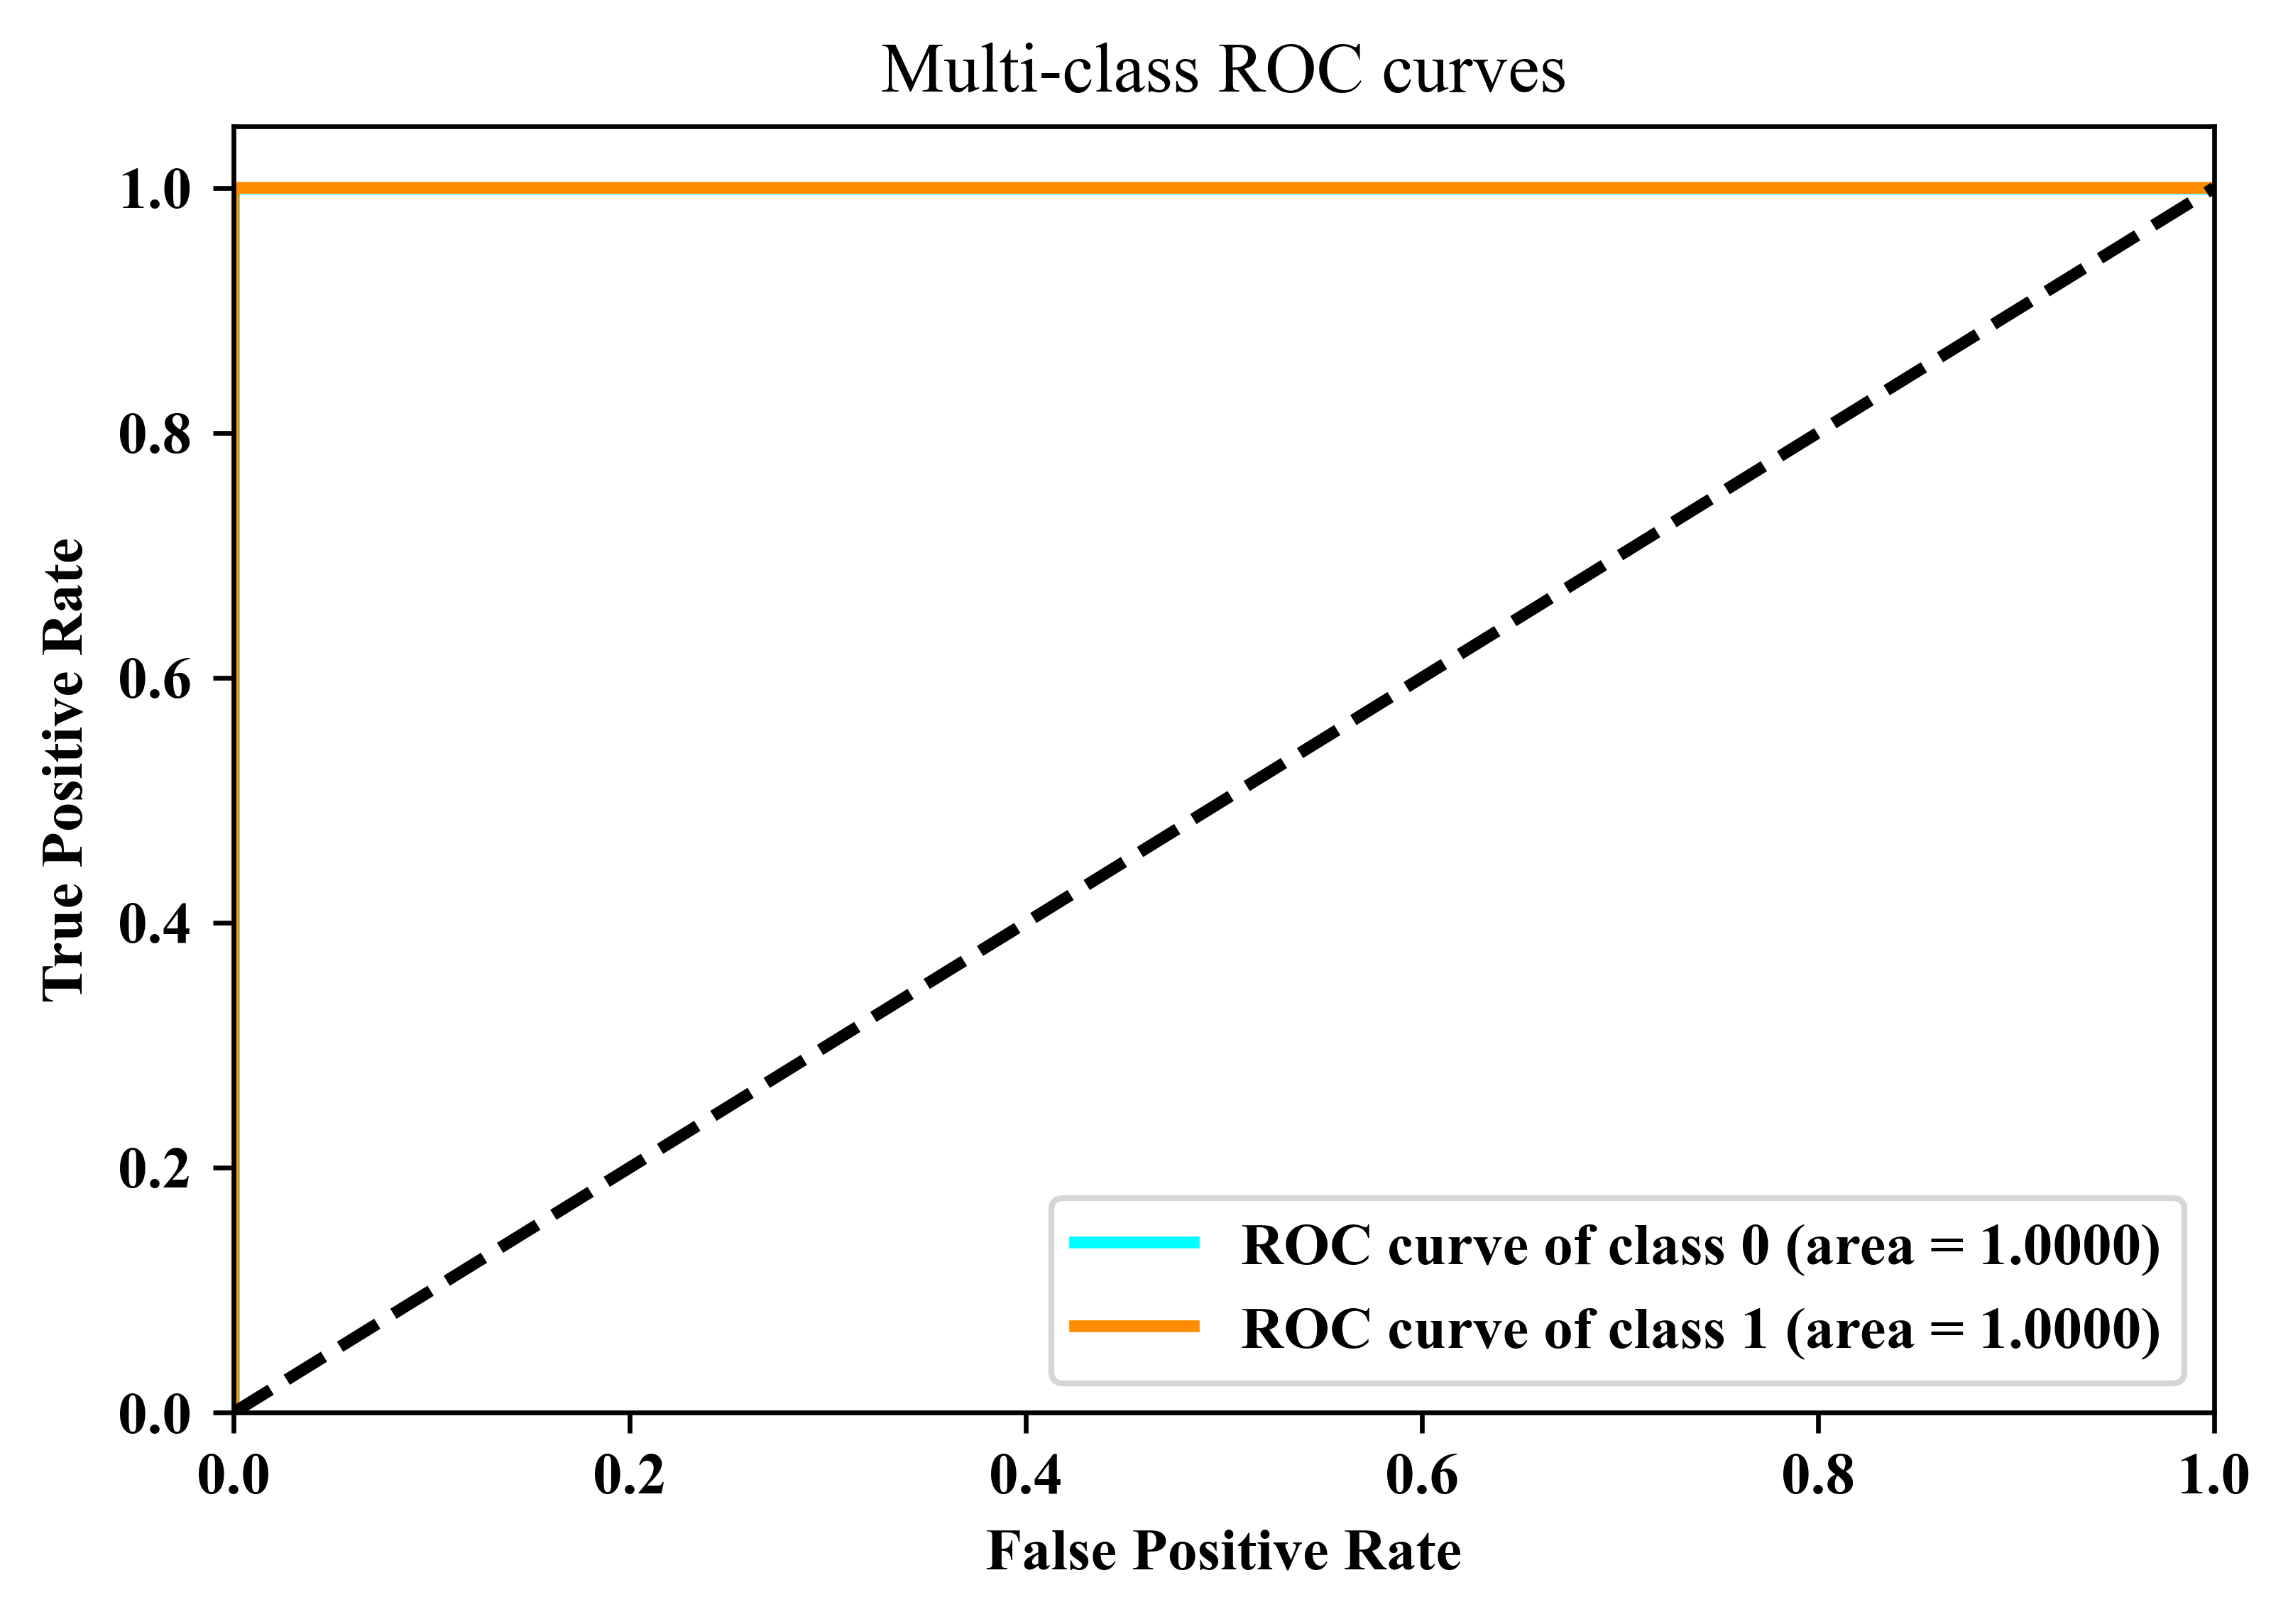

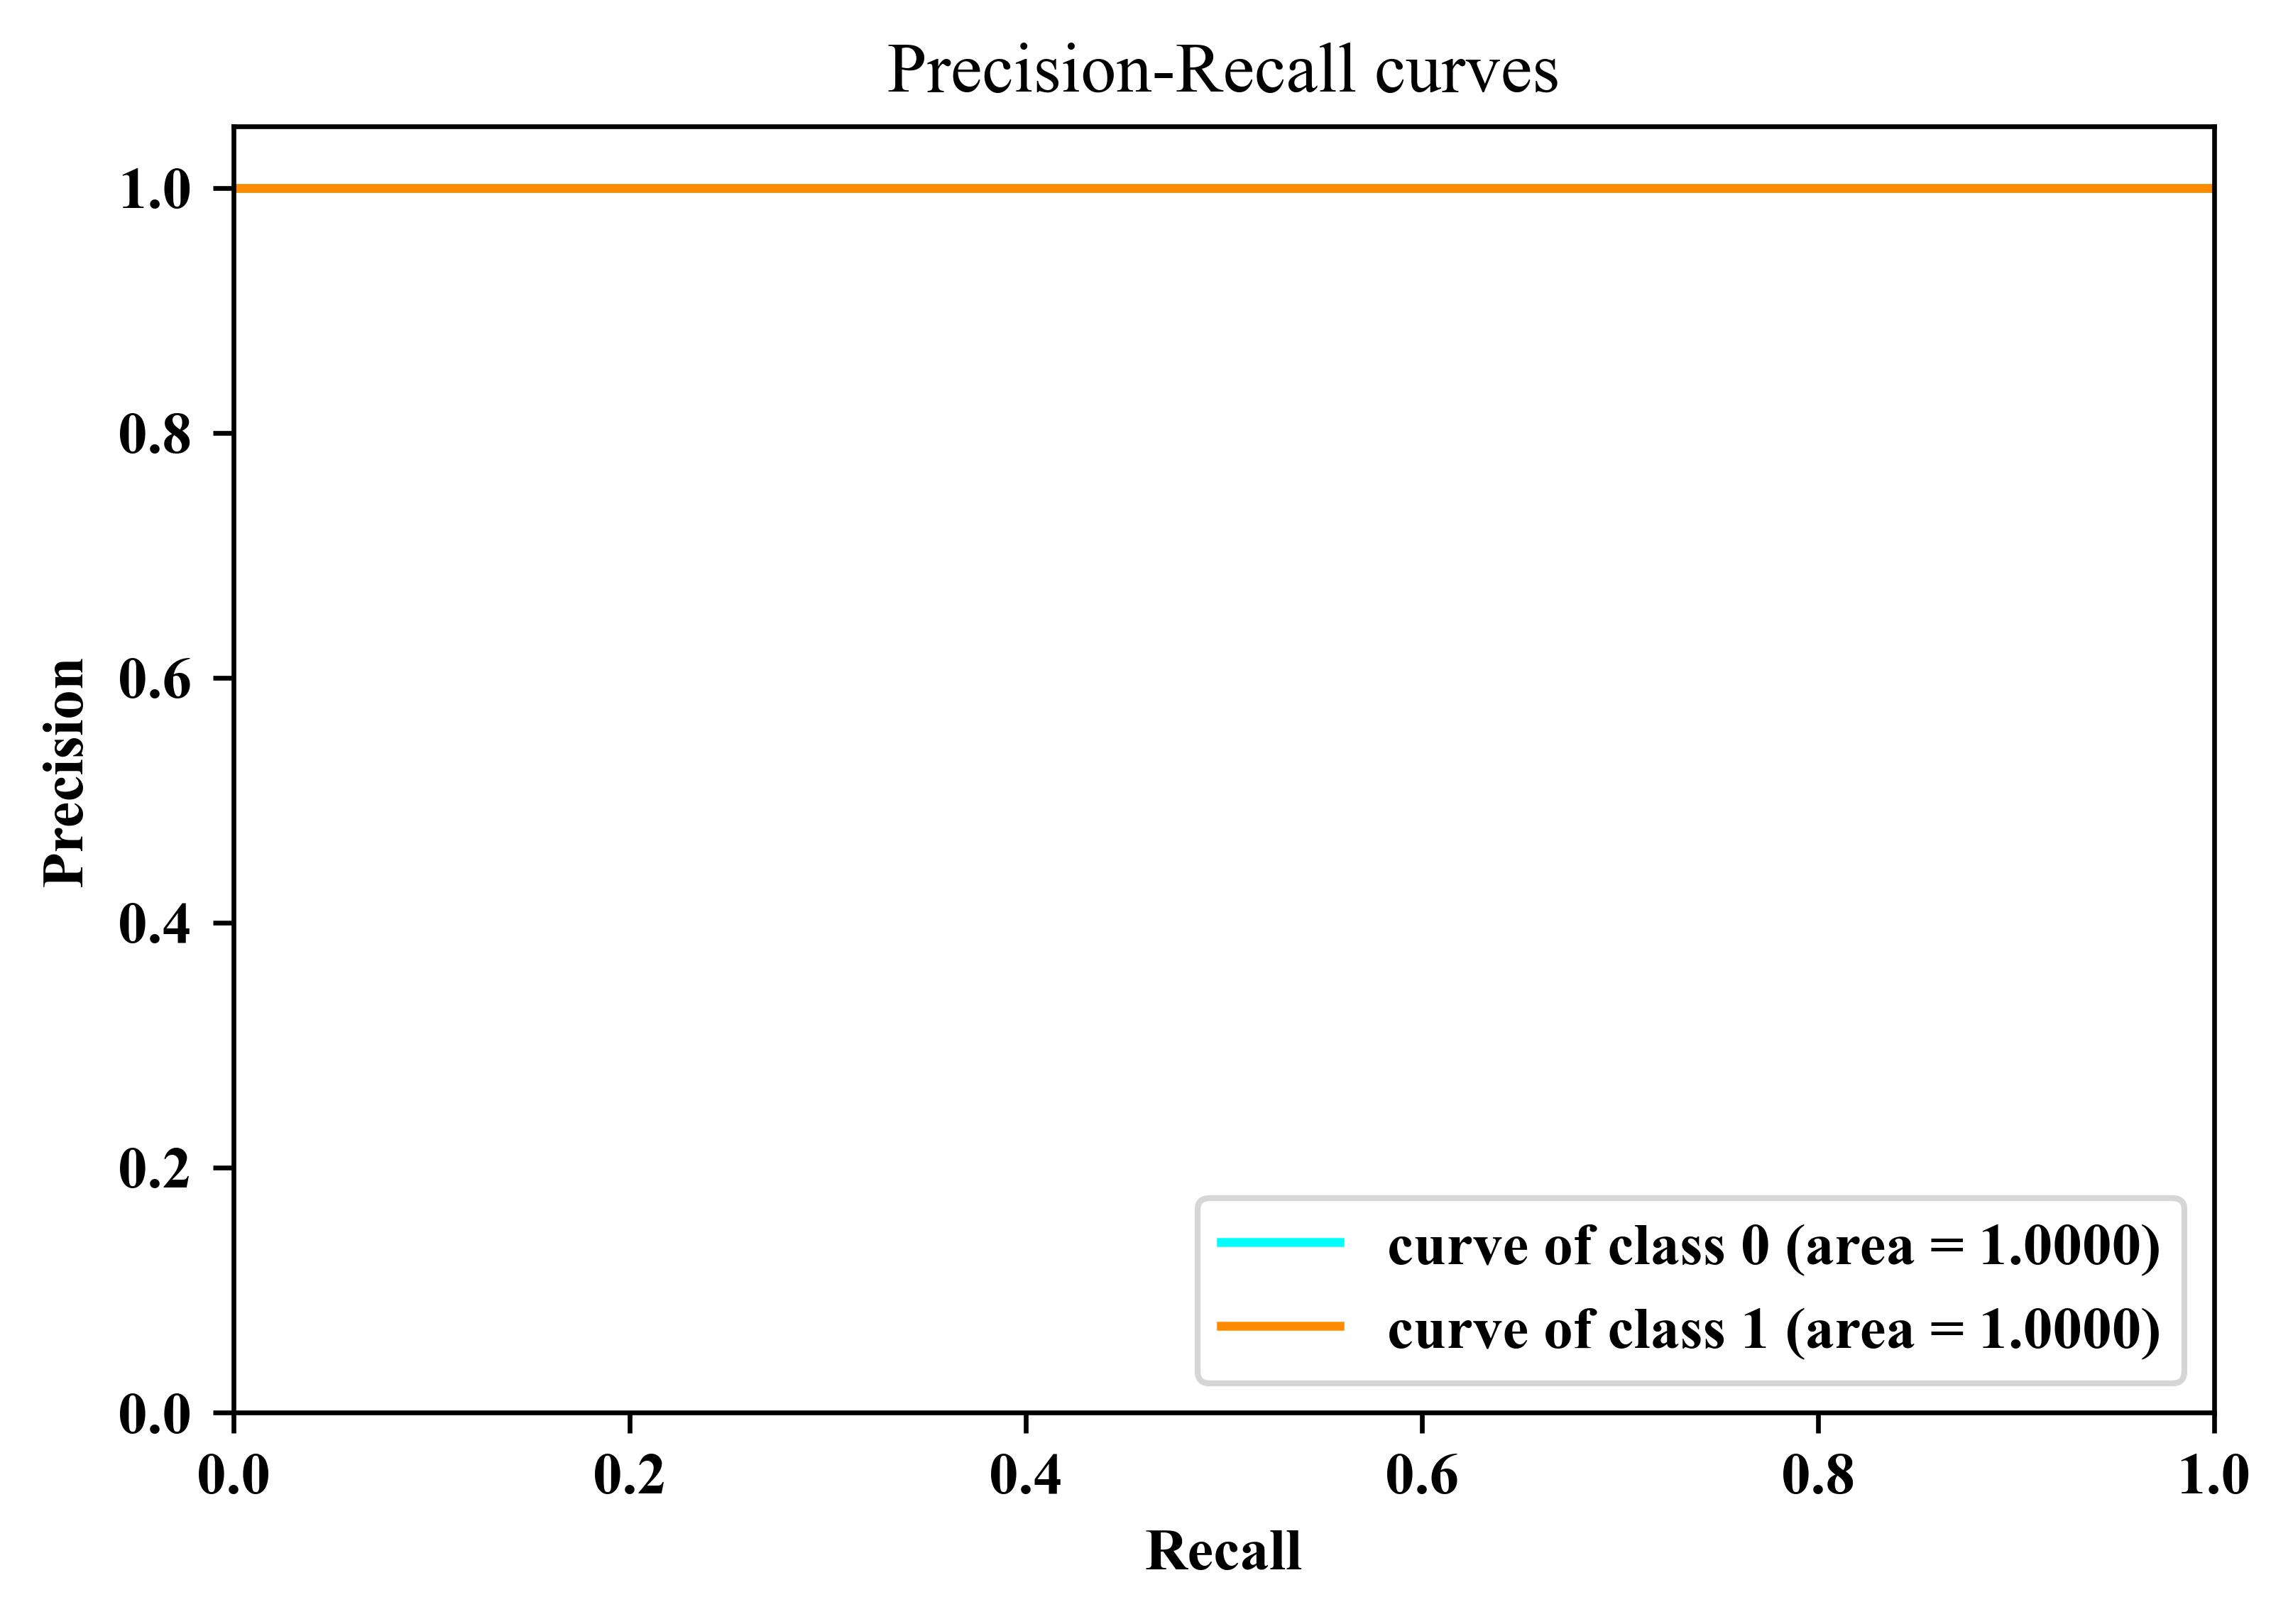

In [17]:

# Compute ROC curve and ROC area for each class
n_classes = 2
# Compute ROC curve and ROC area for each class
# 保存每一类的fpr和tpr值到csv文件，便于后续画图
fpr = dict()
tpr = dict()
roc_auc = dict()
thresholds = dict()
for i in range(n_classes):
    fpr[i], tpr[i], thresholds[i] = metrics.roc_curve(y_test[:, i], test_pre[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    df = pd.DataFrame({'fpr':fpr[i],'tpr':tpr[i]})
    df.to_csv('./Results/intra_adam_Dos_fpr_tpr_{}.csv'.format(i))
# 画图AUC-ROC
plt.figure(dpi=600)
lw = 2
colors = cycle(["aqua", "darkorange", "darkgreen", "yellow", "red", "purple", "blue", "gray"])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
    label="ROC curve of class {0} (area = {1:0.4f})".format(i, roc_auc[i]),)
plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('Multi-class ROC curves')
plt.legend(loc="lower right")
plt.show()



# Compute auc-pr and AP(average precision) for each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = metrics.precision_recall_curve(y_test[:, i], test_pre[:, i])
    average_precision[i] = metrics.average_precision_score(y_test[:, i], test_pre[:, i])
    df = pd.DataFrame({'precision':precision[i],'recall':recall[i]})
    df.to_csv('./Results/intra_adam_DoS_precision_recall_{}.csv'.format(i))
# 绘制所有类别的pr曲线
plt.figure(dpi=600)
lw = 2
colors = cycle(["aqua", "darkorange", "darkgreen", "yellow", "red", "purple", "blue", "gray"])
for i, color in zip(range(n_classes), colors):
    plt.step(recall[i], precision[i], color=color, where="post", label="curve of class {0} (area = {1:0.4f})".format(i, average_precision[i]))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title("Precision-Recall curves")
plt.legend(loc="lower right")
plt.show()   


In [18]:
# import time  # 导入时间模块

# # 计算预测时间
# start_time = time.time()  # 记录开始时间
# test_pre = mainModel.predict(testSeq)
# # print(test_pre.shape) #(733155, 2)
# end_time = time.time()  # 记录结束时间
# average_prediction_time = (end_time - start_time) / len(testSeq)
# print("Average Prediction Time per Data Point: {:.6f} seconds".format(average_prediction_time))

# confm = metrics.confusion_matrix(np.argmax(y_test.values,axis=1),np.argmax(test_pre,axis=1))
# print(confm)

# print(metrics.classification_report(np.argmax(y_test.values,axis=1),
#                                     np.argmax(test_pre,axis=1),
#                                     digits=4))
# print("Accuracy",metrics.accuracy_score(np.argmax(y_test.values,axis=1),
#                                 np.argmax(test_pre,axis=1)))

# plt.figure(figsize=(8,8),dpi=300)
# sns.heatmap(confm, square=True, annot=True,
#             fmt='d', cbar=False, linewidths=.6,
#             cmap="YlGnBu")
# plt.xlabel('Predicted label',size = 14)
# plt.ylabel('True label', size = 14)
# Labname = ['Normal','DoS']  #行列名
# plt.xticks(np.arange(2)+0.5, Labname, size = 12)
# plt.yticks(np.arange(2)+0.5, Labname, size = 12)

# plt.show()


## 二分类：处理数据（Fuzzy）

In [19]:
#--------------------------------------第一步 数据预处理--------------------------------
import csv
import pandas as pd
import time
# 打开CSV文件
with open('Data\9) Car-Hacking Dataset\Fuzzy_dataset.csv', 'r') as file:
    # 创建CSV读取器
    reader = csv.reader(file)
    # 创建空列表来存储处理后的数据
    processed_data = []

    # 记录开始时间
    start_time = time.time()

    # 读取CSV文件中的每一行数据
    for row in reader:
        # 处理每一行数据

        # 获取最后一列作为标签
        label = row[-1]
        # 将第二列数据的两个16进制数据，拆分为两个16进制字符串，即0316拆分为"03"和"16"
        hex_data1 = row[1][0:2]
        hex_data2 = row[1][2:]
        row[1] = row[1][0:2] + ' ' + row[1][2:]
        # 将第四到倒数第二列的值转化为字符串
        new_col = ' '.join(map(str, row[3:-1]))
        new_col = hex_data1 + ' ' + hex_data2 + ' ' + new_col
        
        # 示例：将处理后的数据添加到列表中
        processed_data.append((new_col, label))

    # 记录结束时间
    end_time = time.time()

    # Calculate the total processing time
    total_processing_time = end_time - start_time

    # 使用pandas.DataFrame()函数将列表转化为数据框
    Fuzzy_dataset = pd.DataFrame(processed_data, columns=['DATA', 'Flag'])

    # Calculate the average processing time
    dataset_size = len(processed_data)
    average_processing_time = total_processing_time / dataset_size
    print("Total Processing Time: {:.6f} seconds".format(total_processing_time))
    print("Average Processing Time per Row: {:.6f} seconds".format(average_processing_time))

Fuzzy_dataset


Total Processing Time: 8.118986 seconds
Average Processing Time per Row: 0.000002 seconds


DATA Flag
0        05 45 d8 00 00 8a 00 00 00 00    R
1                 02 b0 ff 7f 00 05 49    R
2        00 02 00 00 00 00 00 01 07 15    R
3        01 53 00 21 10 ff 00 ff 00 00    R
4        01 30 19 80 00 ff fe 7f 07 60    R
...                                ...  ...
3838855  01 8f fe 59 00 00 00 41 00 00    R
3838856  02 60 18 21 21 30 08 8f 6d 19    R
3838857  02 a0 24 00 9a 1d 97 02 bd 00    R
3838858  03 29 dc b7 7f 14 11 20 00 14    R
3838859  05 45 d8 00 00 8b 00 00 00 00    R

[3838860 rows x 2 columns]

In [20]:
# 将Flag中的Nomal和Attack转换为0和1，不使用LabelEncoder
from sklearn.preprocessing import OneHotEncoder
Fuzzy_dataset['Flag'] = Fuzzy_dataset['Flag'].replace({'R': 0.0, 'T': 1.0})
print(Fuzzy_dataset['Flag'].value_counts())

# 将Class和SubClass转换为OneHotEncoder
# one_hot_encoded = pd.get_dummies(Fuzzy_dataset['Flag'])
# print(one_hot_encoded)
from keras.utils import np_utils
one_hot_encoded = np_utils.to_categorical(Fuzzy_dataset['Flag'])

0.0    3347013
1.0     491847
Name: Flag, dtype: int64


In [21]:
# 取出数据集中除了标签以外的数据
Fuzzy_X = Fuzzy_dataset.drop(['Flag'], axis=1)

# 将数据集划分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(Fuzzy_X, one_hot_encoded, test_size=0.2, random_state=0)
print(y_train.shape)
print(y_test.shape)

(3071088, 2)
(767772, 2)


In [22]:
content = Fuzzy_X['DATA']
# print(content)
# print(content)
# 使用Tokenizer对词组进行编码
# 特征编号，不足的前面补0
# fit_on_texts函数可以将输入的文本每个词编号 编号根据词频(词频越大编号越小)
max_words = 256 ##使用的最大词语数为1000
maxLen = 10 #句子的长度最多为8
# 计算对整个数据集的词进行词频统计的时间

start_time1 = time.time()
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(content)
end_time1 = time.time()
process_time1 = (end_time1 - start_time1) / len(content)  # Calculate average time per data point
vocab = tokenizer.word_index  #停用词已过滤,获取每个词的编号
# print(vocab)

# 使用word_index属性可以看到每次词对应的编码
# 使用word_counts属性可以看到每个词对应的频数
# print(tokenizer.word_index)
# print(tokenizer.word_counts)

"""
# 使用Tokenizer对词组进行编码
# 当我们创建了一个Tokenizer对象后，使用该对象的fit_on_texts()函数，以空格去识别每个词
# 可以将输入的文本中的每个词编号，编号是根据词频的，词频越大，编号越小
"""

# 将train_value中的字符串按照空格进行分割
train_content = X_train['DATA']
test_content = X_test['DATA']
# print(train_content)
# print(test_content)

# 特征编号，将一句话表示为词编码的序列
# 计算由数据流转化为由词编码组成序列的时间
start_time2 = time.time()
trainID = tokenizer.texts_to_sequences(train_content)
end_time2 = time.time()
process_time2 = (end_time2 - start_time2) / len(train_content)  # Calculate average time per data point
testID = tokenizer.texts_to_sequences(test_content)
# print(trainID)
# print(testID)
# 该方法会让CNN训练的长度统一,(不足的前面补0)，使用sequence.pad_sequences()将每个序列调整为相同的长度
# 计算转化为的序列进行填充和截断的时间
start_time3 = time.time()
trainSeq = sequence.pad_sequences(trainID, maxlen=maxLen)
end_time3 = time.time()
process_time3 = (end_time3 - start_time3) / len(train_content)  # Calculate average time per data point
testSeq = sequence.pad_sequences(testID, maxlen=maxLen)

# print(trainSeq)
# print(testSeq)

print("Average Time for Word Frequency Count: {:.6f} seconds".format(process_time1))
print("Average Time for Converting Data to Sequences: {:.6f} seconds".format(process_time2))
print("Average Time for Padding and Truncating Sequences: {:.6f} seconds".format(process_time3))


Average Time for Word Frequency Count: 0.000006 seconds
Average Time for Converting Data to Sequences: 0.000006 seconds
Average Time for Padding and Truncating Sequences: 0.000002 seconds


In [23]:
average_preprocess_time = average_processing_time + process_time1 + process_time2 + process_time3
print("Average Preprocessing Time per Data Point: {:.6f} seconds".format(average_preprocess_time))

Average Preprocessing Time per Data Point: 0.000015 seconds


In [24]:
# 建立Attention机制
# Keras自定义的函数主要分为四个部分，分别是：
#   init：初始化一些需要的参数
#   bulid：具体来定义权重是怎么样的
#   call：核心部分，定义向量是如何进行运算的
#   compute_output_shape：定义该层输出的大小
# Hierarchical Model with Attention
from keras import initializers
from keras import constraints
from keras import activations
from keras import regularizers
from keras import backend as K
from keras.layers import Layer

K.clear_session()

class AttentionLayer(Layer):
    def __init__(self, attention_size=None, **kwargs):
        self.attention_size = attention_size
        super(AttentionLayer, self).__init__(**kwargs)
        
    def get_config(self):
        config = super().get_config()
        config['attention_size'] = self.attention_size
        return config
        
    def build(self, input_shape):
        assert len(input_shape) == 3
        
        self.time_steps = input_shape[1] #时间步为256
        hidden_size = input_shape[2] #隐藏层大小为128
        if self.attention_size is None:
            self.attention_size = hidden_size #默认为128
            
        self.W = self.add_weight(name='att_weight', shape=(hidden_size, self.attention_size),
                                initializer='uniform', trainable=True)
        self.b = self.add_weight(name='att_bias', shape=(self.attention_size,),
                                initializer='uniform', trainable=True)
        self.V = self.add_weight(name='att_var', shape=(self.attention_size,),
                                initializer='uniform', trainable=True)
        super(AttentionLayer, self).build(input_shape)

    
    
    def call(self, inputs):
        #self.V = K.reshape(self.V, (-1, 1))
        V = K.reshape(self.V, (-1, 1))
        H = K.tanh(K.dot(inputs, self.W) + self.b)
        #score = K.softmax(K.dot(H, self.V), axis=1)
        score = K.softmax(K.dot(H, V), axis=1)
        outputs = K.sum(score * inputs, axis=1)
        return outputs
    
    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[2]

In [25]:
# 建立Attention+CNN模型并训练
#构建TextCNN模型
num_labels = 2
inputs = Input(name='inputs',shape=[maxLen], dtype='float64')
#  Example:
#   >>> model = tf.keras.Sequential()
#   >>> model.add(tf.keras.layers.Embedding(1000, 64, input_length=10))
#   >>> # The model will take as input an integer matrix of size (batch,
#   >>> # input_length), and the largest integer (i.e. word index) in the input
#   >>> # should be no larger than 999 (vocabulary size). 意思就是输入的矩阵是一个batch*input_length的矩阵，每个元素是一个0-vocabulary size的整数
#   >>> # Now model.output_shape is (None, 10, 64), where `None` is the batch
#   >>> # dimension.
#   >>> input_array = np.random.randint(1000, size=(32, 10))
#   >>> model.compile('rmsprop', 'mse')
#   >>> output_array = model.predict(input_array)
#   >>> print(output_array.shape)
#   (32, 10, 64)
layer = Embedding(max_words+1, 128, input_length=maxLen, trainable=True)(inputs)
cnn1 = Convolution1D(64, 3, padding='same', strides = 1, activation='relu')(layer)
cnn1 = MaxPool1D(pool_size=4)(cnn1)
cnn2 = Convolution1D(64, 4, padding='same', strides = 1, activation='relu')(layer)
cnn2 = MaxPool1D(pool_size=4)(cnn2)
cnn3 = Convolution1D(64, 5, padding='same', strides = 1, activation='relu')(layer)
cnn3 = MaxPool1D(pool_size=4)(cnn3)

# 合并三个模型的输出向量
cnn = concatenate([cnn1,cnn2,cnn3], axis=-1)

# BiLSTM+Attention
# bilstm = Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.1, return_sequences=True))(cnn)
bilstm = Bidirectional(LSTM(128, return_sequences=True))(cnn)  #参数保持维度3
layer = Dense(256, activation='relu')(bilstm)
layer = Dropout(0.3)(layer)
attention = AttentionLayer(attention_size=50)(layer)

output = Dense(num_labels, activation='softmax')(attention)
model = Model(inputs=inputs, outputs=output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 10)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 10, 128)      32896       inputs[0][0]                     
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 10, 64)       24640       embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 10, 64)       32832       embedding[0][0]                  
______________________________________________________________________________________________

In [26]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from sklearn.model_selection import StratifiedKFold
import time


accuracy_score_list,recall_score_list,precision_score_list,f1_score_list = [],[],[],[]
# 编译模型
adam = keras.optimizers.adam_v2.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=["accuracy"])

# 定义5折交叉验证
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 记录开始时间
start_time = time.time()

# 开始交叉验证
for train_index, val_index in kfold.split(trainSeq, np.argmax(y_train,axis=1)):
    X_train_fold, X_val_fold = trainSeq[train_index],trainSeq[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    print(X_train_fold.shape, X_val_fold.shape, y_train_fold.shape, y_val_fold.shape)


    # 训练模型
    history = model.fit(X_train_fold, y_train_fold, epochs=5, batch_size=1024, validation_data=(X_val_fold, y_val_fold),verbose=1)
    y_pred = model.predict(X_val_fold)
    print(y_pred.shape)
    print(history.history)
    # 评估模型
    AccuracyScore = metrics.accuracy_score(np.argmax(y_val_fold,axis=1),np.argmax(y_pred,axis=1))
    RecallScore = metrics.recall_score(np.argmax(y_val_fold,axis=1),np.argmax(y_pred,axis=1),average='macro')
    PrecisionScore = metrics.precision_score(np.argmax(y_val_fold,axis=1),np.argmax(y_pred,axis=1),average='macro')
    F1Score = metrics.f1_score(np.argmax(y_val_fold,axis=1),np.argmax(y_pred,axis=1),average='macro')
    # 将评估指标存放对应的列表中
    accuracy_score_list.append(AccuracyScore)
    recall_score_list.append(RecallScore)
    precision_score_list.append(PrecisionScore)
    f1_score_list.append(F1Score)
        # 打印每一次训练的正确率、召回率、F1值
    print('accuracy_score:',AccuracyScore,'recall_score:',RecallScore,'precision_score',PrecisionScore,'f1_score:',F1Score)
# 打印各指标的平均值和95%的置信区间
print("Accuracy: %0.4f (+/- %0.4f)" % (np.average(accuracy_score_list), np.std(accuracy_score_list) * 2))
print("Recall: %0.4f (+/- %0.4f)" % (np.average(recall_score_list), np.std(recall_score_list) * 2))
print("Precision: %0.4f (+/- %0.4f)" % (np.average(precision_score_list), np.std(precision_score_list) * 2))
print("F1_score: %0.4f (+/- %0.4f)" % (np.average(f1_score_list), np.std(f1_score_list) * 2))

# 计算总训练时间
end_time = time.time()
elapsed_time = end_time - start_time
average_training_time = elapsed_time / ((len(X_train) * kfold.n_splits))
print("Average Training Time per Data Point: {:.6f} seconds".format(average_training_time))

# 保存模型
model.save('model_intra\\cnn_bilstm_model2_Fuzzy.h5')




c:\Users\10105\.conda\envs\tf2\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


(2456870, 10) (614218, 10) (2456870, 2) (614218, 2)
Epoch 1/5
2400/2400 [==============================] - 26s 10ms/step - loss: 0.0038 - accuracy: 0.9984 - val_loss: 4.6852e-05 - val_accuracy: 1.0000
Epoch 2/5
2400/2400 [==============================] - 23s 10ms/step - loss: 4.8984e-05 - accuracy: 1.0000 - val_loss: 5.1280e-05 - val_accuracy: 1.0000
Epoch 3/5
2400/2400 [==============================] - 23s 10ms/step - loss: 1.8153e-05 - accuracy: 1.0000 - val_loss: 2.4486e-05 - val_accuracy: 1.0000
Epoch 4/5
2400/2400 [==============================] - 24s 10ms/step - loss: 4.4171e-05 - accuracy: 1.0000 - val_loss: 1.2949e-04 - val_accuracy: 1.0000
Epoch 5/5
2400/2400 [==============================] - 25s 10ms/step - loss: 1.3747e-05 - accuracy: 1.0000 - val_loss: 4.0600e-05 - val_accuracy: 1.0000
(614218, 2)
{'loss': [0.003841447178274393, 4.898380575468764e-05, 1.8152559277950786e-05, 4.417089439812116e-05, 1.3747112461715005e-05], 'accuracy': [0.9983755946159363, 0.9999890327453

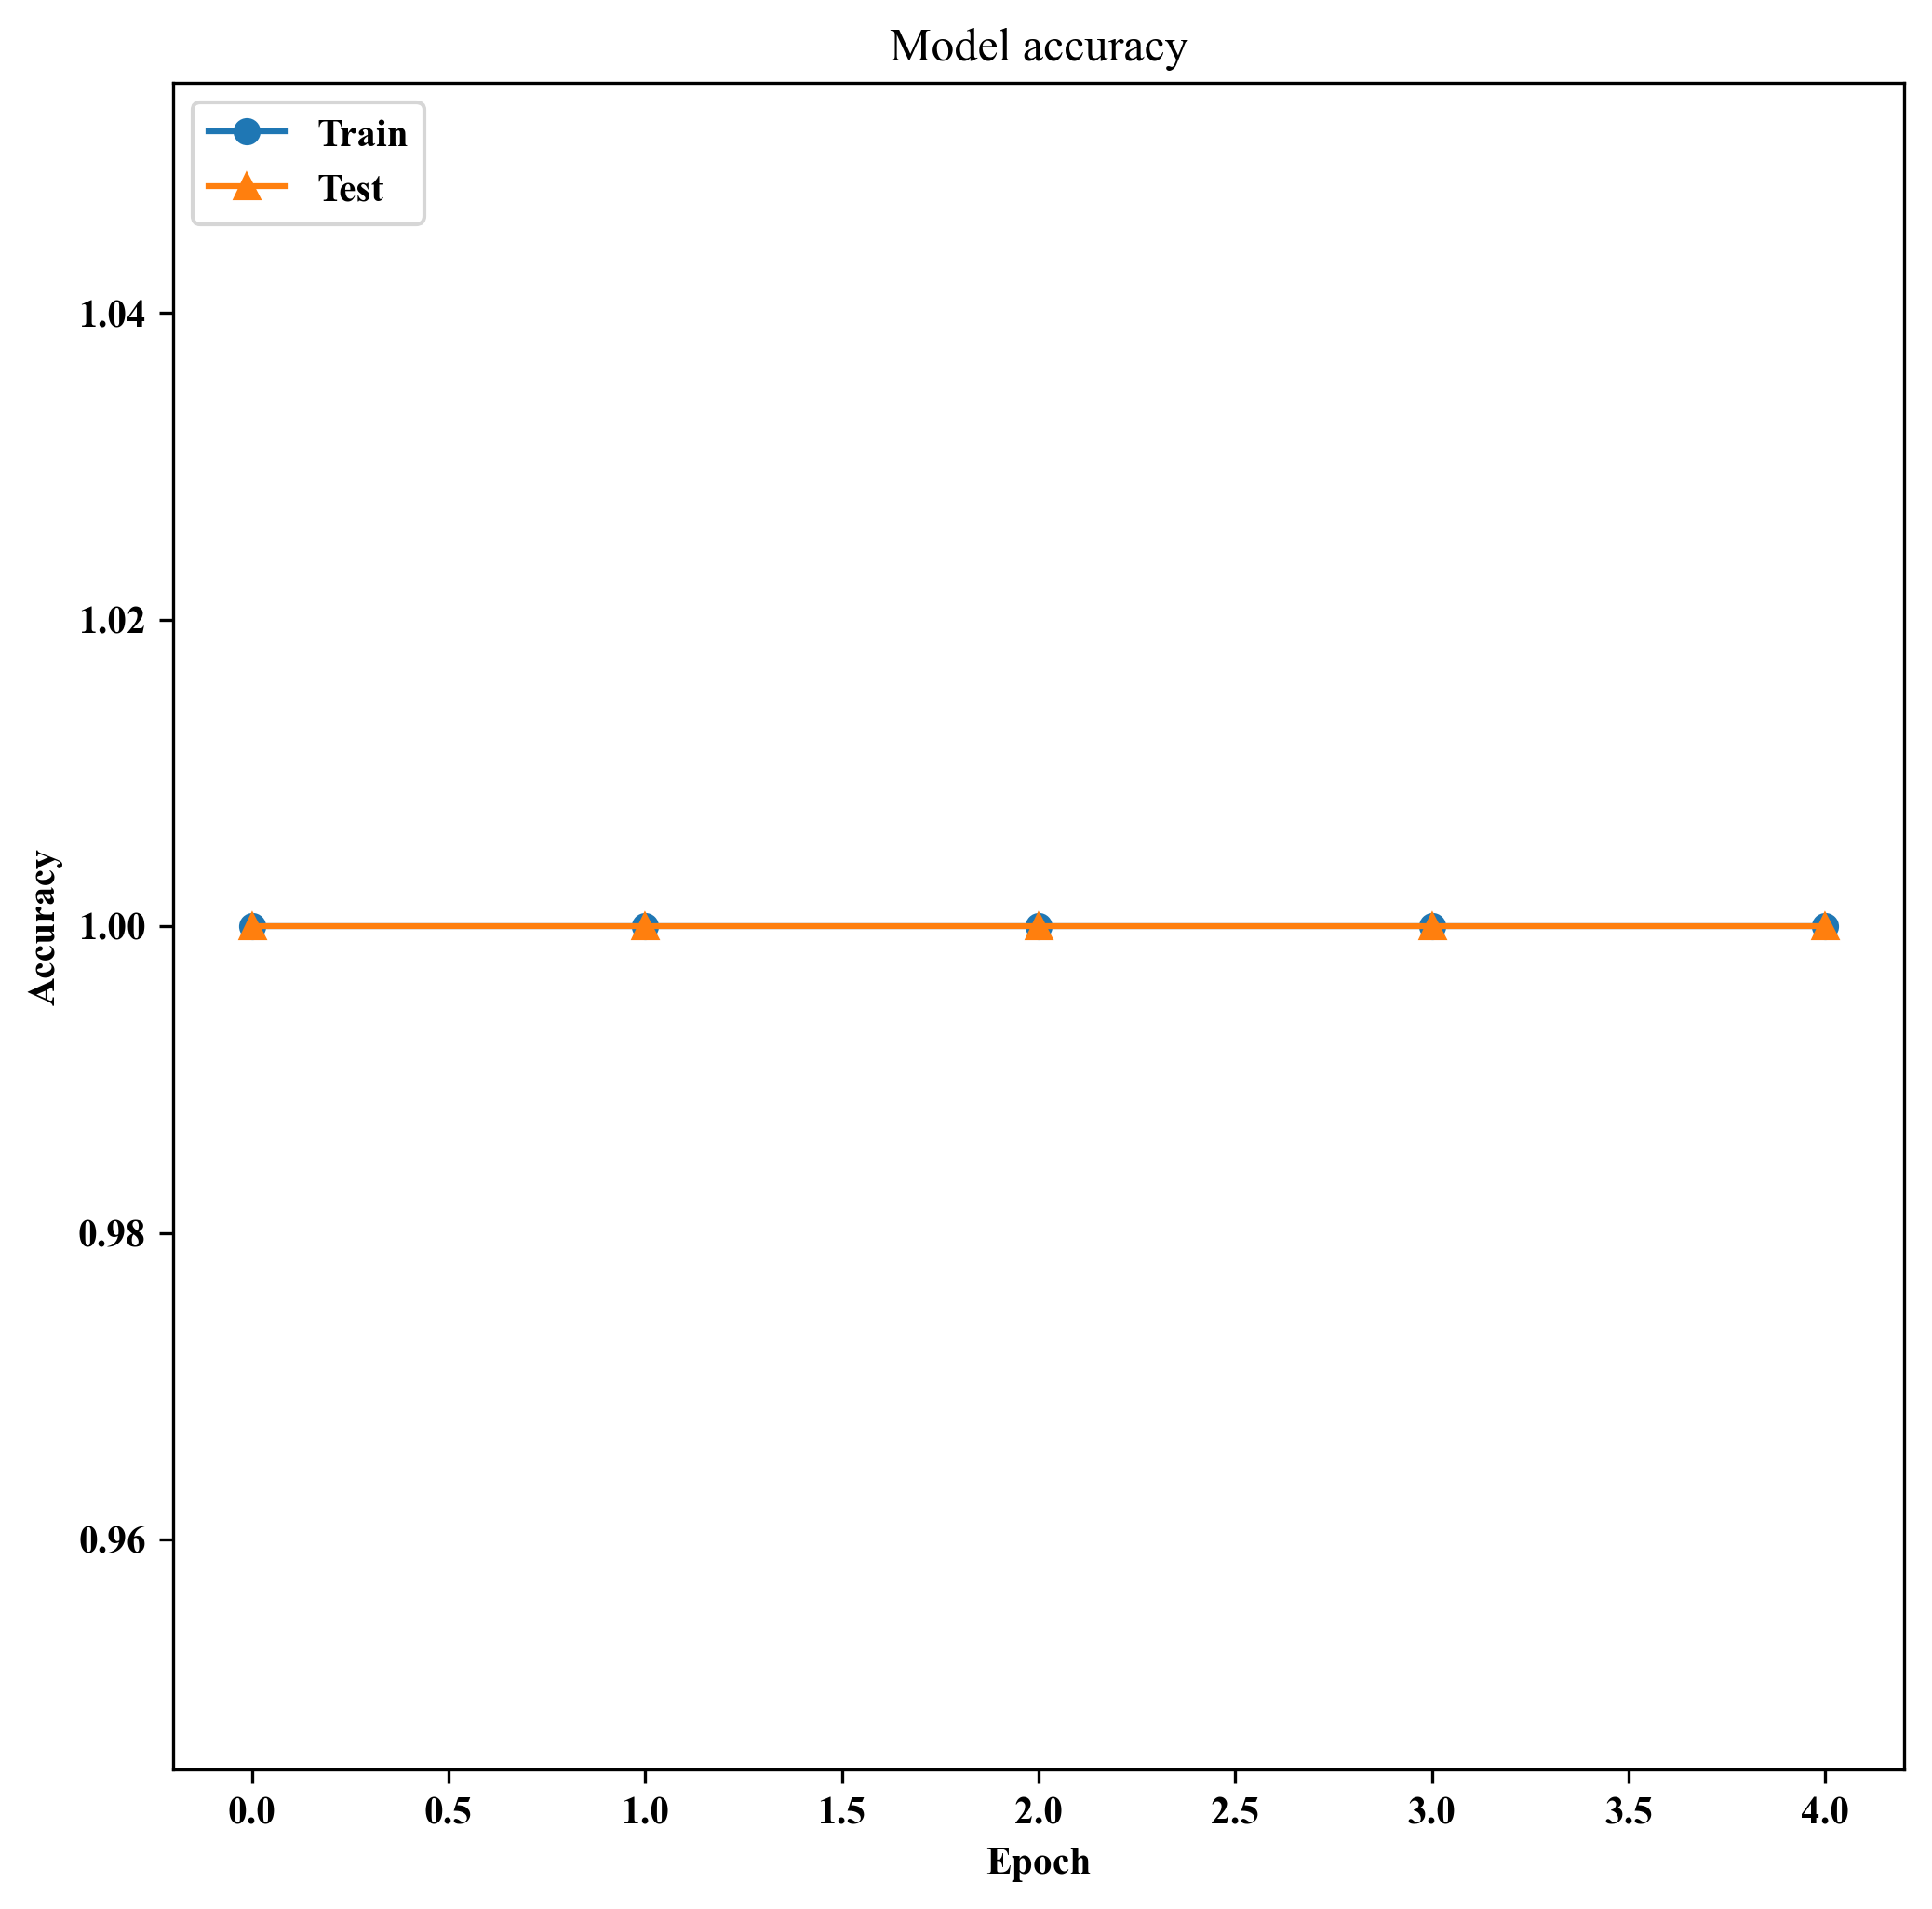

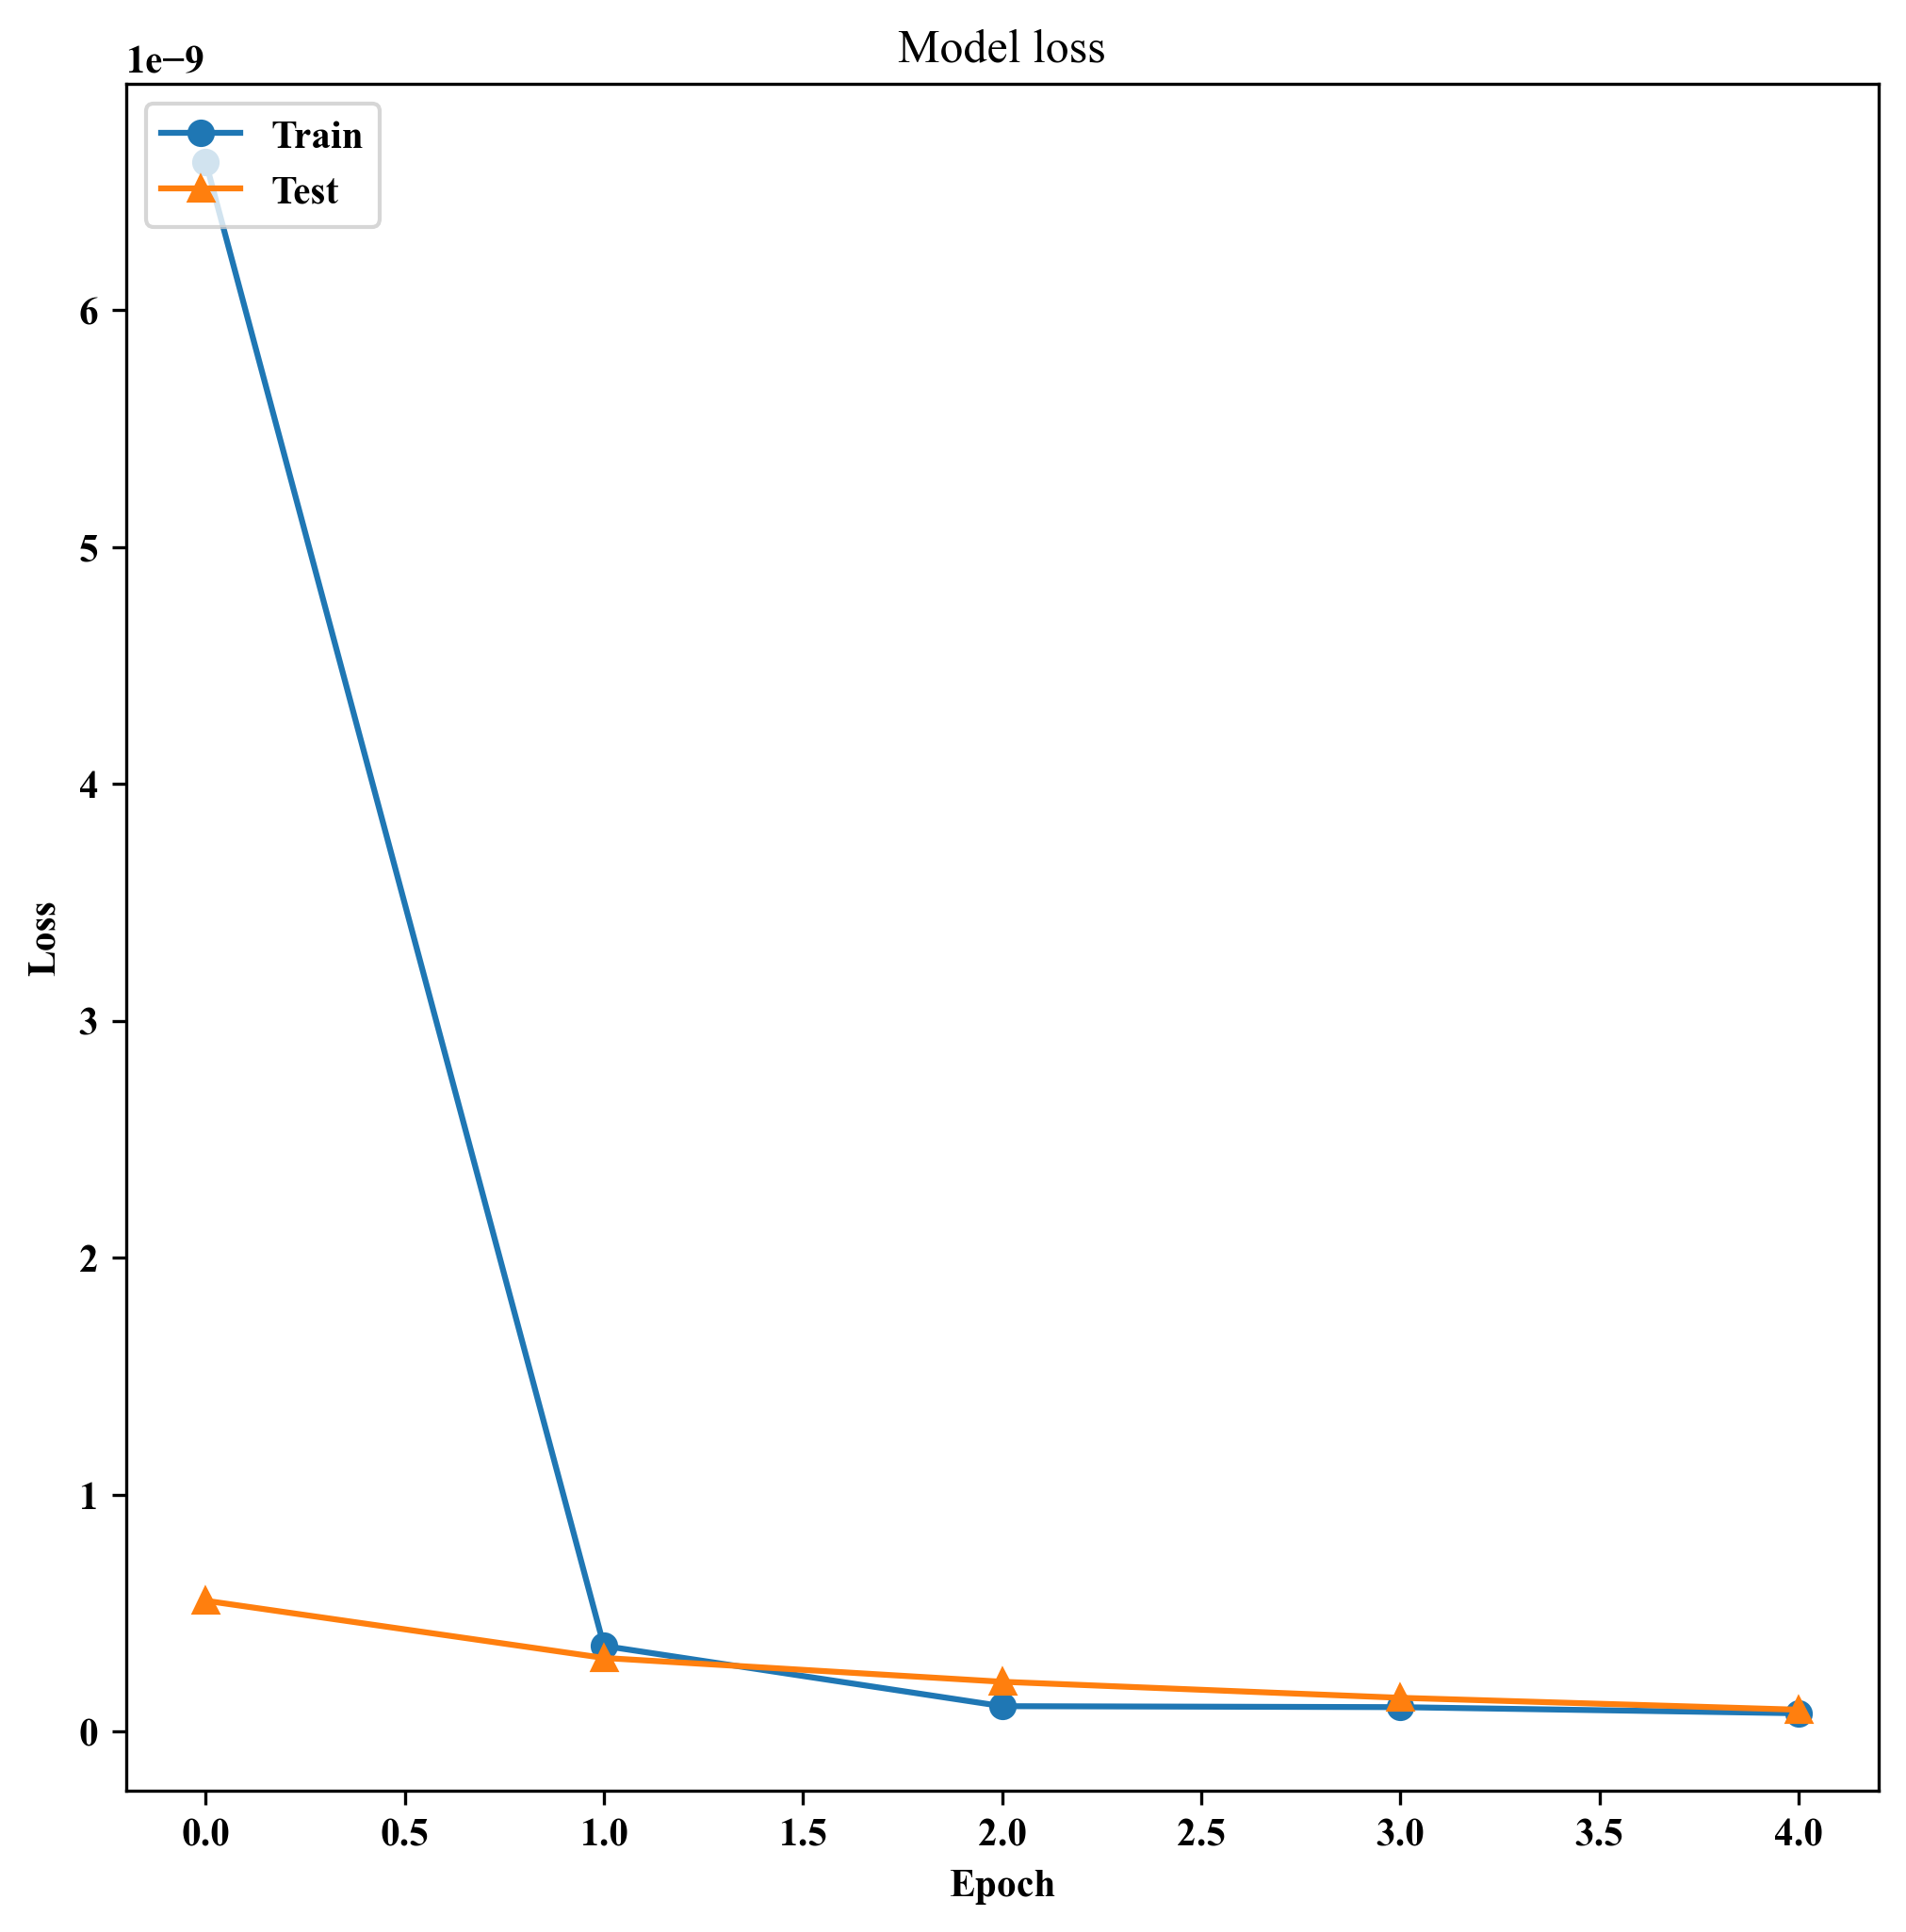

In [27]:
#----------------------------------第五步 可视化--------------------------------
# 绘制训练 & 验证的准确率值,用点表示
plt.figure(figsize=(8,8),dpi=300)
plt.plot(history.history['accuracy'], 'o-')
plt.plot(history.history['val_accuracy'], '^-')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
# plt.savefig('cnn_bilstm_accuracy.png')
plt.show()

plt.figure(figsize=(8,8),dpi=300)
# 绘制训练 & 验证的损失值,用三角表示
plt.plot(history.history['loss'], 'o-')
plt.plot(history.history['val_loss'], '^-')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
# plt.savefig('cnn_bilstm_loss.png')
plt.show()


In [28]:
print("模型预测")
mainModel = load_model('model_intra\\cnn_bilstm_model2_Fuzzy.h5', custom_objects={'AttentionLayer': AttentionLayer(50)}, compile=False)
# 预测


模型预测


In [29]:
# import time
# from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# # 计算预测时间
# start_time = time.time()  # 记录开始时间
# test_pre = mainModel.predict(testSeq)
# end_time = time.time()  # 记录结束时间
# average_prediction_time = (end_time - start_time) / len(testSeq)
# print("Average Prediction Time per Data Point: {:.6f} seconds".format(average_prediction_time))

# confm = confusion_matrix(np.argmax(y_test.values, axis=1), np.argmax(test_pre, axis=1))

# # Calculate the false positive rate
# tn, fp, fn, tp = confm.ravel()
# false_positive_rate = fp / (fp + tn)
# print("False Positive Rate: {:.4f}".format(false_positive_rate))

# print(confm)

# print(classification_report(np.argmax(y_test.values, axis=1), np.argmax(test_pre, axis=1), digits=4))
# print("Accuracy:", accuracy_score(np.argmax(y_test.values, axis=1), np.argmax(test_pre, axis=1)))

# plt.figure(figsize=(8, 8), dpi=300)
# sns.heatmap(confm, square=True, annot=True,
#             fmt='d', cbar=False, linewidths=.6,
#             cmap="Blues")
# plt.xlabel('Predicted label', size=14)
# plt.ylabel('True label', size=14)
# Labname = ['Normal','Fuzzy']  #行列名
# plt.xticks(np.arange(2) + 0.5, Labname, size=12)
# plt.yticks(np.arange(2) + 0.5, Labname, size=12)

# plt.show()



Average Prediction Time per Data Point: 0.000082 seconds
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000    669329
           1     1.0000    1.0000    1.0000     98443

    accuracy                         1.0000    767772
   macro avg     1.0000    1.0000    1.0000    767772
weighted avg     1.0000    1.0000    1.0000    767772

Accuracy:1.0000
MCC:1.0000
Kappa:1.0000
False Positive Rate (Benign samples misclassified as attacks): 0.0000


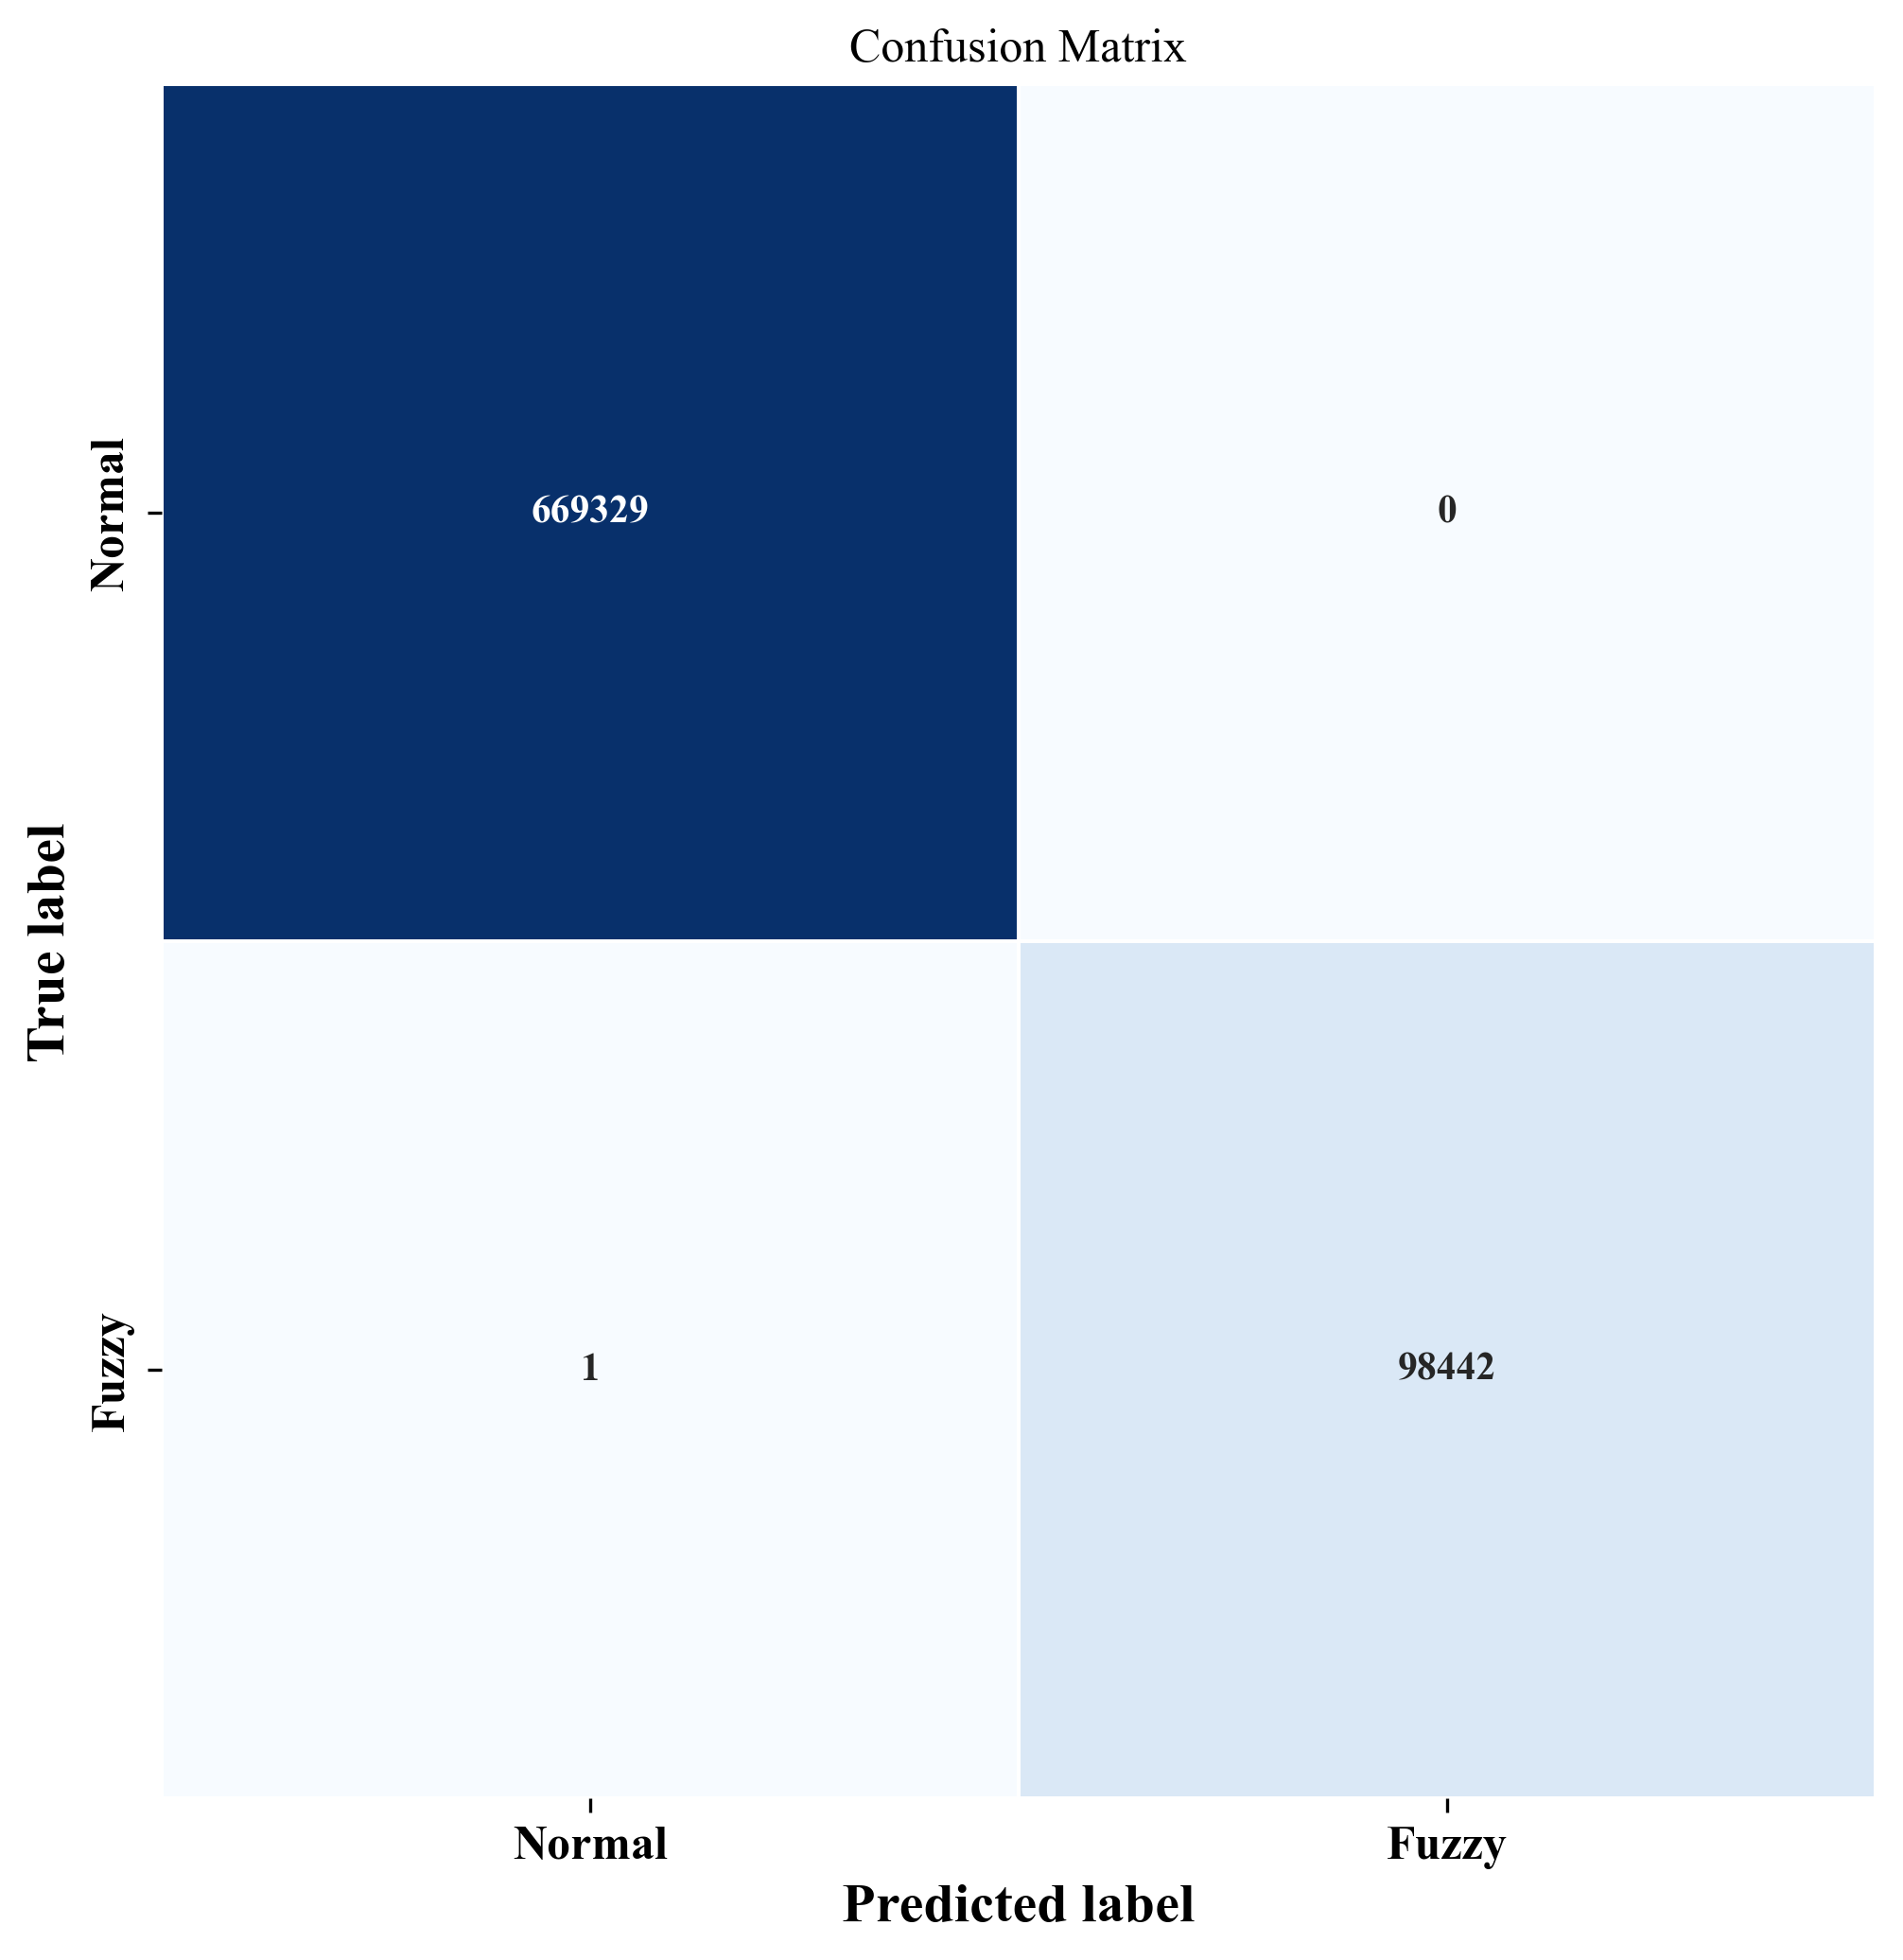

In [30]:
# 计算预测时间
start_time = time.time()  # 记录开始时间
test_pre = mainModel.predict(testSeq)
end_time = time.time()  # 记录结束时间
average_prediction_time = (end_time - start_time) / len(testSeq)
print("Average Prediction Time per Data Point: {:.6f} seconds".format(average_prediction_time))

# 计算混淆矩阵
confm = metrics.confusion_matrix(np.argmax(y_test, axis=1), np.argmax(test_pre, axis=1))
# 计算classification_report
print(metrics.classification_report(np.argmax(y_test, axis=1),
                                    np.argmax(test_pre, axis=1),
                                    digits=4))
# 计算准确度
accuracy = metrics.accuracy_score(np.argmax(y_test, axis=1),
                                          np.argmax(test_pre, axis=1))
print("Accuracy:{:.4f}".format(accuracy))
# 计算MCC
mcc = metrics.matthews_corrcoef(np.argmax(y_test, axis=1),
                                          np.argmax(test_pre, axis=1))
print("MCC:{:.4f}".format(mcc))
# 计算kappa
kappa = metrics.cohen_kappa_score(np.argmax(y_test, axis=1),
                                          np.argmax(test_pre, axis=1))
print("Kappa:{:.4f}".format(kappa))
# 计算误报率（False Positive Rate）
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(test_pre, axis=1)
false_positives = np.sum((y_true == 0) & (y_pred != 0))  # 0 represents the "Benign" class
total_benign_samples = np.sum(y_true == 0)
false_positive_rate = false_positives / total_benign_samples
print("False Positive Rate (Benign samples misclassified as attacks): {:.4f}".format(false_positive_rate))

# 画图
#设置所有图片的字体大小为10，字体为Times New Roman，字体为粗体，label的字体大小为10，字体为Times New Roman，字体为粗体
plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'

plt.figure(figsize=(8, 8), dpi=300)
sns.heatmap(confm, square=True, annot=True,
            fmt='d', cbar=False, linewidths=.6,
            cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted label', size=14)
plt.ylabel('True label', size=14)
Labname = ['Normal','Fuzzy']  #行列名
plt.xticks(np.arange(2) + 0.5, Labname, size=12)
plt.yticks(np.arange(2) + 0.5, Labname, size=12)
plt.show()


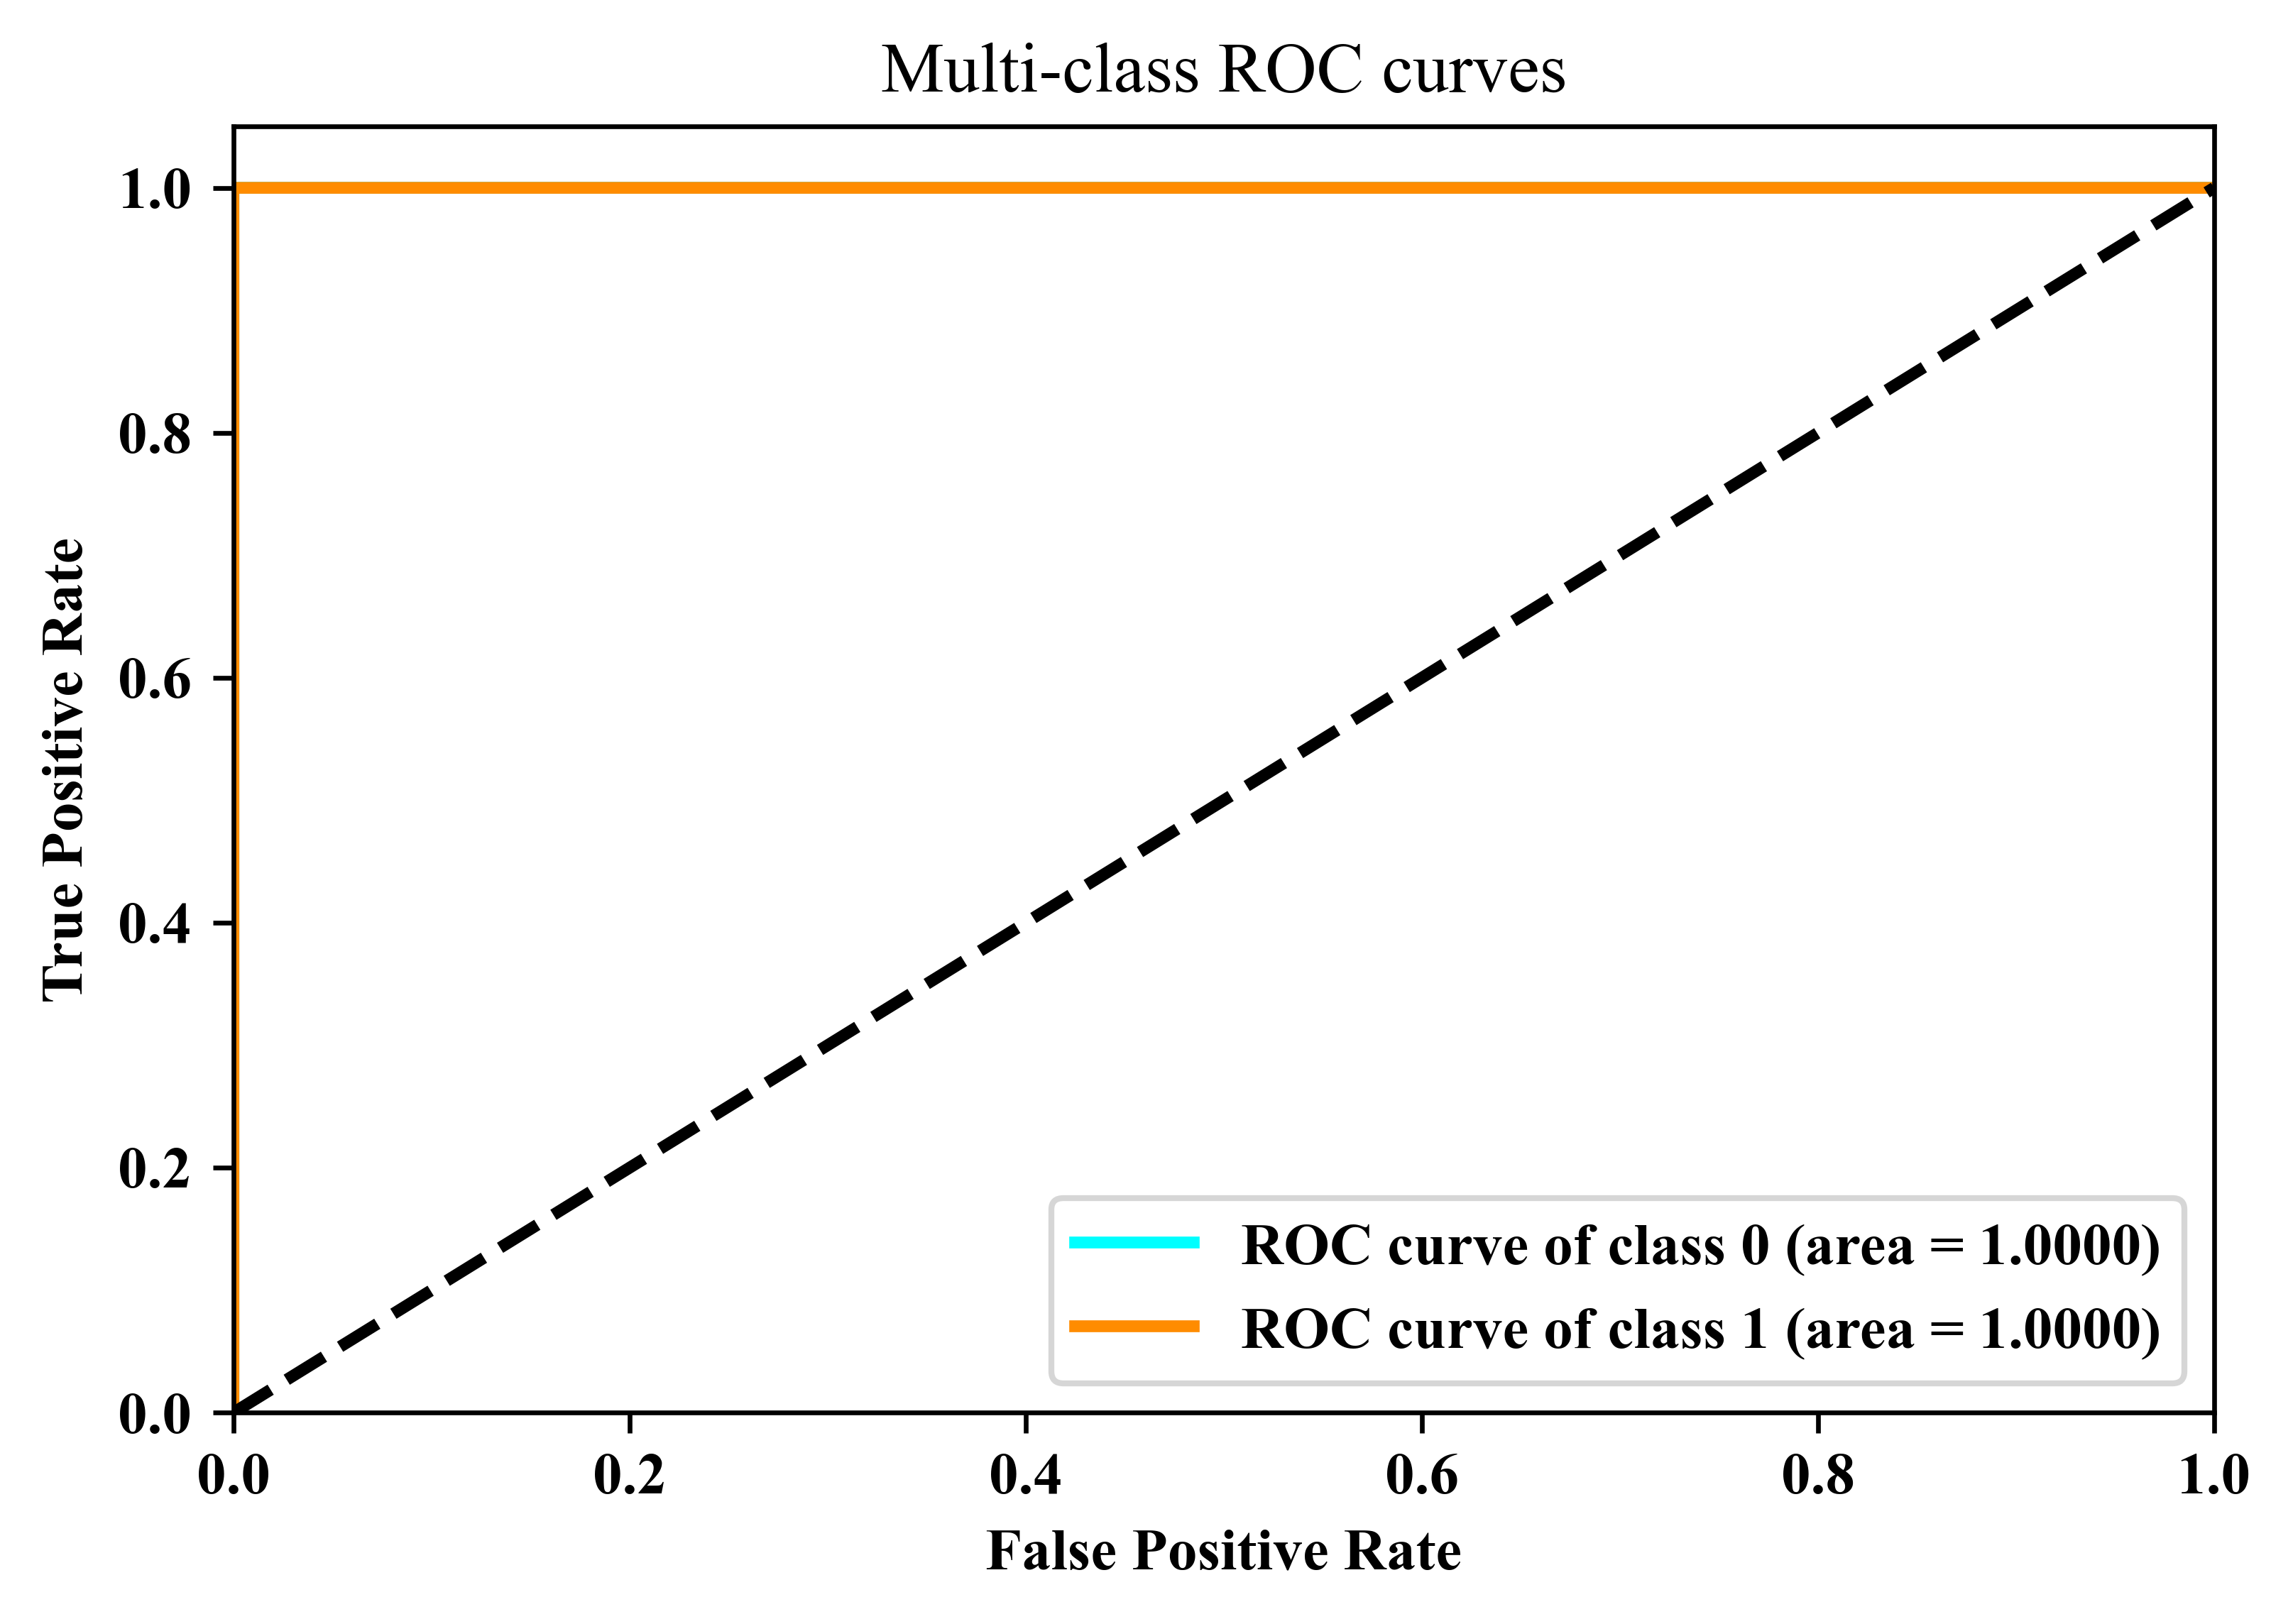

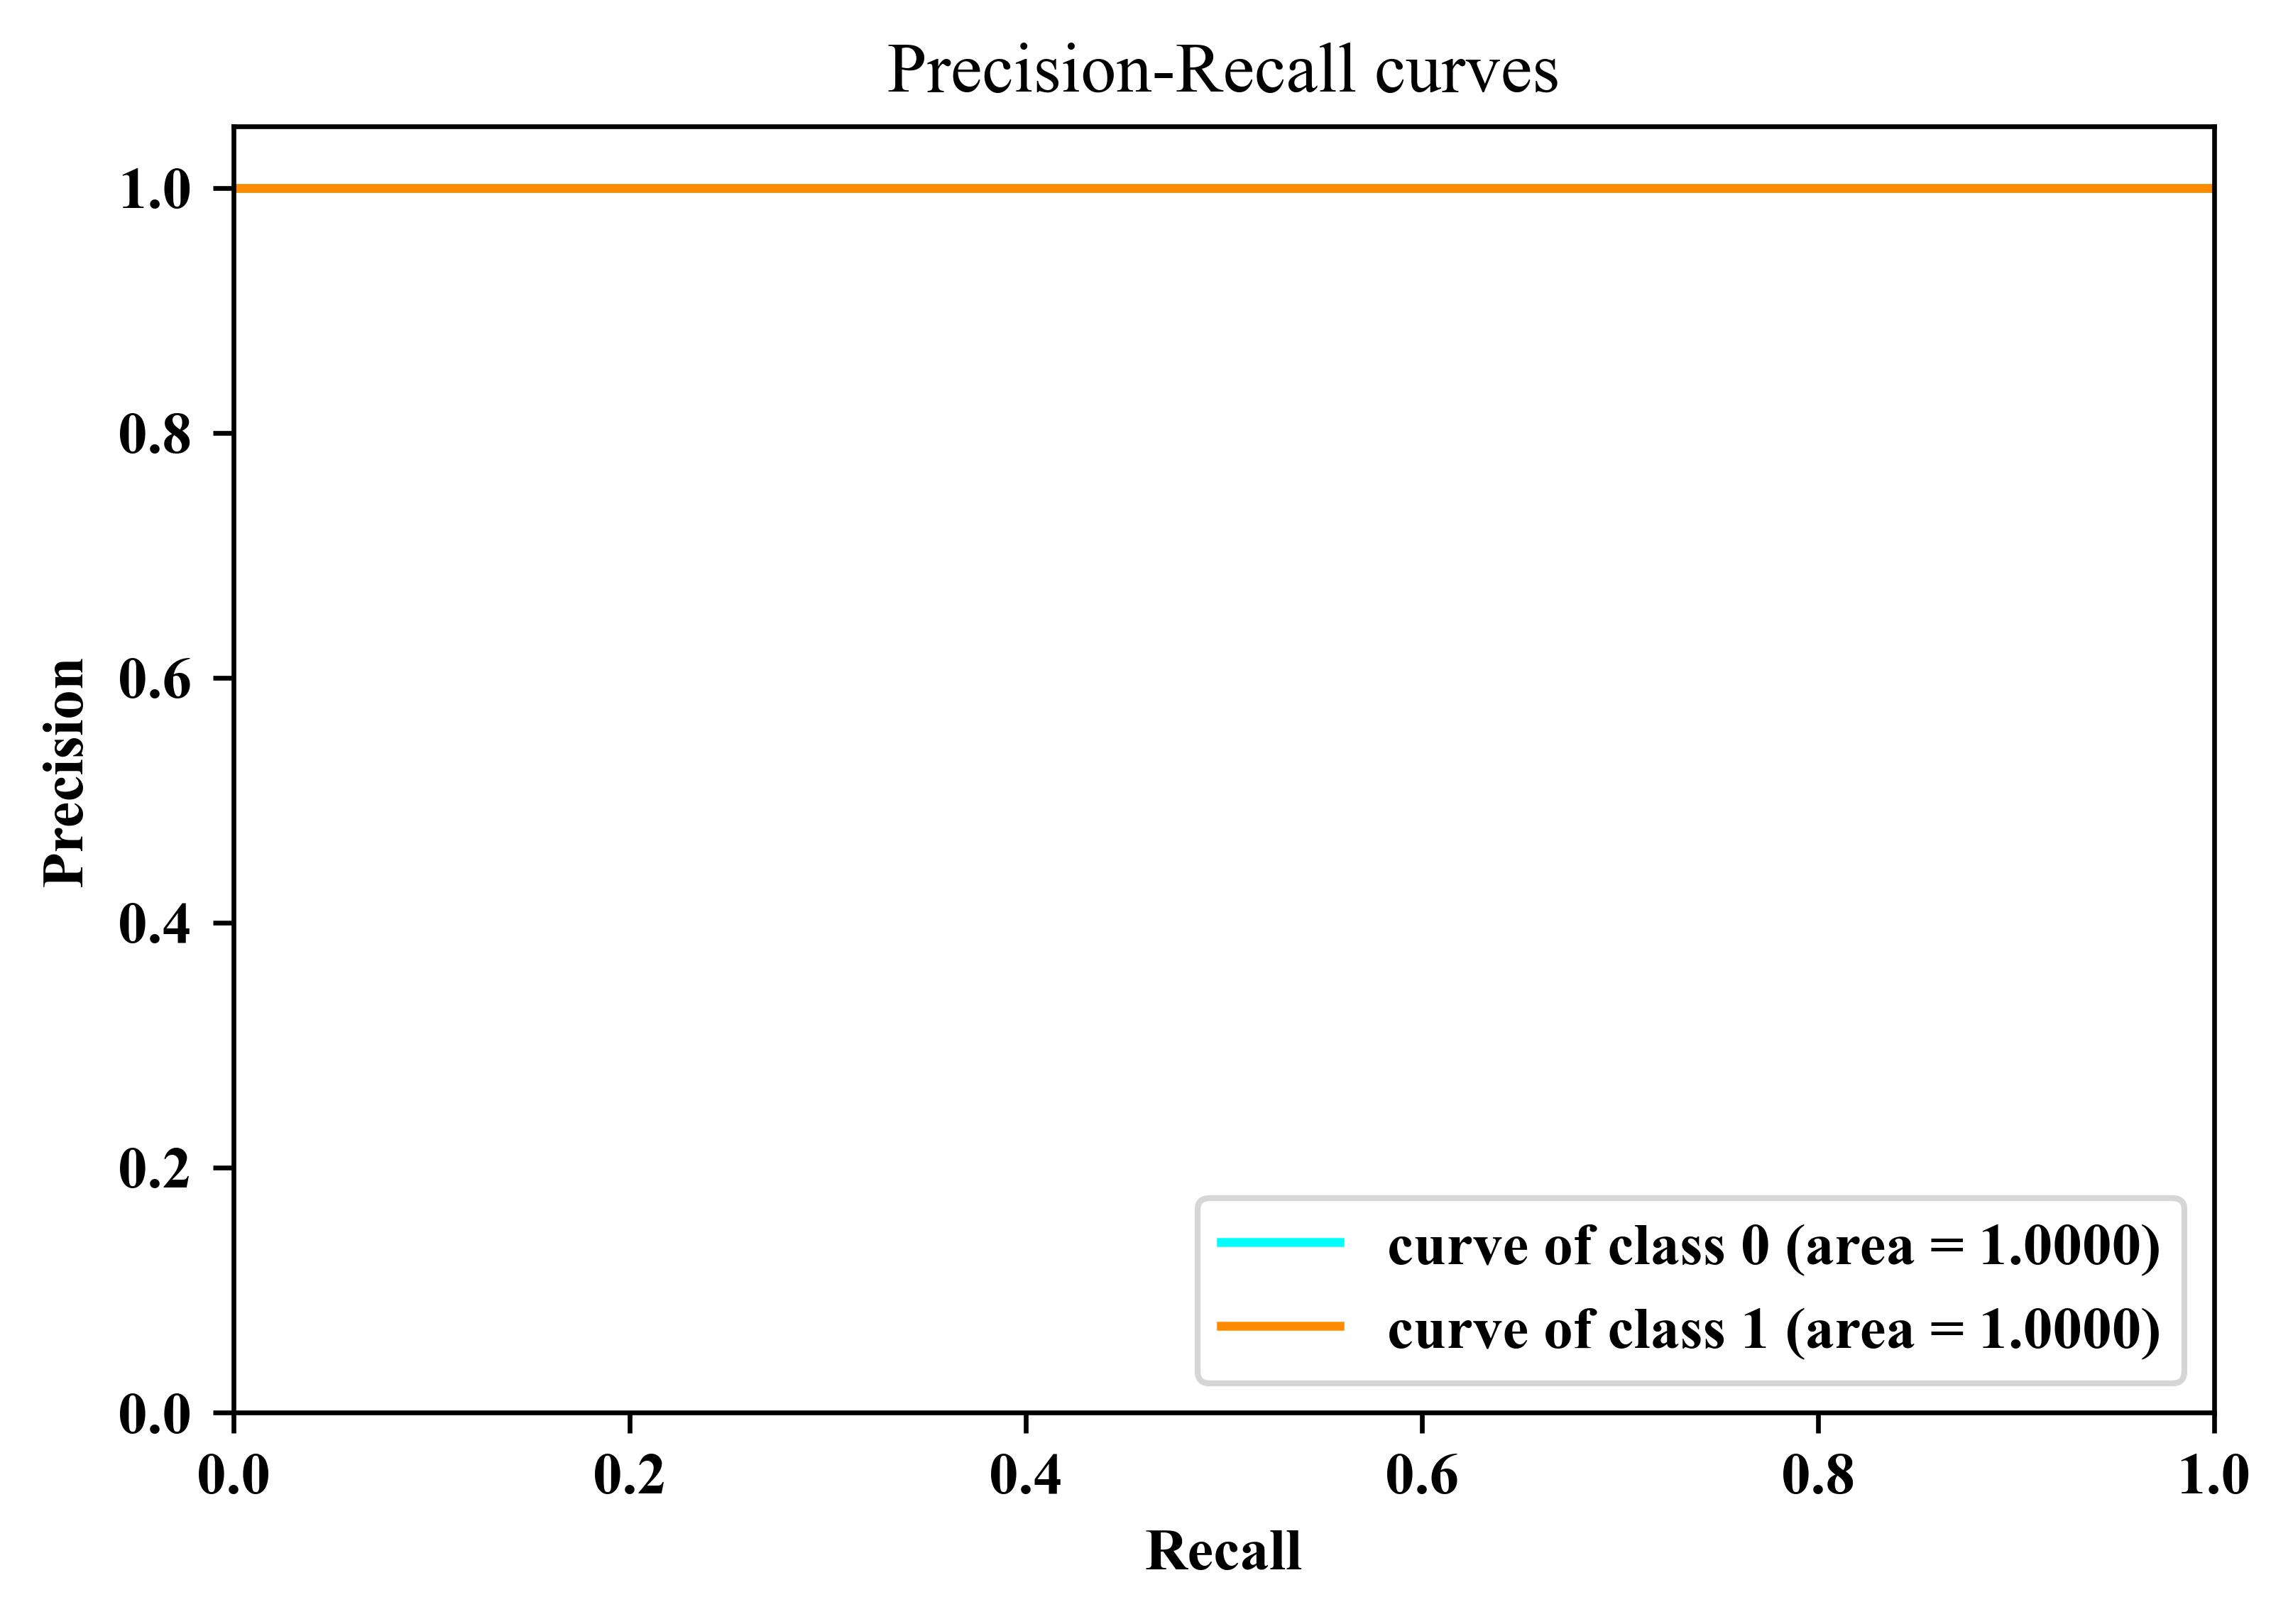

In [31]:

# Compute ROC curve and ROC area for each class
n_classes = 2
# Compute ROC curve and ROC area for each class
# 保存每一类的fpr和tpr值到csv文件，便于后续画图
fpr = dict()
tpr = dict()
roc_auc = dict()
thresholds = dict()
for i in range(n_classes):
    fpr[i], tpr[i], thresholds[i] = metrics.roc_curve(y_test[:, i], test_pre[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    df = pd.DataFrame({'fpr':fpr[i],'tpr':tpr[i]})
    df.to_csv('./Results/intra_adam_Fuzzy_fpr_tpr_{}.csv'.format(i))
# 画图AUC-ROC
plt.figure(dpi=600)
lw = 2
colors = cycle(["aqua", "darkorange", "darkgreen", "yellow", "red", "purple", "blue", "gray"])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
    label="ROC curve of class {0} (area = {1:0.4f})".format(i, roc_auc[i]),)
plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('Multi-class ROC curves')
plt.legend(loc="lower right")
plt.show()



# Compute auc-pr and AP(average precision) for each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = metrics.precision_recall_curve(y_test[:, i], test_pre[:, i])
    average_precision[i] = metrics.average_precision_score(y_test[:, i], test_pre[:, i])
    df = pd.DataFrame({'precision':precision[i],'recall':recall[i]})
    df.to_csv('./Results/intra_adam_Fuzzy_precision_recall_{}.csv'.format(i))
# 绘制所有类别的pr曲线
plt.figure(dpi=600)
lw = 2
colors = cycle(["aqua", "darkorange", "darkgreen", "yellow", "red", "purple", "blue", "gray"])
for i, color in zip(range(n_classes), colors):
    plt.step(recall[i], precision[i], color=color, where="post", label="curve of class {0} (area = {1:0.4f})".format(i, average_precision[i]))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title("Precision-Recall curves")
plt.legend(loc="lower right")
plt.show()   


## 二分类：处理数据（gear）

In [32]:
#--------------------------------------第一步 数据预处理--------------------------------
import csv
# 打开CSV文件
with open('Data\9) Car-Hacking Dataset\gear_dataset.csv', 'r') as file:
    # 创建CSV读取器
    reader = csv.reader(file)
    # 创建空列表来存储处理后的数据
    processed_data = []

    # 记录开始时间
    start_time = time.time()

    # 读取CSV文件中的每一行数据
    for row in reader:
        # 处理每一行数据

        # 获取最后一列作为标签
        label = row[-1]
        # 将第二列数据的两个16进制数据，拆分为两个16进制字符串，即0316拆分为"03"和"16"
        hex_data1 = row[1][0:2]
        hex_data2 = row[1][2:]
        row[1] = row[1][0:2] + ' ' + row[1][2:]
        # 将第四到倒数第二列的值转化为字符串
        new_col = ' '.join(map(str, row[3:-1]))
        new_col = hex_data1 + ' ' + hex_data2 + ' ' + new_col
        
        # 示例：将处理后的数据添加到列表中
        processed_data.append((new_col, label))

    # 记录结束时间
    end_time = time.time()

    # Calculate the total processing time
    total_processing_time = end_time - start_time

    # 使用pandas.DataFrame()函数将列表转化为数据框
    gear_dataset = pd.DataFrame(processed_data, columns=['DATA', 'Flag'])

    # Calculate the average processing time
    dataset_size = len(processed_data)
    average_processing_time = total_processing_time / dataset_size
    print("Total Processing Time: {:.6f} seconds".format(total_processing_time))
    print("Average Processing Time per Row: {:.6f} seconds".format(average_processing_time))

gear_dataset

Total Processing Time: 9.675972 seconds
Average Processing Time per Row: 0.000002 seconds


DATA Flag
0        01 40 00 00 00 00 10 29 2a 24    R
1        02 c0 15 00 00 00 00 00 00 00    R
2        03 50 05 20 44 68 77 00 00 7e    R
3        03 70 00 20 00 00 00 00 00 00    R
4        04 3f 10 40 60 ff 78 c4 08 00    R
...                                ...  ...
4443137  01 8f fe 59 00 00 00 41 00 00    R
4443138  02 60 18 21 21 30 08 8f 6d 19    R
4443139  02 a0 24 00 9a 1d 97 02 bd 00    R
4443140  03 29 dc b7 7f 14 11 20 00 14    R
4443141  05 45 d8 00 00 8b 00 00 00 00    R

[4443142 rows x 2 columns]

In [33]:
# 将Flag中的Nomal和Attack转换为0和1，不使用LabelEncoder
from sklearn.preprocessing import OneHotEncoder
gear_dataset['Flag'] = gear_dataset['Flag'].replace({'R': 0, 'T': 1})
print(gear_dataset['Flag'].value_counts())

# 将Class和SubClass转换为OneHotEncoder
# one_hot_encoded = pd.get_dummies(gear_dataset['Flag'])
# print(one_hot_encoded)
from keras.utils import np_utils
one_hot_encoded = np_utils.to_categorical(gear_dataset['Flag'])

0    3845890
1     597252
Name: Flag, dtype: int64


In [34]:
# 取出数据集中除了标签以外的数据
gear_X = gear_dataset.drop(['Flag'], axis=1)

# 将数据集划分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(gear_X, one_hot_encoded, test_size=0.2, random_state=0)
print(y_train.shape)
print(y_test.shape)

(3554513, 2)
(888629, 2)


In [35]:
content = gear_X['DATA']
# print(content)
# 使用Tokenizer对词组进行编码
# 特征编号，不足的前面补0
# fit_on_texts函数可以将输入的文本每个词编号 编号根据词频(词频越大编号越小)
max_words = 256 ##使用的最大词语数为1000
maxLen = 10 #句子的长度最多为8
# 计算对整个数据集的词进行词频统计的时间

start_time1 = time.time()
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(content)
end_time1 = time.time()
process_time1 = (end_time1 - start_time1) / len(content)  # Calculate average time per data point
vocab = tokenizer.word_index  #停用词已过滤,获取每个词的编号
# print(vocab)

# 使用word_index属性可以看到每次词对应的编码
# 使用word_counts属性可以看到每个词对应的频数
# print(tokenizer.word_index)
# print(tokenizer.word_counts)

"""
# 使用Tokenizer对词组进行编码
# 当我们创建了一个Tokenizer对象后，使用该对象的fit_on_texts()函数，以空格去识别每个词
# 可以将输入的文本中的每个词编号，编号是根据词频的，词频越大，编号越小
"""

# 将train_value中的字符串按照空格进行分割
train_content = X_train['DATA']
test_content = X_test['DATA']
# print(train_content)
# print(test_content)

# 特征编号，将一句话表示为词编码的序列
# 计算由数据流转化为由词编码组成序列的时间
start_time2 = time.time()
trainID = tokenizer.texts_to_sequences(train_content)
end_time2 = time.time()
process_time2 = (end_time2 - start_time2) / len(train_content)  # Calculate average time per data point
testID = tokenizer.texts_to_sequences(test_content)
# print(trainID)
# print(testID)
# 该方法会让CNN训练的长度统一,(不足的前面补0)，使用sequence.pad_sequences()将每个序列调整为相同的长度
# 计算转化为的序列进行填充和截断的时间
start_time3 = time.time()
trainSeq = sequence.pad_sequences(trainID, maxlen=maxLen)
end_time3 = time.time()
process_time3 = (end_time3 - start_time3) / len(train_content)  # Calculate average time per data point
testSeq = sequence.pad_sequences(testID, maxlen=maxLen)

# print(trainSeq)
# print(testSeq)

print("Average Time for Word Frequency Count: {:.6f} seconds".format(process_time1))
print("Average Time for Converting Data to Sequences: {:.6f} seconds".format(process_time2))
print("Average Time for Padding and Truncating Sequences: {:.6f} seconds".format(process_time3))



Average Time for Word Frequency Count: 0.000005 seconds
Average Time for Converting Data to Sequences: 0.000005 seconds
Average Time for Padding and Truncating Sequences: 0.000002 seconds


In [36]:
average_preprocess_time = average_processing_time + process_time1 + process_time2 + process_time3
print("Average Preprocessing Time per Data Point: {:.6f} seconds".format(average_preprocess_time))

Average Preprocessing Time per Data Point: 0.000015 seconds


In [37]:
# 建立Attention机制
# Keras自定义的函数主要分为四个部分，分别是：
#   init：初始化一些需要的参数
#   bulid：具体来定义权重是怎么样的
#   call：核心部分，定义向量是如何进行运算的
#   compute_output_shape：定义该层输出的大小
# Hierarchical Model with Attention
from keras import initializers
from keras import constraints
from keras import activations
from keras import regularizers
from keras import backend as K
from keras.layers import Layer

K.clear_session()

class AttentionLayer(Layer):
    def __init__(self, attention_size=None, **kwargs):
        self.attention_size = attention_size
        super(AttentionLayer, self).__init__(**kwargs)
        
    def get_config(self):
        config = super().get_config()
        config['attention_size'] = self.attention_size
        return config
        
    def build(self, input_shape):
        assert len(input_shape) == 3
        
        self.time_steps = input_shape[1]
        hidden_size = input_shape[2]
        if self.attention_size is None:
            self.attention_size = hidden_size
            
        self.W = self.add_weight(name='att_weight', shape=(hidden_size, self.attention_size),
                                initializer='uniform', trainable=True)
        self.b = self.add_weight(name='att_bias', shape=(self.attention_size,),
                                initializer='uniform', trainable=True)
        self.V = self.add_weight(name='att_var', shape=(self.attention_size,),
                                initializer='uniform', trainable=True)
        super(AttentionLayer, self).build(input_shape)

    
    
    def call(self, inputs):
        #self.V = K.reshape(self.V, (-1, 1))
        V = K.reshape(self.V, (-1, 1))
        H = K.tanh(K.dot(inputs, self.W) + self.b)
        #score = K.softmax(K.dot(H, self.V), axis=1)
        score = K.softmax(K.dot(H, V), axis=1)
        outputs = K.sum(score * inputs, axis=1)
        return outputs
    
    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[2]
    
# 建立Attention+CNN模型并训练
#构建TextCNN模型
num_labels = 2
inputs = Input(name='inputs',shape=[maxLen], dtype='float64')
#  Example:
#   >>> model = tf.keras.Sequential()
#   >>> model.add(tf.keras.layers.Embedding(1000, 64, input_length=10))
#   >>> # The model will take as input an integer matrix of size (batch,
#   >>> # input_length), and the largest integer (i.e. word index) in the input
#   >>> # should be no larger than 999 (vocabulary size). 意思就是输入的矩阵是一个batch*input_length的矩阵，每个元素是一个0-vocabulary size的整数
#   >>> # Now model.output_shape is (None, 10, 64), where `None` is the batch
#   >>> # dimension.
#   >>> input_array = np.random.randint(1000, size=(32, 10))
#   >>> model.compile('rmsprop', 'mse')
#   >>> output_array = model.predict(input_array)
#   >>> print(output_array.shape)
#   (32, 10, 64)
layer = Embedding(max_words+1, 128, input_length=maxLen, trainable=True)(inputs)
cnn1 = Convolution1D(64, 3, padding='same', strides = 1, activation='relu')(layer)
cnn1 = MaxPool1D(pool_size=4)(cnn1)
cnn2 = Convolution1D(64, 4, padding='same', strides = 1, activation='relu')(layer)
cnn2 = MaxPool1D(pool_size=4)(cnn2)
cnn3 = Convolution1D(64, 5, padding='same', strides = 1, activation='relu')(layer)
cnn3 = MaxPool1D(pool_size=4)(cnn3)

# 合并三个模型的输出向量
cnn = concatenate([cnn1,cnn2,cnn3], axis=-1)

# BiLSTM+Attention
# bilstm = Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.1, return_sequences=True))(cnn)
bilstm = Bidirectional(LSTM(128, return_sequences=True))(cnn)  #参数保持维度3
layer = Dense(256, activation='relu')(bilstm)
layer = Dropout(0.3)(layer)
attention = AttentionLayer(attention_size=50)(layer)

output = Dense(num_labels, activation='softmax')(attention)
model = Model(inputs=inputs, outputs=output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 10)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 10, 128)      32896       inputs[0][0]                     
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 10, 64)       24640       embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 10, 64)       32832       embedding[0][0]                  
______________________________________________________________________________________________

In [38]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from sklearn.model_selection import StratifiedKFold
import time


accuracy_score_list,recall_score_list,precision_score_list,f1_score_list = [],[],[],[]
# 编译模型
adam = keras.optimizers.adam_v2.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=["accuracy"])

# 定义5折交叉验证
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 记录开始时间
start_time = time.time()

# 开始交叉验证
for train_index, val_index in kfold.split(trainSeq, np.argmax(y_train,axis=1)):
    X_train_fold, X_val_fold = trainSeq[train_index],trainSeq[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    print(X_train_fold.shape, X_val_fold.shape, y_train_fold.shape, y_val_fold.shape)


    # 训练模型
    history = model.fit(X_train_fold, y_train_fold, epochs=5, batch_size=1024, validation_data=(X_val_fold, y_val_fold),verbose=1)
    y_pred = model.predict(X_val_fold)
    print(y_pred.shape)
    print(history.history)
    # 评估模型
    AccuracyScore = metrics.accuracy_score(np.argmax(y_val_fold,axis=1),np.argmax(y_pred,axis=1))
    RecallScore = metrics.recall_score(np.argmax(y_val_fold,axis=1),np.argmax(y_pred,axis=1),average='macro')
    PrecisionScore = metrics.precision_score(np.argmax(y_val_fold,axis=1),np.argmax(y_pred,axis=1),average='macro')
    F1Score = metrics.f1_score(np.argmax(y_val_fold,axis=1),np.argmax(y_pred,axis=1),average='macro')
    # 将评估指标存放对应的列表中
    accuracy_score_list.append(AccuracyScore)
    recall_score_list.append(RecallScore)
    precision_score_list.append(PrecisionScore)
    f1_score_list.append(F1Score)
        # 打印每一次训练的正确率、召回率、F1值
    print('accuracy_score:',AccuracyScore,'recall_score:',RecallScore,'precision_score',PrecisionScore,'f1_score:',F1Score)
# 打印各指标的平均值和95%的置信区间
print("Accuracy: %0.4f (+/- %0.4f)" % (np.average(accuracy_score_list), np.std(accuracy_score_list) * 2))
print("Recall: %0.4f (+/- %0.4f)" % (np.average(recall_score_list), np.std(recall_score_list) * 2))
print("Precision: %0.4f (+/- %0.4f)" % (np.average(precision_score_list), np.std(precision_score_list) * 2))
print("F1_score: %0.4f (+/- %0.4f)" % (np.average(f1_score_list), np.std(f1_score_list) * 2))

# 计算总训练时间
end_time = time.time()
elapsed_time = end_time - start_time
average_training_time = elapsed_time / ((len(X_train) * kfold.n_splits))
print("Average Training Time per Data Point: {:.6f} seconds".format(average_training_time))

# 保存模型
model.save('model_intra\\cnn_bilstm_model2_gear.h5')




c:\Users\10105\.conda\envs\tf2\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


(2843610, 10) (710903, 10) (2843610, 2) (710903, 2)
Epoch 1/5
2777/2777 [==============================] - 30s 10ms/step - loss: 0.0030 - accuracy: 0.9987 - val_loss: 4.2731e-08 - val_accuracy: 1.0000
Epoch 2/5
2777/2777 [==============================] - 27s 10ms/step - loss: 2.1660e-08 - accuracy: 1.0000 - val_loss: 1.1777e-09 - val_accuracy: 1.0000
Epoch 3/5
2777/2777 [==============================] - 28s 10ms/step - loss: 3.5627e-09 - accuracy: 1.0000 - val_loss: 2.2856e-10 - val_accuracy: 1.0000
Epoch 4/5
2777/2777 [==============================] - 27s 10ms/step - loss: 5.4741e-10 - accuracy: 1.0000 - val_loss: 5.2989e-11 - val_accuracy: 1.0000
Epoch 5/5
2777/2777 [==============================] - 28s 10ms/step - loss: 8.4389e-11 - accuracy: 1.0000 - val_loss: 1.2912e-11 - val_accuracy: 1.0000
(710903, 2)
{'loss': [0.002996645402163267, 2.1660129689848873e-08, 3.562724115724336e-09, 5.474149467055156e-10, 8.438860027437656e-11], 'accuracy': [0.998748779296875, 1.0, 1.0, 1.0, 1.

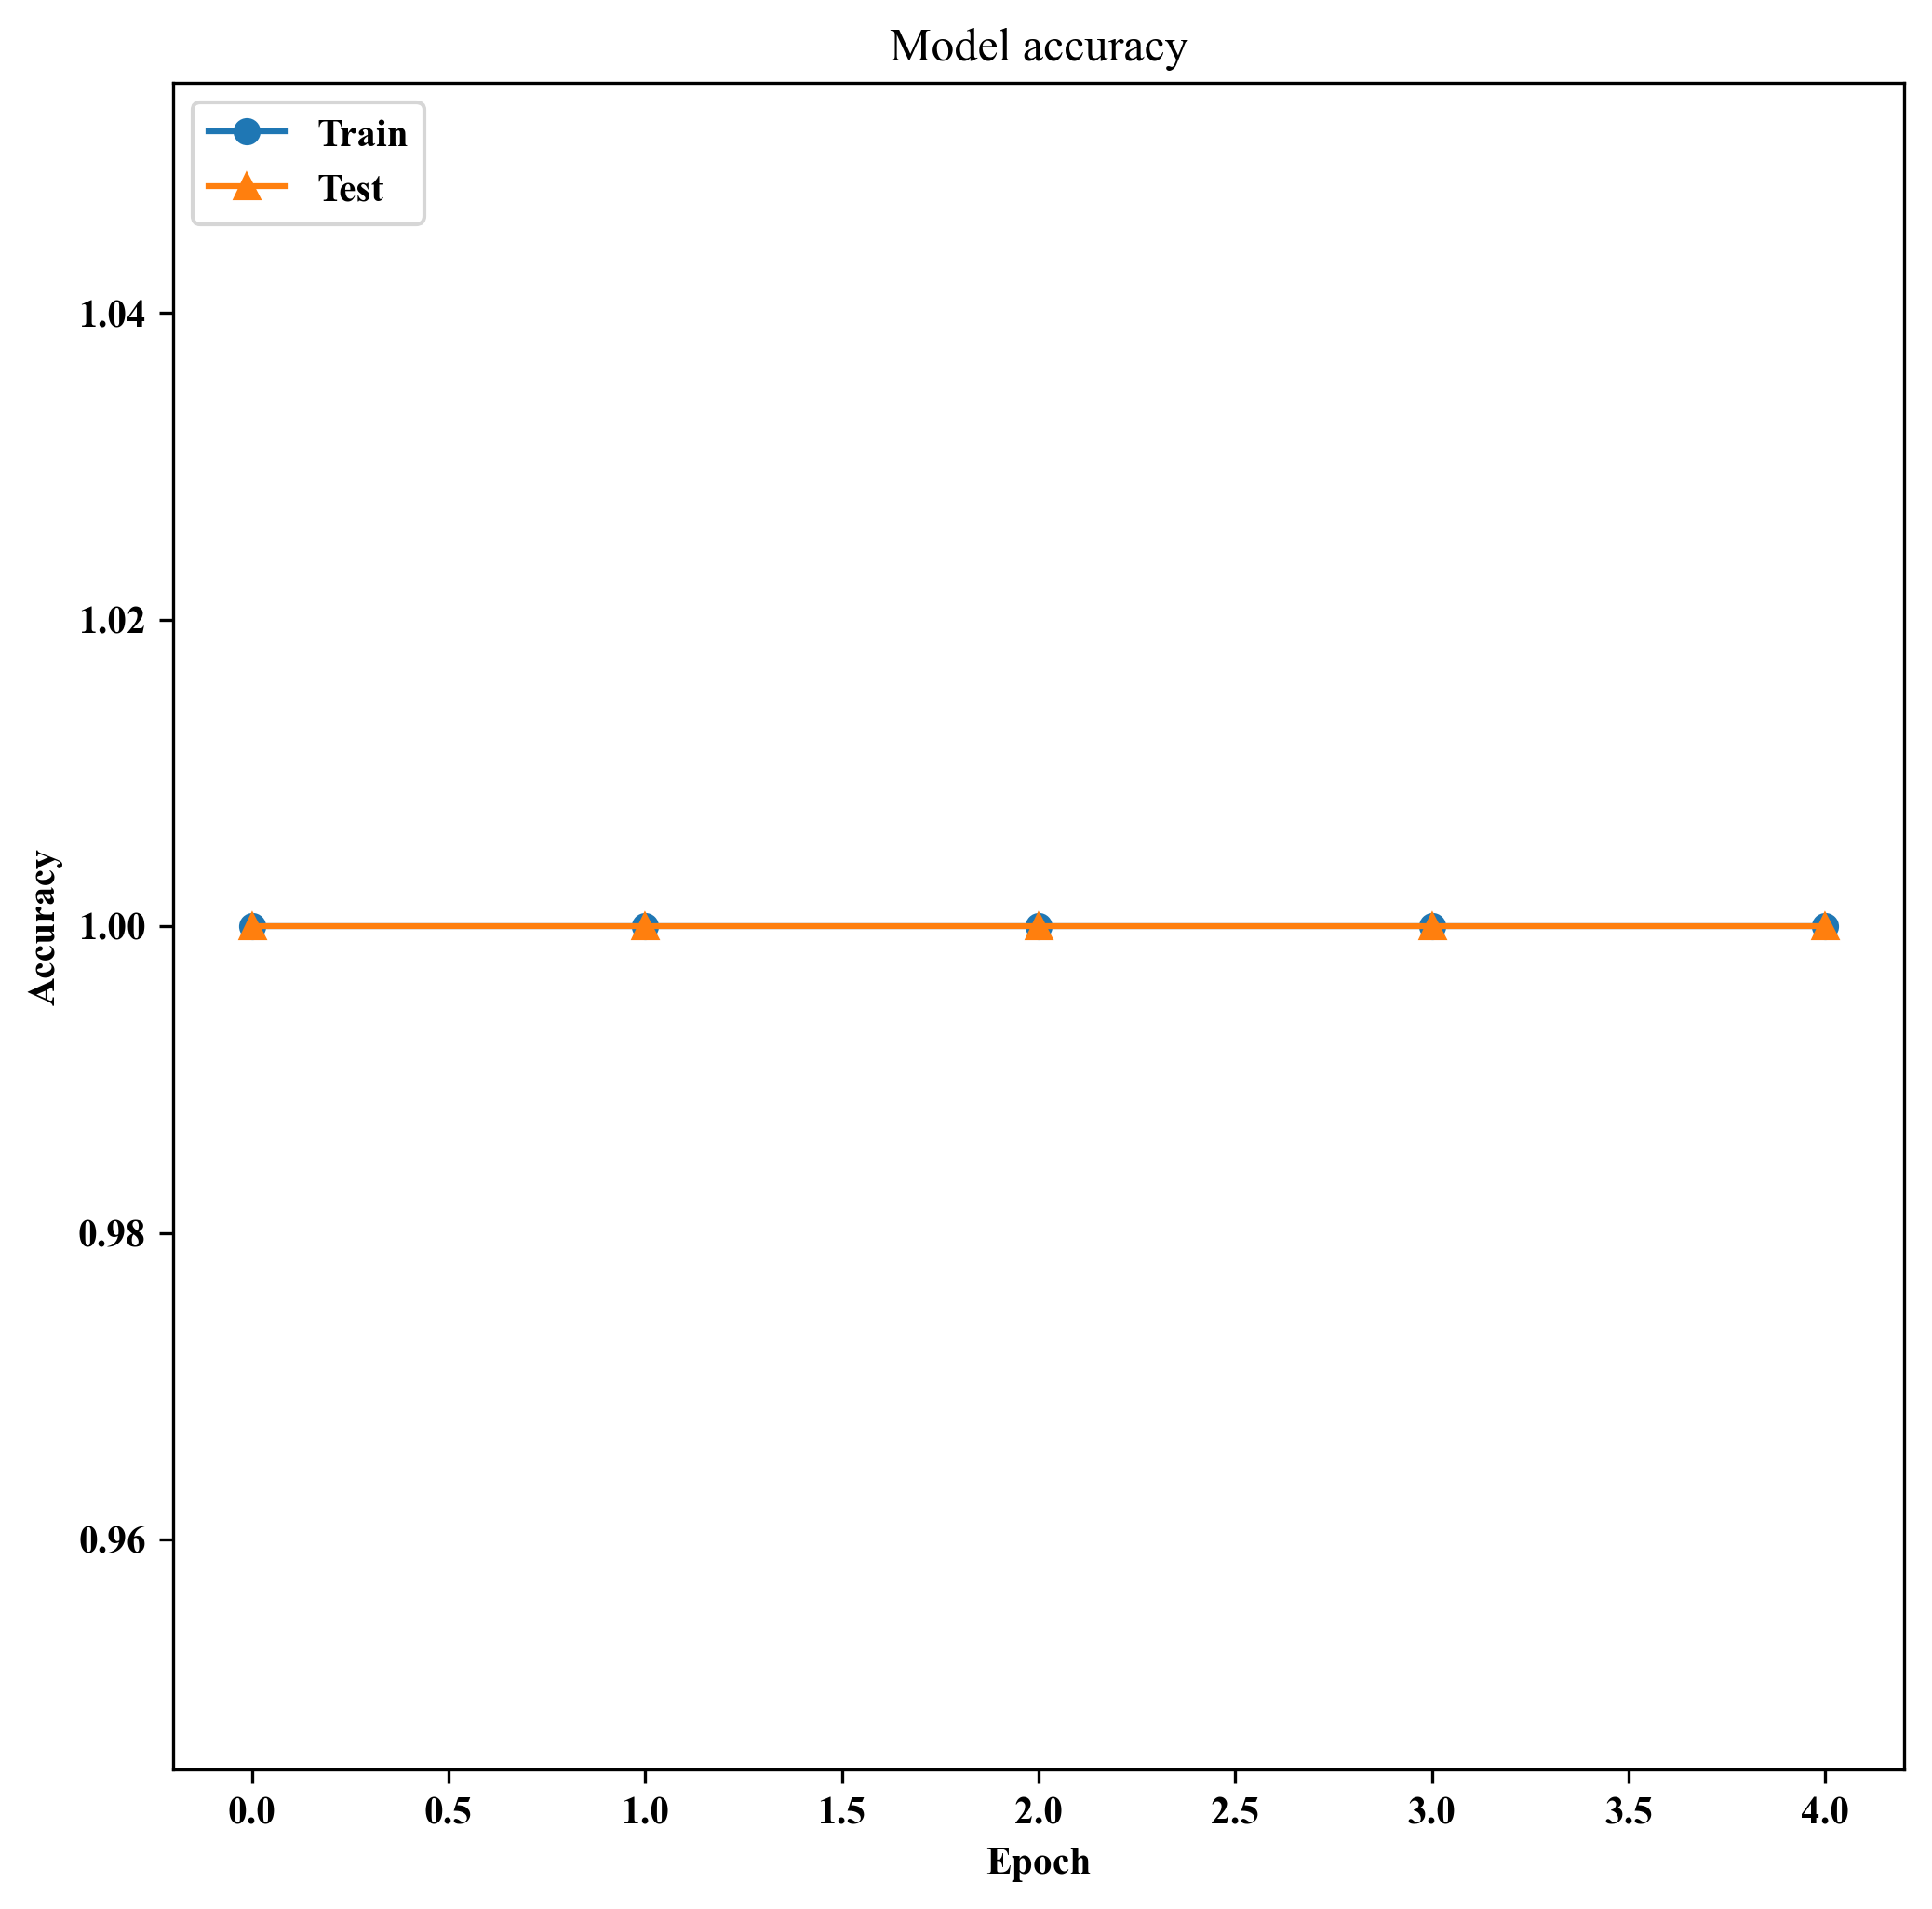

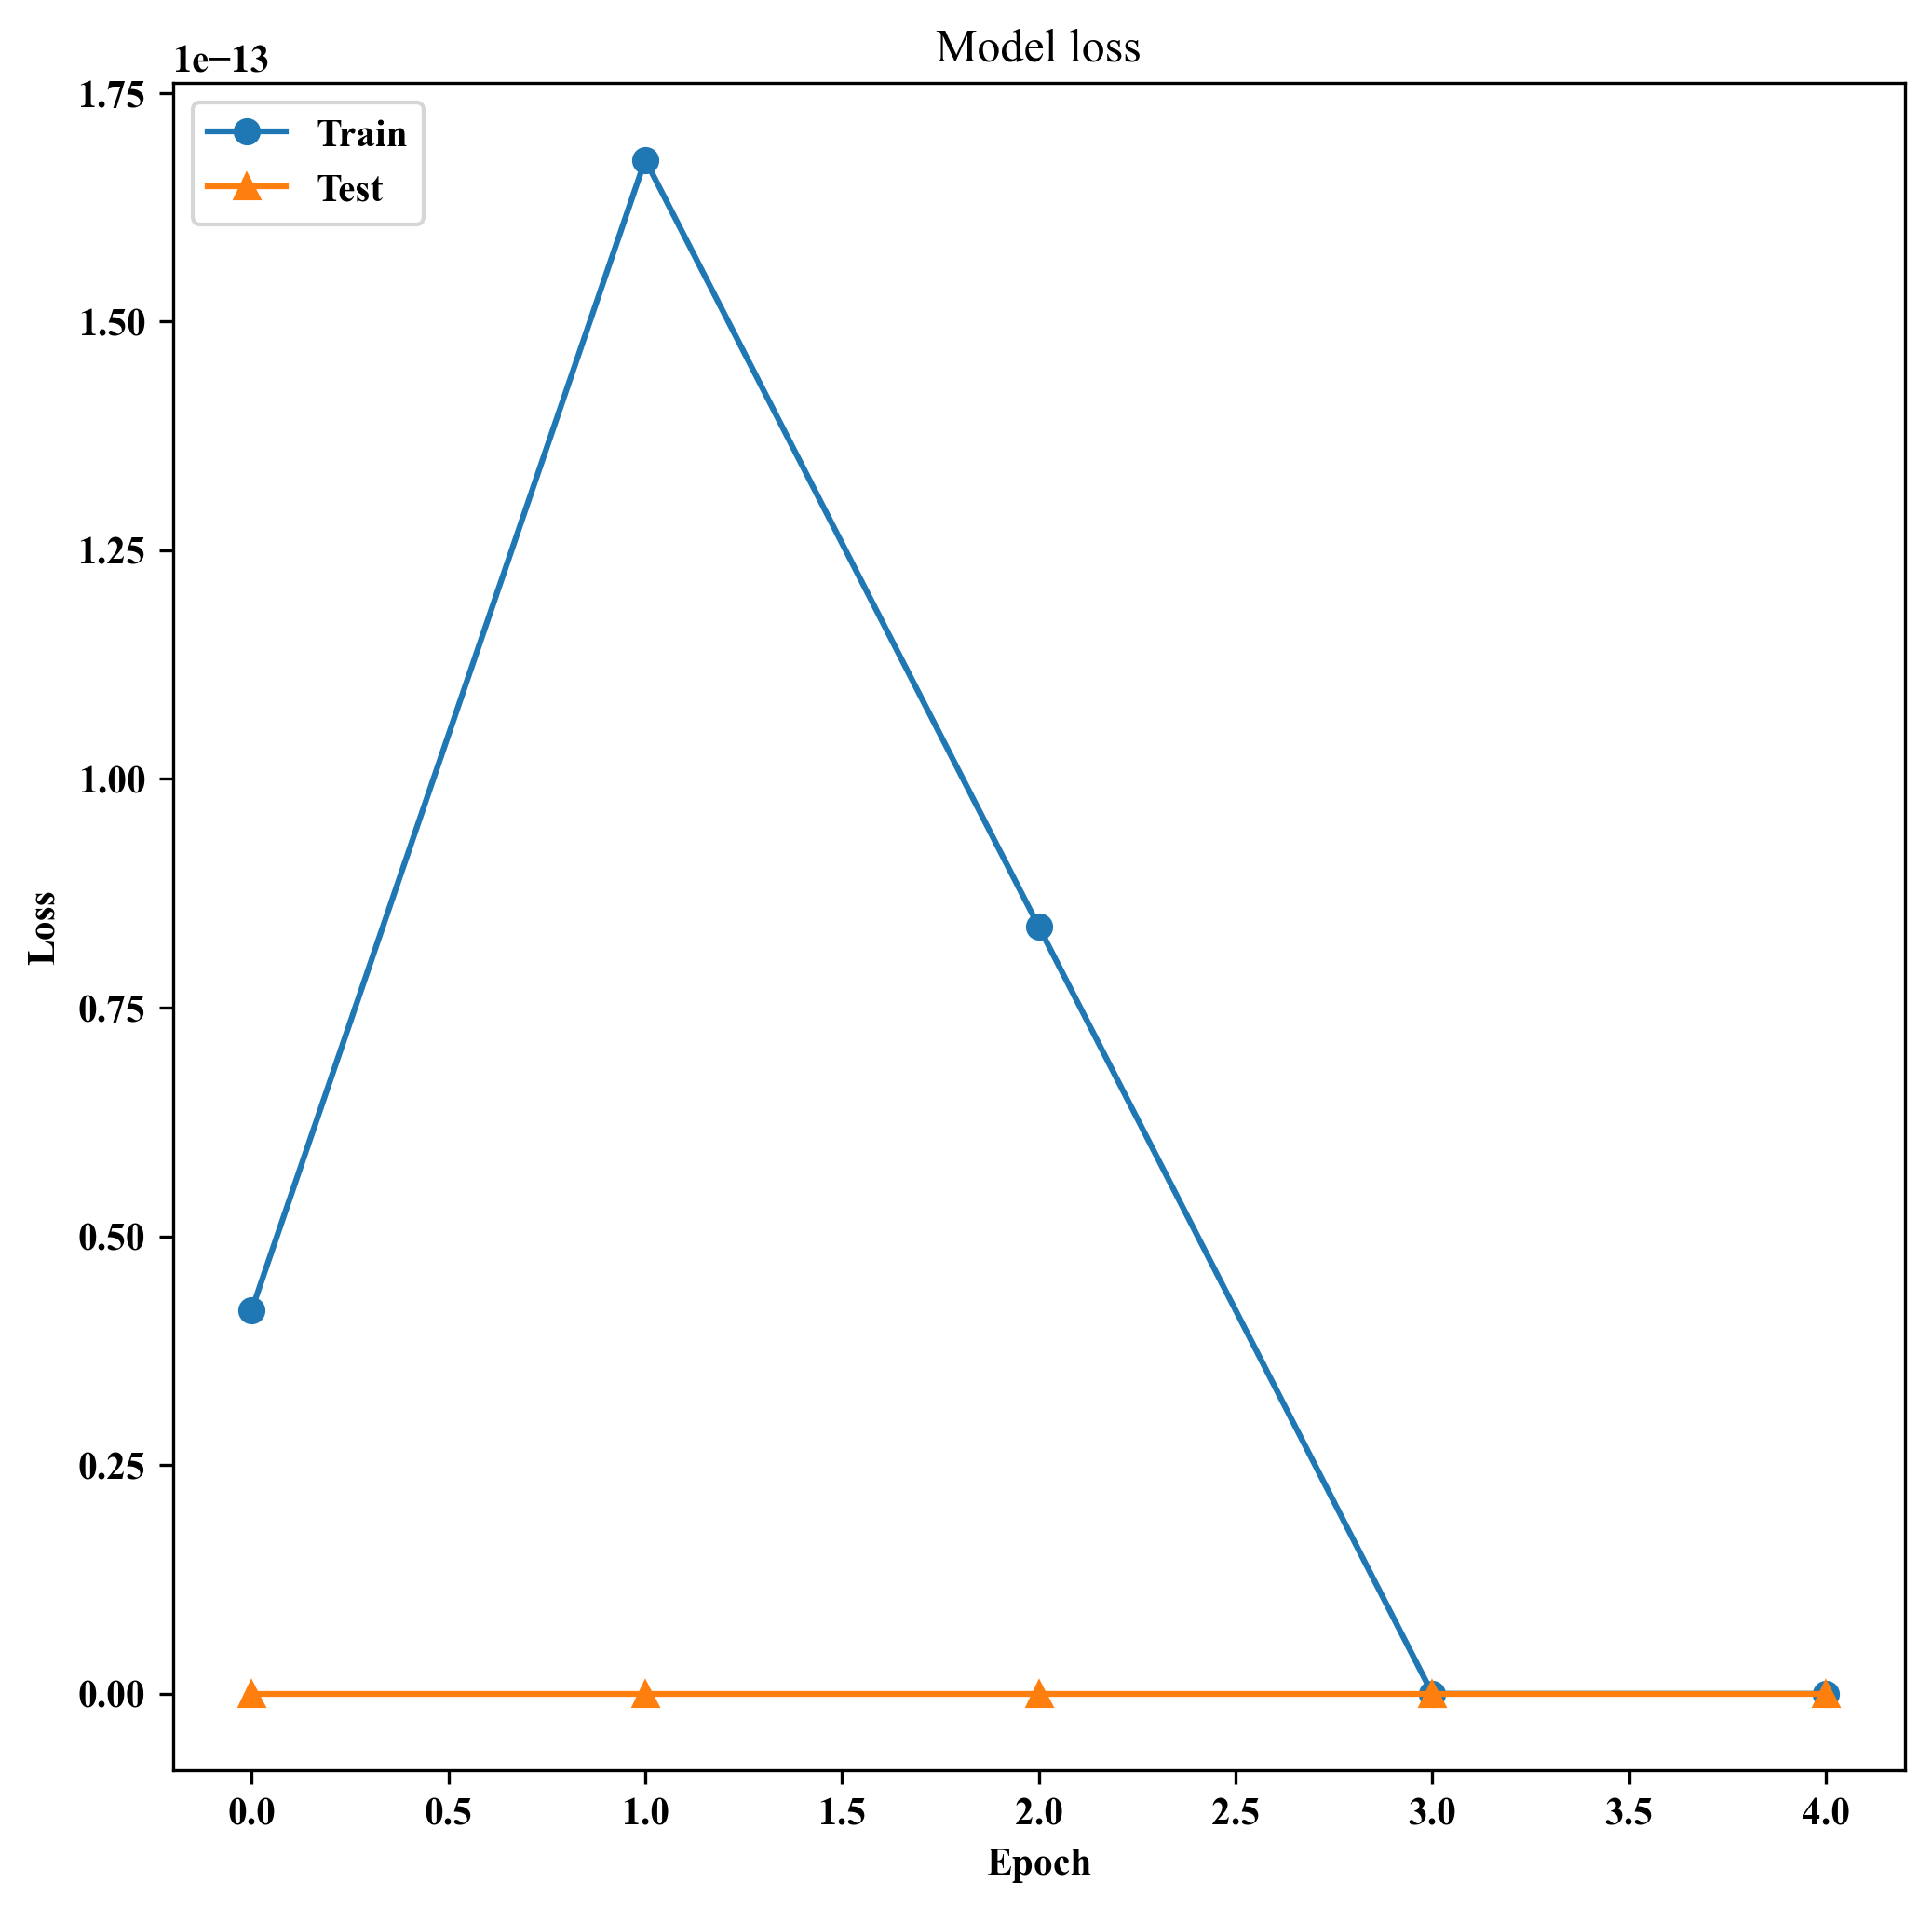

In [39]:
#----------------------------------第五步 可视化--------------------------------
# 绘制训练 & 验证的准确率值,用点表示
plt.figure(figsize=(8,8),dpi=300)
plt.plot(history.history['accuracy'], 'o-')
plt.plot(history.history['val_accuracy'], '^-')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
# plt.savefig('cnn_bilstm_accuracy.png')
plt.show()

plt.figure(figsize=(8,8),dpi=300)
# 绘制训练 & 验证的损失值,用三角表示
plt.plot(history.history['loss'], 'o-')
plt.plot(history.history['val_loss'], '^-')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
# plt.savefig('cnn_bilstm_loss.png')
plt.show()


In [40]:
print("模型预测")
mainModel = load_model('model_intra\\cnn_bilstm_model2_gear.h5', custom_objects={'AttentionLayer': AttentionLayer(50)}, compile=False)
# 预测


模型预测


In [41]:
# import time
# from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# # 计算预测时间
# start_time = time.time()  # 记录开始时间
# test_pre = mainModel.predict(testSeq)
# end_time = time.time()  # 记录结束时间
# average_prediction_time = (end_time - start_time) / len(testSeq)
# print("Average Prediction Time per Data Point: {:.6f} seconds".format(average_prediction_time))

# confm = confusion_matrix(np.argmax(y_test.values, axis=1), np.argmax(test_pre, axis=1))

# # Calculate the false positive rate
# tn, fp, fn, tp = confm.ravel()
# false_positive_rate = fp / (fp + tn)
# print("False Positive Rate: {:.4f}".format(false_positive_rate))

# print(confm)

# print(classification_report(np.argmax(y_test.values, axis=1), np.argmax(test_pre, axis=1), digits=4))
# print("Accuracy:", accuracy_score(np.argmax(y_test.values, axis=1), np.argmax(test_pre, axis=1)))

# plt.figure(figsize=(8, 8), dpi=300)
# sns.heatmap(confm, square=True, annot=True,
#             fmt='d', cbar=False, linewidths=.6,
#             cmap="Blues")
# plt.xlabel('Predicted label', size=14)
# plt.ylabel('True label', size=14)
# Labname = ['Normal','gear']   #行列名
# plt.xticks(np.arange(2) + 0.5, Labname, size=12)
# plt.yticks(np.arange(2) + 0.5, Labname, size=12)

# plt.show()


Average Prediction Time per Data Point: 0.000084 seconds
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000    769266
           1     1.0000    1.0000    1.0000    119363

    accuracy                         1.0000    888629
   macro avg     1.0000    1.0000    1.0000    888629
weighted avg     1.0000    1.0000    1.0000    888629

Accuracy:1.0000
MCC:1.0000
Kappa:1.0000
False Positive Rate (Benign samples misclassified as attacks): 0.0000


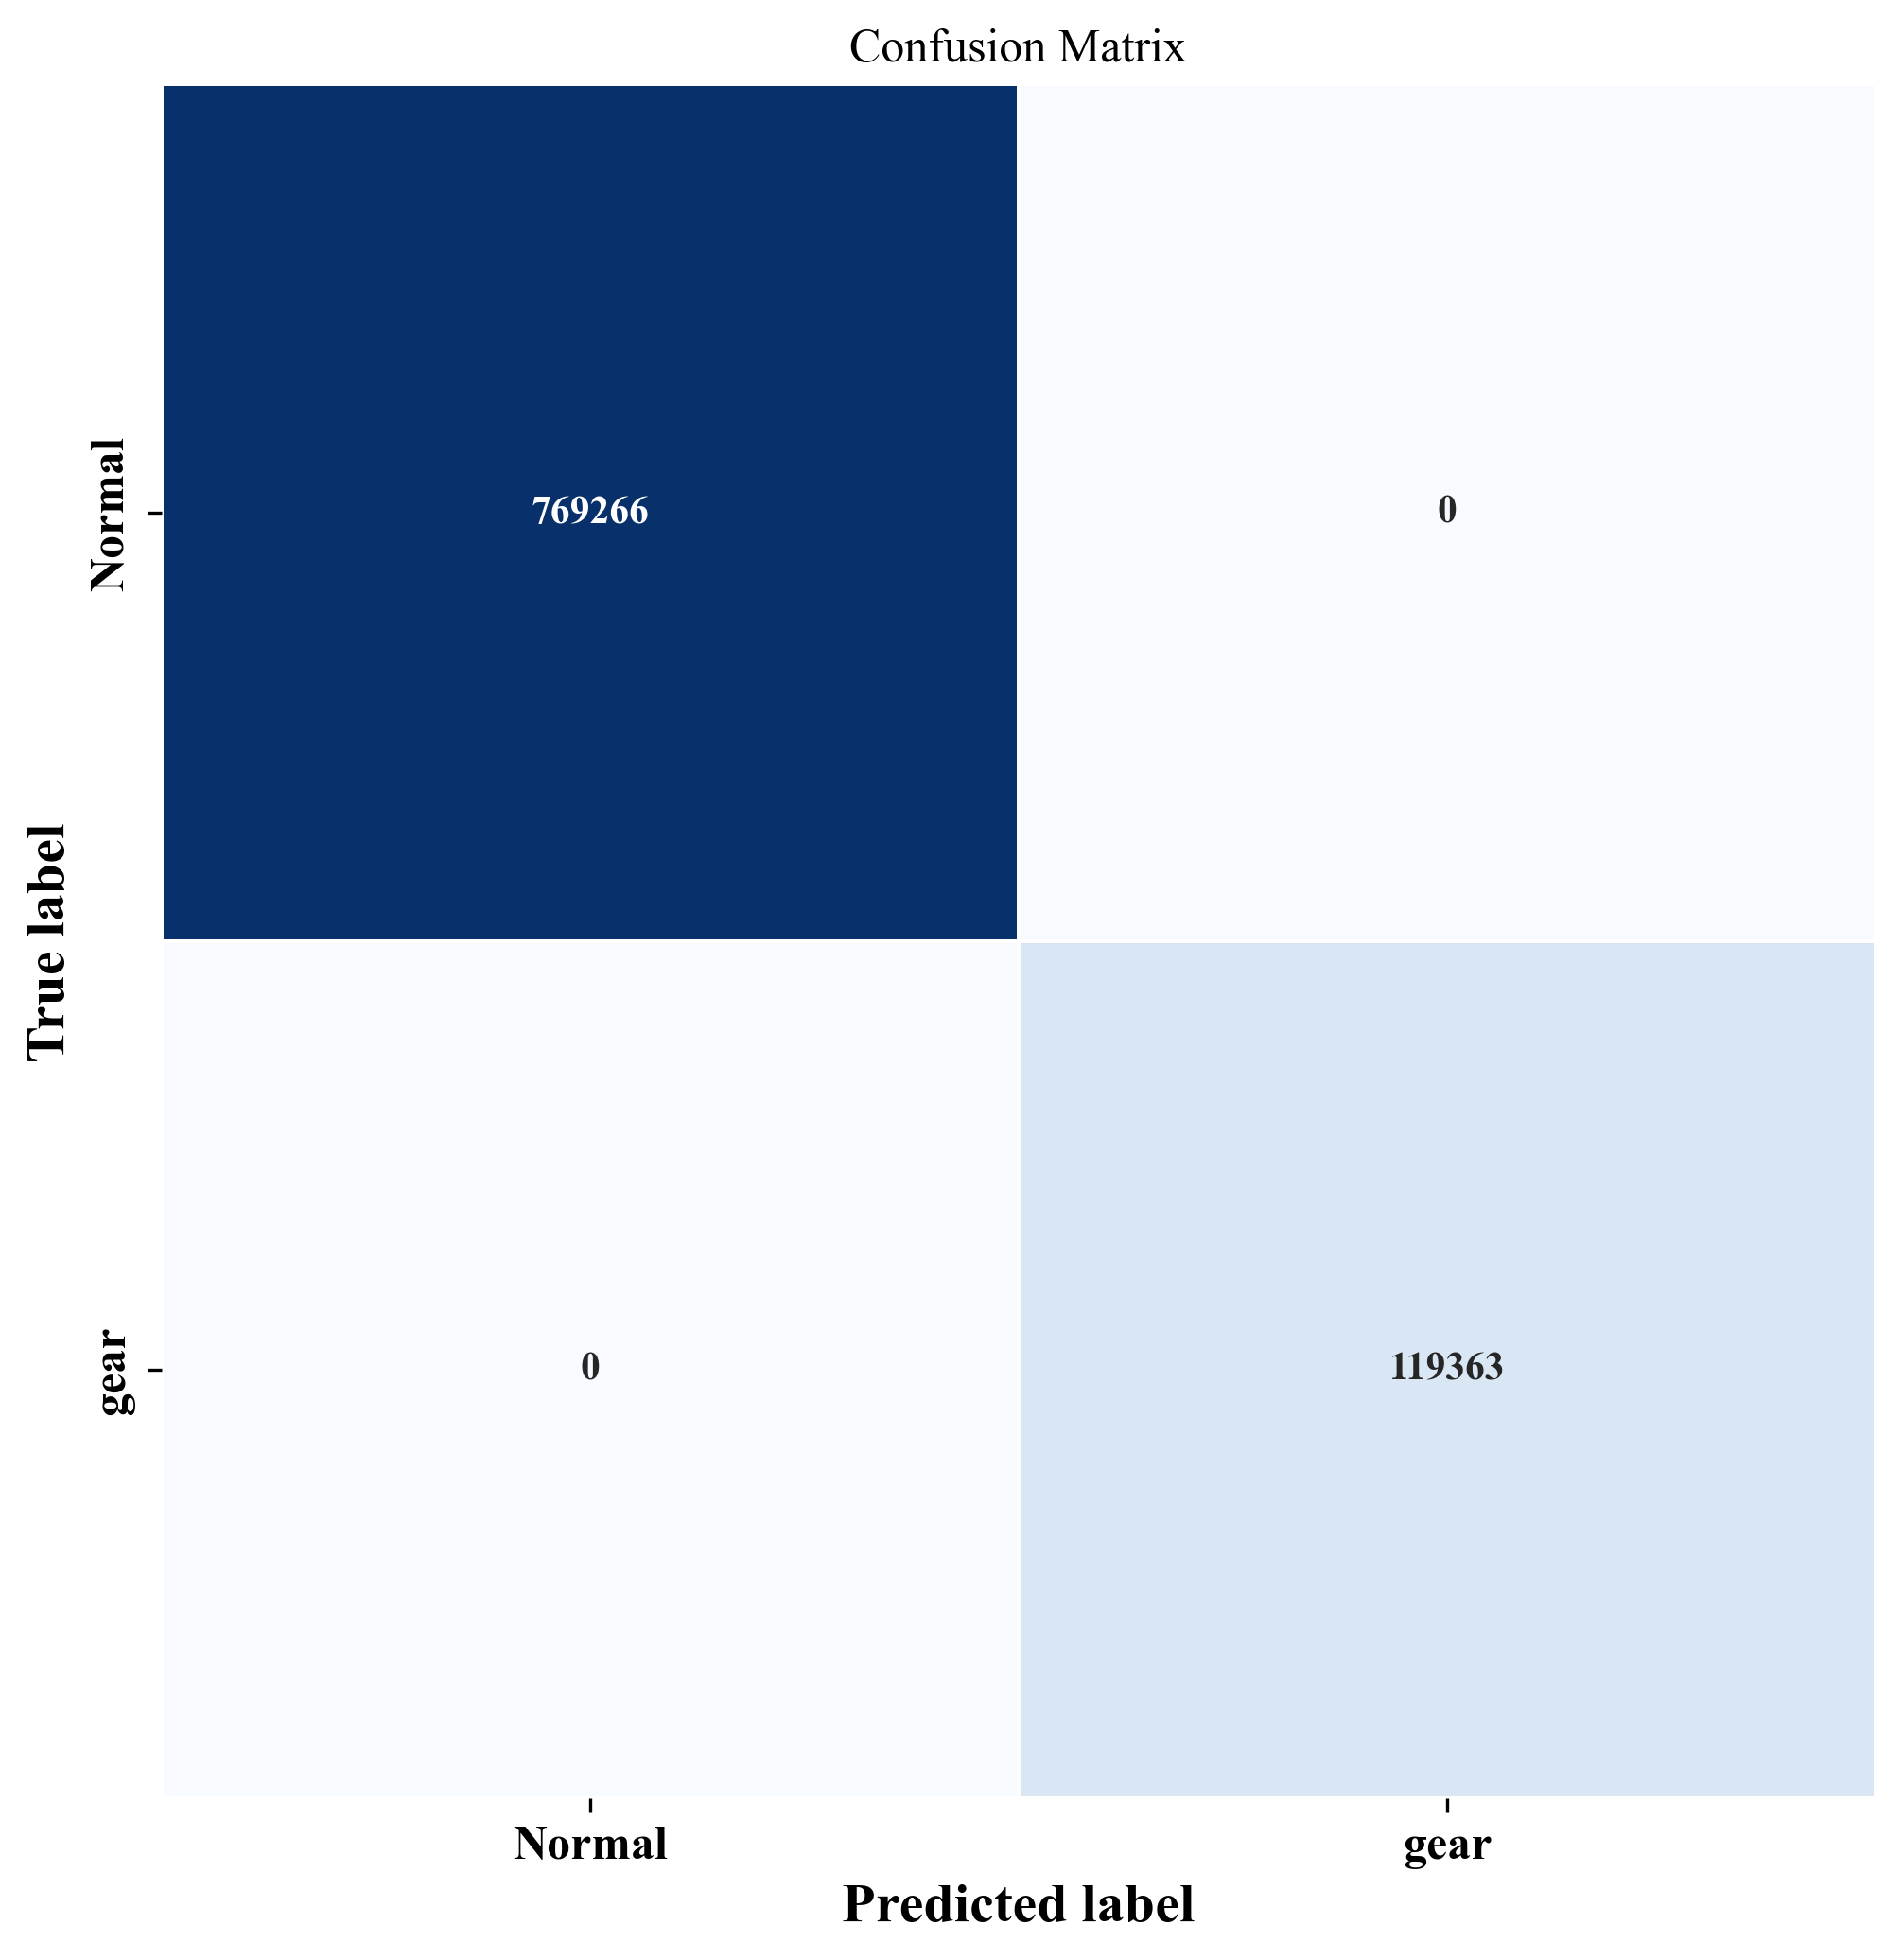

In [42]:
# 计算预测时间
start_time = time.time()  # 记录开始时间
test_pre = mainModel.predict(testSeq)
end_time = time.time()  # 记录结束时间
average_prediction_time = (end_time - start_time) / len(testSeq)
print("Average Prediction Time per Data Point: {:.6f} seconds".format(average_prediction_time))

# 计算混淆矩阵
confm = metrics.confusion_matrix(np.argmax(y_test, axis=1), np.argmax(test_pre, axis=1))
# 计算classification_report
print(metrics.classification_report(np.argmax(y_test, axis=1),
                                    np.argmax(test_pre, axis=1),
                                    digits=4))
# 计算准确度
accuracy = metrics.accuracy_score(np.argmax(y_test, axis=1),
                                          np.argmax(test_pre, axis=1))
print("Accuracy:{:.4f}".format(accuracy))
# 计算MCC
mcc = metrics.matthews_corrcoef(np.argmax(y_test, axis=1),
                                          np.argmax(test_pre, axis=1))
print("MCC:{:.4f}".format(mcc))
# 计算kappa
kappa = metrics.cohen_kappa_score(np.argmax(y_test, axis=1),
                                          np.argmax(test_pre, axis=1))
print("Kappa:{:.4f}".format(kappa))
# 计算误报率（False Positive Rate）
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(test_pre, axis=1)
false_positives = np.sum((y_true == 0) & (y_pred != 0))  # 0 represents the "Benign" class
total_benign_samples = np.sum(y_true == 0)
false_positive_rate = false_positives / total_benign_samples
print("False Positive Rate (Benign samples misclassified as attacks): {:.4f}".format(false_positive_rate))

# 画图
#设置所有图片的字体大小为10，字体为Times New Roman，字体为粗体，label的字体大小为10，字体为Times New Roman，字体为粗体
plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'

plt.figure(figsize=(8, 8), dpi=300)
sns.heatmap(confm, square=True, annot=True,
            fmt='d', cbar=False, linewidths=.6,
            cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted label', size=14)
plt.ylabel('True label', size=14)
Labname = ['Normal','gear']   #行列名
plt.xticks(np.arange(2) + 0.5, Labname, size=12)
plt.yticks(np.arange(2) + 0.5, Labname, size=12)
plt.show()


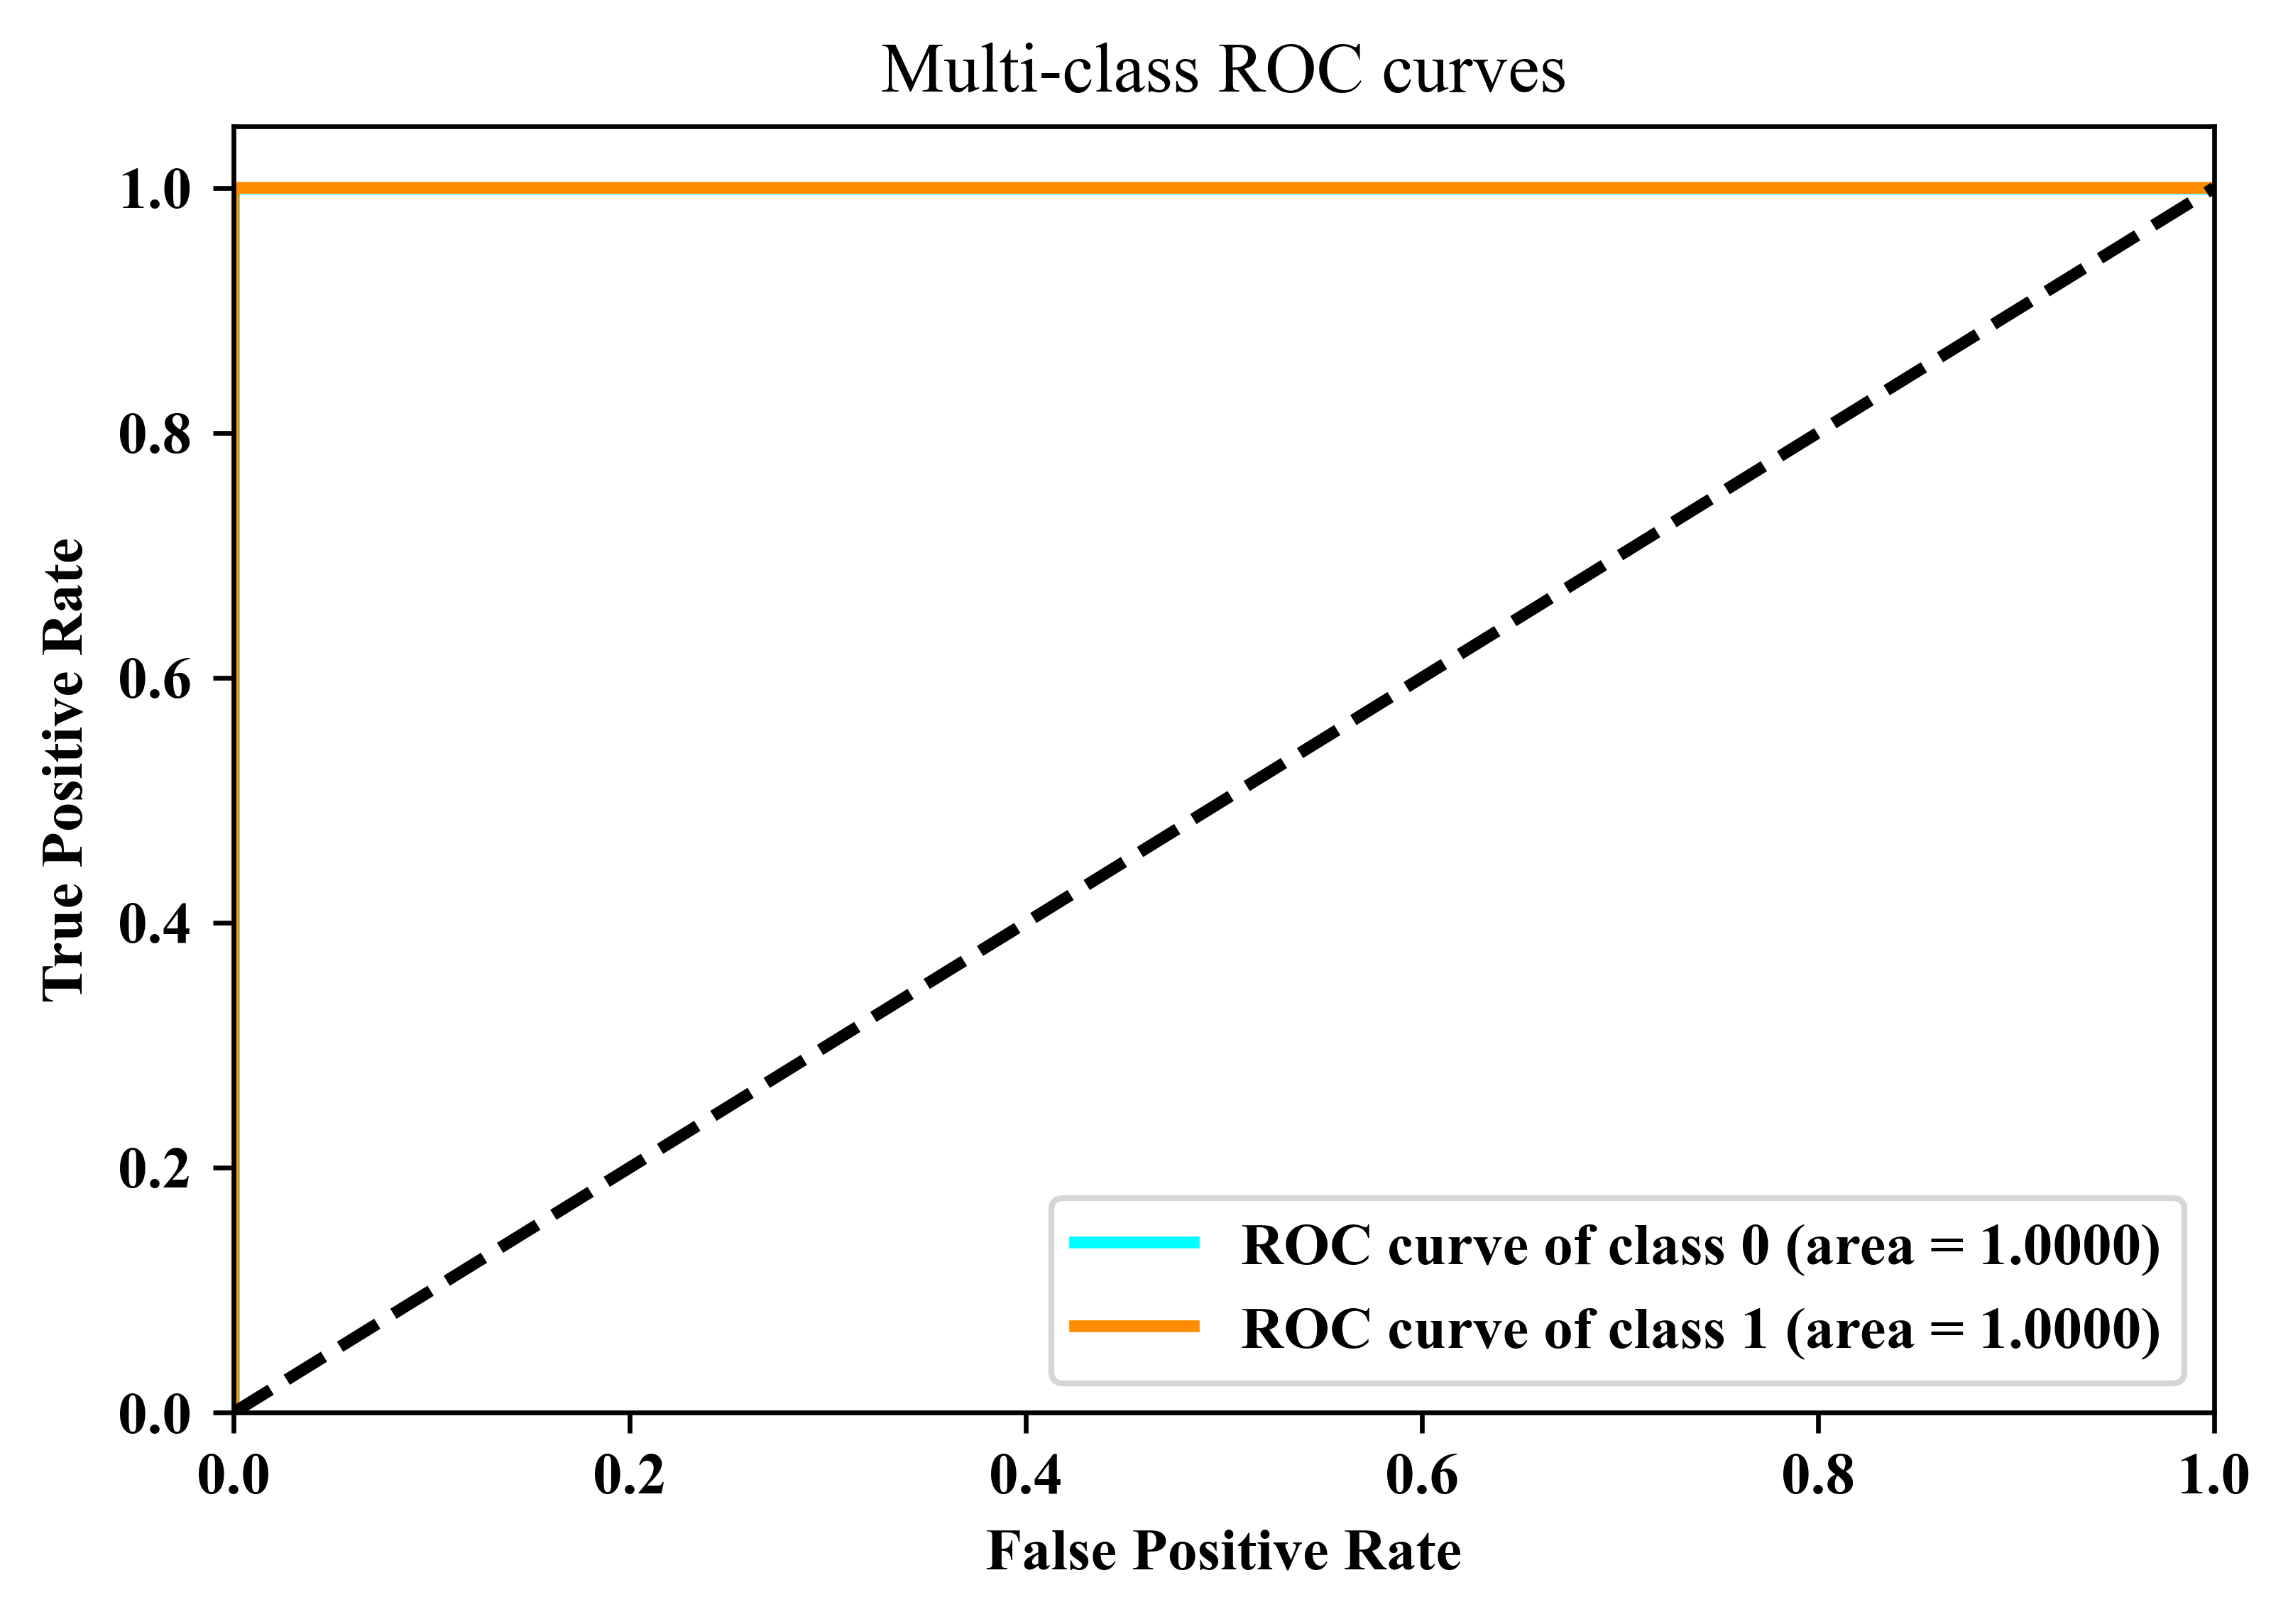

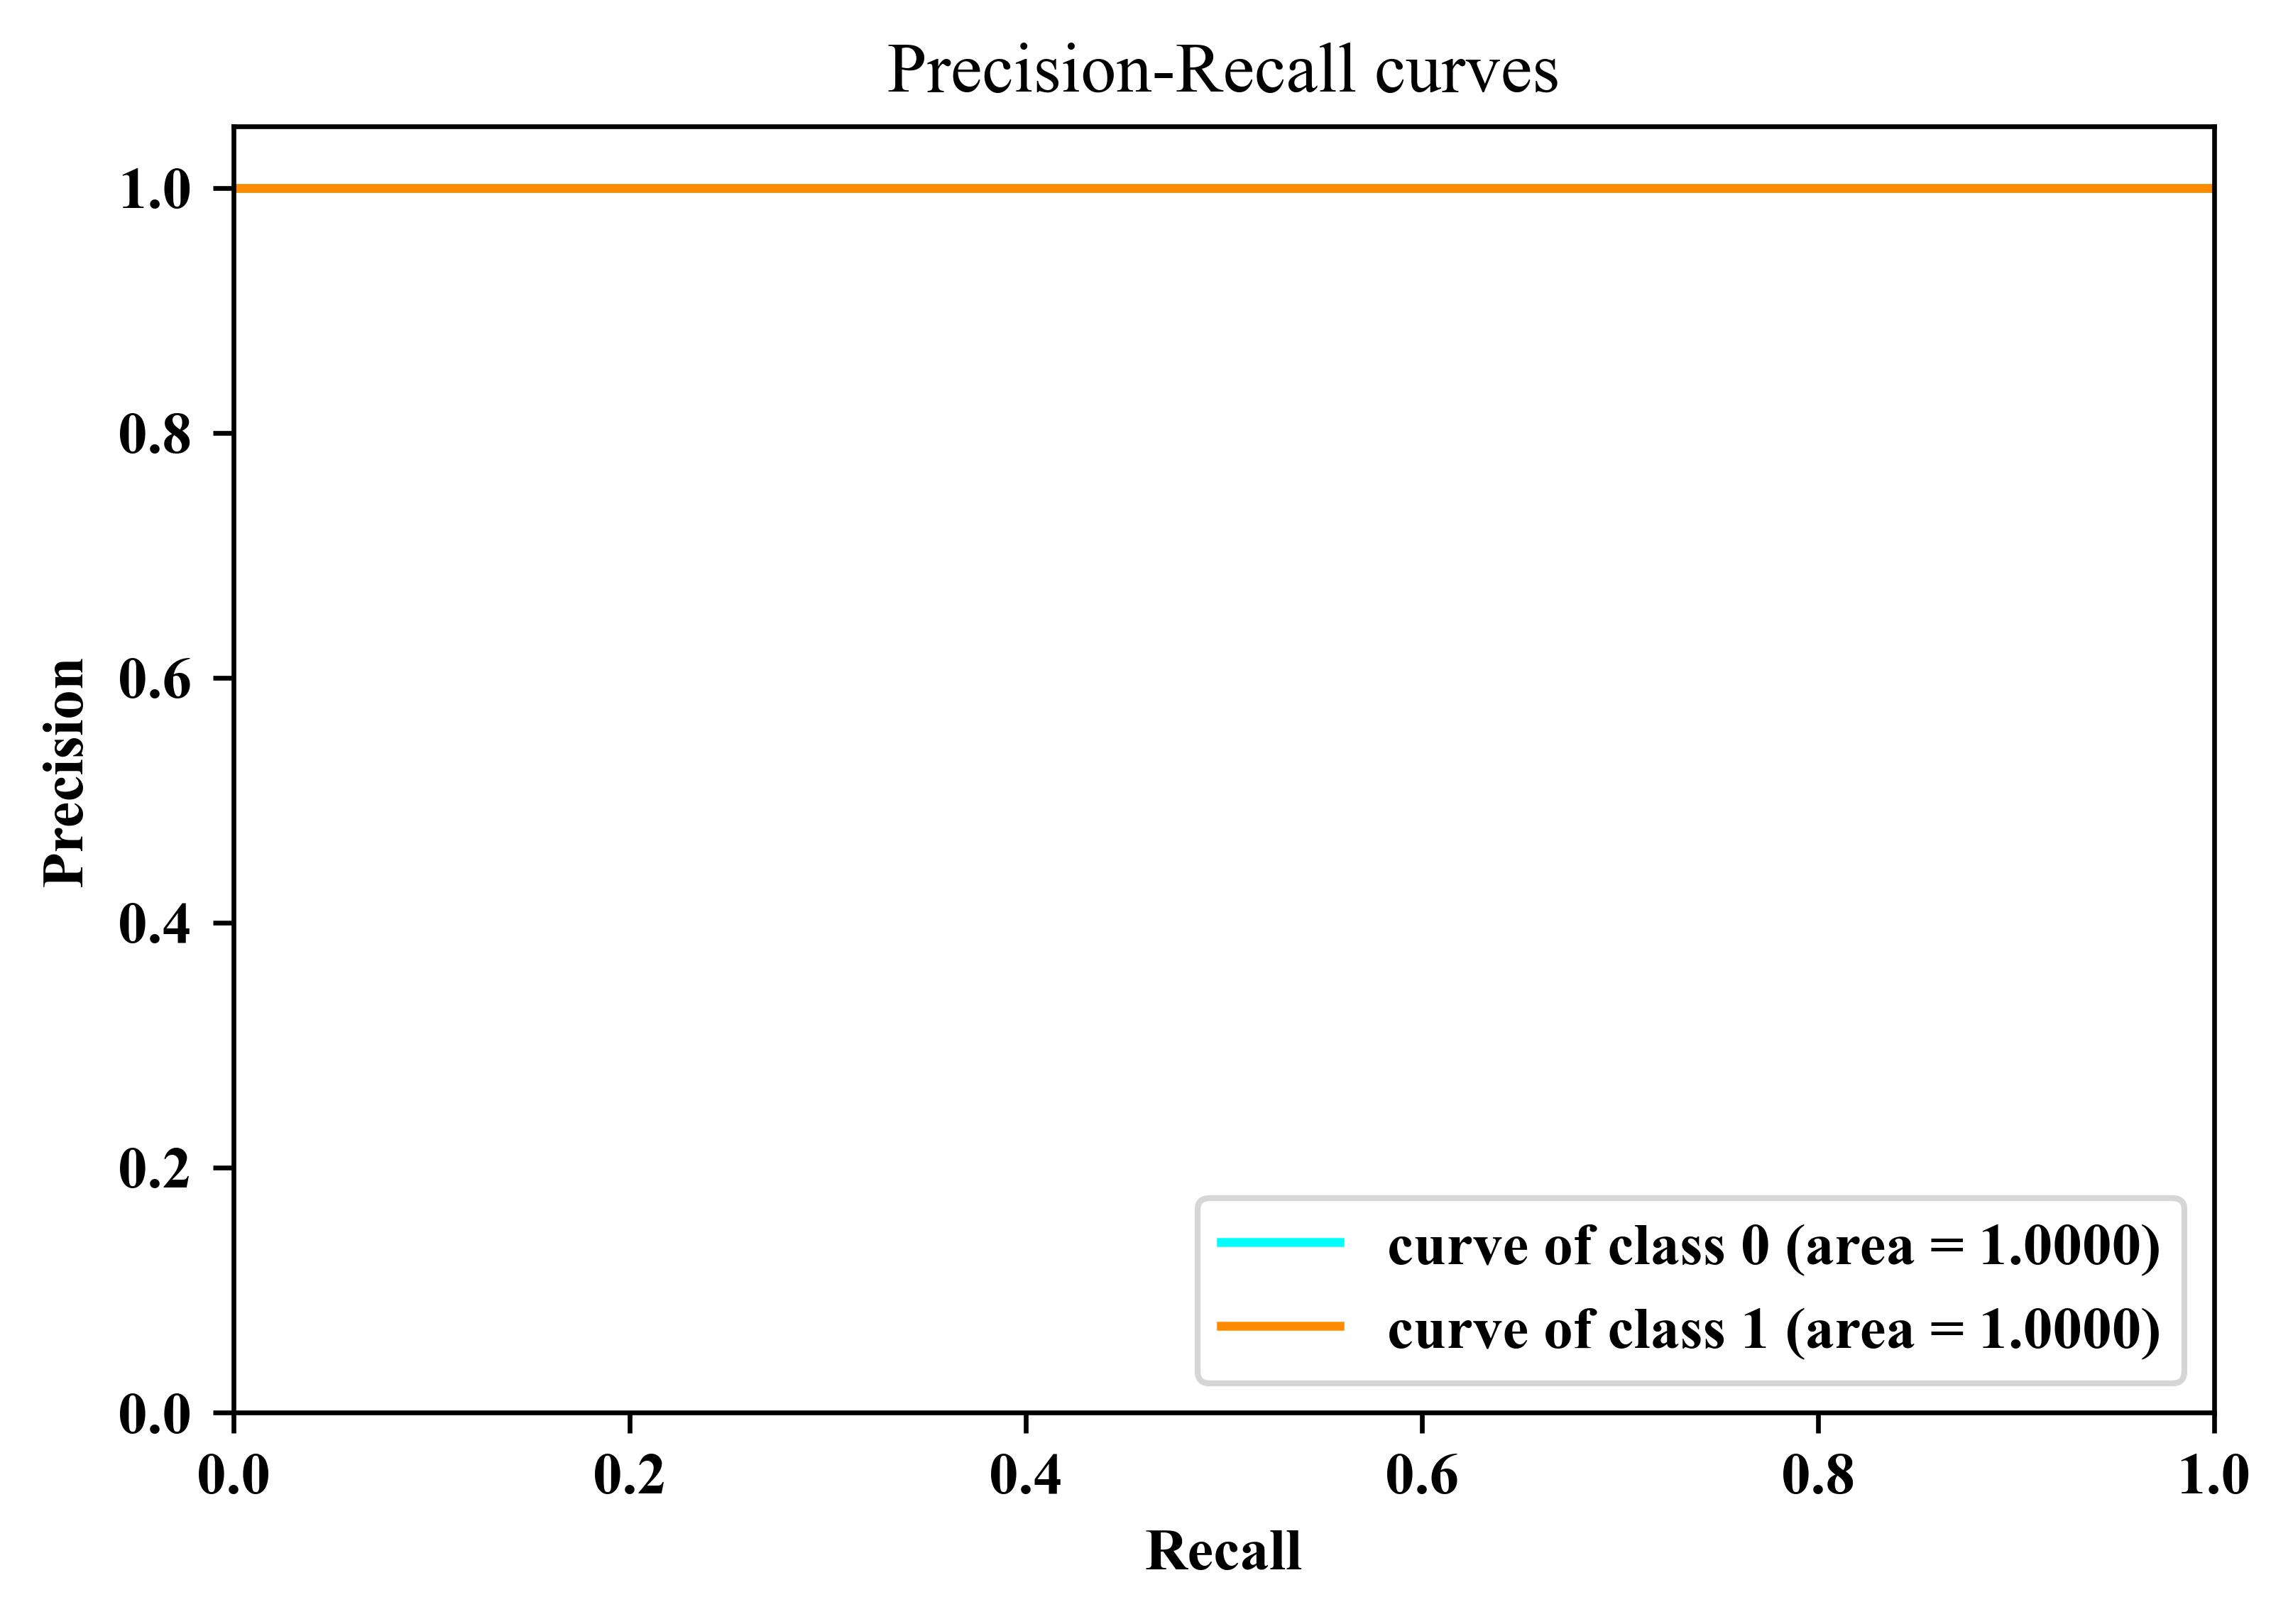

In [43]:

# Compute ROC curve and ROC area for each class
n_classes = 2
# Compute ROC curve and ROC area for each class
# 保存每一类的fpr和tpr值到csv文件，便于后续画图
fpr = dict()
tpr = dict()
roc_auc = dict()
thresholds = dict()
for i in range(n_classes):
    fpr[i], tpr[i], thresholds[i] = metrics.roc_curve(y_test[:, i], test_pre[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    df = pd.DataFrame({'fpr':fpr[i],'tpr':tpr[i]})
    df.to_csv('./Results/intra_adam_gear_fpr_tpr_{}.csv'.format(i))
# 画图AUC-ROC
plt.figure(dpi=600)
lw = 2
colors = cycle(["aqua", "darkorange", "darkgreen", "yellow", "red", "purple", "blue", "gray"])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
    label="ROC curve of class {0} (area = {1:0.4f})".format(i, roc_auc[i]),)
plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('Multi-class ROC curves')
plt.legend(loc="lower right")
plt.show()



# Compute auc-pr and AP(average precision) for each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = metrics.precision_recall_curve(y_test[:, i], test_pre[:, i])
    average_precision[i] = metrics.average_precision_score(y_test[:, i], test_pre[:, i])
    df = pd.DataFrame({'precision':precision[i],'recall':recall[i]})
    df.to_csv('./Results/intra_adam_gear_precision_recall_{}.csv'.format(i))
# 绘制所有类别的pr曲线
plt.figure(dpi=600)
lw = 2
colors = cycle(["aqua", "darkorange", "darkgreen", "yellow", "red", "purple", "blue", "gray"])
for i, color in zip(range(n_classes), colors):
    plt.step(recall[i], precision[i], color=color, where="post", label="curve of class {0} (area = {1:0.4f})".format(i, average_precision[i]))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title("Precision-Recall curves")
plt.legend(loc="lower right")
plt.show()   


## 二分类：处理数据（RPM）

In [44]:
#--------------------------------------第一步 数据预处理--------------------------------
import csv
# 打开CSV文件
with open('Data\9) Car-Hacking Dataset\RPM_dataset.csv', 'r') as file:
    # 创建CSV读取器
    reader = csv.reader(file)
    # 创建空列表来存储处理后的数据
    processed_data = []

    # 记录开始时间
    start_time = time.time()

    # 读取CSV文件中的每一行数据
    for row in reader:
        # 处理每一行数据

        # 获取最后一列作为标签
        label = row[-1]
        # 将第二列数据的两个16进制数据，拆分为两个16进制字符串，即0316拆分为"03"和"16"
        hex_data1 = row[1][0:2]
        hex_data2 = row[1][2:]
        row[1] = row[1][0:2] + ' ' + row[1][2:]
        # 将第四到倒数第二列的值转化为字符串
        new_col = ' '.join(map(str, row[3:-1]))
        new_col = hex_data1 + ' ' + hex_data2 + ' ' + new_col
        
        # 示例：将处理后的数据添加到列表中
        processed_data.append((new_col, label))

    # 记录结束时间
    end_time = time.time()

    # Calculate the total processing time
    total_processing_time = end_time - start_time

    # 使用pandas.DataFrame()函数将列表转化为数据框
    RPM_dataset = pd.DataFrame(processed_data, columns=['DATA', 'Flag'])

    # Calculate the average processing time
    dataset_size = len(processed_data)
    average_processing_time = total_processing_time / dataset_size
    print("Total Processing Time: {:.6f} seconds".format(total_processing_time))
    print("Average Processing Time per Row: {:.6f} seconds".format(average_processing_time))

RPM_dataset

Total Processing Time: 9.767739 seconds
Average Processing Time per Row: 0.000002 seconds


DATA Flag
0        03 16 05 22 68 09 22 20 00 75    R
1        01 8f fe 3b 00 00 00 3c 00 00    R
2        02 60 19 22 22 30 ff 8f 6e 3f    R
3        02 a0 60 00 83 1d 96 02 bd 00    R
4        03 29 dc b8 7e 14 11 20 00 14    R
...                                ...  ...
4621697  01 8f fe 59 00 00 00 41 00 00    R
4621698  02 60 18 21 21 30 08 8f 6d 19    R
4621699  02 a0 24 00 9a 1d 97 02 bd 00    R
4621700  03 29 dc b7 7f 14 11 20 00 14    R
4621701  05 45 d8 00 00 8b 00 00 00 00    R

[4621702 rows x 2 columns]

In [45]:
# 将Flag中的Nomal和Attack转换为0和1，不使用LabelEncoder
from sklearn.preprocessing import OneHotEncoder
RPM_dataset['Flag'] = RPM_dataset['Flag'].replace({'R': 0, 'T': 1})
print(RPM_dataset['Flag'].value_counts())

# 将Class和SubClass转换为OneHotEncoder
# one_hot_encoded = pd.get_dummies(RPM_dataset['Flag'])
# print(one_hot_encoded)
from keras.utils import np_utils
one_hot_encoded = np_utils.to_categorical(RPM_dataset['Flag'])

0    3966805
1     654897
Name: Flag, dtype: int64


In [46]:
# 取出数据集中除了标签以外的数据
RPM_X = RPM_dataset.drop(['Flag'], axis=1)

# 将数据集划分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(RPM_X, one_hot_encoded, test_size=0.2, random_state=0)
print(y_train.shape)
print(y_test.shape)

(3697361, 2)
(924341, 2)


In [47]:


content = RPM_X['DATA']
# print(content)
# 使用Tokenizer对词组进行编码
# 特征编号，不足的前面补0
# fit_on_texts函数可以将输入的文本每个词编号 编号根据词频(词频越大编号越小)
max_words = 256 ##使用的最大词语数为1000
maxLen = 10 #句子的长度最多为8
# 计算对整个数据集的词进行词频统计的时间

start_time1 = time.time()
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(content)
end_time1 = time.time()
process_time1 = (end_time1 - start_time1) / len(content)  # Calculate average time per data point
vocab = tokenizer.word_index  #停用词已过滤,获取每个词的编号
# print(vocab)

# 使用word_index属性可以看到每次词对应的编码
# 使用word_counts属性可以看到每个词对应的频数
# print(tokenizer.word_index)
# print(tokenizer.word_counts)

"""
# 使用Tokenizer对词组进行编码
# 当我们创建了一个Tokenizer对象后，使用该对象的fit_on_texts()函数，以空格去识别每个词
# 可以将输入的文本中的每个词编号，编号是根据词频的，词频越大，编号越小
"""

# 将train_value中的字符串按照空格进行分割
train_content = X_train['DATA']
test_content = X_test['DATA']
# print(train_content)
# print(test_content)

# 特征编号，将一句话表示为词编码的序列
# 计算由数据流转化为由词编码组成序列的时间
start_time2 = time.time()
trainID = tokenizer.texts_to_sequences(train_content)
end_time2 = time.time()
process_time2 = (end_time2 - start_time2) / len(train_content)  # Calculate average time per data point
testID = tokenizer.texts_to_sequences(test_content)
# print(trainID)
# print(testID)
# 该方法会让CNN训练的长度统一,(不足的前面补0)，使用sequence.pad_sequences()将每个序列调整为相同的长度
# 计算转化为的序列进行填充和截断的时间
start_time3 = time.time()
trainSeq = sequence.pad_sequences(trainID, maxlen=maxLen)
end_time3 = time.time()
process_time3 = (end_time3 - start_time3) / len(train_content)  # Calculate average time per data point
testSeq = sequence.pad_sequences(testID, maxlen=maxLen)

# print(trainSeq)
# print(testSeq)

print("Average Time for Word Frequency Count: {:.6f} seconds".format(process_time1))
print("Average Time for Converting Data to Sequences: {:.6f} seconds".format(process_time2))
print("Average Time for Padding and Truncating Sequences: {:.6f} seconds".format(process_time3))


Average Time for Word Frequency Count: 0.000005 seconds
Average Time for Converting Data to Sequences: 0.000005 seconds
Average Time for Padding and Truncating Sequences: 0.000002 seconds


In [48]:
average_preprocess_time = average_processing_time + process_time1 + process_time2 + process_time3
print("Average Preprocessing Time per Data Point: {:.6f} seconds".format(average_preprocess_time))

Average Preprocessing Time per Data Point: 0.000015 seconds


In [49]:
# 建立Attention机制
# Keras自定义的函数主要分为四个部分，分别是：
#   init：初始化一些需要的参数
#   bulid：具体来定义权重是怎么样的
#   call：核心部分，定义向量是如何进行运算的
#   compute_output_shape：定义该层输出的大小
# Hierarchical Model with Attention
from keras import initializers
from keras import constraints
from keras import activations
from keras import regularizers
from keras import backend as K
from keras.layers import Layer

K.clear_session()

class AttentionLayer(Layer):
    def __init__(self, attention_size=None, **kwargs):
        self.attention_size = attention_size
        super(AttentionLayer, self).__init__(**kwargs)
        
    def get_config(self):
        config = super().get_config()
        config['attention_size'] = self.attention_size
        return config
        
    def build(self, input_shape):
        assert len(input_shape) == 3
        
        self.time_steps = input_shape[1]
        hidden_size = input_shape[2]
        if self.attention_size is None:
            self.attention_size = hidden_size
            
        self.W = self.add_weight(name='att_weight', shape=(hidden_size, self.attention_size),
                                initializer='uniform', trainable=True)
        self.b = self.add_weight(name='att_bias', shape=(self.attention_size,),
                                initializer='uniform', trainable=True)
        self.V = self.add_weight(name='att_var', shape=(self.attention_size,),
                                initializer='uniform', trainable=True)
        super(AttentionLayer, self).build(input_shape)

    
    
    def call(self, inputs):
        #self.V = K.reshape(self.V, (-1, 1))
        V = K.reshape(self.V, (-1, 1))
        H = K.tanh(K.dot(inputs, self.W) + self.b)
        #score = K.softmax(K.dot(H, self.V), axis=1)
        score = K.softmax(K.dot(H, V), axis=1)
        outputs = K.sum(score * inputs, axis=1)
        return outputs
    
    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[2]
    

# 建立Attention+CNN模型并训练
#构建TextCNN模型
num_labels = 2
inputs = Input(name='inputs',shape=[maxLen], dtype='float64')
#  Example:
#   >>> model = tf.keras.Sequential()
#   >>> model.add(tf.keras.layers.Embedding(1000, 64, input_length=10))
#   >>> # The model will take as input an integer matrix of size (batch,
#   >>> # input_length), and the largest integer (i.e. word index) in the input
#   >>> # should be no larger than 999 (vocabulary size). 意思就是输入的矩阵是一个batch*input_length的矩阵，每个元素是一个0-vocabulary size的整数
#   >>> # Now model.output_shape is (None, 10, 64), where `None` is the batch
#   >>> # dimension.
#   >>> input_array = np.random.randint(1000, size=(32, 10))
#   >>> model.compile('rmsprop', 'mse')
#   >>> output_array = model.predict(input_array)
#   >>> print(output_array.shape)
#   (32, 10, 64)
layer = Embedding(max_words+1, 128, input_length=maxLen, trainable=True)(inputs)
cnn1 = Convolution1D(64, 3, padding='same', strides = 1, activation='relu')(layer)
cnn1 = MaxPool1D(pool_size=4)(cnn1)
cnn2 = Convolution1D(64, 4, padding='same', strides = 1, activation='relu')(layer)
cnn2 = MaxPool1D(pool_size=4)(cnn2)
cnn3 = Convolution1D(64, 5, padding='same', strides = 1, activation='relu')(layer)
cnn3 = MaxPool1D(pool_size=4)(cnn3)

# 合并三个模型的输出向量
cnn = concatenate([cnn1,cnn2,cnn3], axis=-1)

# BiLSTM+Attention
# bilstm = Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.1, return_sequences=True))(cnn)
bilstm = Bidirectional(LSTM(128, return_sequences=True))(cnn)  #参数保持维度3
layer = Dense(256, activation='relu')(bilstm)
layer = Dropout(0.3)(layer)
attention = AttentionLayer(attention_size=50)(layer)

output = Dense(num_labels, activation='softmax')(attention)
model = Model(inputs=inputs, outputs=output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 10)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 10, 128)      32896       inputs[0][0]                     
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 10, 64)       24640       embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 10, 64)       32832       embedding[0][0]                  
______________________________________________________________________________________________

In [50]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from sklearn.model_selection import StratifiedKFold
import time


accuracy_score_list,recall_score_list,precision_score_list,f1_score_list = [],[],[],[]
# 编译模型
adam = keras.optimizers.adam_v2.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=["accuracy"])

# 定义5折交叉验证
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 记录开始时间
start_time = time.time()

# 开始交叉验证
for train_index, val_index in kfold.split(trainSeq, np.argmax(y_train,axis=1)):
    X_train_fold, X_val_fold = trainSeq[train_index],trainSeq[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    print(X_train_fold.shape, X_val_fold.shape, y_train_fold.shape, y_val_fold.shape)


    # 训练模型
    history = model.fit(X_train_fold, y_train_fold, epochs=5, batch_size=1024, validation_data=(X_val_fold, y_val_fold),verbose=1)

    y_pred = model.predict(X_val_fold)
    print(y_pred.shape)
    print(history.history)
    # 评估模型
    AccuracyScore = metrics.accuracy_score(np.argmax(y_val_fold,axis=1),np.argmax(y_pred,axis=1))
    RecallScore = metrics.recall_score(np.argmax(y_val_fold,axis=1),np.argmax(y_pred,axis=1),average='macro')
    PrecisionScore = metrics.precision_score(np.argmax(y_val_fold,axis=1),np.argmax(y_pred,axis=1),average='macro')
    F1Score = metrics.f1_score(np.argmax(y_val_fold,axis=1),np.argmax(y_pred,axis=1),average='macro')
    # 将评估指标存放对应的列表中
    accuracy_score_list.append(AccuracyScore)
    recall_score_list.append(RecallScore)
    precision_score_list.append(PrecisionScore)
    f1_score_list.append(F1Score)
        # 打印每一次训练的正确率、召回率、F1值
    print('accuracy_score:',AccuracyScore,'recall_score:',RecallScore,'precision_score',PrecisionScore,'f1_score:',F1Score)
# 打印各指标的平均值和95%的置信区间
print("Accuracy: %0.4f (+/- %0.4f)" % (np.average(accuracy_score_list), np.std(accuracy_score_list) * 2))
print("Recall: %0.4f (+/- %0.4f)" % (np.average(recall_score_list), np.std(recall_score_list) * 2))
print("Precision: %0.4f (+/- %0.4f)" % (np.average(precision_score_list), np.std(precision_score_list) * 2))
print("F1_score: %0.4f (+/- %0.4f)" % (np.average(f1_score_list), np.std(f1_score_list) * 2))

# 计算总训练时间
end_time = time.time()
elapsed_time = end_time - start_time
average_training_time = elapsed_time / ((len(X_train) * kfold.n_splits))
print("Average Training Time per Data Point: {:.6f} seconds".format(average_training_time))

# 保存模型
model.save('model_intra\\cnn_bilstm_model2_RPM.h5')


# model.compile(loss="categorical_crossentropy",
#               optimizer='adam',
#               metrics=["accuracy"])
# #训练(训练数据、训练类标、batch—size每次256条训练、epochs、随机选择、验证集20%)
# history = model.fit(trainSeq, y_train, batch_size=512, 
#                     epochs=10, validation_split=0.2)
# model.save('cnn_bilstm_model2_ALL1.h5')
# #计算时间
# elapsed = (time.clock() - start)
# print("Time used:", elapsed)
# print(history.history)


c:\Users\10105\.conda\envs\tf2\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


(2957888, 10) (739473, 10) (2957888, 2) (739473, 2)
Epoch 1/5
2889/2889 [==============================] - 31s 10ms/step - loss: 0.0022 - accuracy: 0.9991 - val_loss: 1.7206e-08 - val_accuracy: 1.0000
Epoch 2/5
2889/2889 [==============================] - 29s 10ms/step - loss: 5.0709e-09 - accuracy: 1.0000 - val_loss: 2.9130e-10 - val_accuracy: 1.0000
Epoch 3/5
2889/2889 [==============================] - 29s 10ms/step - loss: 8.9934e-10 - accuracy: 1.0000 - val_loss: 1.7088e-10 - val_accuracy: 1.0000
Epoch 4/5
2889/2889 [==============================] - 29s 10ms/step - loss: 2.9775e-10 - accuracy: 1.0000 - val_loss: 8.0121e-11 - val_accuracy: 1.0000
Epoch 5/5
2889/2889 [==============================] - 29s 10ms/step - loss: 1.0338e-10 - accuracy: 1.0000 - val_loss: 3.2887e-11 - val_accuracy: 1.0000
(739473, 2)
{'loss': [0.0022292819339782, 5.070858399847111e-09, 8.993424338576972e-10, 2.977522672864552e-10, 1.0337502381885244e-10], 'accuracy': [0.9991439580917358, 1.0, 1.0, 1.0, 1.0

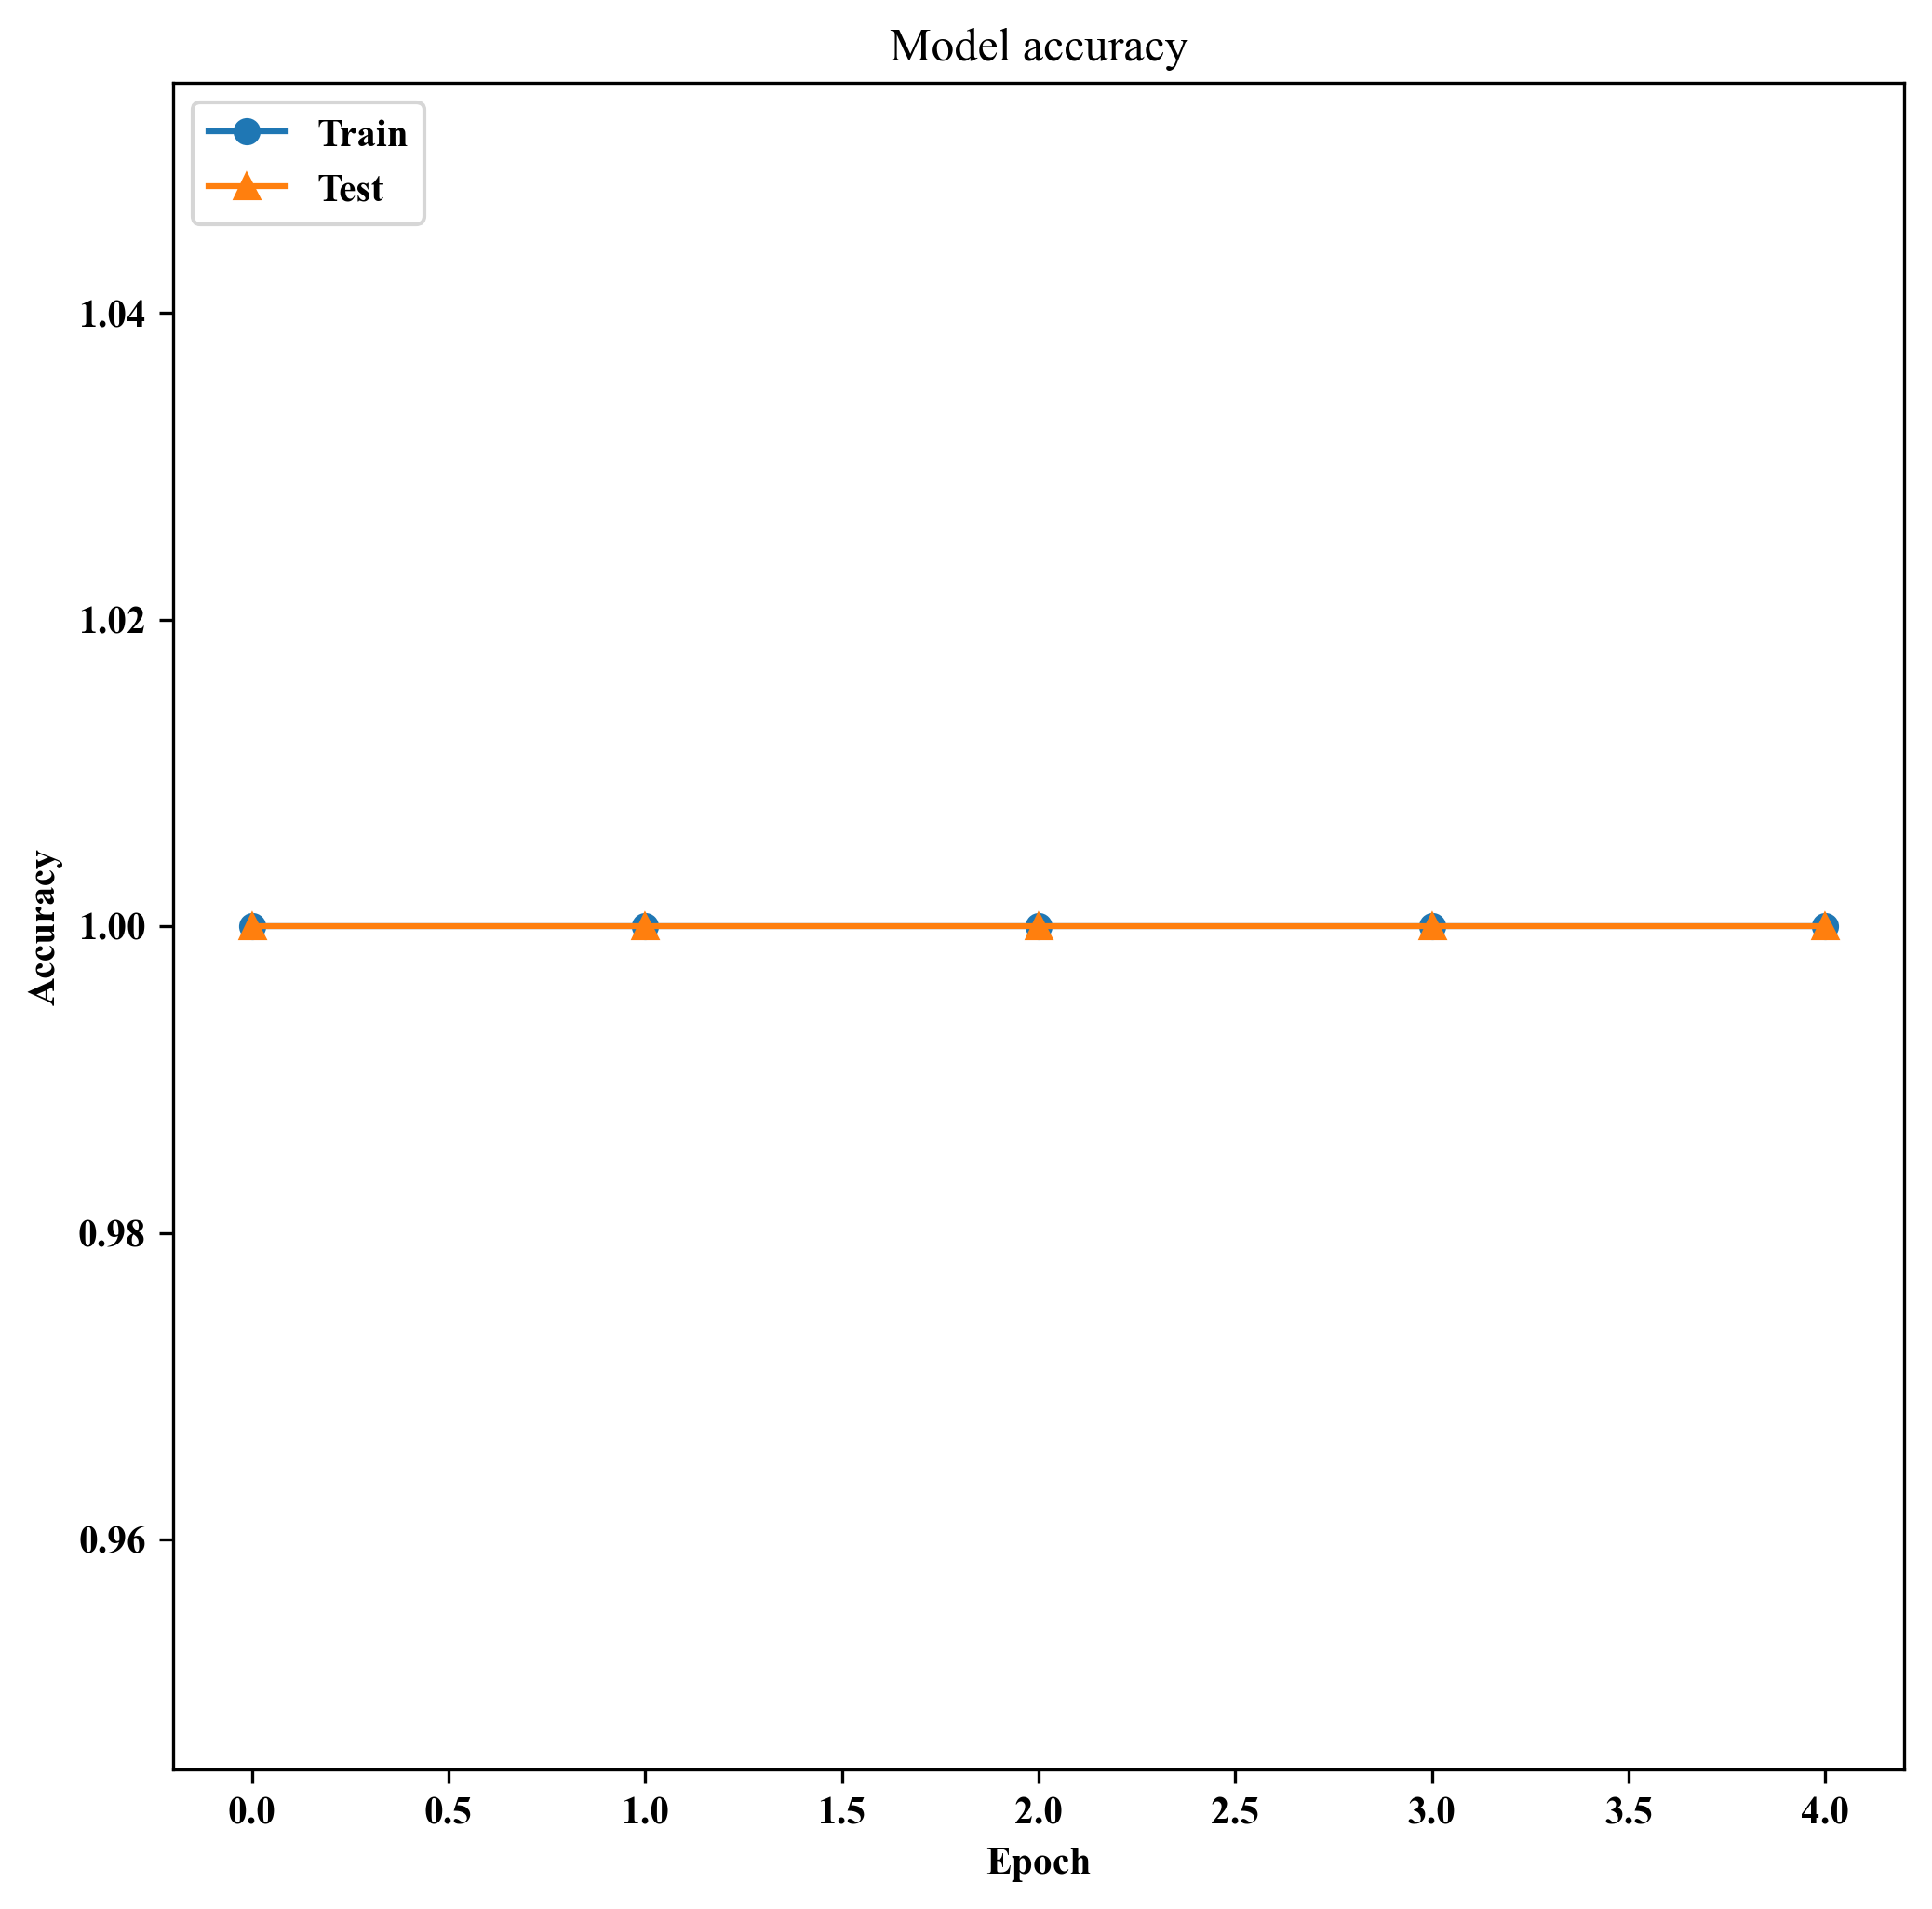

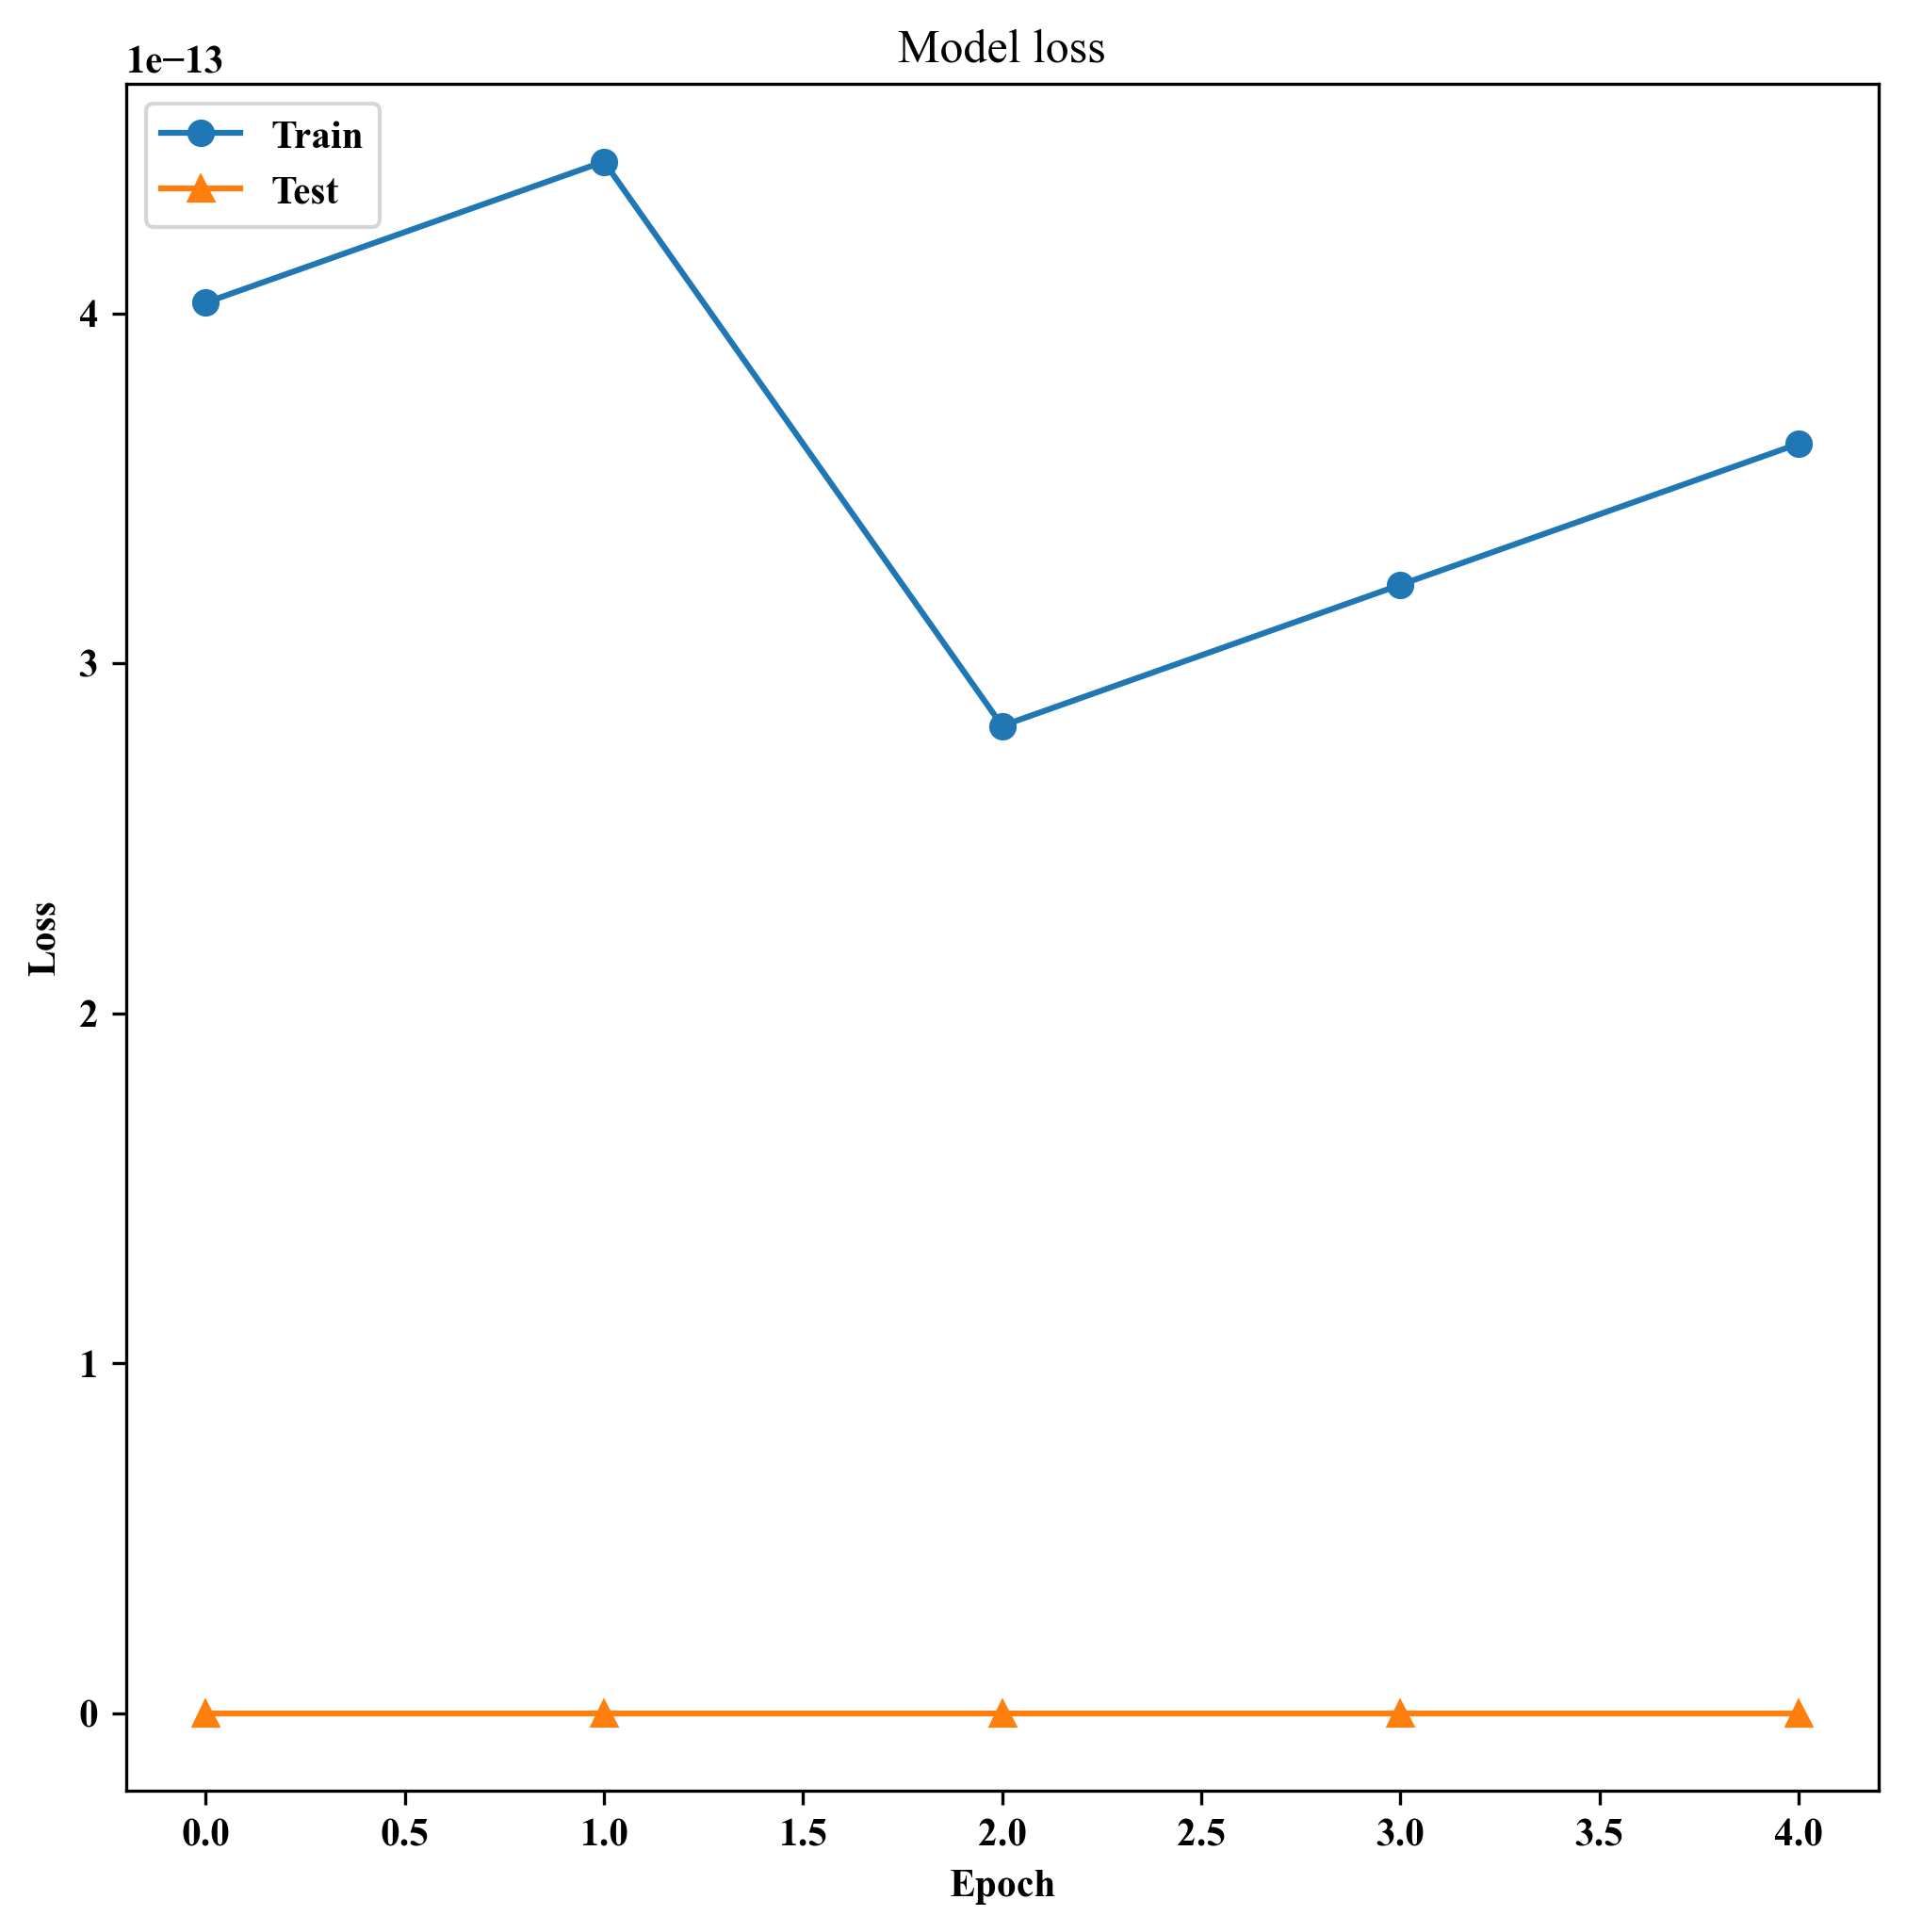

In [51]:
#----------------------------------第五步 可视化--------------------------------
# 绘制训练 & 验证的准确率值,用点表示
plt.figure(figsize=(8,8),dpi=300)
plt.plot(history.history['accuracy'], 'o-')
plt.plot(history.history['val_accuracy'], '^-')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
# plt.savefig('cnn_bilstm_accuracy.png')
plt.show()

plt.figure(figsize=(8,8),dpi=300)
# 绘制训练 & 验证的损失值,用三角表示
plt.plot(history.history['loss'], 'o-')
plt.plot(history.history['val_loss'], '^-')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
# plt.savefig('cnn_bilstm_loss.png')
plt.show()


In [52]:
print("模型预测")
mainModel = load_model('model_intra\\cnn_bilstm_model2_RPM.h5', custom_objects={'AttentionLayer': AttentionLayer(50)}, compile=False)
# 预测


模型预测


In [53]:
# import time
# from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# # 计算预测时间
# start_time = time.time()  # 记录开始时间
# test_pre = mainModel.predict(testSeq)
# end_time = time.time()  # 记录结束时间
# average_prediction_time = (end_time - start_time) / len(testSeq)
# print("Average Prediction Time per Data Point: {:.6f} seconds".format(average_prediction_time))

# confm = confusion_matrix(np.argmax(y_test.values, axis=1), np.argmax(test_pre, axis=1))

# # Calculate the false positive rate
# tn, fp, fn, tp = confm.ravel()
# false_positive_rate = fp / (fp + tn)
# print("False Positive Rate: {:.4f}".format(false_positive_rate))

# print(confm)

# print(classification_report(np.argmax(y_test.values, axis=1), np.argmax(test_pre, axis=1), digits=4))
# print("Accuracy:", accuracy_score(np.argmax(y_test.values, axis=1), np.argmax(test_pre, axis=1)))

# plt.figure(figsize=(8, 8), dpi=300)
# sns.heatmap(confm, square=True, annot=True,
#             fmt='d', cbar=False, linewidths=.6,
#             cmap="Blues")
# plt.xlabel('Predicted label', size=14)
# plt.ylabel('True label', size=14)
# Labname = ['Normal','RPM']   #行列名
# plt.xticks(np.arange(2) + 0.5, Labname, size=12)
# plt.yticks(np.arange(2) + 0.5, Labname, size=12)

# plt.show()


Average Prediction Time per Data Point: 0.000087 seconds
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000    792847
           1     1.0000    1.0000    1.0000    131494

    accuracy                         1.0000    924341
   macro avg     1.0000    1.0000    1.0000    924341
weighted avg     1.0000    1.0000    1.0000    924341

Accuracy:1.0000
MCC:1.0000
Kappa:1.0000
False Positive Rate (Benign samples misclassified as attacks): 0.0000


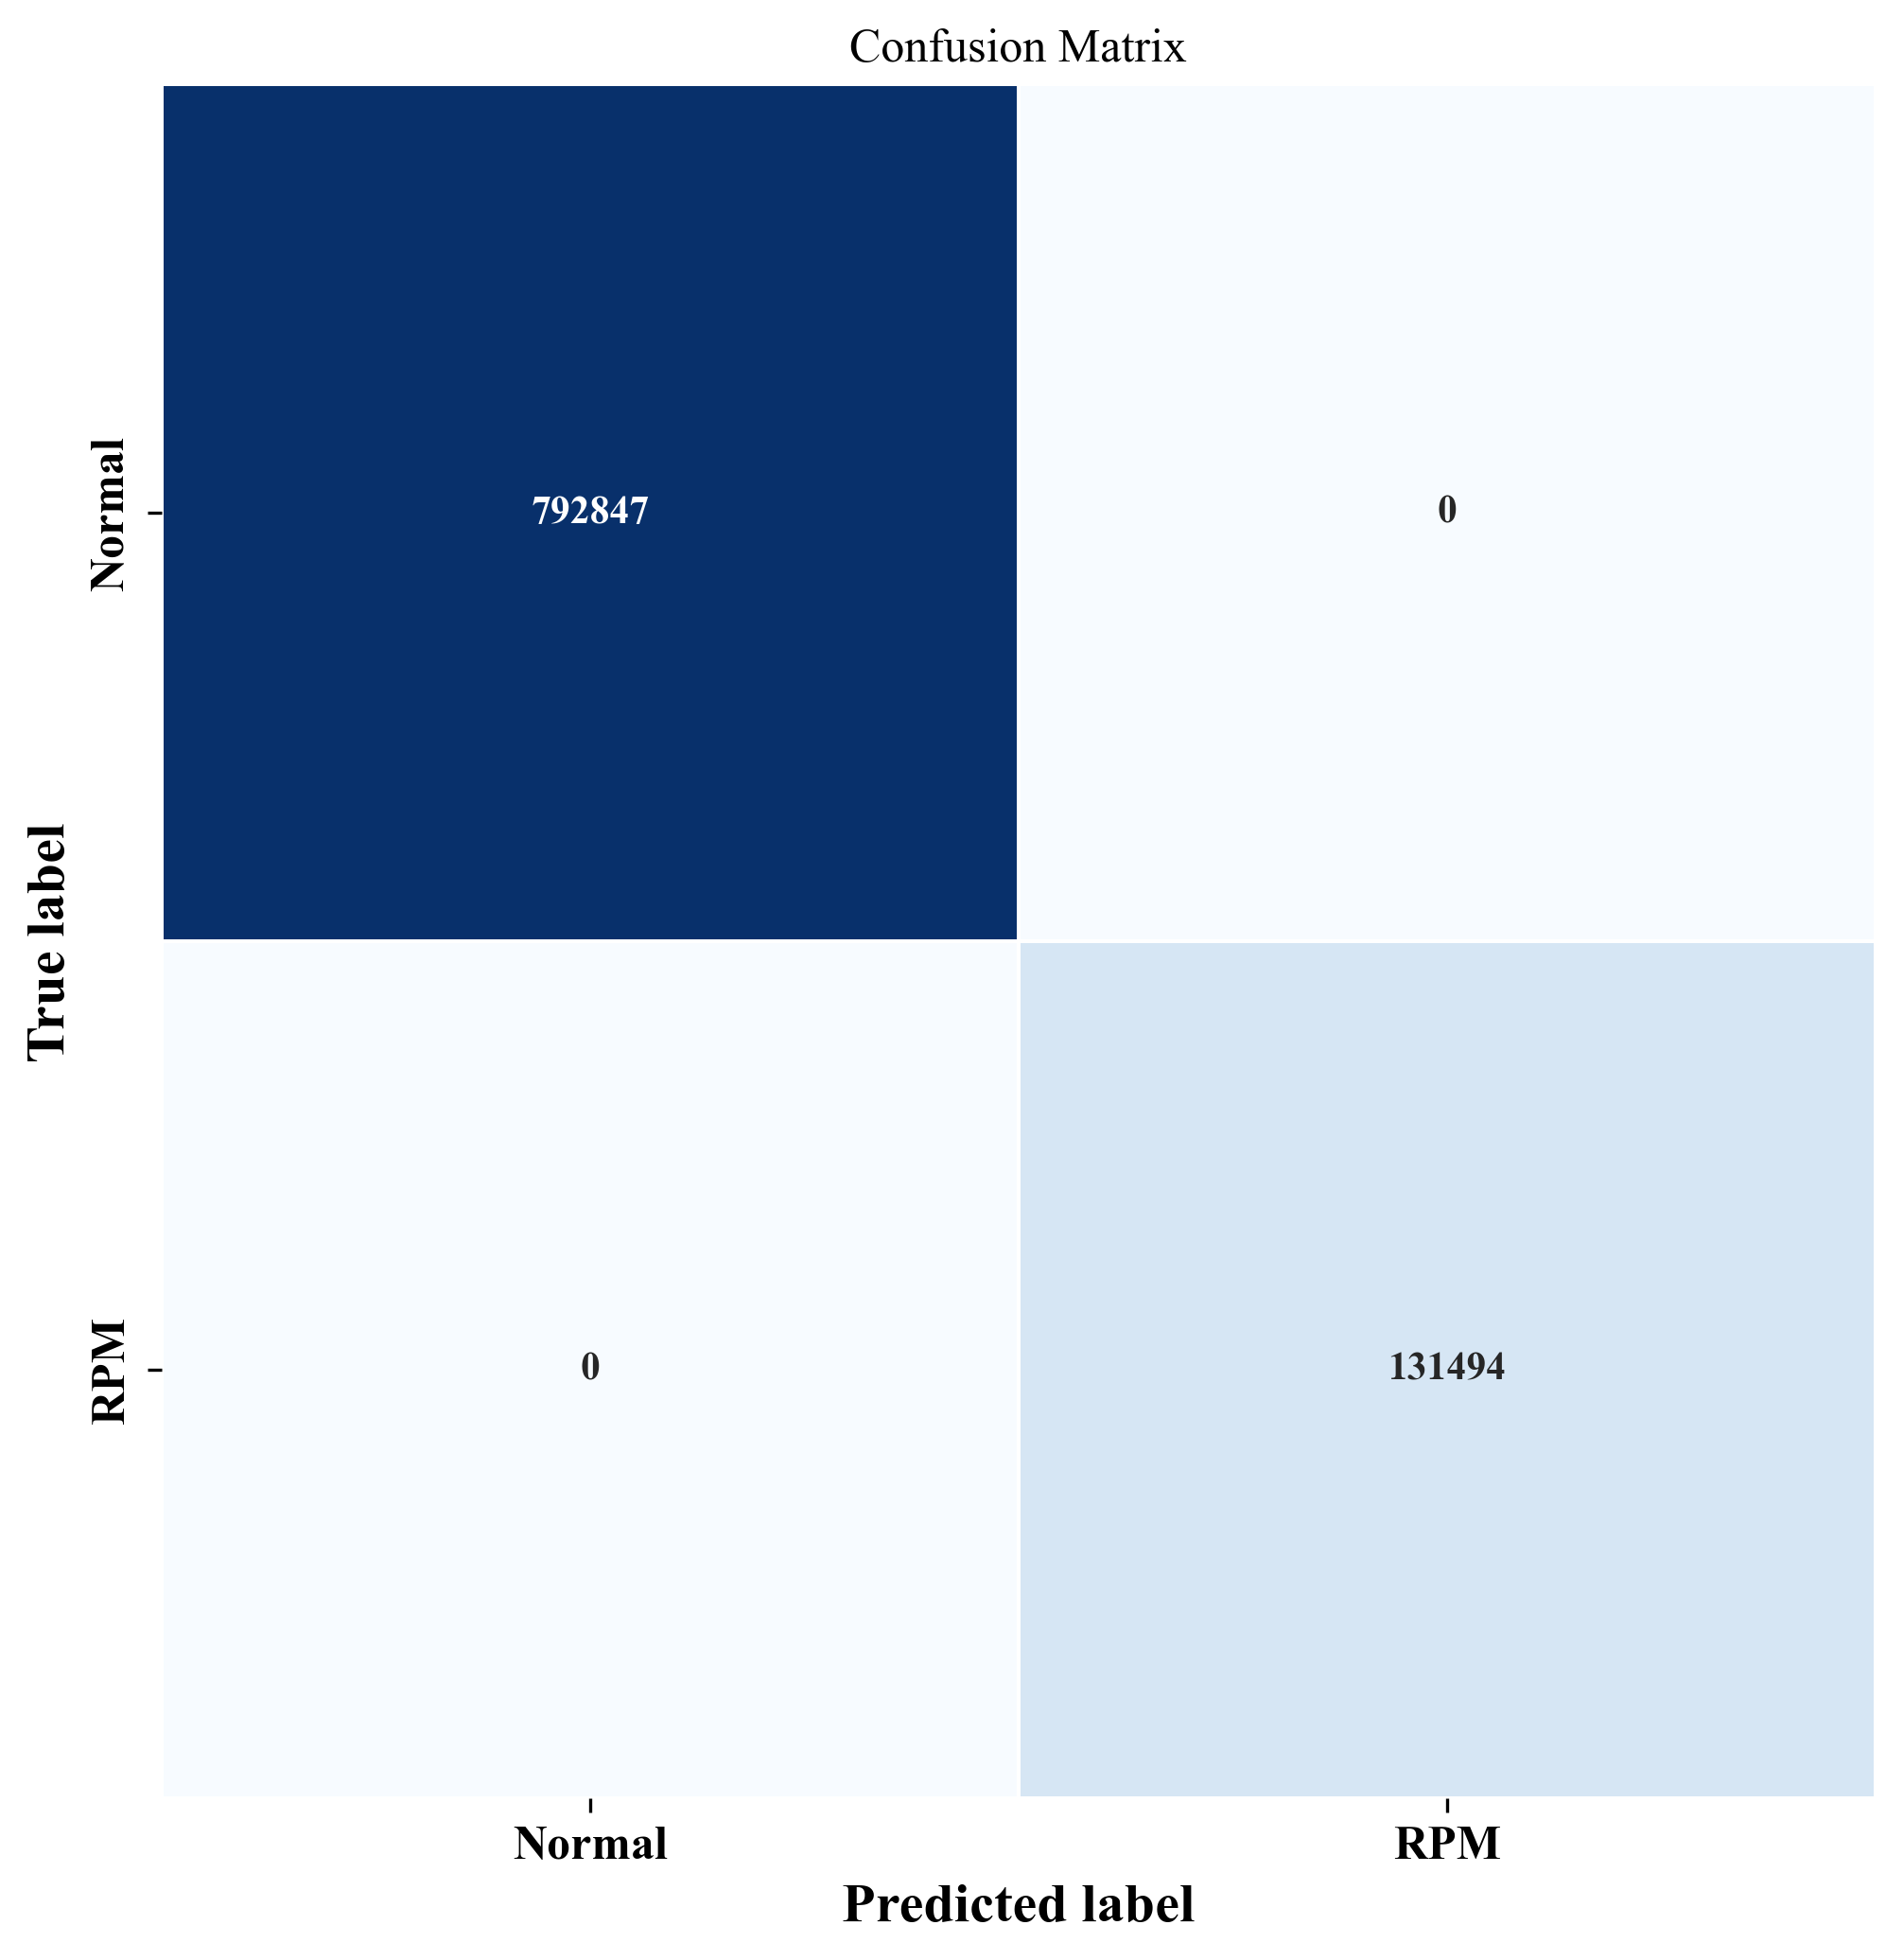

In [54]:
# 计算预测时间
start_time = time.time()  # 记录开始时间
test_pre = mainModel.predict(testSeq)
end_time = time.time()  # 记录结束时间
average_prediction_time = (end_time - start_time) / len(testSeq)
print("Average Prediction Time per Data Point: {:.6f} seconds".format(average_prediction_time))

# 计算混淆矩阵
confm = metrics.confusion_matrix(np.argmax(y_test, axis=1), np.argmax(test_pre, axis=1))
# 计算classification_report
print(metrics.classification_report(np.argmax(y_test, axis=1),
                                    np.argmax(test_pre, axis=1),
                                    digits=4))
# 计算准确度
accuracy = metrics.accuracy_score(np.argmax(y_test, axis=1),
                                          np.argmax(test_pre, axis=1))
print("Accuracy:{:.4f}".format(accuracy))
# 计算MCC
mcc = metrics.matthews_corrcoef(np.argmax(y_test, axis=1),
                                          np.argmax(test_pre, axis=1))
print("MCC:{:.4f}".format(mcc))
# 计算kappa
kappa = metrics.cohen_kappa_score(np.argmax(y_test, axis=1),
                                          np.argmax(test_pre, axis=1))
print("Kappa:{:.4f}".format(kappa))
# 计算误报率（False Positive Rate）
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(test_pre, axis=1)
false_positives = np.sum((y_true == 0) & (y_pred != 0))  # 0 represents the "Benign" class
total_benign_samples = np.sum(y_true == 0)
false_positive_rate = false_positives / total_benign_samples
print("False Positive Rate (Benign samples misclassified as attacks): {:.4f}".format(false_positive_rate))

# 画图
#设置所有图片的字体大小为10，字体为Times New Roman，字体为粗体，label的字体大小为10，字体为Times New Roman，字体为粗体
plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'

plt.figure(figsize=(8, 8), dpi=300)
sns.heatmap(confm, square=True, annot=True,
            fmt='d', cbar=False, linewidths=.6,
            cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted label', size=14)
plt.ylabel('True label', size=14)
Labname = ['Normal','RPM']   #行列名
plt.xticks(np.arange(2) + 0.5, Labname, size=12)
plt.yticks(np.arange(2) + 0.5, Labname, size=12)
plt.show()


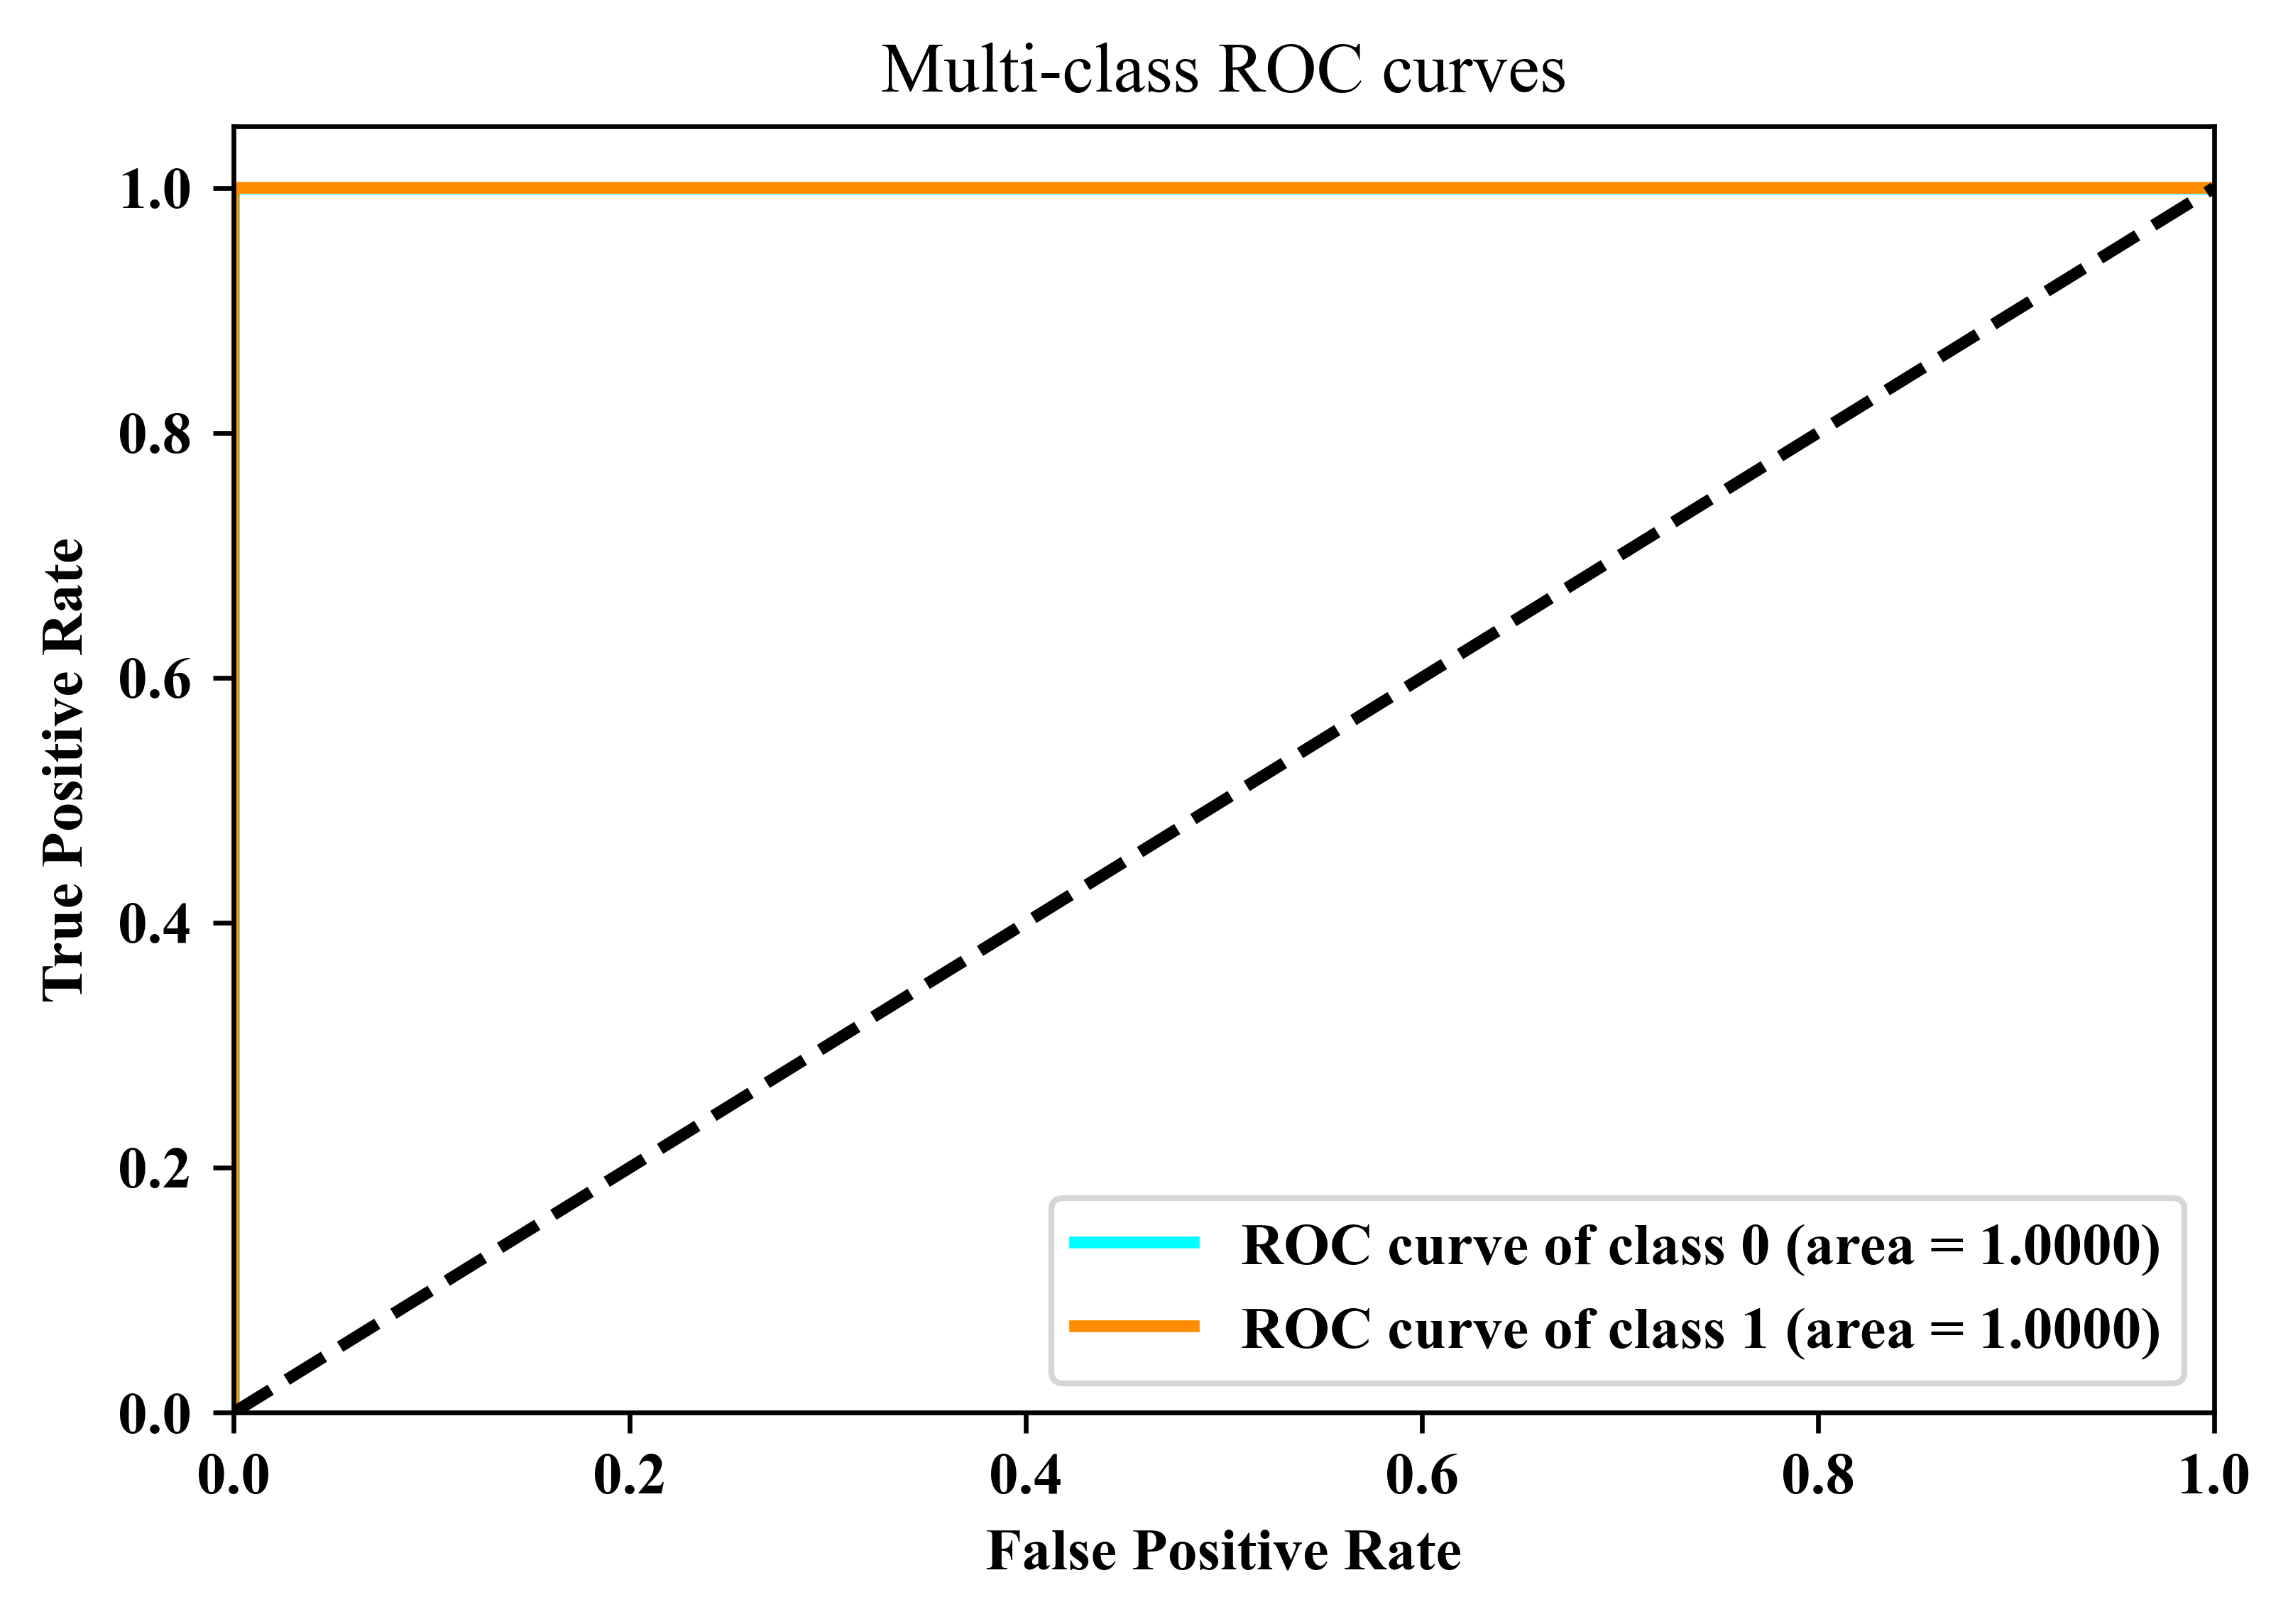

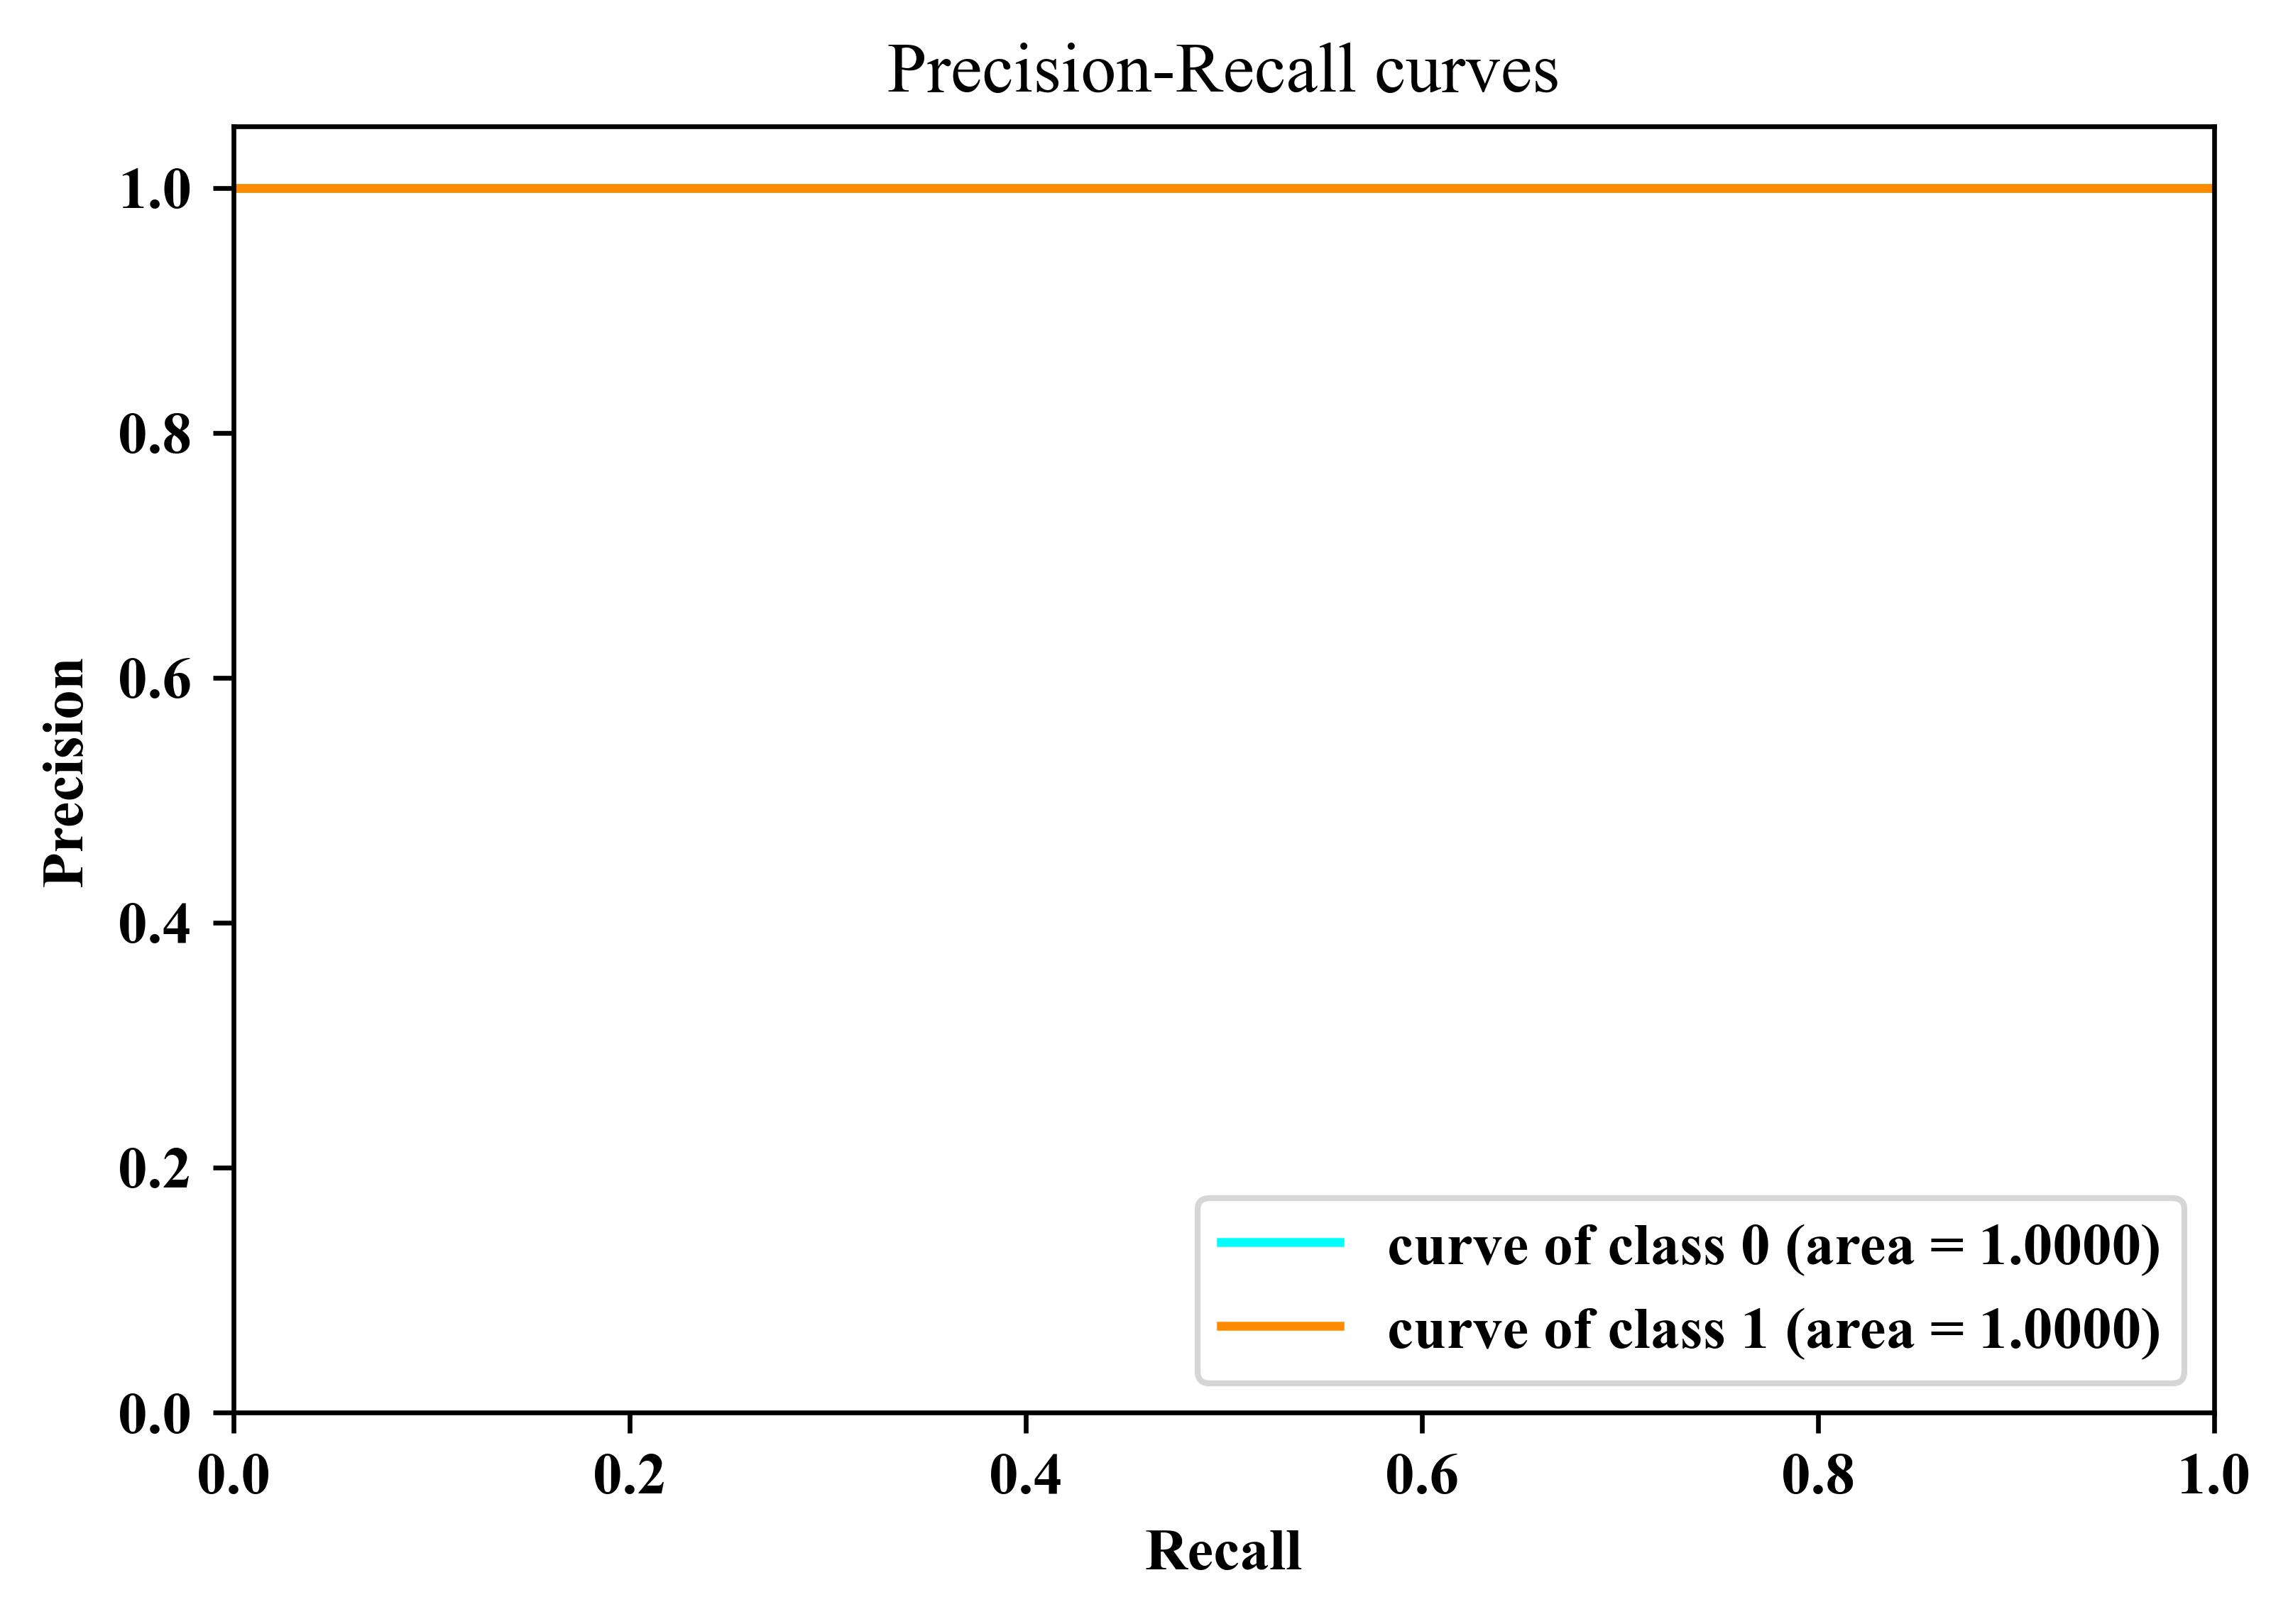

In [55]:

# Compute ROC curve and ROC area for each class
n_classes = 2
# Compute ROC curve and ROC area for each class
# 保存每一类的fpr和tpr值到csv文件，便于后续画图
fpr = dict()
tpr = dict()
roc_auc = dict()
thresholds = dict()
for i in range(n_classes):
    fpr[i], tpr[i], thresholds[i] = metrics.roc_curve(y_test[:, i], test_pre[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    df = pd.DataFrame({'fpr':fpr[i],'tpr':tpr[i]})
    df.to_csv('./Results/intra_adam_RPM_fpr_tpr_{}.csv'.format(i))
# 画图AUC-ROC
plt.figure(dpi=600)
lw = 2
colors = cycle(["aqua", "darkorange", "darkgreen", "yellow", "red", "purple", "blue", "gray"])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
    label="ROC curve of class {0} (area = {1:0.4f})".format(i, roc_auc[i]),)
plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('Multi-class ROC curves')
plt.legend(loc="lower right")
plt.show()



# Compute auc-pr and AP(average precision) for each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = metrics.precision_recall_curve(y_test[:, i], test_pre[:, i])
    average_precision[i] = metrics.average_precision_score(y_test[:, i], test_pre[:, i])
    df = pd.DataFrame({'precision':precision[i],'recall':recall[i]})
    df.to_csv('./Results/intra_adam_RPM_precision_recall_{}.csv'.format(i))
# 绘制所有类别的pr曲线
plt.figure(dpi=600)
lw = 2
colors = cycle(["aqua", "darkorange", "darkgreen", "yellow", "red", "purple", "blue", "gray"])
for i, color in zip(range(n_classes), colors):
    plt.step(recall[i], precision[i], color=color, where="post", label="curve of class {0} (area = {1:0.4f})".format(i, average_precision[i]))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title("Precision-Recall curves")
plt.legend(loc="lower right")
plt.show()   
